# 4 - Convolutional Sentiment Analysis

In the previous notebooks, we managed to achieve a test accuracy of ~85% using RNNs and an implementation of the [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759) model. In this notebook, we will be using a *convolutional neural network* (CNN) to conduct sentiment analysis, implementing the model from [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

**Note**: This tutorial is not aiming to give a comprehensive introduction and explanation of CNNs. For a better and more in-depth explanation check out [here](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) and [here](https://cs231n.github.io/convolutional-networks/).

Traditionally, CNNs are used to analyse images and are made up of one or more *convolutional* layers, followed by one or more linear layers. The convolutional layers use filters (also called *kernels* or *receptive fields*) which scan across an image and produce a processed version of the image. This processed version of the image can be fed into another convolutional layer or a linear layer. Each filter has a shape, e.g. a 3x3 filter covers a 3 pixel wide and 3 pixel high area of the image, and each element of the filter has a weight associated with it, the 3x3 filter would have 9 weights. In traditional image processing these weights were specified by hand by engineers, however the main advantage of the convolutional layers in neural networks is that these weights are learned via backpropagation. 

The intuitive idea behind learning the weights is that your convolutional layers act like *feature extractors*, extracting parts of the image that are most important for your CNN's goal, e.g. if using a CNN to detect faces in an image, the CNN may be looking for features such as the existance of a nose, mouth or a pair of eyes in the image.

So why use CNNs on text? In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In the previous tutorial we looked at the FastText model which used bi-grams by explicitly adding them to the end of a text, in this CNN model we will instead use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the review will be a good indication of the final sentiment.

## Preparing Data

As in the previous notebooks, we'll prepare the data. 

Unlike the previous notebook with the FastText model, we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

In [1]:
import torch
from torchtext import data
from torchtext import datasets
import random

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Build the vocab and load the pre-trained word embeddings.

In [2]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache\glove.6B.zip: 862MB [02:13, 6.47MB/s]                                                                    
 99%|██████████████████████████████████████████████████████████████████████▋| 397952/400000 [00:13<00:00, 29249.52it/s]

As before, we create the iterators.

In [3]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

## Build the Model

Now to build our model.

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. However, we know that the first step in almost all of our previous tutorials (and pretty much all NLP pipelines) is converting the words into word embeddings. This is how we can visualize our words in 2 dimensions, each word along one axis and the elements of vectors aross the other dimension. Consider the 2 dimensional representation of the embedded sentence below:

![](assets/sentiment9.png)

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a [4x5] "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

![](assets/sentiment12.png)

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

![](assets/sentiment13.png)

Finally, the filter moves down again and the final output for this filter is calculated.

![](assets/sentiment14.png)

In our case (and in the general case where the width of the filter equals the width of the "image"), our output will be a vector with number of elements equal to the height of the image (or lenth of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

This example showed how to calculate the output of one filter. Our model (and pretty much all CNNs) will have lots of these filters. The idea is that each filter will learn a different feature to extract. In the above example, we are hoping each of the **[2 x emb_dim]** filters will be looking for the occurence of different bi-grams. 

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. This is similar to the FastText model where we performed the average over each of the word vectors, implemented by the `F.avg_pool2d` function, however instead of taking the average over a dimension, we are taking the maximum value over a dimension. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

![](assets/sentiment15.png)

The idea here is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

In PyTorch, RNNs want the input with the batch dimension second, whereas CNNs want the batch dimension first. Thus, the first thing we do to our input is `permute` it to make it the correct shape. We then pass the sentence through an embedding layer to get our embeddings. The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], embedding_dim))
        
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [5]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [6]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We create an instance of our `CNN` class. 

We can change `CNN` to `CNN1d` if we want to run the 1-dimensional convolutional model, noting that both models give almost identical results.

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Checking the number of parameters in our model we can see it has about the same as the FastText model. 

Both the `CNN` and the `CNN1d` models have the exact same number of parameters.

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


Next, we'll load the pre-trained embeddings

In [9]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.8657, -0.8550,  0.3735,  ...,  0.0572,  0.9522, -0.3449],
        [-0.1123,  0.3113,  0.3317,  ..., -0.4576,  0.6191,  0.5304],
        [ 0.4109, -0.9915,  1.9818,  ..., -0.9539, -0.0766,  1.0557]])

Then zero the initial weights of the unknown and padding tokens.

In [10]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training is the same as before. We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [11]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [12]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: as we are using dropout again, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [13]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [14]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [15]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [16]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.645 | Train Acc: 62.21%
	 Val. Loss: 0.500 |  Val. Acc: 77.92%
Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 0.429 | Train Acc: 80.31%
	 Val. Loss: 0.367 |  Val. Acc: 83.80%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.296 | Train Acc: 87.85%
	 Val. Loss: 0.332 |  Val. Acc: 85.44%
Epoch: 04 | Epoch Time: 0m 17s
	Train Loss: 0.220 | Train Acc: 91.40%
	 Val. Loss: 0.327 |  Val. Acc: 86.14%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.158 | Train Acc: 94.15%
	 Val. Loss: 0.334 |  Val. Acc: 86.57%


We get test results comparable to the previous 2 models!

In [17]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.339 | Test Acc: 85.55%


## User Input

And again, as a sanity check we can check some input sentences

**Note**: As mentioned in the implementation details, the input sentence has to be at least as long as the largest filter height used. We modify our `predict_sentiment` function to also accept a minimum length argument. If the tokenized input sentence is less than `min_len` tokens, we append padding tokens (`<pad>`) to make it `min_len` tokens.

In [18]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [19]:
predict_sentiment(model, "This film is terrible")

0.13234829902648926

An example positive review...

In [20]:
predict_sentiment(model, "This film is great")

0.9544308185577393

In [21]:
import pandas as pd

In [22]:
test1 = pd.read_csv("SAR14.csv")

In [23]:
test1.head()

,sentence,score
0,The first art-film ? . this is possibly the m...,10
1,collision between the tradition of family val...,10
2,An everyday occurrence for posterity . Louis ...,4
3,The first family film ? . Monsieur Lumi re no...,4
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,8


In [25]:
test1['model_score'] = ''

In [30]:
for i in range(len(test1)):
    test1.model_score[i] = predict_sentiment(model,test1.sentence[i])
    print(i)

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973


8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611


10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
1020

11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
1157

12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
1293

14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
1430

15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
15514
15515
15516
15517
15518
15519
15520
15521
15522
15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
1566

16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887
16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
1703

18232
18233
18234
18235
18236
18237
18238
18239
18240
18241
18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
1839

19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
1976

KeyboardInterrupt: 

In [42]:
df = test1.head(100)

In [43]:
df

,sentence,score,model_score
0,The first art-film ? . this is possibly the m...,10,0.827126
1,collision between the tradition of family val...,10,0.741373
2,An everyday occurrence for posterity . Louis ...,4,0.576941
3,The first family film ? . Monsieur Lumi re no...,4,0.834774
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,8,0.917552
5,"Marvelous ! . In less than 5 years , the cine...",8,0.987467
6,One of many weird `` head '' movies from M li...,9,0.99525
7,ka-boom ! . Melies had a sense of playfulness...,9,0.0619146
8,Pretty entertaining for 1903 . This film is c...,7,0.769512
9,A masterpiece of political comedy . -LRB- spo...,9,0.0944238


In [44]:
import pandas as pd
from googletrans import Translator

In [47]:
df["translated_chinese"] = ""

translator = Translator()
for i in range(100):
    try:
        chn_text = translator.translate(df['sentence'][i], dest="zh-TW", src="en").text
        df["translated_chinese"][i] = chn_text
        print(i)
    except Exception:
        df["translated_chinese"][i] = 'error'
        print(i)


C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [48]:
df["translated_english"] = ""

translator = Translator()
for i in range(100):
    try:
        eng_text = translator.translate(df['translated_chinese'][i], dest="en", src="zh-TW").text
        df["translated_english"][i] = eng_text
        print(i)
    except Exception:
        df["translated_english"][i] = 'error'
        print(i)

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [65]:
df["translated_chinese2"] = ""

translator = Translator()
for i in range(100):
    try:
        chn_text = translator.translate(df['translated_english'][i], dest="zh-TW", src="en").text
        df["translated_chinese2"][i] = chn_text
        print(i)
    except Exception:
        df["translated_chinese2"][i] = 'error'
        print(i)


C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [69]:
df["translated_english2"] = ""

translator = Translator()
for i in range(100):
    try:
        eng_text = translator.translate(df['translated_chinese2'][i], dest="en", src="zh-TW").text
        df["translated_english2"][i] = eng_text
        print(i)
    except Exception:
        df["translated_english2"][i] = 'error'
        print(i)

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [66]:
df

,sentence,score,model_score,translated_chinese,translated_english,model_score2,translated_chinese2,translated_english2,model_score3
0,The first art-film ? . this is possibly the m...,10,0.827126,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方排出觀眾到後面...,The first art film? . This is probably the mos...,0.85598,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方向後方離開觀眾...,The first art film? . This is probably the mos...,0.496425
1,collision between the tradition of family val...,10,0.741373,家庭價值觀傳統，新媒體的現代性和自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們鄉下的家...,"The tradition of family values, the conflict b...",0.828449,家庭價值觀的傳統，新媒體的現代性與自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們的祖國...,"The tradition of family values, the conflict b...",0.496425
2,An everyday occurrence for posterity . Louis ...,4,0.576941,後人的日常生活。 Louis Lumiere的兄弟Auguste和他的妻子坐在他們花園裡的一...,The daily life of future generations. Louis Lu...,0.618858,後代的日常生活。 Louis Lumiere的兄弟奧古斯特和他的妻子坐在他們花園裡的一張桌子...,The daily life of future generations. Louis Lu...,0.496425
3,The first family film ? . Monsieur Lumi re no...,4,0.834774,第一部家庭電影？ 。 Lumi先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他...,The first family movie? . Mr. Lumi not only wa...,0.679882,第一部家庭電影？ 。盧米先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他小男嬰...,The first family movie? . Mr. Lumi not only wa...,0.496425
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,8,0.917552,哎喲！那有傷害！ -LRB- SPOILERS -RRB-。 SPOILERS嗯，我回來評論...,Ouch! That hurts! -LRB- SPOILERS -RRB-. SPOILE...,0.970789,哎喲!那傷害了！ -LRB- SPOILERS -RRB-。 SPOILERS好吧，我回來評...,Ouch! That hurts! -LRB- SPOILERS -RRB-. SPOILE...,0.496425
5,"Marvelous ! . In less than 5 years , the cine...",8,0.987467,太棒了！ 。在不到5年的時間裡，電影從早期開拓者-LRB- Le Prince，Dickso...,"awesome! . In less than five years, the film j...",0.97927,真棒！ 。在不到五年的時間裡，這部電影從早期開拓者的短片“紀錄片” - LRB-Le Pr...,"awesome! . In less than five years, the film j...",0.496425
6,One of many weird `` head '' movies from M li...,9,0.99525,來自M li的許多奇怪的“頭部”電影之一。早期的法國電影導演M li因其詭計攝影而聞名。他應...,"One of the many strange ""head"" movies from M L...",0.977109,來自M Li的許多奇怪的“頭部”電影之一。早期的法國電影導演M Li以其狡猾的攝影而聞名。他...,"One of the many strange ""head"" movies from M L...",0.496425
7,ka-boom ! . Melies had a sense of playfulness...,9,0.0619146,ka-boom！ 。 Melies對他的電影有一種好玩的感覺，這是更有趣的一個：Melies...,Ka-boom! . Melies has a fun feeling about his ...,0.56718,嘉潮！ 。 Melies對他的電影有一種有趣的感覺。這是一個更有趣的一個：Melies採取了...,Ka-boom! . Melies has a fun feeling about his ...,0.496425
8,Pretty entertaining for 1903 . This film is c...,7,0.769512,1903年非常有趣。即使在今天，這部電影也很可愛，也很容易觀看 - 而這部電影對於許多早期的...,"1903 was very interesting. Even today, the mov...",0.767838,1903年非常有趣。即使在今天，這部電影也很可愛，容易觀看 - 這部電影適用於許多早期電影 ...,"1903 was very interesting. Even today, the mov...",0.496425
9,A masterpiece of political comedy . -LRB- spo...,9,0.0944238,政治喜劇的傑作。 -LRB-擾流器在最後一段-RRB-。可悲的是，這部著名的黑色喜劇是早期電...,A masterpiece of political comedy. -LRB-spoile...,0.609898,政治喜劇的傑作。最後一段-RRB-中的-LRB擾流器。可悲的是，這部著名的黑色喜劇是早期電影...,A masterpiece of political comedy. -LRB-spoile...,0.496425


In [50]:
df['model_score2'] = ''

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
for i in range(100):
    df.model_score2[i] = predict_sentiment(model,df.translated_english[i])
    print(i)

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [71]:
df['model_score3'] = ''
for i in range(100):
    df.model_score3[i] = predict_sentiment(model,df.translated_english2[i])
    print(i)

C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\liuti\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [72]:
df

,sentence,score,model_score,translated_chinese,translated_english,model_score2,translated_chinese2,translated_english2,model_score3
0,The first art-film ? . this is possibly the m...,10,0.827126,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方排出觀眾到後面...,The first art film? . This is probably the mos...,0.85598,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方向後方離開觀眾...,The first art film? . This is probably the mos...,0.871399
1,collision between the tradition of family val...,10,0.741373,家庭價值觀傳統，新媒體的現代性和自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們鄉下的家...,"The tradition of family values, the conflict b...",0.828449,家庭價值觀的傳統，新媒體的現代性與自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們的祖國...,"The tradition of family values, the conflict b...",0.930144
2,An everyday occurrence for posterity . Louis ...,4,0.576941,後人的日常生活。 Louis Lumiere的兄弟Auguste和他的妻子坐在他們花園裡的一...,The daily life of future generations. Louis Lu...,0.618858,後代的日常生活。 Louis Lumiere的兄弟奧古斯特和他的妻子坐在他們花園裡的一張桌子...,Daily life of future generations. Louis Lumier...,0.655547
3,The first family film ? . Monsieur Lumi re no...,4,0.834774,第一部家庭電影？ 。 Lumi先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他...,The first family movie? . Mr. Lumi not only wa...,0.679882,第一部家庭電影？ 。盧米先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他小男嬰...,The first family movie? . Mr. Lumi not only wa...,0.701793
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,8,0.917552,哎喲！那有傷害！ -LRB- SPOILERS -RRB-。 SPOILERS嗯，我回來評論...,Ouch! That hurts! -LRB- SPOILERS -RRB-. SPOILE...,0.970789,哎喲!那傷害了！ -LRB- SPOILERS -RRB-。 SPOILERS好吧，我回來評...,Oh! That hurts! -LRB- SPOILERS -RRB-. SPOILERS...,0.843647
5,"Marvelous ! . In less than 5 years , the cine...",8,0.987467,太棒了！ 。在不到5年的時間裡，電影從早期開拓者-LRB- Le Prince，Dickso...,"awesome! . In less than five years, the film j...",0.97927,真棒！ 。在不到五年的時間裡，這部電影從早期開拓者的短片“紀錄片” - LRB-Le Pr...,"Awesome! . In less than five years, the film j...",0.974916
6,One of many weird `` head '' movies from M li...,9,0.99525,來自M li的許多奇怪的“頭部”電影之一。早期的法國電影導演M li因其詭計攝影而聞名。他應...,"One of the many strange ""head"" movies from M L...",0.977109,來自M Li的許多奇怪的“頭部”電影之一。早期的法國電影導演M Li以其狡猾的攝影而聞名。他...,"One of many strange ""head"" movies from M Li. T...",0.980379
7,ka-boom ! . Melies had a sense of playfulness...,9,0.0619146,ka-boom！ 。 Melies對他的電影有一種好玩的感覺，這是更有趣的一個：Melies...,Ka-boom! . Melies has a fun feeling about his ...,0.56718,嘉潮！ 。 Melies對他的電影有一種有趣的感覺。這是一個更有趣的一個：Melies採取了...,Jiachao! . Melies has an interesting feeling a...,0.695695
8,Pretty entertaining for 1903 . This film is c...,7,0.769512,1903年非常有趣。即使在今天，這部電影也很可愛，也很容易觀看 - 而這部電影對於許多早期的...,"1903 was very interesting. Even today, the mov...",0.767838,1903年非常有趣。即使在今天，這部電影也很可愛，容易觀看 - 這部電影適用於許多早期電影 ...,"1903 was very interesting. Even today, this mo...",0.855929
9,A masterpiece of political comedy . -LRB- spo...,9,0.0944238,政治喜劇的傑作。 -LRB-擾流器在最後一段-RRB-。可悲的是，這部著名的黑色喜劇是早期電...,A masterpiece of political comedy. -LRB-spoile...,0.609898,政治喜劇的傑作。最後一段-RRB-中的-LRB擾流器。可悲的是，這部著名的黑色喜劇是早期電影...,A masterpiece of political comedy. The last se...,0.689102


In [74]:
count = 0
for i in range(100):
    
    if df.model_score[i] < df.model_score3[i]:
        count += 1
    else:
        count += 0

print(count)

52


In [80]:
df[['model_score2', 'model_score3']].describe()

,model_score2,model_score3
count,100.000000,100.000000
unique,100.000000,100.000000
top,0.277816,0.074007
freq,1.000000,1.000000


In [88]:
df.drop(df.loc[df['translated_english']=='error'].index, inplace=True)

In [86]:
df.drop(df.loc[df['translated_english'] == 'Error'].index, inplace=True)

In [94]:
len(df)

99

In [90]:
df.to_csv('df1.csv')

In [95]:
df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')

In [93]:
df

,sentence,score,model_score,translated_chinese,translated_english,model_score2,translated_chinese2,translated_english2,model_score3
0,The first art-film ? . this is possibly the m...,10,0.827126,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方排出觀眾到後面...,The first art film? . This is probably the mos...,0.85598,第一部藝術電影？ 。這可能是早期Lumiere短褲中最漂亮的。一條船從屏幕前方向後方離開觀眾...,The first art film? . This is probably the mos...,0.871399
1,collision between the tradition of family val...,10,0.741373,家庭價值觀傳統，新媒體的現代性和自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們鄉下的家...,"The tradition of family values, the conflict b...",0.828449,家庭價值觀的傳統，新媒體的現代性與自然的不可理解性之間的衝突。 。兩個慈愛的父母在他們的祖國...,"The tradition of family values, the conflict b...",0.930144
2,An everyday occurrence for posterity . Louis ...,4,0.576941,後人的日常生活。 Louis Lumiere的兄弟Auguste和他的妻子坐在他們花園裡的一...,The daily life of future generations. Louis Lu...,0.618858,後代的日常生活。 Louis Lumiere的兄弟奧古斯特和他的妻子坐在他們花園裡的一張桌子...,Daily life of future generations. Louis Lumier...,0.655547
3,The first family film ? . Monsieur Lumi re no...,4,0.834774,第一部家庭電影？ 。 Lumi先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他...,The first family movie? . Mr. Lumi not only wa...,0.679882,第一部家庭電影？ 。盧米先生不僅希望我們知道他是那裡最有才華的電影製作人之一。他也是他小男嬰...,The first family movie? . Mr. Lumi not only wa...,0.701793
4,Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...,8,0.917552,哎喲！那有傷害！ -LRB- SPOILERS -RRB-。 SPOILERS嗯，我回來評論...,Ouch! That hurts! -LRB- SPOILERS -RRB-. SPOILE...,0.970789,哎喲!那傷害了！ -LRB- SPOILERS -RRB-。 SPOILERS好吧，我回來評...,Oh! That hurts! -LRB- SPOILERS -RRB-. SPOILERS...,0.843647
5,"Marvelous ! . In less than 5 years , the cine...",8,0.987467,太棒了！ 。在不到5年的時間裡，電影從早期開拓者-LRB- Le Prince，Dickso...,"awesome! . In less than five years, the film j...",0.97927,真棒！ 。在不到五年的時間裡，這部電影從早期開拓者的短片“紀錄片” - LRB-Le Pr...,"Awesome! . In less than five years, the film j...",0.974916
6,One of many weird `` head '' movies from M li...,9,0.99525,來自M li的許多奇怪的“頭部”電影之一。早期的法國電影導演M li因其詭計攝影而聞名。他應...,"One of the many strange ""head"" movies from M L...",0.977109,來自M Li的許多奇怪的“頭部”電影之一。早期的法國電影導演M Li以其狡猾的攝影而聞名。他...,"One of many strange ""head"" movies from M Li. T...",0.980379
7,ka-boom ! . Melies had a sense of playfulness...,9,0.0619146,ka-boom！ 。 Melies對他的電影有一種好玩的感覺，這是更有趣的一個：Melies...,Ka-boom! . Melies has a fun feeling about his ...,0.56718,嘉潮！ 。 Melies對他的電影有一種有趣的感覺。這是一個更有趣的一個：Melies採取了...,Jiachao! . Melies has an interesting feeling a...,0.695695
8,Pretty entertaining for 1903 . This film is c...,7,0.769512,1903年非常有趣。即使在今天，這部電影也很可愛，也很容易觀看 - 而這部電影對於許多早期的...,"1903 was very interesting. Even today, the mov...",0.767838,1903年非常有趣。即使在今天，這部電影也很可愛，容易觀看 - 這部電影適用於許多早期電影 ...,"1903 was very interesting. Even today, this mo...",0.855929
9,A masterpiece of political comedy . -LRB- spo...,9,0.0944238,政治喜劇的傑作。 -LRB-擾流器在最後一段-RRB-。可悲的是，這部著名的黑色喜劇是早期電...,A masterpiece of political comedy. -LRB-spoile...,0.609898,政治喜劇的傑作。最後一段-RRB-中的-LRB擾流器。可悲的是，這部著名的黑色喜劇是早期電影...,A masterpiece of political comedy. The last se...,0.689102


In [97]:
count = 0
for i in df.index:
    
    if df.model_score3[i] - df.model_score[i] > 0.01:
        count += 1
    else:
        count += 0

print(count)

48


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

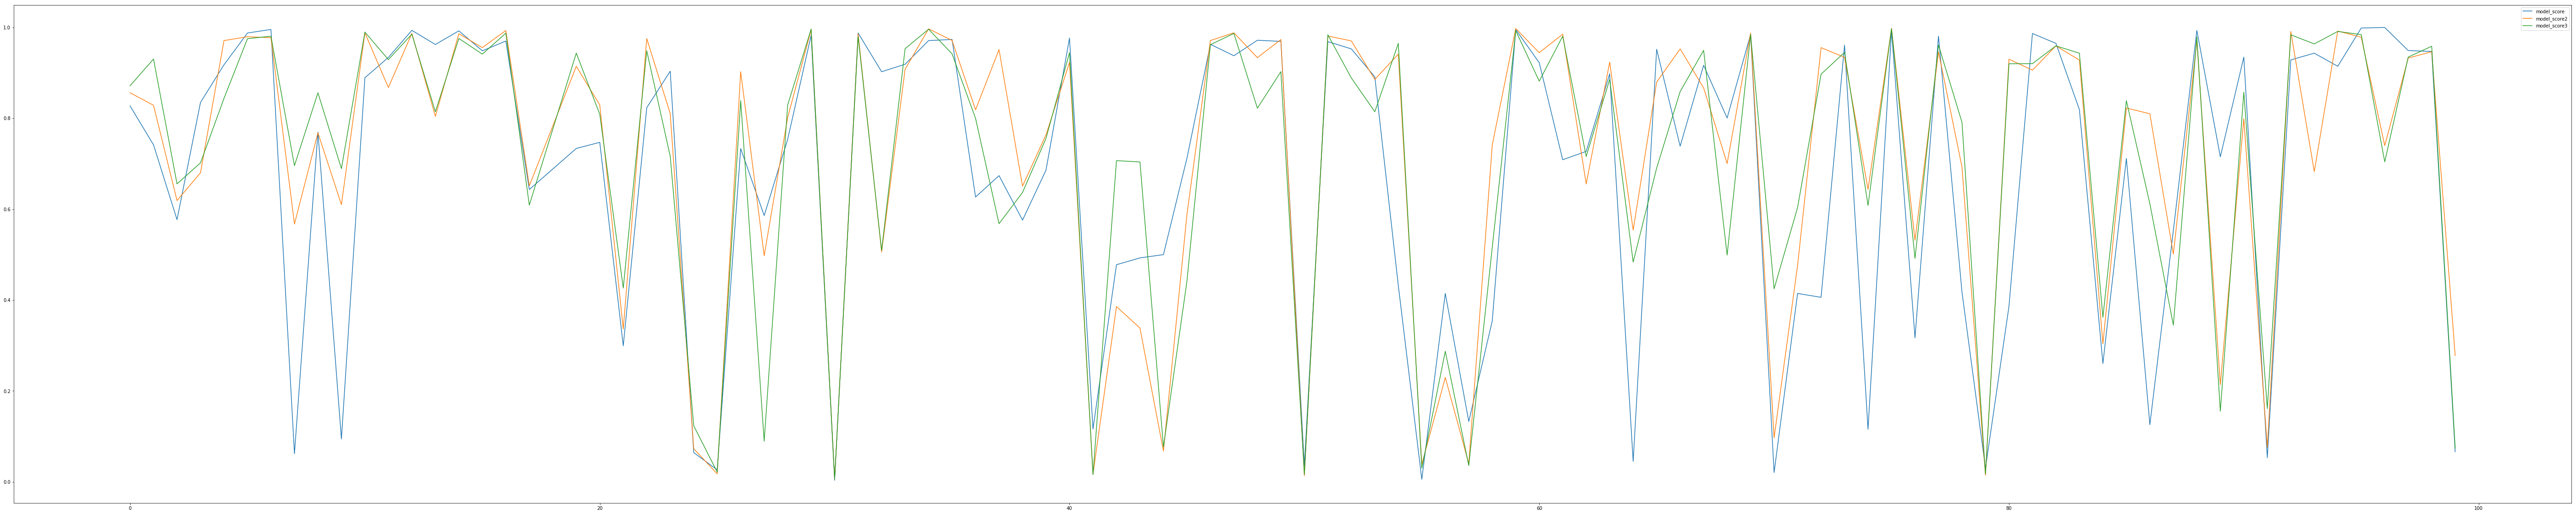

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

df[['model_score','model_score2','model_score3']].plot(kind='line',figsize=(100,20))
plt.show()

ValueError: color kwarg must have one color per data set. 99 data sets and 1 colors were provided

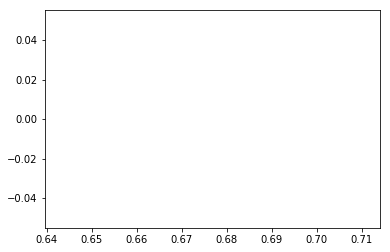

In [104]:
sns.distplot(x, bins=99, kde=False, rug=True)

In [119]:
df.sentence

0      The first art-film ? . this is possibly the m...
1      collision between the tradition of family val...
2      An everyday occurrence for posterity . Louis ...
3      The first family film ? . Monsieur Lumi re no...
4      Ouch ! That 's Got ta Hurt ! -LRB- SPOILERS -...
5      Marvelous ! . In less than 5 years , the cine...
6      One of many weird `` head '' movies from M li...
7      ka-boom ! . Melies had a sense of playfulness...
8      Pretty entertaining for 1903 . This film is c...
9      A masterpiece of political comedy . -LRB- spo...
10     Magical . One of Melies ' elaborate story pro...
11     First there was Melies . . There 's a lot of ...
12     Extraordinary Narrative For Its Time . George...
13     I 'd like to be , under the sea ... . Followi...
14     A Ten for its Time , and Still Charms . You c...
15     The World 's first feature film ! . THE STORY...
16     Pity the poor projectionist ! . This afternoo...
17     A combination of celebration and despair 

In [122]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liuti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [124]:
from nltk import sent_tokenize
 
tokenized_sentence = sent_tokenize(sentence)

In [125]:
tokenized_sentence[1]

'in Computer Science.'

In [172]:
text1 = """
PRIDE & PREJUDICE.

CHAPTER I.


It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered as the rightful
property of some one or other of their daughters.

"My dear Mr. Bennet," said his lady to him one day, "have you heard that
Netherfield Park is let at last?"

Mr. Bennet replied that he had not.

"But it is," returned she; "for Mrs. Long has just been here, and she
told me all about it."

Mr. Bennet made no answer.

"Do not you want to know who has taken it?" cried his wife impatiently.

"_You_ want to tell me, and I have no objection to hearing it."

This was invitation enough.

"Why, my dear, you must know, Mrs. Long says that Netherfield is taken
by a young man of large fortune from the north of England; that he came
down on Monday in a chaise and four to see the place, and was so much
delighted with it that he agreed with Mr. Morris immediately; that he is
to take possession before Michaelmas, and some of his servants are to be
in the house by the end of next week."

"What is his name?"

"Bingley."

"Is he married or single?"

"Oh! single, my dear, to be sure! A single man of large fortune; four
or five thousand a year. What a fine thing for our girls!"

"How so? how can it affect them?"

"My dear Mr. Bennet," replied his wife, "how can you be so tiresome! You
must know that I am thinking of his marrying one of them."

"Is that his design in settling here?"

"Design! nonsense, how can you talk so! But it is very likely that he
_may_ fall in love with one of them, and therefore you must visit him as
soon as he comes."

"I see no occasion for that. You and the girls may go, or you may send
them by themselves, which perhaps will be still better, for as you are
as handsome as any of them, Mr. Bingley might like you the best of the
party."

"My dear, you flatter me. I certainly _have_ had my share of beauty, but
I do not pretend to be any thing extraordinary now. When a woman has
five grown up daughters, she ought to give over thinking of her own
beauty."

"In such cases, a woman has not often much beauty to think of."

"But, my dear, you must indeed go and see Mr. Bingley when he comes into
the neighbourhood."

"It is more than I engage for, I assure you."

"But consider your daughters. Only think what an establishment it would
be for one of them. Sir William and Lady Lucas are determined to go,
merely on that account, for in general you know they visit no new
comers. Indeed you must go, for it will be impossible for _us_ to visit
him, if you do not."

"You are over scrupulous surely. I dare say Mr. Bingley will be very
glad to see you; and I will send a few lines by you to assure him of my
hearty consent to his marrying which ever he chuses of the girls; though
I must throw in a good word for my little Lizzy."

"I desire you will do no such thing. Lizzy is not a bit better than the
others; and I am sure she is not half so handsome as Jane, nor half so
good humoured as Lydia. But you are always giving _her_ the
preference."

"They have none of them much to recommend them," replied he; "they are
all silly and ignorant like other girls; but Lizzy has something more of
quickness than her sisters."

"Mr. Bennet, how can you abuse your own children in such a way? You take
delight in vexing me. You have no compassion on my poor nerves."

"You mistake me, my dear. I have a high respect for your nerves. They
are my old friends. I have heard you mention them with consideration
these twenty years at least."

"Ah! you do not know what I suffer."

"But I hope you will get over it, and live to see many young men of four
thousand a year come into the neighbourhood."

"It will be no use to us, if twenty such should come since you will not
visit them."

"Depend upon it, my dear, that when there are twenty, I will visit them
all."

Mr. Bennet was so odd a mixture of quick parts, sarcastic humour,
reserve, and caprice, that the experience of three and twenty years had
been insufficient to make his wife understand his character. _Her_ mind
was less difficult to develope. She was a woman of mean understanding,
little information, and uncertain temper. When she was discontented she
fancied herself nervous. The business of her life was to get her
daughters married; its solace was visiting and news.




CHAPTER II.


Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He
had always intended to visit him, though to the last always assuring his
wife that he should not go; and till the evening after the visit was
paid, she had no knowledge of it. It was then disclosed in the following
manner. Observing his second daughter employed in trimming a hat, he
suddenly addressed her with,

"I hope Mr. Bingley will like it Lizzy."

"We are not in a way to know _what_ Mr. Bingley likes," said her mother
resentfully, "since we are not to visit."

"But you forget, mama," said Elizabeth, "that we shall meet him at the
assemblies, and that Mrs. Long has promised to introduce him."

"I do not believe Mrs. Long will do any such thing. She has two nieces
of her own. She is a selfish, hypocritical woman, and I have no opinion
of her."

"No more have I," said Mr. Bennet; "and I am glad to find that you do
not depend on her serving you."

Mrs. Bennet deigned not to make any reply; but unable to contain
herself, began scolding one of her daughters.

"Don't keep coughing so, Kitty, for heaven's sake! Have a little
compassion on my nerves. You tear them to pieces."

"Kitty has no discretion in her coughs," said her father; "she times
them ill."

"I do not cough for my own amusement," replied Kitty fretfully.

"When is your next ball to be, Lizzy?"

"To-morrow fortnight."

"Aye, so it is," cried her mother, "and Mrs. Long does not come back
till the day before; so, it will be impossible for her to introduce him,
for she will not know him herself."

"Then, my dear, you may have the advantage of your friend, and introduce
Mr. Bingley to _her_."

"Impossible, Mr. Bennet, impossible, when I am not acquainted with him
myself; how can you be so teazing?"

"I honour your circumspection. A fortnight's acquaintance is certainly
very little. One cannot know what a man really is by the end of a
fortnight. But if _we_ do not venture, somebody else will; and after
all, Mrs. Long and her nieces must stand their chance; and therefore, as
she will think it an act of kindness, if you decline the office, I will
take it on myself."

The girls stared at their father. Mrs. Bennet said only, "Nonsense,
nonsense!"

"What can be the meaning of that emphatic exclamation?" cried he. "Do
you consider the forms of introduction, and the stress that is laid on
them, as nonsense? I cannot quite agree with you _there_. What say you,
Mary? for you are a young lady of deep reflection I know, and read great
books, and make extracts."

Mary wished to say something very sensible, but knew not how.

"While Mary is adjusting her ideas," he continued, "let us return to Mr.
Bingley."

"I am sick of Mr. Bingley," cried his wife.

"I am sorry to hear _that_; but why did not you tell me so before? If I
had known as much this morning, I certainly would not have called on
him. It is very unlucky; but as I have actually paid the visit, we
cannot escape the acquaintance now."

The astonishment of the ladies was just what he wished; that of Mrs.
Bennet perhaps surpassing the rest; though when the first tumult of joy
was over, she began to declare that it was what she had expected all the
while.

"How good it was in you, my dear Mr. Bennet! But I knew I should
persuade you at last. I was sure you loved your girls too well to
neglect such an acquaintance. Well, how pleased I am! and it is such a
good joke, too, that you should have gone this morning, and never said
a word about it till now."

"Now, Kitty, you may cough as much as you chuse," said Mr. Bennet; and,
as he spoke, he left the room, fatigued with the raptures of his wife.

"What an excellent father you have, girls," said she, when the door was
shut. "I do not know how you will ever make him amends for his kindness;
or me either, for that matter. At our time of life, it is not so
pleasant I can tell you, to be making new acquaintance every day; but
for your sakes, we would do any thing. Lydia, my love, though you _are_
the youngest, I dare say Mr. Bingley will dance with you at the next
ball."

"Oh!" said Lydia stoutly, "I am not afraid; for though I _am_ the
youngest, I'm the tallest."

The rest of the evening was spent in conjecturing how soon he would
return Mr. Bennet's visit, and determining when they should ask him to
dinner.




CHAPTER III.


Not all that Mrs. Bennet, however, with the assistance of her five
daughters, could ask on the subject was sufficient to draw from her
husband any satisfactory description of Mr. Bingley. They attacked him
in various ways; with barefaced questions, ingenious suppositions, and
distant surmises; but he eluded the skill of them all; and they were at
last obliged to accept the second-hand intelligence of their neighbour
Lady Lucas. Her report was highly favourable. Sir William had been
delighted with him. He was quite young, wonderfully handsome, extremely
agreeable, and to crown the whole, he meant to be at the next assembly
with a large party. Nothing could be more delightful! To be fond of
dancing was a certain step towards falling in love; and very lively
hopes of Mr. Bingley's heart were entertained.

"If I can but see one of my daughters happily settled at Netherfield,"
said Mrs. Bennet to her husband, "and all the others equally well
married, I shall have nothing to wish for."

In a few days Mr. Bingley returned Mr. Bennet's visit, and sat about ten
minutes with him in his library. He had entertained hopes of being
admitted to a sight of the young ladies, of whose beauty he had heard
much; but he saw only the father. The ladies were somewhat more
fortunate, for they had the advantage of ascertaining from an upper
window, that he wore a blue coat and rode a black horse.

An invitation to dinner was soon afterwards dispatched; and already had
Mrs. Bennet planned the courses that were to do credit to her
housekeeping, when an answer arrived which deferred it all. Mr. Bingley
was obliged to be in town the following day, and consequently unable to
accept the honour of their invitation, &c. Mrs. Bennet was quite
disconcerted. She could not imagine what business he could have in town
so soon after his arrival in Hertfordshire; and she began to fear that
he might be always flying about from one place to another, and never
settled at Netherfield as he ought to be. Lady Lucas quieted her fears a
little by starting the idea of his being gone to London only to get a
large party for the ball; and a report soon followed that Mr. Bingley
was to bring twelve ladies and seven gentlemen with him to the assembly.
The girls grieved over such a number of ladies; but were comforted the
day before the ball by hearing, that instead of twelve, he had brought
only six with him from London, his five sisters and a cousin. And when
the party entered the assembly room, it consisted of only five
altogether; Mr. Bingley, his two sisters, the husband of the eldest, and
another young man.

Mr. Bingley was good looking and gentleman-like; he had a pleasant
countenance, and easy, unaffected manners. His sisters were fine women,
with an air of decided fashion. His brother-in-law, Mr. Hurst, merely
looked the gentleman; but his friend Mr. Darcy soon drew the attention
of the room by his fine, tall person, handsome features, noble mien; and
the report which was in general circulation within five minutes after
his entrance, of his having ten thousand a year. The gentlemen
pronounced him to be a fine figure of a man, the ladies declared he was
much handsomer than Mr. Bingley, and he was looked at with great
admiration for about half the evening, till his manners gave a disgust
which turned the tide of his popularity; for he was discovered to be
proud, to be above his company, and above being pleased; and not all his
large estate in Derbyshire could then save him from having a most
forbidding, disagreeable countenance, and being unworthy to be compared
with his friend.

Mr. Bingley had soon made himself acquainted with all the principal
people in the room; he was lively and unreserved, danced every dance,
was angry that the ball closed so early, and talked of giving one
himself at Netherfield. Such amiable qualities must speak for
themselves. What a contrast between him and his friend! Mr. Darcy danced
only once with Mrs. Hurst and once with Miss Bingley, declined being
introduced to any other lady, and spent the rest of the evening in
walking about the room, speaking occasionally to one of his own party.
His character was decided. He was the proudest, most disagreeable man in
the world, and every body hoped that he would never come there again.
Amongst the most violent against him was Mrs. Bennet, whose dislike of
his general behaviour, was sharpened into particular resentment, by his
having slighted one of her daughters.

Elizabeth Bennet had been obliged, by the scarcity of gentlemen, to sit
down for two dances; and during part of that time, Mr. Darcy had been
standing near enough for her to overhear a conversation between him and
Mr. Bingley, who came from the dance for a few minutes, to press his
friend to join it.

"Come, Darcy," said he, "I must have you dance. I hate to see you
standing about by yourself in this stupid manner. You had much better
dance."

"I certainly shall not. You know how I detest it, unless I am
particularly acquainted with my partner. At such an assembly as this, it
would be insupportable. Your sisters are engaged, and there is not
another woman in the room, whom it would not be a punishment to me to
stand up with."

"I would not be so fastidious as you are," cried Bingley, "for a
kingdom! Upon my honour, I never met with so many pleasant girls in my
life, as I have this evening; and there are several of them you see
uncommonly pretty."

"_You_ are dancing with the only handsome girl in the room," said Mr.
Darcy, looking at the eldest Miss Bennet.

"Oh! she is the most beautiful creature I ever beheld! But there is one
of her sisters sitting down just behind you, who is very pretty, and I
dare say, very agreeable. Do let me ask my partner to introduce you."

"Which do you mean?" and turning round, he looked for a moment at
Elizabeth, till catching her eye, he withdrew his own and coldly said,
"She is tolerable; but not handsome enough to tempt _me_; and I am in no
humour at present to give consequence to young ladies who are slighted
by other men. You had better return to your partner and enjoy her
smiles, for you are wasting your time with me."

Mr. Bingley followed his advice. Mr. Darcy walked off; and Elizabeth
remained with no very cordial feelings towards him. She told the story
however with great spirit among her friends; for she had a lively,
playful disposition, which delighted in any thing ridiculous.

The evening altogether passed off pleasantly to the whole family. Mrs.
Bennet had seen her eldest daughter much admired by the Netherfield
party. Mr. Bingley had danced with her twice, and she had been
distinguished by his sisters. Jane was as much gratified by this, as her
mother could be, though in a quieter way. Elizabeth felt Jane's
pleasure. Mary had heard herself mentioned to Miss Bingley as the most
accomplished girl in the neighbourhood; and Catherine and Lydia had been
fortunate enough to be never without partners, which was all that they
had yet learnt to care for at a ball. They returned therefore in good
spirits to Longbourn, the village where they lived, and of which they
were the principal inhabitants. They found Mr. Bennet still up. With a
book he was regardless of time; and on the present occasion he had a
good deal of curiosity as to the event of an evening which had raised
such splendid expectations. He had rather hoped that all his wife's
views on the stranger would be disappointed; but he soon found that he
had a very different story to hear.

"Oh! my dear Mr. Bennet," as she entered the room, "we have had a most
delightful evening, a most excellent ball. I wish you had been there.
Jane was so admired, nothing could be like it. Every body said how well
she looked; and Mr. Bingley thought her quite beautiful, and danced with
her twice. Only think of _that_ my dear; he actually danced with her
twice; and she was the only creature in the room that he asked a second
time. First of all, he asked Miss Lucas. I was so vexed to see him stand
up with her; but, however, he did not admire her at all: indeed, nobody
can, you know; and he seemed quite struck with Jane as she was going
down the dance. So, he enquired who she was, and got introduced, and
asked her for the two next. Then, the two third he danced with Miss
King, and the two fourth with Maria Lucas, and the two fifth with Jane
again, and the two sixth with Lizzy, and the Boulanger----"

"If he had had any compassion for _me_," cried her husband impatiently,
"he would not have danced half so much! For God's sake, say no more of
his partners. Oh! that he had sprained his ancle in the first dance!"

"Oh! my dear," continued Mrs. Bennet, "I am quite delighted with him. He
is so excessively handsome! and his sisters are charming women. I never
in my life saw any thing more elegant than their dresses. I dare say the
lace upon Mrs. Hurst's gown----"

Here she was interrupted again. Mr. Bennet protested against any
description of finery. She was therefore obliged to seek another branch
of the subject, and related, with much bitterness of spirit and some
exaggeration, the shocking rudeness of Mr. Darcy.

"But I can assure you," she added, "that Lizzy does not lose much by not
suiting _his_ fancy; for he is a most disagreeable, horrid man, not at
all worth pleasing. So high and so conceited that there was no enduring
him! He walked here, and he walked there, fancying himself so very
great! Not handsome enough to dance with! I wish you had been there, my
dear, to have given him one of your set downs. I quite detest the man."




CHAPTER IV.


When Jane and Elizabeth were alone, the former, who had been cautious in
her praise of Mr. Bingley before, expressed to her sister how very much
she admired him.

"He is just what a young man ought to be," said she, "sensible, good
humoured, lively; and I never saw such happy manners!--so much ease,
with such perfect good breeding!"

"He is also handsome," replied Elizabeth, "which a young man ought
likewise to be, if he possibly can. His character is thereby complete."

"I was very much flattered by his asking me to dance a second time. I
did not expect such a compliment."

"Did not you? _I_ did for you. But that is one great difference between
us. Compliments always take _you_ by surprise, and _me_ never. What
could be more natural than his asking you again? He could not help
seeing that you were about five times as pretty as every other woman in
the room. No thanks to his gallantry for that. Well, he certainly is
very agreeable, and I give you leave to like him. You have liked many a
stupider person."

"Dear Lizzy!"

"Oh! you are a great deal too apt you know, to like people in general.
You never see a fault in any body. All the world are good and agreeable
in your eyes. I never heard you speak ill of a human being in my life."

"I would wish not to be hasty in censuring any one; but I always speak
what I think."

"I know you do; and it is _that_ which makes the wonder. With _your_
good sense, to be so honestly blind to the follies and nonsense of
others! Affectation of candour is common enough;--one meets it every
where. But to be candid without ostentation or design--to take the good
of every body's character and make it still better, and say nothing of
the bad--belongs to you alone. And so, you like this man's sisters too,
do you? Their manners are not equal to his."

"Certainly not; at first. But they are very pleasing women when you
converse with them. Miss Bingley is to live with her brother and keep
his house; and I am much mistaken if we shall not find a very charming
neighbour in her."

Elizabeth listened in silence, but was not convinced; their behaviour at
the assembly had not been calculated to please in general; and with more
quickness of observation and less pliancy of temper than her sister, and
with a judgment too unassailed by any attention to herself, she was very
little disposed to approve them. They were in fact very fine ladies; not
deficient in good humour when they were pleased, nor in the power of
being agreeable where they chose it; but proud and conceited. They were
rather handsome, had been educated in one of the first private
seminaries in town, had a fortune of twenty thousand pounds, were in the
habit of spending more than they ought, and of associating with people
of rank; and were therefore in every respect entitled to think well of
themselves, and meanly of others. They were of a respectable family in
the north of England; a circumstance more deeply impressed on their
memories than that their brother's fortune and their own had been
acquired by trade.

Mr. Bingley inherited property to the amount of nearly an hundred
thousand pounds from his father, who had intended to purchase an estate,
but did not live to do it.--Mr. Bingley intended it likewise, and
sometimes made choice of his county; but as he was now provided with a
good house and the liberty of a manor, it was doubtful to many of those
who best knew the easiness of his temper, whether he might not spend the
remainder of his days at Netherfield, and leave the next generation to
purchase.

His sisters were very anxious for his having an estate of his own; but
though he was now established only as a tenant, Miss Bingley was by no
means unwilling to preside at his table, nor was Mrs. Hurst, who had
married a man of more fashion than fortune, less disposed to consider
his house as her home when it suited her. Mr. Bingley had not been of
age two years, when he was tempted by an accidental recommendation to
look at Netherfield House. He did look at it and into it for half an
hour, was pleased with the situation and the principal rooms, satisfied
with what the owner said in its praise, and took it immediately.

Between him and Darcy there was a very steady friendship, in spite of a
great opposition of character.--Bingley was endeared to Darcy by the
easiness, openness, ductility of his temper, though no disposition could
offer a greater contrast to his own, and though with his own he never
appeared dissatisfied. On the strength of Darcy's regard Bingley had the
firmest reliance, and of his judgment the highest opinion. In
understanding Darcy was the superior. Bingley was by no means deficient,
but Darcy was clever. He was at the same time haughty, reserved, and
fastidious, and his manners, though well bred, were not inviting. In
that respect his friend had greatly the advantage. Bingley was sure of
being liked wherever he appeared, Darcy was continually giving offence.

The manner in which they spoke of the Meryton assembly was sufficiently
characteristic. Bingley had never met with pleasanter people or prettier
girls in his life; every body had been most kind and attentive to him,
there had been no formality, no stiffness, he had soon felt acquainted
with all the room; and as to Miss Bennet, he could not conceive an angel
more beautiful. Darcy, on the contrary, had seen a collection of people
in whom there was little beauty and no fashion, for none of whom he had
felt the smallest interest, and from none received either attention or
pleasure. Miss Bennet he acknowledged to be pretty, but she smiled too
much.

Mrs. Hurst and her sister allowed it to be so--but still they admired
her and liked her, and pronounced her to be a sweet girl, and one whom
they should not object to know more of. Miss Bennet was therefore
established as a sweet girl, and their brother felt authorised by such
commendation to think of her as he chose.




CHAPTER V.


Within a short walk of Longbourn lived a family with whom the Bennets
were particularly intimate. Sir William Lucas had been formerly in trade
in Meryton, where he had made a tolerable fortune and risen to the
honour of knighthood by an address to the King, during his mayoralty.
The distinction had perhaps been felt too strongly. It had given him a
disgust to his business and to his residence in a small market town; and
quitting them both, he had removed with his family to a house about a
mile from Meryton, denominated from that period Lucas Lodge, where he
could think with pleasure of his own importance, and unshackled by
business, occupy himself solely in being civil to all the world. For
though elated by his rank, it did not render him supercilious; on the
contrary, he was all attention to every body. By nature inoffensive,
friendly and obliging, his presentation at St. James's had made him
courteous.

Lady Lucas was a very good kind of woman, not too clever to be a
valuable neighbour to Mrs. Bennet.--They had several children. The
eldest of them, a sensible, intelligent young woman, about twenty-seven,
was Elizabeth's intimate friend.

That the Miss Lucases and the Miss Bennets should meet to talk over a
ball was absolutely necessary; and the morning after the assembly
brought the former to Longbourn to hear and to communicate.

"_You_ began the evening well, Charlotte," said Mrs. Bennet with civil
self-command to Miss Lucas. "_You_ were Mr. Bingley's first choice."

"Yes;--but he seemed to like his second better."

"Oh!--you mean Jane, I suppose--because he danced with her twice. To be
sure that _did_ seem as if he admired her--indeed I rather believe he
_did_--I heard something about it--but I hardly know what--something
about Mr. Robinson."

"Perhaps you mean what I overheard between him and Mr. Robinson; did not
I mention it to you? Mr. Robinson's asking him how he liked our Meryton
assemblies, and whether he did not think there were a great many pretty
women in the room, and _which_ he thought the prettiest? and his
answering immediately to the last question--Oh! the eldest Miss Bennet
beyond a doubt, there cannot be two opinions on that point."

"Upon my word!--Well, that was very decided indeed--that does seem as
if----but however, it may all come to nothing you know."

"_My_ overhearings were more to the purpose than _yours_, Eliza," said
Charlotte. "Mr. Darcy is not so well worth listening to as his friend,
is he?--Poor Eliza!--to be only just _tolerable_."

"I beg you would not put it into Lizzy's head to be vexed by his
ill-treatment; for he is such a disagreeable man that it would be quite
a misfortune to be liked by him. Mrs. Long told me last night that he
sat close to her for half an hour without once opening his lips."

"Are you quite sure, Ma'am?--is not there a little mistake?" said
Jane.--"I certainly saw Mr. Darcy speaking to her."

"Aye--because she asked him at last how he liked Netherfield, and he
could not help answering her;--but she said he seemed very angry at
being spoke to."

"Miss Bingley told me," said Jane, "that he never speaks much unless
among his intimate acquaintance. With _them_ he is remarkably
agreeable."

"I do not believe a word of it, my dear. If he had been so very
agreeable he would have talked to Mrs. Long. But I can guess how it was;
every body says that he is ate up with pride, and I dare say he had
heard somehow that Mrs. Long does not keep a carriage, and had come to
the ball in a hack chaise."

"I do not mind his not talking to Mrs. Long," said Miss Lucas, "but I
wish he had danced with Eliza."

"Another time, Lizzy," said her mother, "I would not dance with _him_,
if I were you."

"I believe, Ma'am, I may safely promise you _never_ to dance with him."

"His pride," said Miss Lucas, "does not offend _me_ so much as pride
often does, because there is an excuse for it. One cannot wonder that so
very fine a young man, with family, fortune, every thing in his favour,
should think highly of himself. If I may so express it, he has a _right_
to be proud."

"That is very true," replied Elizabeth, "and I could easily forgive
_his_ pride, if he had not mortified _mine_."

"Pride," observed Mary, who piqued herself upon the solidity of her
reflections, "is a very common failing I believe. By all that I have
ever read, I am convinced that it is very common indeed, that human
nature is particularly prone to it, and that there are very few of us
who do not cherish a feeling of self-complacency on the score of some
quality or other, real or imaginary. Vanity and pride are different
things, though the words are often used synonimously. A person may be
proud without being vain. Pride relates more to our opinion of
ourselves, vanity to what we would have others think of us."

"If I were as rich as Mr. Darcy," cried a young Lucas who came with his
sisters, "I should not care how proud I was. I would keep a pack of
foxhounds, and drink a bottle of wine every day."

"Then you would drink a great deal more than you ought," said Mrs.
Bennet; "and if I were to see you at it I should take away your bottle
directly."

The boy protested that she should not; she continued to declare that she
would, and the argument ended only with the visit.




CHAPTER VI.


The ladies of Longbourn soon waited on those of Netherfield. The visit
was returned in due form. Miss Bennet's pleasing manners grew on the
good will of Mrs. Hurst and Miss Bingley; and though the mother was
found to be intolerable and the younger sisters not worth speaking to, a
wish of being better acquainted with _them_, was expressed towards the
two eldest. By Jane this attention was received with the greatest
pleasure; but Elizabeth still saw superciliousness in their treatment of
every body, hardly excepting even her sister, and could not like them;
though their kindness to Jane, such as it was, had a value as arising in
all probability from the influence of their brother's admiration. It was
generally evident whenever they met, that he _did_ admire her; and to
_her_ it was equally evident that Jane was yielding to the preference
which she had begun to entertain for him from the first, and was in a
way to be very much in love; but she considered with pleasure that it
was not likely to be discovered by the world in general, since Jane
united with great strength of feeling, a composure of temper and a
uniform cheerfulness of manner, which would guard her from the
suspicions of the impertinent. She mentioned this to her friend Miss
Lucas.

"It may perhaps be pleasant," replied Charlotte, "to be able to impose
on the public in such a case; but it is sometimes a disadvantage to be
so very guarded. If a woman conceals her affection with the same skill
from the object of it, she may lose the opportunity of fixing him; and
it will then be but poor consolation to believe the world equally in the
dark. There is so much of gratitude or vanity in almost every
attachment, that it is not safe to leave any to itself. We can all
_begin_ freely--a slight preference is natural enough; but there are
very few of us who have heart enough to be really in love without
encouragement. In nine cases out of ten, a woman had better shew _more_
affection than she feels. Bingley likes your sister undoubtedly; but he
may never do more than like her, if she does not help him on."

"But she does help him on, as much as her nature will allow. If _I_ can
perceive her regard for him, he must be a simpleton indeed not to
discover it too."

"Remember, Eliza, that he does not know Jane's disposition as you do."

"But if a woman is partial to a man, and does not endeavour to conceal
it, he must find it out."

"Perhaps he must, if he sees enough of her. But though Bingley and Jane
meet tolerably often, it is never for many hours together; and as they
always see each other in large mixed parties, it is impossible that
every moment should be employed in conversing together. Jane should
therefore make the most of every half hour in which she can command his
attention. When she is secure of him, there will be leisure for falling
in love as much as she chuses."

"Your plan is a good one," replied Elizabeth, "where nothing is in
question but the desire of being well married; and if I were determined
to get a rich husband, or any husband, I dare say I should adopt it. But
these are not Jane's feelings; she is not acting by design. As yet, she
cannot even be certain of the degree of her own regard, nor of its
reasonableness. She has known him only a fortnight. She danced four
dances with him at Meryton; she saw him one morning at his own house,
and has since dined in company with him four times. This is not quite
enough to make her understand his character."

"Not as you represent it. Had she merely _dined_ with him, she might
only have discovered whether he had a good appetite; but you must
remember that four evenings have been also spent together--and four
evenings may do a great deal."

"Yes; these four evenings have enabled them to ascertain that they both
like Vingt-un better than Commerce; but with respect to any other
leading characteristic, I do not imagine that much has been unfolded."

"Well," said Charlotte, "I wish Jane success with all my heart; and if
she were married to him to-morrow, I should think she had as good a
chance of happiness, as if she were to be studying his character for a
twelvemonth. Happiness in marriage is entirely a matter of chance. If
the dispositions of the parties are ever so well known to each other, or
ever so similar before-hand, it does not advance their felicity in the
least. They always continue to grow sufficiently unlike afterwards to
have their share of vexation; and it is better to know as little as
possible of the defects of the person with whom you are to pass your
life."

"You make me laugh, Charlotte; but it is not sound. You know it is not
sound, and that you would never act in this way yourself."

Occupied in observing Mr. Bingley's attentions to her sister, Elizabeth
was far from suspecting that she was herself becoming an object of some
interest in the eyes of his friend. Mr. Darcy had at first scarcely
allowed her to be pretty; he had looked at her without admiration at the
ball; and when they next met, he looked at her only to criticise. But no
sooner had he made it clear to himself and his friends that she had
hardly a good feature in her face, than he began to find it was rendered
uncommonly intelligent by the beautiful expression of her dark eyes. To
this discovery succeeded some others equally mortifying. Though he had
detected with a critical eye more than one failure of perfect symmetry
in her form, he was forced to acknowledge her figure to be light and
pleasing; and in spite of his asserting that her manners were not those
of the fashionable world, he was caught by their easy playfulness. Of
this she was perfectly unaware;--to her he was only the man who made
himself agreeable no where, and who had not thought her handsome enough
to dance with.

He began to wish to know more of her, and as a step towards conversing
with her himself, attended to her conversation with others. His doing so
drew her notice. It was at Sir William Lucas's, where a large party were
assembled.

"What does Mr. Darcy mean," said she to Charlotte, "by listening to my
conversation with Colonel Forster?"

"That is a question which Mr. Darcy only can answer."

"But if he does it any more I shall certainly let him know that I see
what he is about. He has a very satirical eye, and if I do not begin by
being impertinent myself, I shall soon grow afraid of him."

On his approaching them soon afterwards, though without seeming to have
any intention of speaking, Miss Lucas defied her friend to mention such
a subject to him, which immediately provoking Elizabeth to do it, she
turned to him and said,

"Did not you think, Mr. Darcy, that I expressed myself uncommonly well
just now, when I was teazing Colonel Forster to give us a ball at
Meryton?"

"With great energy;--but it is a subject which always makes a lady
energetic."

"You are severe on us."

"It will be _her_ turn soon to be teazed," said Miss Lucas. "I am going
to open the instrument, Eliza, and you know what follows."

"You are a very strange creature by way of a friend!--always wanting me
to play and sing before any body and every body!--If my vanity had taken
a musical turn, you would have been invaluable, but as it is, I would
really rather not sit down before those who must be in the habit of
hearing the very best performers." On Miss Lucas's persevering, however,
she added, "Very well; if it must be so, it must." And gravely glancing
at Mr. Darcy, "There is a fine old saying, which every body here is of
course familiar with--'Keep your breath to cool your porridge,'--and I
shall keep mine to swell my song."

Her performance was pleasing, though by no means capital. After a song
or two, and before she could reply to the entreaties of several that she
would sing again, she was eagerly succeeded at the instrument by her
sister Mary, who having, in consequence of being the only plain one in
the family, worked hard for knowledge and accomplishments, was always
impatient for display.

Mary had neither genius nor taste; and though vanity had given her
application, it had given her likewise a pedantic air and conceited
manner, which would have injured a higher degree of excellence than she
had reached. Elizabeth, easy and unaffected, had been listened to with
much more pleasure, though not playing half so well; and Mary, at the
end of a long concerto, was glad to purchase praise and gratitude by
Scotch and Irish airs, at the request of her younger sisters, who with
some of the Lucases and two or three officers joined eagerly in dancing
at one end of the room.

Mr. Darcy stood near them in silent indignation at such a mode of
passing the evening, to the exclusion of all conversation, and was too
much engrossed by his own thoughts to perceive that Sir William Lucas
was his neighbour, till Sir William thus began.

"What a charming amusement for young people this is, Mr. Darcy!--There
is nothing like dancing after all.--I consider it as one of the first
refinements of polished societies."

"Certainly, Sir;--and it has the advantage also of being in vogue
amongst the less polished societies of the world.--Every savage can
dance."

Sir William only smiled. "Your friend performs delightfully;" he
continued after a pause, on seeing Bingley join the group;--"and I doubt
not that you are an adept in the science yourself, Mr. Darcy."

"You saw me dance at Meryton, I believe, Sir."

"Yes, indeed, and received no inconsiderable pleasure from the sight. Do
you often dance at St. James's?"

"Never, sir."

"Do you not think it would be a proper compliment to the place?"

"It is a compliment which I never pay to any place if I can avoid it."

"You have a house in town, I conclude?"

Mr. Darcy bowed.

"I had once some thoughts of fixing in town myself--for I am fond of
superior society; but I did not feel quite certain that the air of
London would agree with Lady Lucas."

He paused in hopes of an answer; but his companion was not disposed to
make any; and Elizabeth at that instant moving towards them, he was
struck with the notion of doing a very gallant thing, and called out to
her,

"My dear Miss Eliza, why are not you dancing?--Mr. Darcy, you must allow
me to present this young lady to you as a very desirable partner.--You
cannot refuse to dance, I am sure, when so much beauty is before you."
And taking her hand, he would have given it to Mr. Darcy, who, though
extremely surprised, was not unwilling to receive it, when she instantly
drew back, and said with some discomposure to Sir William,

"Indeed, Sir, I have not the least intention of dancing.--I entreat you
not to suppose that I moved this way in order to beg for a partner."

Mr. Darcy with grave propriety requested to be allowed the honour of her
hand; but in vain. Elizabeth was determined; nor did Sir William at all
shake her purpose by his attempt at persuasion.

"You excel so much in the dance, Miss Eliza, that it is cruel to deny me
the happiness of seeing you; and though this gentleman dislikes the
amusement in general, he can have no objection, I am sure, to oblige us
for one half hour."

"Mr. Darcy is all politeness," said Elizabeth, smiling.

"He is indeed--but considering the inducement, my dear Miss Eliza, we
cannot wonder at his complaisance; for who would object to such a
partner?"

Elizabeth looked archly, and turned away. Her resistance had not
injured her with the gentleman, and he was thinking of her with some
complacency, when thus accosted by Miss Bingley,

"I can guess the subject of your reverie."

"I should imagine not."

"You are considering how insupportable it would be to pass many evenings
in this manner--in such society; and indeed I am quite of your opinion.
I was never more annoyed! The insipidity and yet the noise; the
nothingness and yet the self-importance of all these people!--What would
I give to hear your strictures on them!"

"Your conjecture is totally wrong, I assure you. My mind was more
agreeably engaged. I have been meditating on the very great pleasure
which a pair of fine eyes in the face of a pretty woman can bestow."

Miss Bingley immediately fixed her eyes on his face, and desired he
would tell her what lady had the credit of inspiring such reflections.
Mr. Darcy replied with great intrepidity,

"Miss Elizabeth Bennet."

"Miss Elizabeth Bennet!" repeated Miss Bingley. "I am all astonishment.
How long has she been such a favourite?--and pray when am I to wish you
joy?"

"That is exactly the question which I expected you to ask. A lady's
imagination is very rapid; it jumps from admiration to love, from love
to matrimony in a moment. I knew you would be wishing me joy."

"Nay, if you are so serious about it, I shall consider the matter as
absolutely settled. You will have a charming mother-in-law, indeed, and
of course she will be always at Pemberley with you."

He listened to her with perfect indifference, while she chose to
entertain herself in this manner, and as his composure convinced her
that all was safe, her wit flowed long.




CHAPTER VII.


Mr. Bennet's property consisted almost entirely in an estate of two
thousand a year, which, unfortunately for his daughters, was entailed in
default of heirs male, on a distant relation; and their mother's
fortune, though ample for her situation in life, could but ill supply
the deficiency of his. Her father had been an attorney in Meryton, and
had left her four thousand pounds.

She had a sister married to a Mr. Philips, who had been a clerk to their
father, and succeeded him in the business, and a brother settled in
London in a respectable line of trade.

The village of Longbourn was only one mile from Meryton; a most
convenient distance for the young ladies, who were usually tempted
thither three or four times a week, to pay their duty to their aunt and
to a milliner's shop just over the way. The two youngest of the family,
Catherine and Lydia, were particularly frequent in these attentions;
their minds were more vacant than their sisters', and when nothing
better offered, a walk to Meryton was necessary to amuse their morning
hours and furnish conversation for the evening; and however bare of news
the country in general might be, they always contrived to learn some
from their aunt. At present, indeed, they were well supplied both with
news and happiness by the recent arrival of a militia regiment in the
neighbourhood; it was to remain the whole winter, and Meryton was the
head quarters.

Their visits to Mrs. Philips were now productive of the most interesting
intelligence. Every day added something to their knowledge of the
officers' names and connections. Their lodgings were not long a secret,
and at length they began to know the officers themselves. Mr. Philips
visited them all, and this opened to his nieces a source of felicity
unknown before. They could talk of nothing but officers; and Mr.
Bingley's large fortune, the mention of which gave animation to their
mother, was worthless in their eyes when opposed to the regimentals of
an ensign.

After listening one morning to their effusions on this subject, Mr.
Bennet coolly observed,

"From all that I can collect by your manner of talking, you must be two
of the silliest girls in the country. I have suspected it some time, but
I am now convinced."

Catherine was disconcerted, and made no answer; but Lydia, with perfect
indifference, continued to express her admiration of Captain Carter, and
her hope of seeing him in the course of the day, as he was going the
next morning to London.

"I am astonished, my dear," said Mrs. Bennet, "that you should be so
ready to think your own children silly. If I wished to think slightingly
of any body's children, it should not be of my own however."

"If my children are silly I must hope to be always sensible of it."

"Yes--but as it happens, they are all of them very clever."

"This is the only point, I flatter myself, on which we do not agree. I
had hoped that our sentiments coincided in every particular, but I must
so far differ from you as to think our two youngest daughters uncommonly
foolish."

"My dear Mr. Bennet, you must not expect such girls to have the sense of
their father and mother.--When they get to our age I dare say they will
not think about officers any more than we do. I remember the time when I
liked a red coat myself very well--and indeed so I do still at my heart;
and if a smart young colonel, with five or six thousand a year, should
want one of my girls, I shall not say nay to him; and I thought Colonel
Forster looked very becoming the other night at Sir William's in his
regimentals."

"Mama," cried Lydia, "my aunt says that Colonel Forster and Captain
Carter do not go so often to Miss Watson's as they did when they first
came; she sees them now very often standing in Clarke's library."

Mrs. Bennet was prevented replying by the entrance of the footman with a
note for Miss Bennet; it came from Netherfield, and the servant waited
for an answer. Mrs. Bennet's eyes sparkled with pleasure, and she was
eagerly calling out, while her daughter read,

"Well, Jane, who is it from? what is it about? what does he say? Well,
Jane, make haste and tell us; make haste, my love."

"It is from Miss Bingley," said Jane, and then read it aloud.

     "My dear Friend,

     "If you are not so compassionate as to dine to-day with Louisa and
     me, we shall be in danger of hating each other for the rest of our
     lives, for a whole day's tête-à-tête between two women can never
     end without a quarrel. Come as soon as you can on the receipt of
     this. My brother and the gentlemen are to dine with the officers.
     Yours ever,

     "CAROLINE BINGLEY."

"With the officers!" cried Lydia. "I wonder my aunt did not tell us of
_that_."

"Dining out," said Mrs. Bennet, "that is very unlucky."

"Can I have the carriage?" said Jane.

"No, my dear, you had better go on horseback, because it seems likely to
rain; and then you must stay all night."

"That would be a good scheme," said Elizabeth, "if you were sure that
they would not offer to send her home."

"Oh! but the gentlemen will have Mr. Bingley's chaise to go to Meryton;
and the Hursts have no horses to theirs."

"I had much rather go in the coach."

"But, my dear, your father cannot spare the horses, I am sure. They are
wanted in the farm, Mr. Bennet, are not they?"

"They are wanted in the farm much oftener than I can get them."

"But if you have got them to-day," said Elizabeth, "my mother's purpose
will be answered."

She did at last extort from her father an acknowledgment that the horses
were engaged. Jane was therefore obliged to go on horseback, and her
mother attended her to the door with many cheerful prognostics of a bad
day. Her hopes were answered; Jane had not been gone long before it
rained hard. Her sisters were uneasy for her, but her mother was
delighted. The rain continued the whole evening without intermission;
Jane certainly could not come back.

"This was a lucky idea of mine, indeed!" said Mrs. Bennet, more than
once, as if the credit of making it rain were all her own. Till the next
morning, however, she was not aware of all the felicity of her
contrivance. Breakfast was scarcely over when a servant from Netherfield
brought the following note for Elizabeth:

     "My dearest Lizzy,

     "I FIND myself very unwell this morning, which, I suppose, is to be
     imputed to my getting wet through yesterday. My kind friends will
     not hear of my returning home till I am better. They insist also on
     my seeing Mr. Jones--therefore do not be alarmed if you should hear
     of his having been to me--and excepting a sore-throat and head-ache
     there is not much the matter with me.

     "Yours, &c."

"Well, my dear," said Mr. Bennet, when Elizabeth had read the note
aloud, "if your daughter should have a dangerous fit of illness, if she
should die, it would be a comfort to know that it was all in pursuit of
Mr. Bingley, and under your orders."

"Oh! I am not at all afraid of her dying. People do not die of little
trifling colds. She will be taken good care of. As long as she stays
there, it is all very well. I would go and see her, if I could have the
carriage."

Elizabeth, feeling really anxious, was determined to go to her, though
the carriage was not to be had; and as she was no horse-woman, walking
was her only alternative. She declared her resolution.

"How can you be so silly," cried her mother, "as to think of such a
thing, in all this dirt! You will not be fit to be seen when you get
there."

"I shall be very fit to see Jane--which is all I want."

"Is this a hint to me, Lizzy," said her father, "to send for the
horses?"

"No, indeed. I do not wish to avoid the walk. The distance is nothing,
when one has a motive; only three miles. I shall be back by dinner."

"I admire the activity of your benevolence," observed Mary, "but every
impulse of feeling should be guided by reason; and, in my opinion,
exertion should always be in proportion to what is required."

"We will go as far as Meryton with you," said Catherine and
Lydia.--Elizabeth accepted their company, and the three young ladies set
off together.

"If we make haste," said Lydia, as they walked along, "perhaps we may
see something of Captain Carter before he goes."

In Meryton they parted; the two youngest repaired to the lodgings of one
of the officers' wives, and Elizabeth continued her walk alone, crossing
field after field at a quick pace, jumping over stiles and springing
over puddles with impatient activity, and finding herself at last within
view of the house, with weary ancles, dirty stockings, and a face
glowing with the warmth of exercise.

She was shewn into the breakfast-parlour, where all but Jane were
assembled, and where her appearance created a great deal of
surprise.--That she should have walked three miles so early in the day,
in such dirty weather, and by herself, was almost incredible to Mrs.
Hurst and Miss Bingley; and Elizabeth was convinced that they held her
in contempt for it. She was received, however, very politely by them;
and in their brother's manners there was something better than
politeness; there was good humour and kindness.--Mr. Darcy said very
little, and Mr. Hurst nothing at all. The former was divided between
admiration of the brilliancy which exercise had given to her complexion,
and doubt as to the occasion's justifying her coming so far alone. The
latter was thinking only of his breakfast.

Her enquiries after her sister were not very favourably answered. Miss
Bennet had slept ill, and though up, was very feverish and not well
enough to leave her room. Elizabeth was glad to be taken to her
immediately; and Jane, who had only been withheld by the fear of giving
alarm or inconvenience, from expressing in her note how much she longed
for such a visit, was delighted at her entrance. She was not equal,
however, to much conversation, and when Miss Bingley left them together,
could attempt little beside expressions of gratitude for the
extraordinary kindness she was treated with. Elizabeth silently attended
her.

When breakfast was over, they were joined by the sisters; and Elizabeth
began to like them herself, when she saw how much affection and
solicitude they shewed for Jane. The apothecary came, and having
examined his patient, said, as might be supposed, that she had caught a
violent cold, and that they must endeavour to get the better of it;
advised her to return to bed, and promised her some draughts. The advice
was followed readily, for the feverish symptoms increased, and her head
ached acutely. Elizabeth did not quit her room for a moment, nor were
the other ladies often absent; the gentlemen being out, they had in fact
nothing to do elsewhere.

When the clock struck three, Elizabeth felt that she must go; and very
unwillingly said so. Miss Bingley offered her the carriage, and she only
wanted a little pressing to accept it, when Jane testified such concern
in parting with her, that Miss Bingley was obliged to convert the offer
of the chaise into an invitation to remain at Netherfield for the
present. Elizabeth most thankfully consented, and a servant was
dispatched to Longbourn to acquaint the family with her stay, and bring
back a supply of clothes.




CHAPTER VIII.


At five o'clock the two ladies retired to dress, and at half past six
Elizabeth was summoned to dinner. To the civil enquiries which then
poured in, and amongst which she had the pleasure of distinguishing the
much superior solicitude of Mr. Bingley's, she could not make a very
favourable answer. Jane was by no means better. The sisters, on hearing
this, repeated three or four times how much they were grieved, how
shocking it was to have a bad cold, and how excessively they disliked
being ill themselves; and then thought no more of the matter: and their
indifference towards Jane when not immediately before them, restored
Elizabeth to the enjoyment of all her original dislike.

Their brother, indeed, was the only one of the party whom she could
regard with any complacency. His anxiety for Jane was evident, and his
attentions to herself most pleasing, and they prevented her feeling
herself so much an intruder as she believed she was considered by the
others. She had very little notice from any but him. Miss Bingley was
engrossed by Mr. Darcy, her sister scarcely less so; and as for Mr.
Hurst, by whom Elizabeth sat, he was an indolent man, who lived only to
eat, drink, and play at cards, who when he found her prefer a plain dish
to a ragout, had nothing to say to her.

When dinner was over, she returned directly to Jane, and Miss Bingley
began abusing her as soon as she was out of the room. Her manners were
pronounced to be very bad indeed, a mixture of pride and impertinence;
she had no conversation, no style, no taste, no beauty. Mrs. Hurst
thought the same, and added,

"She has nothing, in short, to recommend her, but being an excellent
walker. I shall never forget her appearance this morning. She really
looked almost wild."

"She did indeed, Louisa. I could hardly keep my countenance. Very
nonsensical to come at all! Why must _she_ be scampering about the
country, because her sister had a cold? Her hair so untidy, so blowsy!"

"Yes, and her petticoat; I hope you saw her petticoat, six inches deep
in mud, I am absolutely certain; and the gown which had been let down to
hide it, not doing its office."

"Your picture may be very exact, Louisa," said Bingley; "but this was
all lost upon me. I thought Miss Elizabeth Bennet looked remarkably
well, when she came into the room this morning. Her dirty petticoat
quite escaped my notice."

"_You_ observed it, Mr. Darcy, I am sure," said Miss Bingley; "and I am
inclined to think that you would not wish to see _your sister_ make such
an exhibition."

"Certainly not."

"To walk three miles, or four miles, or five miles, or whatever it is,
above her ancles in dirt, and alone, quite alone! what could she mean by
it? It seems to me to shew an abominable sort of conceited independence,
a most country town indifference to decorum."

"It shews an affection for her sister that is very pleasing," said
Bingley.

"I am afraid, Mr. Darcy," observed Miss Bingley, in a half whisper,
"that this adventure has rather affected your admiration of her fine
eyes."

"Not at all," he replied; "they were brightened by the exercise."--A
short pause followed this speech, and Mrs. Hurst began again.

"I have an excessive regard for Jane Bennet, she is really a very sweet
girl, and I wish with all my heart she were well settled. But with such
a father and mother, and such low connections, I am afraid there is no
chance of it."

"I think I have heard you say, that their uncle is an attorney in
Meryton."

"Yes; and they have another, who lives somewhere near Cheapside."

"That is capital," added her sister, and they both laughed heartily.

"If they had uncles enough to fill _all_ Cheapside," cried Bingley, "it
would not make them one jot less agreeable."

"But it must very materially lessen their chance of marrying men of any
consideration in the world," replied Darcy.

To this speech Bingley made no answer; but his sisters gave it their
hearty assent, and indulged their mirth for some time at the expense of
their dear friend's vulgar relations.

With a renewal of tenderness, however, they repaired to her room on
leaving the dining-parlour, and sat with her till summoned to coffee.
She was still very poorly, and Elizabeth would not quit her at all, till
late in the evening, when she had the comfort of seeing her asleep, and
when it appeared to her rather right than pleasant that she should go
down stairs herself. On entering the drawing-room she found the whole
party at loo, and was immediately invited to join them; but suspecting
them to be playing high she declined it, and making her sister the
excuse, said she would amuse herself for the short time she could stay
below with a book. Mr. Hurst looked at her with astonishment.

"Do you prefer reading to cards?" said he; "that is rather singular."

"Miss Eliza Bennet," said Miss Bingley, "despises cards. She is a great
reader and has no pleasure in anything else."

"I deserve neither such praise nor such censure," cried Elizabeth; "I am
_not_ a great reader, and I have pleasure in many things."

"In nursing your sister I am sure you have pleasure," said Bingley; "and
I hope it will soon be increased by seeing her quite well."

Elizabeth thanked him from her heart, and then walked towards a table
where a few books were lying. He immediately offered to fetch her
others; all that his library afforded.

"And I wish my collection were larger for your benefit and my own
credit; but I am an idle fellow, and though I have not many, I have more
than I ever look into."

Elizabeth assured him that she could suit herself perfectly with those
in the room.

"I am astonished," said Miss Bingley, "that my father should have left
so small a collection of books.--What a delightful library you have at
Pemberley, Mr. Darcy!"

"It ought to be good," he replied, "it has been the work of many
generations."

"And then you have added so much to it yourself, you are always buying
books."

"I cannot comprehend the neglect of a family library in such days as
these."

"Neglect! I am sure you neglect nothing that can add to the beauties of
that noble place. Charles, when you build _your_ house, I wish it may be
half as delightful as Pemberley."

"I wish it may."

"But I would really advise you to make your purchase in that
neighbourhood, and take Pemberley for a kind of model. There is not a
finer county in England than Derbyshire."

"With all my heart; I will buy Pemberley itself if Darcy will sell it."

"I am talking of possibilities, Charles."

"Upon my word, Caroline, I should think it more possible to get
Pemberley by purchase than by imitation."

Elizabeth was so much caught by what passed, as to leave her very little
attention for her book; and soon laying it wholly aside, she drew near
the card-table, and stationed herself between Mr. Bingley and his eldest
sister, to observe the game.

"Is Miss Darcy much grown since the spring?" said Miss Bingley; "will
she be as tall as I am?"

"I think she will. She is now about Miss Elizabeth Bennet's height, or
rather taller."

"How I long to see her again! I never met with anybody who delighted me
so much. Such a countenance, such manners! and so extremely
accomplished for her age! Her performance on the piano-forte is
exquisite."

"It is amazing to me," said Bingley, "how young ladies can have patience
to be so very accomplished, as they all are."

"All young ladies accomplished! My dear Charles, what do you mean?"

"Yes, all of them, I think. They all paint tables, cover skreens and net
purses. I scarcely know any one who cannot do all this, and I am sure I
never heard a young lady spoken of for the first time, without being
informed that she was very accomplished."

"Your list of the common extent of accomplishments," said Darcy, "has
too much truth. The word is applied to many a woman who deserves it no
otherwise than by netting a purse, or covering a skreen. But I am very
far from agreeing with you in your estimation of ladies in general. I
cannot boast of knowing more than half a dozen, in the whole range of my
acquaintance, that are really accomplished."

"Nor I, I am sure," said Miss Bingley.

"Then," observed Elizabeth, "you must comprehend a great deal in your
idea of an accomplished woman."

"Yes; I do comprehend a great deal in it."

"Oh! certainly," cried his faithful assistant, "no one can be really
esteemed accomplished, who does not greatly surpass what is usually met
with. A woman must have a thorough knowledge of music, singing, drawing,
dancing, and the modern languages, to deserve the word; and besides all
this, she must possess a certain something in her air and manner of
walking, the tone of her voice, her address and expressions, or the word
will be but half deserved."

"All this she must possess," added Darcy, "and to all this she must yet
add something more substantial, in the improvement of her mind by
extensive reading."

"I am no longer surprised at your knowing _only_ six accomplished women.
I rather wonder now at your knowing _any_."

"Are you so severe upon your own sex, as to doubt the possibility of all
this?"

"_I_ never saw such a woman. _I_ never saw such capacity, and taste, and
application, and elegance, as you describe, united."

Mrs. Hurst and Miss Bingley both cried out against the injustice of her
implied doubt, and were both protesting that they knew many women who
answered this description, when Mr. Hurst called them to order, with
bitter complaints of their inattention to what was going forward. As all
conversation was thereby at an end, Elizabeth soon afterwards left the
room.

"Eliza Bennet," said Miss Bingley, when the door was closed on her, "is
one of those young ladies who seek to recommend themselves to the other
sex, by undervaluing their own; and with many men, I dare say, it
succeeds. But, in my opinion, it is a paltry device, a very mean art."

"Undoubtedly," replied Darcy, to whom this remark was chiefly addressed,
"there is meanness in _all_ the arts which ladies sometimes condescend
to employ for captivation. Whatever bears affinity to cunning is
despicable."

Miss Bingley was not so entirely satisfied with this reply as to
continue the subject.

Elizabeth joined them again only to say that her sister was worse, and
that she could not leave her. Bingley urged Mr. Jones's being sent for
immediately; while his sisters, convinced that no country advice could
be of any service, recommended an express to town for one of the most
eminent physicians. This, she would not hear of; but she was not so
unwilling to comply with their brother's proposal; and it was settled
that Mr. Jones should be sent for early in the morning, if Miss Bennet
were not decidedly better. Bingley was quite uncomfortable; his sisters
declared that they were miserable. They solaced their wretchedness,
however, by duets after supper, while he could find no better relief to
his feelings than by giving his housekeeper directions that every
possible attention might be paid to the sick lady and her sister.




CHAPTER IX.


Elizabeth passed the chief of the night in her sister's room, and in the
morning had the pleasure of being able to send a tolerable answer to the
enquiries which she very early received from Mr. Bingley by a housemaid,
and some time afterwards from the two elegant ladies who waited on his
sisters. In spite of this amendment, however, she requested to have a
note sent to Longbourn, desiring her mother to visit Jane, and form her
own judgment of her situation. The note was immediately dispatched, and
its contents as quickly complied with. Mrs. Bennet, accompanied by her
two youngest girls, reached Netherfield soon after the family breakfast.

Had she found Jane in any apparent danger, Mrs. Bennet would have been
very miserable; but being satisfied on seeing her that her illness was
not alarming, she had no wish of her recovering immediately, as her
restoration to health would probably remove her from Netherfield. She
would not listen therefore to her daughter's proposal of being carried
home; neither did the apothecary, who arrived about the same time, think
it at all advisable. After sitting a little while with Jane, on Miss
Bingley's appearance and invitation, the mother and three daughters all
attended her into the breakfast parlour. Bingley met them with hopes
that Mrs. Bennet had not found Miss Bennet worse than she expected.

"Indeed I have, Sir," was her answer. "She is a great deal too ill to be
moved. Mr. Jones says we must not think of moving her. We must trespass
a little longer on your kindness."

"Removed!" cried Bingley. "It must not be thought of. My sister, I am
sure, will not hear of her removal."

"You may depend upon it, Madam," said Miss Bingley, with cold civility,
"that Miss Bennet shall receive every possible attention while she
remains with us."

Mrs. Bennet was profuse in her acknowledgments.

"I am sure," she added, "if it was not for such good friends I do not
know what would become of her, for she is very ill indeed, and suffers a
vast deal, though with the greatest patience in the world, which is
always the way with her, for she has, without exception, the sweetest
temper I ever met with. I often tell my other girls they are nothing to
_her_. You have a sweet room here, Mr. Bingley, and a charming prospect
over that gravel walk. I do not know a place in the country that is
equal to Netherfield. You will not think of quitting it in a hurry I
hope, though you have but a short lease."

"Whatever I do is done in a hurry," replied he; "and therefore if I
should resolve to quit Netherfield, I should probably be off in five
minutes. At present, however, I consider myself as quite fixed here."

"That is exactly what I should have supposed of you," said Elizabeth.

"You begin to comprehend me, do you?" cried he, turning towards her.

"Oh! yes--I understand you perfectly."

"I wish I might take this for a compliment; but to be so easily seen
through I am afraid is pitiful."

"That is as it happens. It does not necessarily follow that a deep,
intricate character is more or less estimable than such a one as yours."

"Lizzy," cried her mother, "remember where you are, and do not run on in
the wild manner that you are suffered to do at home."

"I did not know before," continued Bingley immediately, "that you were a
studier of character. It must be an amusing study."

"Yes; but intricate characters are the _most_ amusing. They have at
least that advantage."

"The country," said Darcy, "can in general supply but few subjects for
such a study. In a country neighbourhood you move in a very confined
and unvarying society."

"But people themselves alter so much, that there is something new to be
observed in them for ever."

"Yes, indeed," cried Mrs. Bennet, offended by his manner of mentioning a
country neighbourhood. "I assure you there is quite as much of _that_
going on in the country as in town."

Every body was surprised; and Darcy, after looking at her for a moment,
turned silently away. Mrs. Bennet, who fancied she had gained a complete
victory over him, continued her triumph.

"I cannot see that London has any great advantage over the country for
my part, except the shops and public places. The country is a vast deal
pleasanter, is not it, Mr. Bingley?"

"When I am in the country," he replied, "I never wish to leave it; and
when I am in town it is pretty much the same. They have each their
advantages, and I can be equally happy in either."

"Aye--that is because you have the right disposition. But that
gentleman," looking at Darcy, "seemed to think the country was nothing
at all."

"Indeed, Mama, you are mistaken," said Elizabeth, blushing for her
mother. "You quite mistook Mr. Darcy. He only meant that there were not
such a variety of people to be met with in the country as in town, which
you must acknowledge to be true."

"Certainly, my dear, nobody said there were; but as to not meeting with
many people in this neighbourhood, I believe there are few
neighbourhoods larger. I know we dine with four and twenty families."

Nothing but concern for Elizabeth could enable Bingley to keep his
countenance. His sister was less delicate, and directed her eye towards
Mr. Darcy with a very expressive smile. Elizabeth, for the sake of
saying something that might turn her mother's thoughts, now asked her if
Charlotte Lucas had been at Longbourn since _her_ coming away.

"Yes, she called yesterday with her father. What an agreeable man Sir
William is, Mr. Bingley--is not he? so much the man of fashion! so
genteel and so easy!--He has always something to say to every
body.--_That_ is my idea of good breeding; and those persons who fancy
themselves very important and never open their mouths, quite mistake the
matter."

"Did Charlotte dine with you?"

"No, she would go home. I fancy she was wanted about the mince pies. For
my part, Mr. Bingley, _I_ always keep servants that can do their own
work; _my_ daughters are brought up differently. But every body is to
judge for themselves, and the Lucases are very good sort of girls, I
assure you. It is a pity they are not handsome! Not that _I_ think
Charlotte so _very_ plain--but then she is our particular friend."

"She seems a very pleasant young woman," said Bingley.

"Oh! dear, yes;--but you must own she is very plain. Lady Lucas herself
has often said so, and envied me Jane's beauty. I do not like to boast
of my own child, but to be sure, Jane--one does not often see any body
better looking. It is what every body says. I do not trust my own
partiality. When she was only fifteen, there was a gentleman at my
brother Gardiner's in town, so much in love with her, that my
sister-in-law was sure he would make her an offer before we came away.
But however he did not. Perhaps he thought her too young. However, he
wrote some verses on her, and very pretty they were."

"And so ended his affection," said Elizabeth impatiently. "There has
been many a one, I fancy, overcome in the same way. I wonder who first
discovered the efficacy of poetry in driving away love!"

"I have been used to consider poetry as the _food_ of love," said Darcy.

"Of a fine, stout, healthy love it may. Every thing nourishes what is
strong already. But if it be only a slight, thin sort of inclination, I
am convinced that one good sonnet will starve it entirely away."

Darcy only smiled; and the general pause which ensued made Elizabeth
tremble lest her mother should be exposing herself again. She longed to
speak, but could think of nothing to say; and after a short silence Mrs.
Bennet began repeating her thanks to Mr. Bingley for his kindness to
Jane, with an apology for troubling him also with Lizzy. Mr. Bingley was
unaffectedly civil in his answer, and forced his younger sister to be
civil also, and say what the occasion required. She performed her part
indeed without much graciousness, but Mrs. Bennet was satisfied, and
soon afterwards ordered her carriage. Upon this signal, the youngest of
her daughters put herself forward. The two girls had been whispering to
each other during the whole visit, and the result of it was, that the
youngest should tax Mr. Bingley with having promised on his first coming
into the country to give a ball at Netherfield.

Lydia was a stout, well-grown girl of fifteen, with a fine complexion
and good-humoured countenance; a favourite with her mother, whose
affection had brought her into public at an early age. She had high
animal spirits, and a sort of natural self-consequence, which the
attentions of the officers, to whom her uncle's good dinners and her own
easy manners recommended her, had increased into assurance. She was very
equal therefore to address Mr. Bingley on the subject of the ball, and
abruptly reminded him of his promise; adding, that it would be the most
shameful thing in the world if he did not keep it. His answer to this
sudden attack was delightful to their mother's ear.

"I am perfectly ready, I assure you, to keep my engagement; and when
your sister is recovered, you shall if you please name the very day of
the ball. But you would not wish to be dancing while she is ill."

Lydia declared herself satisfied. "Oh! yes--it would be much better to
wait till Jane was well, and by that time most likely Captain Carter
would be at Meryton again. And when you have given _your_ ball," she
added, "I shall insist on their giving one also. I shall tell Colonel
Forster it will be quite a shame if he does not."

Mrs. Bennet and her daughters then departed, and Elizabeth returned
instantly to Jane, leaving her own and her relations' behaviour to the
remarks of the two ladies and Mr. Darcy; the latter of whom, however,
could not be prevailed on to join in their censure of _her_, in spite of
all Miss Bingley's witticisms on _fine eyes_.




CHAPTER X.


The day passed much as the day before had done. Mrs. Hurst and Miss
Bingley had spent some hours of the morning with the invalid, who
continued, though slowly, to mend; and in the evening Elizabeth joined
their party in the drawing-room. The loo table, however, did not appear.
Mr. Darcy was writing, and Miss Bingley, seated near him, was watching
the progress of his letter, and repeatedly calling off his attention by
messages to his sister. Mr. Hurst and Mr. Bingley were at piquet, and
Mrs. Hurst was observing their game.

Elizabeth took up some needlework, and was sufficiently amused in
attending to what passed between Darcy and his companion. The perpetual
commendations of the lady either on his hand-writing, or on the evenness
of his lines, or on the length of his letter, with the perfect unconcern
with which her praises were received, formed a curious dialogue, and was
exactly in unison with her opinion of each.

"How delighted Miss Darcy will be to receive such a letter!"

He made no answer.

"You write uncommonly fast."

"You are mistaken. I write rather slowly."

"How many letters you must have occasion to write in the course of the
year! Letters of business too! How odious I should think them!"

"It is fortunate, then, that they fall to my lot instead of to yours."

"Pray tell your sister that I long to see her."

"I have already told her so once, by your desire."

"I am afraid you do not like your pen. Let me mend it for you. I mend
pens remarkably well."

"Thank you--but I always mend my own."

"How can you contrive to write so even?"

He was silent.

"Tell your sister I am delighted to hear of her improvement on the harp,
and pray let her know that I am quite in raptures with her beautiful
little design for a table, and I think it infinitely superior to Miss
Grantley's."

"Will you give me leave to defer your raptures till I write again?--At
present I have not room to do them justice."

"Oh! it is of no consequence. I shall see her in January. But do you
always write such charming long letters to her, Mr. Darcy?"

"They are generally long; but whether always charming, it is not for me
to determine."

"It is a rule with me, that a person who can write a long letter, with
ease, cannot write ill."

"That will not do for a compliment to Darcy, Caroline," cried her
brother--"because he does _not_ write with ease. He studies too much for
words of four syllables.--Do not you, Darcy?"

"My style of writing is very different from yours."

"Oh!" cried Miss Bingley, "Charles writes in the most careless way
imaginable. He leaves out half his words, and blots the rest."

"My ideas flow so rapidly that I have not time to express them--by which
means my letters sometimes convey no ideas at all to my correspondents."

"Your humility, Mr. Bingley," said Elizabeth, "must disarm reproof."

"Nothing is more deceitful," said Darcy, "than the appearance of
humility. It is often only carelessness of opinion, and sometimes an
indirect boast."

"And which of the two do you call _my_ little recent piece of modesty?"

"The indirect boast;--for you are really proud of your defects in
writing, because you consider them as proceeding from a rapidity of
thought and carelessness of execution, which if not estimable, you think
at least highly interesting. The power of doing any thing with
quickness is always much prized by the possessor, and often without any
attention to the imperfection of the performance. When you told Mrs.
Bennet this morning that if you ever resolved on quitting Netherfield
you should be gone in five minutes, you meant it to be a sort of
panegyric, of compliment to yourself--and yet what is there so very
laudable in a precipitance which must leave very necessary business
undone, and can be of no real advantage to yourself or any one else?"

"Nay," cried Bingley, "this is too much, to remember at night all the
foolish things that were said in the morning. And yet, upon my honour, I
believed what I said of myself to be true, and I believe it at this
moment. At least, therefore, I did not assume the character of needless
precipitance merely to shew off before the ladies."

"I dare say you believed it; but I am by no means convinced that you
would be gone with such celerity. Your conduct would be quite as
dependant on chance as that of any man I know; and if, as you were
mounting your horse, a friend were to say, 'Bingley, you had better stay
till next week,' you would probably do it, you would probably not
go--and, at another word, might stay a month."

"You have only proved by this," cried Elizabeth, "that Mr. Bingley did
not do justice to his own disposition. You have shewn him off now much
more than he did himself."

"I am exceedingly gratified," said Bingley, "by your converting what my
friend says into a compliment on the sweetness of my temper. But I am
afraid you are giving it a turn which that gentleman did by no means
intend; for he would certainly think the better of me, if under such a
circumstance I were to give a flat denial, and ride off as fast as I
could."

"Would Mr. Darcy then consider the rashness of your original intention
as atoned for by your obstinacy in adhering to it?"

"Upon my word I cannot exactly explain the matter, Darcy must speak for
himself."

"You expect me to account for opinions which you chuse to call mine, but
which I have never acknowledged. Allowing the case, however, to stand
according to your representation, you must remember, Miss Bennet, that
the friend who is supposed to desire his return to the house, and the
delay of his plan, has merely desired it, asked it without offering one
argument in favour of its propriety."

"To yield readily--easily--to the _persuasion_ of a friend is no merit
with you."

"To yield without conviction is no compliment to the understanding of
either."

"You appear to me, Mr. Darcy, to allow nothing for the influence of
friendship and affection. A regard for the requester would often make
one readily yield to a request, without waiting for arguments to reason
one into it. I am not particularly speaking of such a case as you have
supposed about Mr. Bingley. We may as well wait, perhaps, till the
circumstance occurs, before we discuss the discretion of his behaviour
thereupon. But in general and ordinary cases between friend and friend,
where one of them is desired by the other to change a resolution of no
very great moment, should you think ill of that person for complying
with the desire, without waiting to be argued into it?"

"Will it not be advisable, before we proceed on this subject, to arrange
with rather more precision the degree of importance which is to
appertain to this request, as well as the degree of intimacy subsisting
between the parties?"

"By all means," cried Bingley; "let us hear all the particulars, not
forgetting their comparative height and size; for that will have more
weight in the argument, Miss Bennet, than you may be aware of. I assure
you that if Darcy were not such a great tall fellow, in comparison with
myself, I should not pay him half so much deference. I declare I do not
know a more aweful object than Darcy, on particular occasions, and in
particular places; at his own house especially, and of a Sunday evening
when he has nothing to do."

Mr. Darcy smiled; but Elizabeth thought she could perceive that he was
rather offended; and therefore checked her laugh. Miss Bingley warmly
resented the indignity he had received, in an expostulation with her
brother for talking such nonsense.

"I see your design, Bingley," said his friend.--"You dislike an
argument, and want to silence this."

"Perhaps I do. Arguments are too much like disputes. If you and Miss
Bennet will defer yours till I am out of the room, I shall be very
thankful; and then you may say whatever you like of me."

"What you ask," said Elizabeth, "is no sacrifice on my side; and Mr.
Darcy had much better finish his letter."

Mr. Darcy took her advice, and did finish his letter.

When that business was over, he applied to Miss Bingley and Elizabeth
for the indulgence of some music. Miss Bingley moved with alacrity to
the piano-forte, and after a polite request that Elizabeth would lead
the way, which the other as politely and more earnestly negatived, she
seated herself.

Mrs. Hurst sang with her sister, and while they were thus employed
Elizabeth could not help observing as she turned over some music books
that lay on the instrument, how frequently Mr. Darcy's eyes were fixed
on her. She hardly knew how to suppose that she could be an object of
admiration to so great a man; and yet that he should look at her because
he disliked her, was still more strange. She could only imagine however
at last, that she drew his notice because there was a something about
her more wrong and reprehensible, according to his ideas of right, than
in any other person present. The supposition did not pain her. She liked
him too little to care for his approbation.

After playing some Italian songs, Miss Bingley varied the charm by a
lively Scotch air; and soon afterwards Mr. Darcy, drawing near
Elizabeth, said to her--

"Do not you feel a great inclination, Miss Bennet, to seize such an
opportunity of dancing a reel?"

She smiled, but made no answer. He repeated the question, with some
surprise at her silence.

"Oh!" said she, "I heard you before; but I could not immediately
determine what to say in reply. You wanted me, I know, to say 'Yes,'
that you might have the pleasure of despising my taste; but I always
delight in overthrowing those kind of schemes, and cheating a person of
their premeditated contempt. I have therefore made up my mind to tell
you, that I do not want to dance a reel at all--and now despise me if
you dare."

"Indeed I do not dare."

Elizabeth, having rather expected to affront him, was amazed at his
gallantry; but there was a mixture of sweetness and archness in her
manner which made it difficult for her to affront anybody; and Darcy had
never been so bewitched by any woman as he was by her. He really
believed, that were it not for the inferiority of her connections, he
should be in some danger.

Miss Bingley saw, or suspected enough to be jealous; and her great
anxiety for the recovery of her dear friend Jane, received some
assistance from her desire of getting rid of Elizabeth.

She often tried to provoke Darcy into disliking her guest, by talking of
their supposed marriage, and planning his happiness in such an alliance.

"I hope," said she, as they were walking together in the shrubbery the
next day, "you will give your mother-in-law a few hints, when this
desirable event takes place, as to the advantage of holding her tongue;
and if you can compass it, do cure the younger girls of running after
the officers.--And, if I may mention so delicate a subject, endeavour to
check that little something, bordering on conceit and impertinence,
which your lady possesses."

"Have you any thing else to propose for my domestic felicity?"

"Oh! yes.--Do let the portraits of your uncle and aunt Philips be
placed in the gallery at Pemberley. Put them next to your great uncle
the judge. They are in the same profession, you know; only in different
lines. As for your Elizabeth's picture, you must not attempt to have it
taken, for what painter could do justice to those beautiful eyes?"

"It would not be easy, indeed, to catch their expression, but their
colour and shape, and the eye-lashes, so remarkably fine, might be
copied."

At that moment they were met from another walk, by Mrs. Hurst and
Elizabeth herself.

"I did not know that you intended to walk," said Miss Bingley, in some
confusion, lest they had been overheard.

"You used us abominably ill," answered Mrs. Hurst, "in running away
without telling us that you were coming out."

Then taking the disengaged arm of Mr. Darcy, she left Elizabeth to walk
by herself. The path just admitted three. Mr. Darcy felt their rudeness
and immediately said,--

"This walk is not wide enough for our party. We had better go into the
avenue."

But Elizabeth, who had not the least inclination to remain with them,
laughingly answered,

"No, no; stay where you are.--You are charmingly group'd, and appear to
uncommon advantage. The picturesque would be spoilt by admitting a
fourth. Good bye."

She then ran gaily off, rejoicing as she rambled about, in the hope of
being at home again in a day or two. Jane was already so much recovered
as to intend leaving her room for a couple of hours that evening.




CHAPTER XI.


When the ladies removed after dinner, Elizabeth ran up to her sister,
and seeing her well guarded from cold, attended her into the
drawing-room; where she was welcomed by her two friends with many
professions of pleasure; and Elizabeth had never seen them so agreeable
as they were during the hour which passed before the gentlemen appeared.
Their powers of conversation were considerable. They could describe an
entertainment with accuracy, relate an anecdote with humour, and laugh
at their acquaintance with spirit.

But when the gentlemen entered, Jane was no longer the first object.
Miss Bingley's eyes were instantly turned towards Darcy, and she had
something to say to him before he had advanced many steps. He addressed
himself directly to Miss Bennet, with a polite congratulation; Mr. Hurst
also made her a slight bow, and said he was "very glad;" but diffuseness
and warmth remained for Bingley's salutation. He was full of joy and
attention. The first half hour was spent in piling up the fire, lest she
should suffer from the change of room; and she removed at his desire to
the other side of the fire-place, that she might be farther from the
door. He then sat down by her, and talked scarcely to any one else.
Elizabeth, at work in the opposite corner, saw it all with great
delight.

When tea was over, Mr. Hurst reminded his sister-in-law of the
card-table--but in vain. She had obtained private intelligence that Mr.
Darcy did not wish for cards; and Mr. Hurst soon found even his open
petition rejected. She assured him that no one intended to play, and the
silence of the whole party on the subject, seemed to justify her. Mr.
Hurst had therefore nothing to do, but to stretch himself on one of the
sophas and go to sleep. Darcy took up a book; Miss Bingley did the same;
and Mrs. Hurst, principally occupied in playing with her bracelets and
rings, joined now and then in her brother's conversation with Miss
Bennet.

Miss Bingley's attention was quite as much engaged in watching Mr.
Darcy's progress through _his_ book, as in reading her own; and she was
perpetually either making some inquiry, or looking at his page. She
could not win him, however, to any conversation; he merely answered her
question, and read on. At length, quite exhausted by the attempt to be
amused with her own book, which she had only chosen because it was the
second volume of his, she gave a great yawn and said, "How pleasant it
is to spend an evening in this way! I declare after all there is no
enjoyment like reading! How much sooner one tires of any thing than of a
book!--When I have a house of my own, I shall be miserable if I have not
an excellent library."

No one made any reply. She then yawned again, threw aside her book, and
cast her eyes round the room in quest of some amusement; when hearing
her brother mentioning a ball to Miss Bennet, she turned suddenly
towards him and said,

"By the bye, Charles, are you really serious in meditating a dance at
Netherfield?--I would advise you, before you determine on it, to consult
the wishes of the present party; I am much mistaken if there are not
some among us to whom a ball would be rather a punishment than a
pleasure."

"If you mean Darcy," cried her brother, "he may go to bed, if he chuses,
before it begins--but as for the ball, it is quite a settled thing; and
as soon as Nicholls has made white soup enough I shall send round my
cards."

"I should like balls infinitely better," she replied, "if they were
carried on in a different manner; but there is something insufferably
tedious in the usual process of such a meeting. It would surely be much
more rational if conversation instead of dancing made the order of the
day."

"Much more rational, my dear Caroline, I dare say, but it would not be
near so much like a ball."

Miss Bingley made no answer; and soon afterwards got up and walked about
the room. Her figure was elegant, and she walked well;--but Darcy, at
whom it was all aimed, was still inflexibly studious. In the desperation
of her feelings she resolved on one effort more; and, turning to
Elizabeth, said,

"Miss Eliza Bennet, let me persuade you to follow my example, and take a
turn about the room.--I assure you it is very refreshing after sitting
so long in one attitude."

Elizabeth was surprised, but agreed to it immediately. Miss Bingley
succeeded no less in the real object of her civility; Mr. Darcy looked
up. He was as much awake to the novelty of attention in that quarter as
Elizabeth herself could be, and unconsciously closed his book. He was
directly invited to join their party, but he declined it, observing,
that he could imagine but two motives for their chusing to walk up and
down the room together, with either of which motives his joining them
would interfere. "What could he mean? she was dying to know what could
be his meaning"--and asked Elizabeth whether she could at all understand
him?

"Not at all," was her answer; "but depend upon it, he means to be severe
on us, and our surest way of disappointing him, will be to ask nothing
about it."

Miss Bingley, however, was incapable of disappointing Mr. Darcy in any
thing, and persevered therefore in requiring an explanation of his two
motives.

"I have not the smallest objection to explaining them," said he, as soon
as she allowed him to speak. "You either chuse this method of passing
the evening because you are in each other's confidence and have secret
affairs to discuss, or because you are conscious that your figures
appear to the greatest advantage in walking;--if the first, I should be
completely in your way;--and if the second, I can admire you much better
as I sit by the fire."

"Oh! shocking!" cried Miss Bingley. "I never heard any thing so
abominable. How shall we punish him for such a speech?"

"Nothing so easy, if you have but the inclination," said Elizabeth. "We
can all plague and punish one another. Teaze him--laugh at
him.--Intimate as you are, you must know how it is to be done."

"But upon my honour I do _not_. I do assure you that my intimacy has not
yet taught me _that_. Teaze calmness of temper and presence of mind! No,
no--I feel he may defy us there. And as to laughter, we will not expose
ourselves, if you please, by attempting to laugh without a subject. Mr.
Darcy may hug himself."

"Mr. Darcy is not to be laughed at!" cried Elizabeth. "That is an
uncommon advantage, and uncommon I hope it will continue, for it would
be a great loss to _me_ to have many such acquaintance. I dearly love a
laugh."

"Miss Bingley," said he, "has given me credit for more than can be. The
wisest and the best of men, nay, the wisest and best of their actions,
may be rendered ridiculous by a person whose first object in life is a
joke."

"Certainly," replied Elizabeth--"there are such people, but I hope I am
not one of _them_. I hope I never ridicule what is wise or good. Follies
and nonsense, whims and inconsistencies _do_ divert me, I own, and I
laugh at them whenever I can.--But these, I suppose, are precisely what
you are without."

"Perhaps that is not possible for any one. But it has been the study of
my life to avoid those weaknesses which often expose a strong
understanding to ridicule."

"Such as vanity and pride."

"Yes, vanity is a weakness indeed. But pride--where there is a real
superiority of mind, pride will be always under good regulation."

Elizabeth turned away to hide a smile.

"Your examination of Mr. Darcy is over, I presume," said Miss
Bingley;--"and pray what is the result?"

"I am perfectly convinced by it that Mr. Darcy has no defect. He owns it
himself without disguise."

"No"--said Darcy, "I have made no such pretension. I have faults enough,
but they are not, I hope, of understanding. My temper I dare not vouch
for.--It is I believe too little yielding--certainly too little for the
convenience of the world. I cannot forget the follies and vices of
others so soon as I ought, nor their offences against myself. My
feelings are not puffed about with every attempt to move them. My temper
would perhaps be called resentful.--My good opinion once lost is lost
for ever."

"_That_ is a failing indeed!"--cried Elizabeth. "Implacable resentment
_is_ a shade in a character. But you have chosen your fault well.--I
really cannot _laugh_ at it. You are safe from me."

"There is, I believe, in every disposition a tendency to some particular
evil, a natural defect, which not even the best education can overcome."

"And _your_ defect is a propensity to hate every body."

"And yours," he replied with a smile, "is wilfully to misunderstand
them."

"Do let us have a little music,"--cried Miss Bingley, tired of a
conversation in which she had no share.--"Louisa, you will not mind my
waking Mr. Hurst."

Her sister made not the smallest objection, and the piano-forte was
opened, and Darcy, after a few moments recollection, was not sorry for
it. He began to feel the danger of paying Elizabeth too much attention.




CHAPTER XII.


In consequence of an agreement between the sisters, Elizabeth wrote the
next morning to her mother, to beg that the carriage might be sent for
them in the course of the day. But Mrs. Bennet, who had calculated on
her daughters remaining at Netherfield till the following Tuesday, which
would exactly finish Jane's week, could not bring herself to receive
them with pleasure before. Her answer, therefore, was not propitious, at
least not to Elizabeth's wishes, for she was impatient to get home. Mrs.
Bennet sent them word that they could not possibly have the carriage
before Tuesday; and in her postscript it was added, that if Mr. Bingley
and his sister pressed them to stay longer, she could spare them very
well.--Against staying longer, however, Elizabeth was positively
resolved--nor did she much expect it would be asked; and fearful, on the
contrary, as being considered as intruding themselves needlessly long,
she urged Jane to borrow Mr. Bingley's carriage immediately, and at
length it was settled that their original design of leaving Netherfield
that morning should be mentioned, and the request made.

The communication excited many professions of concern; and enough was
said of wishing them to stay at least till the following day to work on
Jane; and till the morrow, their going was deferred. Miss Bingley was
then sorry that she had proposed the delay, for her jealousy and dislike
of one sister much exceeded her affection for the other.

The master of the house heard with real sorrow that they were to go so
soon, and repeatedly tried to persuade Miss Bennet that it would not be
safe for her--that she was not enough recovered; but Jane was firm where
she felt herself to be right.

To Mr. Darcy it was welcome intelligence--Elizabeth had been at
Netherfield long enough. She attracted him more than he liked--and Miss
Bingley was uncivil to _her_, and more teazing than usual to himself.
He wisely resolved to be particularly careful that no sign of admiration
should _now_ escape him, nothing that could elevate her with the hope of
influencing his felicity; sensible that if such an idea had been
suggested, his behaviour during the last day must have material weight
in confirming or crushing it. Steady to his purpose, he scarcely spoke
ten words to her through the whole of Saturday, and though they were at
one time left by themselves for half an hour, he adhered most
conscientiously to his book, and would not even look at her.

On Sunday, after morning service, the separation, so agreeable to almost
all, took place. Miss Bingley's civility to Elizabeth increased at last
very rapidly, as well as her affection for Jane; and when they parted,
after assuring the latter of the pleasure it would always give her to
see her either at Longbourn or Netherfield, and embracing her most
tenderly, she even shook hands with the former.--Elizabeth took leave of
the whole party in the liveliest spirits.

They were not welcomed home very cordially by their mother. Mrs. Bennet
wondered at their coming, and thought them very wrong to give so much
trouble, and was sure Jane would have caught cold again.--But their
father, though very laconic in his expressions of pleasure, was really
glad to see them; he had felt their importance in the family circle. The
evening conversation, when they were all assembled, had lost much of its
animation, and almost all its sense, by the absence of Jane and
Elizabeth.

They found Mary, as usual, deep in the study of thorough bass and human
nature; and had some new extracts to admire, and some new observations
of thread-bare morality to listen to. Catherine and Lydia had
information for them of a different sort. Much had been done, and much
had been said in the regiment since the preceding Wednesday; several of
the officers had dined lately with their uncle, a private had been
flogged, and it had actually been hinted that Colonel Forster was going
to be married.




CHAPTER XIII.


"I hope, my dear," said Mr. Bennet to his wife, as they were at
breakfast the next morning, "that you have ordered a good dinner to-day,
because I have reason to expect an addition to our family party."

"Who do you mean, my dear? I know of nobody that is coming I am sure,
unless Charlotte Lucas should happen to call in, and I hope _my_ dinners
are good enough for her. I do not believe she often sees such at home."

"The person of whom I speak, is a gentleman and a stranger." Mrs.
Bennet's eyes sparkled.--"A gentleman and a stranger! It is Mr. Bingley
I am sure. Why Jane--you never dropt a word of this; you sly thing!
Well, I am sure I shall be extremely glad to see Mr. Bingley.--But--good
lord! how unlucky! there is not a bit of fish to be got to-day. Lydia,
my love, ring the bell. I must speak to Hill, this moment."

"It is _not_ Mr. Bingley," said her husband; "it is a person whom I
never saw in the whole course of my life."

This roused a general astonishment; and he had the pleasure of being
eagerly questioned by his wife and five daughters at once.

After amusing himself some time with their curiosity, he thus explained.
"About a month ago I received this letter, and about a fortnight ago I
answered it, for I thought it a case of some delicacy, and requiring
early attention. It is from my cousin, Mr. Collins, who, when I am dead,
may turn you all out of this house as soon as he pleases."

"Oh! my dear," cried his wife, "I cannot bear to hear that mentioned.
Pray do not talk of that odious man. I do think it is the hardest thing
in the world, that your estate should be entailed away from your own
children; and I am sure if I had been you, I should have tried long ago
to do something or other about it."

Jane and Elizabeth attempted to explain to her the nature of an entail.
They had often attempted it before, but it was a subject on which Mrs.
Bennet was beyond the reach of reason; and she continued to rail
bitterly against the cruelty of settling an estate away from a family of
five daughters, in favour of a man whom nobody cared anything about.

"It certainly is a most iniquitous affair," said Mr. Bennet, "and
nothing can clear Mr. Collins from the guilt of inheriting Longbourn.
But if you will listen to his letter, you may perhaps be a little
softened by his manner of expressing himself."

"No, that I am sure I shall not; and I think it was very impertinent of
him to write to you at all, and very hypocritical. I hate such false
friends. Why could not he keep on quarrelling with you, as his father
did before him?"

"Why, indeed, he does seem to have had some filial scruples on that
head, as you will hear."

     _Hunsford, near Westerham, Kent,

     15th October._

     DEAR SIR,

     The disagreement subsisting between yourself and my late honoured
     father, always gave me much uneasiness, and since I have had the
     misfortune to lose him, I have frequently wished to heal the
     breach; but for some time I was kept back by my own doubts, fearing
     lest it might seem disrespectful to his memory for me to be on good
     terms with any one, with whom it had always pleased him to be at
     variance.--"There, Mrs. Bennet."--My mind however is now made up on
     the subject, for having received ordination at Easter, I have been
     so fortunate as to be distinguished by the patronage of the Right
     Honourable Lady Catherine de Bourgh, widow of Sir Lewis de Bourgh,
     whose bounty and beneficence has preferred me to the valuable
     rectory of this parish, where it shall be my earnest endeavour to
     demean myself with grateful respect towards her Ladyship, and be
     ever ready to perform those rites and ceremonies which are
     instituted by the Church of England. As a clergyman, moreover, I
     feel it my duty to promote and establish the blessing of peace in
     all families within the reach of my influence; and on these grounds
     I flatter myself that my present overtures of good-will are highly
     commendable, and that the circumstance of my being next in the
     entail of Longbourn estate, will be kindly overlooked on your side,
     and not lead you to reject the offered olive branch. I cannot be
     otherwise than concerned at being the means of injuring your
     amiable daughters, and beg leave to apologise for it, as well as to
     assure you of my readiness to make them every possible amends,--but
     of this hereafter. If you should have no objection to receive me
     into your house, I propose myself the satisfaction of waiting on
     you and your family, Monday, November 18th, by four o'clock, and
     shall probably trespass on your hospitality till the Saturday
     se'night following, which I can do without any inconvenience, as
     Lady Catherine is far from objecting to my occasional absence on a
     Sunday, provided that some other clergyman is engaged to do the
     duty of the day. I remain, dear sir, with respectful compliments to
     your lady and daughters, your well-wisher and friend,

     WILLIAM COLLINS."

"At four o'clock, therefore, we may expect this peace-making gentleman,"
said Mr. Bennet, as he folded up the letter. "He seems to be a most
conscientious and polite young man, upon my word; and I doubt not will
prove a valuable acquaintance, especially if Lady Catherine should be so
indulgent as to let him come to us again."

"There is some sense in what he says about the girls however; and if he
is disposed to make them any amends, I shall not be the person to
discourage him."

"Though it is difficult," said Jane, "to guess in what way he can mean
to make us the atonement he thinks our due, the wish is certainly to his
credit."

Elizabeth was chiefly struck with his extraordinary deference for Lady
Catherine, and his kind intention of christening, marrying, and burying
his parishioners whenever it were required.

"He must be an oddity, I think," said she. "I cannot make him
out.--There is something very pompous in his style.--And what can he
mean by apologizing for being next in the entail?--We cannot suppose he
would help it, if he could.--Can he be a sensible man, sir?"

"No, my dear; I think not. I have great hopes of finding him quite the
reverse. There is a mixture of servility and self-importance in his
letter, which promises well. I am impatient to see him."

"In point of composition," said Mary, "his letter does not seem
defective. The idea of the olive branch perhaps is not wholly new, yet I
think it is well expressed."

To Catherine and Lydia, neither the letter nor its writer were in any
degree interesting. It was next to impossible that their cousin should
come in a scarlet coat, and it was now some weeks since they had
received pleasure from the society of a man in any other colour. As for
their mother, Mr. Collins's letter had done away much of her ill-will,
and she was preparing to see him with a degree of composure, which
astonished her husband and daughters.

Mr. Collins was punctual to his time, and was received with great
politeness by the whole family. Mr. Bennet indeed said little; but the
ladies were ready enough to talk, and Mr. Collins seemed neither in need
of encouragement, nor inclined to be silent himself. He was a tall,
heavy looking young man of five and twenty. His air was grave and
stately, and his manners were very formal. He had not been long seated
before he complimented Mrs. Bennet on having so fine a family of
daughters, said he had heard much of their beauty, but that, in this
instance, fame had fallen short of the truth; and added, that he did
not doubt her seeing them all in due time well disposed of in marriage.
This gallantry was not much to the taste of some of his hearers, but
Mrs. Bennet, who quarrelled with no compliments, answered most readily,

"You are very kind, sir, I am sure; and I wish with all my heart it may
prove so; for else they will be destitute enough. Things are settled so
oddly."

"You allude perhaps to the entail of this estate."

"Ah! sir, I do indeed. It is a grievous affair to my poor girls, you
must confess. Not that I mean to find fault with _you_, for such things
I know are all chance in this world. There is no knowing how estates
will go when once they come to be entailed."

"I am very sensible, madam, of the hardship to my fair cousins,--and
could say much on the subject, but that I am cautious of appearing
forward and precipitate. But I can assure the young ladies that I come
prepared to admire them. At present I will not say more, but perhaps
when we are better acquainted----"

He was interrupted by a summons to dinner; and the girls smiled on each
other. They were not the only objects of Mr. Collins's admiration. The
hall, the dining-room, and all its furniture were examined and praised;
and his commendation of every thing would have touched Mrs. Bennet's
heart, but for the mortifying supposition of his viewing it all as his
own future property. The dinner too in its turn was highly admired; and
he begged to know to which of his fair cousins, the excellence of its
cookery was owing. But here he was set right by Mrs. Bennet, who assured
him with some asperity that they were very well able to keep a good
cook, and that her daughters had nothing to do in the kitchen. He begged
pardon for having displeased her. In a softened tone she declared
herself not at all offended; but he continued to apologise for about a
quarter of an hour.




CHAPTER XIV.


During dinner, Mr. Bennet scarcely spoke at all; but when the servants
were withdrawn, he thought it time to have some conversation with his
guest, and therefore started a subject in which he expected him to
shine, by observing that he seemed very fortunate in his patroness. Lady
Catherine de Bourgh's attention to his wishes, and consideration for his
comfort, appeared very remarkable. Mr. Bennet could not have chosen
better. Mr. Collins was eloquent in her praise. The subject elevated him
to more than usual solemnity of manner, and with a most important aspect
he protested that he had never in his life witnessed such behaviour in a
person of rank--such affability and condescension, as he had himself
experienced from Lady Catherine. She had been graciously pleased to
approve of both the discourses, which he had already had the honour of
preaching before her. She had also asked him twice to dine at Rosings,
and had sent for him only the Saturday before, to make up her pool of
quadrille in the evening. Lady Catherine was reckoned proud by many
people he knew, but _he_ had never seen any thing but affability in her.
She had always spoken to him as she would to any other gentleman; she
made not the smallest objection to his joining in the society of the
neighbourhood, nor to his leaving his parish occasionally for a week or
two, to visit his relations. She had even condescended to advise him to
marry as soon as he could, provided he chose with discretion; and had
once paid him a visit in his humble parsonage; where she had perfectly
approved all the alterations he had been making, and had even vouchsafed
to suggest some herself,--some shelves in the closets up stairs.

"That is all very proper and civil, I am sure," said Mrs. Bennet, "and I
dare say she is a very agreeable woman. It is a pity that great ladies
in general are not more like her. Does she live near you, sir?"

"The garden in which stands my humble abode, is separated only by a lane
from Rosings Park, her ladyship's residence."

"I think you said she was a widow, sir? has she any family?"

"She has one only daughter, the heiress of Rosings, and of very
extensive property."

"Ah!" cried Mrs. Bennet, shaking her head, "then she is better off than
many girls. And what sort of young lady is she? is she handsome?"

"She is a most charming young lady indeed. Lady Catherine herself says
that in point of true beauty, Miss De Bourgh is far superior to the
handsomest of her sex; because there is that in her features which marks
the young woman of distinguished birth. She is unfortunately of a sickly
constitution, which has prevented her making that progress in many
accomplishments, which she could not otherwise have failed of; as I am
informed by the lady who superintended her education, and who still
resides with them. But she is perfectly amiable, and often condescends
to drive by my humble abode in her little phaeton and ponies."

"Has she been presented? I do not remember her name among the ladies at
court."

"Her indifferent state of health unhappily prevents her being in town;
and by that means, as I told Lady Catherine myself one day, has deprived
the British court of its brightest ornament. Her ladyship seemed pleased
with the idea, and you may imagine that I am happy on every occasion to
offer those little delicate compliments which are always acceptable to
ladies. I have more than once observed to Lady Catherine, that her
charming daughter seemed born to be a duchess, and that the most
elevated rank, instead of giving her consequence, would be adorned by
her.--These are the kind of little things which please her ladyship, and
it is a sort of attention which I conceive myself peculiarly bound to
pay."

"You judge very properly," said Mr. Bennet, "and it is happy for you
that you possess the talent of flattering with delicacy. May I ask
whether these pleasing attentions proceed from the impulse of the
moment, or are the result of previous study?"

"They arise chiefly from what is passing at the time, and though I
sometimes amuse myself with suggesting and arranging such little elegant
compliments as may be adapted to ordinary occasions, I always wish to
give them as unstudied an air as possible."

Mr. Bennet's expectations were fully answered. His cousin was as absurd
as he had hoped, and he listened to him with the keenest enjoyment,
maintaining at the same time the most resolute composure of countenance,
and except in an occasional glance at Elizabeth, requiring no partner in
his pleasure.

By tea-time however the dose had been enough, and Mr. Bennet was glad to
take his guest into the drawing-room again, and when tea was over, glad
to invite him to read aloud to the ladies. Mr. Collins readily assented,
and a book was produced; but on beholding it, (for every thing announced
it to be from a circulating library,) he started back, and begging
pardon, protested that he never read novels.--Kitty stared at him, and
Lydia exclaimed.--Other books were produced, and after some deliberation
he chose Fordyce's Sermons. Lydia gaped as he opened the volume, and
before he had, with very monotonous solemnity, read three pages, she
interrupted him with,

"Do you know, mama, that my uncle Philips talks of turning away Richard,
and if he does, Colonel Forster will hire him. My aunt told me so
herself on Saturday. I shall walk to Meryton to-morrow to hear more
about it, and to ask when Mr. Denny comes back from town."

Lydia was bid by her two eldest sisters to hold her tongue; but Mr.
Collins, much offended, laid aside his book, and said,

"I have often observed how little young ladies are interested by books
of a serious stamp, though written solely for their benefit. It amazes
me, I confess;--for certainly, there can be nothing so advantageous to
them as instruction. But I will no longer importune my young cousin."

Then turning to Mr. Bennet, he offered himself as his antagonist at
backgammon. Mr. Bennet accepted the challenge, observing that he acted
very wisely in leaving the girls to their own trifling amusements. Mrs.
Bennet and her daughters apologised most civilly for Lydia's
interruption, and promised that it should not occur again, if he would
resume his book; but Mr. Collins, after assuring them that he bore his
young cousin no ill will, and should never resent her behaviour as any
affront, seated himself at another table with Mr. Bennet, and prepared
for backgammon.




CHAPTER XV.


Mr. Collins was not a sensible man, and the deficiency of nature had
been but little assisted by education or society; the greatest part of
his life having been spent under the guidance of an illiterate and
miserly father; and though he belonged to one of the universities, he
had merely kept the necessary terms, without forming at it any useful
acquaintance. The subjection in which his father had brought him up, had
given him originally great humility of manner, but it was now a good
deal counteracted by the self-conceit of a weak head, living in
retirement, and the consequential feelings of early and unexpected
prosperity. A fortunate chance had recommended him to Lady Catherine de
Bourgh when the living of Hunsford was vacant; and the respect which he
felt for her high rank, and his veneration for her as his patroness,
mingling with a very good opinion of himself, of his authority as a
clergyman, and his rights as a rector, made him altogether a mixture of
pride and obsequiousness, self-importance and humility.

Having now a good house and very sufficient income, he intended to
marry; and in seeking a reconciliation with the Longbourn family he had
a wife in view, as he meant to chuse one of the daughters, if he found
them as handsome and amiable as they were represented by common report.
This was his plan of amends--of atonement--for inheriting their father's
estate; and he thought it an excellent one, full of eligibility and
suitableness, and excessively generous and disinterested on his own
part.

His plan did not vary on seeing them.--Miss Bennet's lovely face
confirmed his views, and established all his strictest notions of what
was due to seniority; and for the first evening _she_ was his settled
choice. The next morning, however, made an alteration; for in a quarter
of an hour's tête-à-tête with Mrs. Bennet before breakfast, a
conversation beginning with his parsonage-house, and leading naturally
to the avowal of his hopes, that a mistress for it might be found at
Longbourn, produced from her, amid very complaisant smiles and general
encouragement, a caution against the very Jane he had fixed on.--"As to
her _younger_ daughters she could not take upon her to say--she could
not positively answer--but she did not _know_ of any prepossession;--her
_eldest_ daughter, she must just mention--she felt it incumbent on her
to hint, was likely to be very soon engaged."

Mr. Collins had only to change from Jane to Elizabeth--and it was soon
done--done while Mrs. Bennet was stirring the fire. Elizabeth, equally
next to Jane in birth and beauty, succeeded her of course.

Mrs. Bennet treasured up the hint, and trusted that she might soon have
two daughters married; and the man whom she could not bear to speak of
the day before, was now high in her good graces.

Lydia's intention of walking to Meryton was not forgotten; every sister
except Mary agreed to go with her; and Mr. Collins was to attend them,
at the request of Mr. Bennet, who was most anxious to get rid of him,
and have his library to himself; for thither Mr. Collins had followed
him after breakfast, and there he would continue, nominally engaged with
one of the largest folios in the collection, but really talking to Mr.
Bennet, with little cessation, of his house and garden at Hunsford. Such
doings discomposed Mr. Bennet exceedingly. In his library he had been
always sure of leisure and tranquillity; and though prepared, as he told
Elizabeth, to meet with folly and conceit in every other room in the
house, he was used to be free from them there; his civility, therefore,
was most prompt in inviting Mr. Collins to join his daughters in their
walk; and Mr. Collins, being in fact much better fitted for a walker
than a reader, was extremely well pleased to close his large book, and
go.

In pompous nothings on his side, and civil assents on that of his
cousins, their time passed till they entered Meryton. The attention of
the younger ones was then no longer to be gained by _him_. Their eyes
were immediately wandering up in the street in quest of the officers,
and nothing less than a very smart bonnet indeed, or a really new muslin
in a shop window, could recal them.

But the attention of every lady was soon caught by a young man, whom
they had never seen before, of most gentleman-like appearance, walking
with an officer on the other side of the way. The officer was the very
Mr. Denny, concerning whose return from London Lydia came to inquire,
and he bowed as they passed. All were struck with the stranger's air,
all wondered who he could be, and Kitty and Lydia, determined if
possible to find out, led the way across the street, under pretence of
wanting something in an opposite shop, and fortunately had just gained
the pavement when the two gentlemen turning back had reached the same
spot. Mr. Denny addressed them directly, and entreated permission to
introduce his friend, Mr. Wickham, who had returned with him the day
before from town, and he was happy to say had accepted a commission in
their corps. This was exactly as it should be; for the young man wanted
only regimentals to make him completely charming. His appearance was
greatly in his favour; he had all the best part of beauty, a fine
countenance, a good figure, and very pleasing address. The introduction
was followed up on his side by a happy readiness of conversation--a
readiness at the same time perfectly correct and unassuming; and the
whole party were still standing and talking together very agreeably,
when the sound of horses drew their notice, and Darcy and Bingley were
seen riding down the street. On distinguishing the ladies of the group,
the two gentlemen came directly towards them, and began the usual
civilities. Bingley was the principal spokesman, and Miss Bennet the
principal object. He was then, he said, on his way to Longbourn on
purpose to inquire after her. Mr. Darcy corroborated it with a bow, and
was beginning to determine not to fix his eyes on Elizabeth, when they
were suddenly arrested by the sight of the stranger, and Elizabeth
happening to see the countenance of both as they looked at each other,
was all astonishment at the effect of the meeting. Both changed colour,
one looked white, the other red. Mr. Wickham, after a few moments,
touched his hat--a salutation which Mr. Darcy just deigned to return.
What could be the meaning of it?--It was impossible to imagine; it was
impossible not to long to know.

In another minute Mr. Bingley, but without seeming to have noticed what
passed, took leave and rode on with his friend.

Mr. Denny and Mr. Wickham walked with the young ladies to the door of
Mr. Philips's house, and then made their bows, in spite of Miss Lydia's
pressing entreaties that they would come in, and even in spite of Mrs.
Philips' throwing up the parlour window, and loudly seconding the
invitation.

Mrs. Philips was always glad to see her nieces, and the two eldest, from
their recent absence, were particularly welcome, and she was eagerly
expressing her surprise at their sudden return home, which, as their own
carriage had not fetched them, she should have known nothing about, if
she had not happened to see Mr. Jones's shop boy in the street, who had
told her that they were not to send any more draughts to Netherfield
because the Miss Bennets were come away, when her civility was claimed
towards Mr. Collins by Jane's introduction of him. She received him with
her very best politeness, which he returned with as much more,
apologising for his intrusion, without any previous acquaintance with
her, which he could not help flattering himself however might be
justified by his relationship to the young ladies who introduced him to
her notice. Mrs. Philips was quite awed by such an excess of good
breeding; but her contemplation of one stranger was soon put an end to
by exclamations and inquiries about the other, of whom, however, she
could only tell her nieces what they already knew, that Mr. Denny had
brought him from London, and that he was to have a lieutenant's
commission in the ----shire. She had been watching him the last hour,
she said, as he walked up and down the street, and had Mr. Wickham
appeared Kitty and Lydia would certainly have continued the occupation,
but unluckily no one passed the windows now except a few of the
officers, who in comparison with the stranger, were become "stupid,
disagreeable fellows." Some of them were to dine with the Philipses the
next day, and their aunt promised to make her husband call on Mr.
Wickham, and give him an invitation also, if the family from Longbourn
would come in the evening. This was agreed to, and Mrs. Philips
protested that they would have a nice comfortable noisy game of lottery
tickets, and a little bit of hot supper afterwards. The prospect of such
delights was very cheering, and they parted in mutual good spirits. Mr.
Collins repeated his apologies in quitting the room, and was assured
with unwearying civility that they were perfectly needless.

As they walked home, Elizabeth related to Jane what she had seen pass
between the two gentlemen; but though Jane would have defended either or
both, had they appeared to be wrong, she could no more explain such
behaviour than her sister.

Mr. Collins on his return highly gratified Mrs. Bennet by admiring Mrs.
Philips's manners and politeness. He protested that except Lady
Catherine and her daughter, he had never seen a more elegant woman; for
she had not only received him with the utmost civility, but had even
pointedly included him in her invitation for the next evening, although
utterly unknown to her before. Something he supposed might be attributed
to his connection with them, but yet he had never met with so much
attention in the whole course of his life.




CHAPTER XVI.


As no objection was made to the young people's engagement with their
aunt, and all Mr. Collins's scruples of leaving Mr. and Mrs. Bennet for
a single evening during his visit were most steadily resisted, the coach
conveyed him and his five cousins at a suitable hour to Meryton; and the
girls had the pleasure of hearing, as they entered the drawing-room,
that Mr. Wickham had accepted their uncle's invitation, and was then in
the house.

When this information was given, and they had all taken their seats, Mr.
Collins was at leisure to look around him and admire, and he was so much
struck with the size and furniture of the apartment, that he declared he
might almost have supposed himself in the small summer breakfast parlour
at Rosings; a comparison that did not at first convey much
gratification; but when Mrs. Philips understood from him what Rosings
was, and who was its proprietor, when she had listened to the
description of only one of Lady Catherine's drawing-rooms, and found
that the chimney-piece alone had cost eight hundred pounds, she felt all
the force of the compliment, and would hardly have resented a comparison
with the housekeeper's room.

In describing to her all the grandeur of Lady Catherine and her mansion,
with occasional digressions in praise of his own humble abode, and the
improvements it was receiving, he was happily employed until the
gentlemen joined them; and he found in Mrs. Philips a very attentive
listener, whose opinion of his consequence increased with what she
heard, and who was resolving to retail it all among her neighbours as
soon as she could. To the girls, who could not listen to their cousin,
and who had nothing to do but to wish for an instrument, and examine
their own indifferent imitations of china on the mantle-piece, the
interval of waiting appeared very long. It was over at last however. The
gentlemen did approach; and when Mr. Wickham walked into the room,
Elizabeth felt that she had neither been seeing him before, nor thinking
of him since, with the smallest degree of unreasonable admiration. The
officers of the ----shire were in general a very creditable,
gentleman-like set, and the best of them were of the present party; but
Mr. Wickham was as far beyond them all in person, countenance, air, and
walk, as _they_ were superior to the broad-faced stuffy uncle Philips,
breathing port wine, who followed them into the room.

Mr. Wickham was the happy man towards whom almost every female eye was
turned, and Elizabeth was the happy woman by whom he finally seated
himself; and the agreeable manner in which he immediately fell into
conversation, though it was only on its being a wet night, and on the
probability of a rainy season, made her feel that the commonest,
dullest, most thread-bare topic might be rendered interesting by the
skill of the speaker.

With such rivals for the notice of the fair, as Mr. Wickham and the
officers, Mr. Collins seemed likely to sink into insignificance; to the
young ladies he certainly was nothing; but he had still at intervals a
kind listener in Mrs. Philips, and was, by her watchfulness, most
abundantly supplied with coffee and muffin.

When the card tables were placed, he had an opportunity of obliging her
in return, by sitting down to whist.

"I know little of the game, at present," said he, "but I shall be glad
to improve myself, for in my situation of life----" Mrs. Philips was
very thankful for his compliance, but could not wait for his reason.

Mr. Wickham did not play at whist, and with ready delight was he
received at the other table between Elizabeth and Lydia. At first there
seemed danger of Lydia's engrossing him entirely, for she was a most
determined talker; but being likewise extremely fond of lottery tickets,
she soon grew too much interested in the game, too eager in making bets
and exclaiming after prizes, to have attention for any one in
particular. Allowing for the common demands of the game, Mr. Wickham was
therefore at leisure to talk to Elizabeth, and she was very willing to
hear him, though what she chiefly wished to hear she could not hope to
be told, the history of his acquaintance with Mr. Darcy. She dared not
even mention that gentleman. Her curiosity however was unexpectedly
relieved. Mr. Wickham began the subject himself. He inquired how far
Netherfield was from Meryton; and, after receiving her answer, asked in
an hesitating manner how long Mr. Darcy had been staying there.

"About a month," said Elizabeth; and then, unwilling to let the subject
drop, added, "He is a man of very large property in Derbyshire, I
understand."

"Yes," replied Wickham;--"his estate there is a noble one. A clear ten
thousand per annum. You could not have met with a person more capable of
giving you certain information on that head than myself--for I have been
connected with his family in a particular manner from my infancy."

Elizabeth could not but look surprised.

"You may well be surprised, Miss Bennet, at such an assertion, after
seeing, as you probably might, the very cold manner of our meeting
yesterday.--Are you much acquainted with Mr. Darcy?"

"As much as I ever wish to be," cried Elizabeth warmly,--"I have spent
four days in the same house with him, and I think him very
disagreeable."

"I have no right to give _my_ opinion," said Wickham, "as to his being
agreeable or otherwise. I am not qualified to form one. I have known him
too long and too well to be a fair judge. It is impossible for _me_ to
be impartial. But I believe your opinion of him would in general
astonish--and perhaps you would not express it quite so strongly
anywhere else.--Here you are in your own family."

"Upon my word I say no more _here_ than I might say in any house in the
neighbourhood, except Netherfield. He is not at all liked in
Hertfordshire. Every body is disgusted with his pride. You will not find
him more favourably spoken of by any one."

"I cannot pretend to be sorry," said Wickham, after a short
interruption, "that he or that any man should not be estimated beyond
their deserts; but with _him_ I believe it does not often happen. The
world is blinded by his fortune and consequence, or frightened by his
high and imposing manners, and sees him only as he chuses to be seen."

"I should take him, even on _my_ slight acquaintance, to be an
ill-tempered man." Wickham only shook his head.

"I wonder," said he, at the next opportunity of speaking, "whether he is
likely to be in this country much longer."

"I do not at all know; but I _heard_ nothing of his going away when I
was at Netherfield. I hope your plans in favour of the ----shire will
not be affected by his being in the neighbourhood."

"Oh! no--it is not for _me_ to be driven away by Mr. Darcy. If _he_
wishes to avoid seeing _me_, he must go. We are not on friendly terms,
and it always gives me pain to meet him, but I have no reason for
avoiding _him_ but what I might proclaim to all the world; a sense of
very great ill usage, and most painful regrets at his being what he is.
His father, Miss Bennet, the late Mr. Darcy, was one of the best men
that ever breathed, and the truest friend I ever had; and I can never be
in company with this Mr. Darcy without being grieved to the soul by a
thousand tender recollections. His behaviour to myself has been
scandalous; but I verily believe I could forgive him any thing and every
thing, rather than his disappointing the hopes and disgracing the memory
of his father."

Elizabeth found the interest of the subject increase, and listened with
all her heart; but the delicacy of it prevented farther inquiry.

Mr. Wickham began to speak on more general topics, Meryton, the
neighbourhood, the society, appearing highly pleased with all that he
had yet seen, and speaking of the latter especially, with gentle but
very intelligible gallantry.

"It was the prospect of constant society, and good society," he added,
"which was my chief inducement to enter the ----shire. I knew it to be a
most respectable, agreeable corps, and my friend Denny tempted me
farther by his account of their present quarters, and the very great
attentions and excellent acquaintance Meryton had procured them.
Society, I own, is necessary to me. I have been a disappointed man, and
my spirits will not bear solitude. I _must_ have employment and society.
A military life is not what I was intended for, but circumstances have
now made it eligible. The church _ought_ to have been my profession--I
was brought up for the church, and I should at this time have been in
possession of a most valuable living, had it pleased the gentleman we
were speaking of just now."

"Indeed!"

"Yes--the late Mr. Darcy bequeathed me the next presentation of the best
living in his gift. He was my godfather, and excessively attached to me.
I cannot do justice to his kindness. He meant to provide for me amply,
and thought he had done it; but when the living fell, it was given
elsewhere."

"Good heavens!" cried Elizabeth; "but how could _that_ be?--How could
his will be disregarded?--Why did not you seek legal redress?"

"There was just such an informality in the terms of the bequest as to
give me no hope from law. A man of honour could not have doubted the
intention, but Mr. Darcy chose to doubt it--or to treat it as a merely
conditional recommendation, and to assert that I had forfeited all claim
to it by extravagance, imprudence, in short any thing or nothing.
Certain it is, that the living became vacant two years ago, exactly as I
was of an age to hold it, and that it was given to another man; and no
less certain is it, that I cannot accuse myself of having really done
any thing to deserve to lose it. I have a warm, unguarded temper, and I
may perhaps have sometimes spoken my opinion _of_ him, and _to_ him, too
freely. I can recal nothing worse. But the fact is, that we are very
different sort of men, and that he hates me."

"This is quite shocking!--He deserves to be publicly disgraced."

"Some time or other he _will_ be--but it shall not be by _me_. Till I
can forget his father, I can never defy or expose _him_."

Elizabeth honoured him for such feelings, and thought him handsomer than
ever as he expressed them.

"But what," said she, after a pause, "can have been his motive?--what
can have induced him to behave so cruelly?"

"A thorough, determined dislike of me--a dislike which I cannot but
attribute in some measure to jealousy. Had the late Mr. Darcy liked me
less, his son might have borne with me better; but his father's uncommon
attachment to me, irritated him I believe very early in life. He had not
a temper to bear the sort of competition in which we stood--the sort of
preference which was often given me."

"I had not thought Mr. Darcy so bad as this--though I have never liked
him, I had not thought so very ill of him--I had supposed him to be
despising his fellow-creatures in general, but did not suspect him of
descending to such malicious revenge, such injustice, such inhumanity as
this!"

After a few minutes reflection, however, she continued, "I _do_ remember
his boasting one day, at Netherfield, of the implacability of his
resentments, of his having an unforgiving temper. His disposition must
be dreadful."

"I will not trust myself on the subject," replied Wickham, "_I_ can
hardly be just to him."

Elizabeth was again deep in thought, and after a time exclaimed, "To
treat in such a manner, the god-son, the friend, the favourite of his
father!"--She could have added, "A young man too, like _you_, whose very
countenance may vouch for your being amiable"--but she contented
herself with "And one, too, who had probably been his own companion from
childhood, connected together, as I think you said, in the closest
manner!"

"We were born in the same parish, within the same park, the greatest
part of our youth was passed together; inmates of the same house,
sharing the same amusements, objects of the same parental care. _My_
father began life in the profession which your uncle, Mr. Philips,
appears to do so much credit to--but he gave up every thing to be of use
to the late Mr. Darcy, and devoted all his time to the care of the
Pemberley property. He was most highly esteemed by Mr. Darcy, a most
intimate, confidential friend. Mr. Darcy often acknowledged himself to
be under the greatest obligations to my father's active superintendance,
and when immediately before my father's death, Mr. Darcy gave him a
voluntary promise of providing for me, I am convinced that he felt it to
be as much a debt of gratitude to _him_, as of affection to myself."

"How strange!" cried Elizabeth. "How abominable!--I wonder that the very
pride of this Mr. Darcy has not made him just to you!--If from no better
motive, that he should not have been too proud to be dishonest,--for
dishonesty I must call it."

"It _is_ wonderful,"--replied Wickham,--"for almost all his actions may
be traced to pride;--and pride has often been his best friend. It has
connected him nearer with virtue than any other feeling. But we are none
of us consistent; and in his behaviour to me, there were stronger
impulses even than pride."

"Can such abominable pride as his, have ever done him good?"

"Yes. It has often led him to be liberal and generous,--to give his
money freely, to display hospitality, to assist his tenants, and relieve
the poor. Family pride, and _filial_ pride, for he is very proud of what
his father was, have done this. Not to appear to disgrace his family, to
degenerate from the popular qualities, or lose the influence of the
Pemberley House, is a powerful motive. He has also _brotherly_ pride,
which with _some_ brotherly affection, makes him a very kind and careful
guardian of his sister; and you will hear him generally cried up as the
most attentive and best of brothers."

"What sort of a girl is Miss Darcy?"

He shook his head.--"I wish I could call her amiable. It gives me pain
to speak ill of a Darcy. But she is too much like her brother,--very,
very proud.--As a child, she was affectionate and pleasing, and
extremely fond of me; and I have devoted hours and hours to her
amusement. But she is nothing to me now. She is a handsome girl, about
fifteen or sixteen, and I understand highly accomplished. Since her
father's death, her home has been London, where a lady lives with her,
and superintends her education."

After many pauses and many trials of other subjects, Elizabeth could not
help reverting once more to the first, and saying,

"I am astonished at his intimacy with Mr. Bingley! How can Mr. Bingley,
who seems good humour itself, and is, I really believe, truly amiable,
be in friendship with such a man? How can they suit each other?--Do you
know Mr. Bingley?"

"Not at all."

"He is a sweet tempered, amiable, charming man. He cannot know what Mr.
Darcy is."

"Probably not;--but Mr. Darcy can please where he chuses. He does not
want abilities. He can be a conversible companion if he thinks it worth
his while. Among those who are at all his equals in consequence, he is a
very different man from what he is to the less prosperous. His pride
never deserts him; but with the rich, he is liberal-minded, just,
sincere, rational, honourable, and perhaps agreeable,--allowing
something for fortune and figure."

The whist party soon afterwards breaking up, the players gathered round
the other table, and Mr. Collins took his station between his cousin
Elizabeth and Mrs. Philips.--The usual inquiries as to his success were
made by the latter. It had not been very great; he had lost every point;
but when Mrs. Philips began to express her concern thereupon, he assured
her with much earnest gravity that it was not of the least importance,
that he considered the money as a mere trifle, and begged she would not
make herself uneasy.

"I know very well, madam," said he, "that when persons sit down to a
card table, they must take their chance of these things,--and happily I
am not in such circumstances as to make five shillings any object. There
are undoubtedly many who could not say the same, but thanks to Lady
Catherine de Bourgh, I am removed far beyond the necessity of regarding
little matters."

Mr. Wickham's attention was caught; and after observing Mr. Collins for
a few moments, he asked Elizabeth in a low voice whether her relation
were very intimately acquainted with the family of de Bourgh.

"Lady Catherine de Bourgh," she replied, "has very lately given him a
living. I hardly know how Mr. Collins was first introduced to her
notice, but he certainly has not known her long."

"You know of course that Lady Catherine de Bourgh and Lady Anne Darcy
were sisters; consequently that she is aunt to the present Mr. Darcy."

"No, indeed, I did not.--I knew nothing at all of Lady Catherine's
connections. I never heard of her existence till the day before
yesterday."

"Her daughter, Miss de Bourgh, will have a very large fortune, and it is
believed that she and her cousin will unite the two estates."

This information made Elizabeth smile, as she thought of poor Miss
Bingley. Vain indeed must be all her attentions, vain and useless her
affection for his sister and her praise of himself, if he were already
self-destined to another.

"Mr. Collins," said she, "speaks highly both of Lady Catherine and her
daughter; but from some particulars that he has related of her ladyship,
I suspect his gratitude misleads him, and that in spite of her being his
patroness, she is an arrogant, conceited woman."

"I believe her to be both in a great degree," replied Wickham; "I have
not seen her for many years, but I very well remember that I never liked
her, and that her manners were dictatorial and insolent. She has the
reputation of being remarkably sensible and clever; but I rather believe
she derives part of her abilities from her rank and fortune, part from
her authoritative manner, and the rest from the pride of her nephew, who
chuses that every one connected with him should have an understanding of
the first class."

Elizabeth allowed that he had given a very rational account of it, and
they continued talking together with mutual satisfaction till supper put
an end to cards; and gave the rest of the ladies their share of Mr.
Wickham's attentions. There could be no conversation in the noise of
Mrs. Philips's supper party, but his manners recommended him to every
body. Whatever he said, was said well; and whatever he did, done
gracefully. Elizabeth went away with her head full of him. She could
think of nothing but of Mr. Wickham, and of what he had told her, all
the way home; but there was not time for her even to mention his name as
they went, for neither Lydia nor Mr. Collins were once silent. Lydia
talked incessantly of lottery tickets, of the fish she had lost and the
fish she had won, and Mr. Collins, in describing the civility of Mr. and
Mrs. Philips, protesting that he did not in the least regard his losses
at whist, enumerating all the dishes at supper, and repeatedly fearing
that he crouded his cousins, had more to say than he could well manage
before the carriage stopped at Longbourn House.




CHAPTER XVII.


Elizabeth related to Jane the next day, what had passed between Mr.
Wickham and herself. Jane listened with astonishment and concern;--she
knew not how to believe that Mr. Darcy could be so unworthy of Mr.
Bingley's regard; and yet, it was not in her nature to question the
veracity of a young man of such amiable appearance as Wickham.--The
possibility of his having really endured such unkindness, was enough to
interest all her tender feelings; and nothing therefore remained to be
done, but to think well of them both, to defend the conduct of each, and
throw into the account of accident or mistake, whatever could not be
otherwise explained.

"They have both," said she, "been deceived, I dare say, in some way or
other, of which we can form no idea. Interested people have perhaps
misrepresented each to the other. It is, in short, impossible for us to
conjecture the causes or circumstances which may have alienated them,
without actual blame on either side."

"Very true, indeed;--and now, my dear Jane, what have you got to say in
behalf of the interested people who have probably been concerned in the
business?--Do clear _them_ too, or we shall be obliged to think ill of
somebody."

"Laugh as much as you chuse, but you will not laugh me out of my
opinion. My dearest Lizzy, do but consider in what a disgraceful light
it places Mr. Darcy, to be treating his father's favourite in such a
manner,--one, whom his father had promised to provide for.--It is
impossible. No man of common humanity, no man who had any value for his
character, could be capable of it. Can his most intimate friends be so
excessively deceived in him? oh! no."

"I can much more easily believe Mr. Bingley's being imposed on, than
that Mr. Wickham should invent such a history of himself as he gave me
last night; names, facts, every thing mentioned without ceremony.--If it
be not so, let Mr. Darcy contradict it. Besides, there was truth in his
looks."

"It is difficult indeed--it is distressing.--One does not know what to
think."

"I beg your pardon;--one knows exactly what to think."

But Jane could think with certainty on only one point,--that Mr.
Bingley, if he _had been_ imposed on, would have much to suffer when the
affair became public.

The two young ladies were summoned from the shrubbery where this
conversation passed, by the arrival of some of the very persons of whom
they had been speaking; Mr. Bingley and his sisters came to give their
personal invitation for the long expected ball at Netherfield, which was
fixed for the following Tuesday. The two ladies were delighted to see
their dear friend again, called it an age since they had met, and
repeatedly asked what she had been doing with herself since their
separation. To the rest of the family they paid little attention;
avoiding Mrs. Bennet as much as possible, saying not much to Elizabeth,
and nothing at all to the others. They were soon gone again, rising from
their seats with an activity which took their brother by surprise, and
hurrying off as if eager to escape from Mrs. Bennet's civilities.

The prospect of the Netherfield ball was extremely agreeable to every
female of the family. Mrs. Bennet chose to consider it as given in
compliment to her eldest daughter, and was particularly flattered by
receiving the invitation from Mr. Bingley himself, instead of a
ceremonious card. Jane pictured to herself a happy evening in the
society of her two friends, and the attentions of their brother; and
Elizabeth thought with pleasure of dancing a great deal with Mr.
Wickham, and of seeing a confirmation of every thing in Mr. Darcy's
looks and behaviour. The happiness anticipated by Catherine and Lydia,
depended less on any single event, or any particular person, for though
they each, like Elizabeth, meant to dance half the evening with Mr.
Wickham, he was by no means the only partner who could satisfy them, and
a ball was at any rate, a ball. And even Mary could assure her family
that she had no disinclination for it.

"While I can have my mornings to myself," said she, "it is enough.--I
think it no sacrifice to join occasionally in evening engagements.
Society has claims on us all; and I profess myself one of those who
consider intervals of recreation and amusement as desirable for every
body."

Elizabeth's spirits were so high on the occasion, that though she did
not often speak unnecessarily to Mr. Collins, she could not help asking
him whether he intended to accept Mr. Bingley's invitation, and if he
did, whether he would think it proper to join in the evening's
amusement; and she was rather surprised to find that he entertained no
scruple whatever on that head, and was very far from dreading a rebuke
either from the Archbishop, or Lady Catherine de Bourgh, by venturing to
dance.

"I am by no means of opinion, I assure you," said he, "that a ball of
this kind, given by a young man of character, to respectable people, can
have any evil tendency; and I am so far from objecting to dancing myself
that I shall hope to be honoured with the hands of all my fair cousins
in the course of the evening, and I take this opportunity of soliciting
yours, Miss Elizabeth, for the two first dances especially,--a
preference which I trust my cousin Jane will attribute to the right
cause, and not to any disrespect for her."

Elizabeth felt herself completely taken in. She had fully proposed being
engaged by Wickham for those very dances:--and to have Mr. Collins
instead! her liveliness had been never worse timed. There was no help
for it however. Mr. Wickham's happiness and her own was per force
delayed a little longer, and Mr. Collins's proposal accepted with as
good a grace as she could. She was not the better pleased with his
gallantry, from the idea it suggested of something more.--It now first
struck her, that _she_ was selected from among her sisters as worthy of
being the mistress of Hunsford Parsonage, and of assisting to form a
quadrille table at Rosings, in the absence of more eligible visitors.
The idea soon reached to conviction, as she observed his increasing
civilities toward herself, and heard his frequent attempt at a
compliment on her wit and vivacity; and though more astonished than
gratified herself, by this effect of her charms, it was not long before
her mother gave her to understand that the probability of their marriage
was exceedingly agreeable to _her_. Elizabeth however did not chuse to
take the hint, being well aware that a serious dispute must be the
consequence of any reply. Mr. Collins might never make the offer, and
till he did, it was useless to quarrel about him.

If there had not been a Netherfield ball to prepare for and talk of, the
younger Miss Bennets would have been in a pitiable state at this time,
for from the day of the invitation, to the day of the ball, there was
such a succession of rain as prevented their walking to Meryton once. No
aunt, no officers, no news could be sought after;--the very shoe-roses
for Netherfield were got by proxy. Even Elizabeth might have found some
trial of her patience in weather, which totally suspended the
improvement of her acquaintance with Mr. Wickham; and nothing less than
a dance on Tuesday, could have made such a Friday, Saturday, Sunday and
Monday, endurable to Kitty and Lydia.




CHAPTER XVIII.


Till Elizabeth entered the drawing-room at Netherfield and looked in
vain for Mr. Wickham among the cluster of red coats there assembled, a
doubt of his being present had never occurred to her. The certainty of
meeting him had not been checked by any of those recollections that
might not unreasonably have alarmed her. She had dressed with more than
usual care, and prepared in the highest spirits for the conquest of all
that remained unsubdued of his heart, trusting that it was not more than
might be won in the course of the evening. But in an instant arose the
dreadful suspicion of his being purposely omitted for Mr. Darcy's
pleasure in the Bingleys' invitation to the officers; and though this
was not exactly the case, the absolute fact of his absence was
pronounced by his friend Mr. Denny, to whom Lydia eagerly applied, and
who told them that Wickham had been obliged to go to town on business
the day before, and was not yet returned; adding, with a significant
smile,

"I do not imagine his business would have called him away just now, if
he had not wished to avoid a certain gentleman here."

This part of his intelligence, though unheard by Lydia, was caught by
Elizabeth, and as it assured her that Darcy was not less answerable for
Wickham's absence than if her first surmise had been just, every feeling
of displeasure against the former was so sharpened by immediate
disappointment, that she could hardly reply with tolerable civility to
the polite inquiries which he directly afterwards approached to
make.--Attention, forbearance, patience with Darcy, was injury to
Wickham. She was resolved against any sort of conversation with him, and
turned away with a degree of ill humour, which she could not wholly
surmount even in speaking to Mr. Bingley, whose blind partiality
provoked her.

But Elizabeth was not formed for ill-humour; and though every prospect
of her own was destroyed for the evening, it could not dwell long on her
spirits; and having told all her griefs to Charlotte Lucas, whom she had
not seen for a week, she was soon able to make a voluntary transition to
the oddities of her cousin, and to point him out to her particular
notice. The two first dances, however, brought a return of distress;
they were dances of mortification. Mr. Collins, awkward and solemn,
apologising instead of attending, and often moving wrong without being
aware of it, gave her all the shame and misery which a disagreeable
partner for a couple of dances can give. The moment of her release from
him was ecstacy.

She danced next with an officer, and had the refreshment of talking of
Wickham, and of hearing that he was universally liked. When those dances
were over she returned to Charlotte Lucas, and was in conversation with
her, when she found herself suddenly addressed by Mr. Darcy, who took
her so much by surprise in his application for her hand, that, without
knowing what she did, she accepted him. He walked away again
immediately, and she was left to fret over her own want of presence of
mind; Charlotte tried to console her.

"I dare say you will find him very agreeable."

"Heaven forbid!--_That_ would be the greatest misfortune of all!--To
find a man agreeable whom one is determined to hate!--Do not wish me
such an evil."

When the dancing recommenced, however, and Darcy approached to claim her
hand, Charlotte could not help cautioning her in a whisper not to be a
simpleton and allow her fancy for Wickham to make her appear unpleasant
in the eyes of a man of ten times his consequence. Elizabeth made no
answer, and took her place in the set, amazed at the dignity to which
she was arrived in being allowed to stand opposite to Mr. Darcy, and
reading in her neighbours' looks their equal amazement in beholding it.
They stood for some time without speaking a word; and she began to
imagine that their silence was to last through the two dances, and at
first was resolved not to break it; till suddenly fancying that it would
be the greater punishment to her partner to oblige him to talk, she made
some slight observation on the dance. He replied, and was again silent.
After a pause of some minutes she addressed him a second time with

"It is _your_ turn to say something now, Mr. Darcy.--_I_ talked about
the dance, and _you_ ought to make some kind of remark on the size of
the room, or the number of couples."

He smiled, and assured her that whatever she wished him to say should be
said.

"Very well.--That reply will do for the present.--Perhaps by and bye I
may observe that private balls are much pleasanter than public
ones.--But _now_ we may be silent."

"Do you talk by rule then, while you are dancing?"

"Sometimes. One must speak a little, you know. It would look odd to be
entirely silent for half an hour together, and yet for the advantage of
_some_, conversation ought to be so arranged as that they may have the
trouble of saying as little as possible."

"Are you consulting your own feelings in the present case, or do you
imagine that you are gratifying mine?"

"Both," replied Elizabeth archly; "for I have always seen a great
similarity in the turn of our minds.--We are each of an unsocial,
taciturn disposition, unwilling to speak, unless we expect to say
something that will amaze the whole room, and be handed down to
posterity with all the eclat of a proverb."

"This is no very striking resemblance of your own character, I am sure,"
said he. "How near it may be to _mine_, I cannot pretend to say.--_You_
think it a faithful portrait undoubtedly."

"I must not decide on my own performance."

He made no answer, and they were again silent till they had gone down
the dance, when he asked her if she and her sisters did not very often
walk to Meryton. She answered in the affirmative, and, unable to resist
the temptation, added, "When you met us there the other day, we had just
been forming a new acquaintance."

The effect was immediate. A deeper shade of hauteur overspread his
features, but he said not a word, and Elizabeth, though blaming herself
for her own weakness, could not go on. At length Darcy spoke, and in a
constrained manner said,

"Mr. Wickham is blessed with such happy manners as may ensure his
_making_ friends--whether he may be equally capable of _retaining_ them,
is less certain."

"He has been so unlucky as to lose _your_ friendship," replied Elizabeth
with emphasis, "and in a manner which he is likely to suffer from all
his life."

Darcy made no answer, and seemed desirous of changing the subject. At
that moment Sir William Lucas appeared close to them, meaning to pass
through the set to the other side of the room; but on perceiving Mr.
Darcy he stopt with a bow of superior courtesy to compliment him on his
dancing and his partner.

"I have been most highly gratified indeed, my dear Sir. Such very
superior dancing is not often seen. It is evident that you belong to the
first circles. Allow me to say, however, that your fair partner does not
disgrace you, and that I must hope to have this pleasure often repeated,
especially when a certain desirable event, my dear Miss Eliza, (glancing
at her sister and Bingley,) shall take place. What congratulations will
then flow in! I appeal to Mr. Darcy:--but let me not interrupt you,
Sir.--You will not thank me for detaining you from the bewitching
converse of that young lady, whose bright eyes are also upbraiding me."

The latter part of this address was scarcely heard by Darcy; but Sir
William's allusion to his friend seemed to strike him forcibly, and his
eyes were directed with a very serious expression towards Bingley and
Jane, who were dancing together. Recovering himself, however, shortly,
he turned to his partner, and said,

"Sir William's interruption has made me forget what we were talking of."

"I do not think we were speaking at all. Sir William could not have
interrupted any two people in the room who had less to say for
themselves.--We have tried two or three subjects already without
success, and what we are to talk of next I cannot imagine."

"What think you of books?" said he, smiling.

"Books--Oh! no.--I am sure we never read the same, or not with the same
feelings."

"I am sorry you think so; but if that be the case, there can at least be
no want of subject.--We may compare our different opinions."

"No--I cannot talk of books in a ball-room; my head is always full of
something else."

"The _present_ always occupies you in such scenes--does it?" said he,
with a look of doubt.

"Yes, always," she replied, without knowing what she said, for her
thoughts had wandered far from the subject, as soon afterwards appeared
by her suddenly exclaiming, "I remember hearing you once say, Mr. Darcy,
that you hardly ever forgave, that your resentment once created was
unappeasable. You are very cautious, I suppose, as to its _being
created_."

"I am," said he, with a firm voice.

"And never allow yourself to be blinded by prejudice?"

"I hope not."

"It is particularly incumbent on those who never change their opinion,
to be secure of judging properly at first."

"May I ask to what these questions tend?"

"Merely to the illustration of _your_ character," said she, endeavouring
to shake off her gravity. "I am trying to make it out."

"And what is your success?"

She shook her head. "I do not get on at all. I hear such different
accounts of you as puzzle me exceedingly."

"I can readily believe," answered he gravely, "that report may vary
greatly with respect to me; and I could wish, Miss Bennet, that you were
not to sketch my character at the present moment, as there is reason to
fear that the performance would reflect no credit on either."

"But if I do not take your likeness now, I may never have another
opportunity."

"I would by no means suspend any pleasure of yours," he coldly replied.
She said no more, and they went down the other dance and parted in
silence; on each side dissatisfied, though not to an equal degree, for
in Darcy's breast there was a tolerable powerful feeling towards her,
which soon procured her pardon, and directed all his anger against
another.

They had not long separated when Miss Bingley came towards her, and with
an expression of civil disdain thus accosted her,

"So, Miss Eliza, I hear you are quite delighted with George
Wickham!--Your sister has been talking to me about him, and asking me a
thousand questions; and I find that the young man forgot to tell you,
among his other communications, that he was the son of old Wickham, the
late Mr. Darcy's steward. Let me recommend you, however, as a friend,
not to give implicit confidence to all his assertions; for as to Mr.
Darcy's using him ill, it is perfectly false; for, on the contrary, he
has been always remarkably kind to him, though George Wickham has
treated Mr. Darcy in a most infamous manner. I do not know the
particulars, but I know very well that Mr. Darcy is not in the least to
blame, that he cannot bear to hear George Wickham mentioned, and that
though my brother thought he could not well avoid including him in his
invitation to the officers, he was excessively glad to find that he had
taken himself out of the way. His coming into the country at all, is a
most insolent thing indeed, and I wonder how he could presume to do it.
I pity you, Miss Eliza, for this discovery of your favourite's guilt;
but really considering his descent, one could not expect much better."

"His guilt and his descent appear by your account to be the same," said
Elizabeth angrily; "for I have heard you accuse him of nothing worse
than of being the son of Mr. Darcy's steward, and of _that_, I can
assure you, he informed me himself."

"I beg your pardon," replied Miss Bingley, turning away with a sneer.
"Excuse my interference.--It was kindly meant."

"Insolent girl!" said Elizabeth to herself.--"You are much mistaken if
you expect to influence me by such a paltry attack as this. I see
nothing in it but your own wilful ignorance and the malice of Mr.
Darcy." She then sought her eldest sister, who had undertaken to make
inquiries on the same subject of Bingley. Jane met her with a smile of
such sweet complacency, a glow of such happy expression, as sufficiently
marked how well she was satisfied with the occurrences of the
evening.--Elizabeth instantly read her feelings, and at that moment
solicitude for Wickham, resentment against his enemies, and every thing
else gave way before the hope of Jane's being in the fairest way for
happiness.

"I want to know," said she, with a countenance no less smiling than her
sister's, "what you have learnt about Mr. Wickham. But perhaps you have
been too pleasantly engaged to think of any third person; in which case
you may be sure of my pardon."

"No," replied Jane, "I have not forgotten him; but I have nothing
satisfactory to tell you. Mr. Bingley does not know the whole of his
history, and is quite ignorant of the circumstances which have
principally offended Mr. Darcy; but he will vouch for the good conduct,
the probity and honour of his friend, and is perfectly convinced that
Mr. Wickham has deserved much less attention from Mr. Darcy than he has
received; and I am sorry to say that by his account as well as his
sister's, Mr. Wickham is by no means a respectable young man. I am
afraid he has been very imprudent, and has deserved to lose Mr. Darcy's
regard."

"Mr. Bingley does not know Mr. Wickham himself?"

"No; he never saw him till the other morning at Meryton."

"This account then is what he has received from Mr. Darcy. I am
perfectly satisfied. But what does he say of the living?"

"He does not exactly recollect the circumstances, though he has heard
them from Mr. Darcy more than once, but he believes that it was left to
him _conditionally_ only."

"I have not a doubt of Mr. Bingley's sincerity," said Elizabeth warmly;
"but you must excuse my not being convinced by assurances only. Mr.
Bingley's defence of his friend was a very able one I dare say, but
since he is unacquainted with several parts of the story, and has learnt
the rest from that friend himself, I shall venture still to think of
both gentlemen as I did before."

She then changed the discourse to one more gratifying to each, and on
which there could be no difference of sentiment. Elizabeth listened with
delight to the happy, though modest hopes which Jane entertained of
Bingley's regard, and said all in her power to heighten her confidence
in it. On their being joined by Mr. Bingley himself, Elizabeth withdrew
to Miss Lucas; to whose inquiry after the pleasantness of her last
partner she had scarcely replied, before Mr. Collins came up to them and
told her with great exultation that he had just been so fortunate as to
make a most important discovery.

"I have found out," said he, "by a singular accident, that there is now
in the room a near relation of my patroness. I happened to overhear the
gentleman himself mentioning to the young lady who does the honours of
this house the names of his cousin Miss de Bourgh, and of her mother
Lady Catherine. How wonderfully these sort of things occur! Who would
have thought of my meeting with--perhaps--a nephew of Lady Catherine de
Bourgh in this assembly!--I am most thankful that the discovery is made
in time for me to pay my respects to him, which I am now going to do,
and trust he will excuse my not having done it before. My total
ignorance of the connection must plead my apology."

"You are not going to introduce yourself to Mr. Darcy?"

"Indeed I am. I shall intreat his pardon for not having done it earlier.
I believe him to be Lady Catherine's _nephew_. It will be in my power to
assure him that her ladyship was quite well yesterday se'night."

Elizabeth tried hard to dissuade him from such a scheme; assuring him
that Mr. Darcy would consider his addressing him without introduction as
an impertinent freedom, rather than a compliment to his aunt; that it
was not in the least necessary there should be any notice on either
side, and that if it were, it must belong to Mr. Darcy, the superior in
consequence, to begin the acquaintance.--Mr. Collins listened to her
with the determined air of following his own inclination, and when she
ceased speaking, replied thus,

"My dear Miss Elizabeth, I have the highest opinion in the world of your
excellent judgment in all matters within the scope of your
understanding, but permit me to say that there must be a wide difference
between the established forms of ceremony amongst the laity, and those
which regulate the clergy; for give me leave to observe that I consider
the clerical office as equal in point of dignity with the highest rank
in the kingdom--provided that a proper humility of behaviour is at the
same time maintained. You must therefore allow me to follow the dictates
of my conscience on this occasion, which leads me to perform what I look
on as a point of duty. Pardon me for neglecting to profit by your
advice, which on every other subject shall be my constant guide, though
in the case before us I consider myself more fitted by education and
habitual study to decide on what is right than a young lady like
yourself." And with a low bow he left her to attack Mr. Darcy, whose
reception of his advances she eagerly watched, and whose astonishment at
being so addressed was very evident. Her cousin prefaced his speech with
a solemn bow, and though she could not hear a word of it, she felt as if
hearing it all, and saw in the motion of his lips the words "apology,"
"Hunsford," and "Lady Catherine de Bourgh."--It vexed her to see him
expose himself to such a man. Mr. Darcy was eyeing him with unrestrained
wonder, and when at last Mr. Collins allowed him time to speak, replied
with an air of distant civility. Mr. Collins, however, was not
discouraged from speaking again, and Mr. Darcy's contempt seemed
abundantly increasing with the length of his second speech, and at the
end of it he only made him a slight bow, and moved another way. Mr.
Collins then returned to Elizabeth.

"I have no reason, I assure you," said he, "to be dissatisfied with my
reception. Mr. Darcy seemed much pleased with the attention. He answered
me with the utmost civility, and even paid me the compliment of saying,
that he was so well convinced of Lady Catherine's discernment as to be
certain she could never bestow a favour unworthily. It was really a very
handsome thought. Upon the whole, I am much pleased with him."

As Elizabeth had no longer any interest of her own to pursue, she turned
her attention almost entirely on her sister and Mr. Bingley, and the
train of agreeable reflections which her observations gave birth to,
made her perhaps almost as happy as Jane. She saw her in idea settled in
that very house in all the felicity which a marriage of true affection
could bestow; and she felt capable under such circumstances, of
endeavouring even to like Bingley's two sisters. Her mother's thoughts
she plainly saw were bent the same way, and she determined not to
venture near her, lest she might hear too much. When they sat down to
supper, therefore, she considered it a most unlucky perverseness which
placed them within one of each other; and deeply was she vexed to find
that her mother was talking to that one person (Lady Lucas) freely,
openly, and of nothing else but of her expectation that Jane would be
soon married to Mr. Bingley.--It was an animating subject, and Mrs.
Bennet seemed incapable of fatigue while enumerating the advantages of
the match. His being such a charming young man, and so rich, and living
but three miles from them, were the first points of self-gratulation;
and then it was such a comfort to think how fond the two sisters were of
Jane, and to be certain that they must desire the connection as much as
she could do. It was, moreover, such a promising thing for her younger
daughters, as Jane's marrying so greatly must throw them in the way of
other rich men; and lastly, it was so pleasant at her time of life to be
able to consign her single daughters to the care of their sister, that
she might not be obliged to go into company more than she liked. It was
necessary to make this circumstance a matter of pleasure, because on
such occasions it is the etiquette; but no one was less likely than Mrs.
Bennet to find comfort in staying at home at any period of her life. She
concluded with many good wishes that Lady Lucas might soon be equally
fortunate, though evidently and triumphantly believing there was no
chance of it.

In vain did Elizabeth endeavour to check the rapidity of her mother's
words, or persuade her to describe her felicity in a less audible
whisper; for to her inexpressible vexation, she could perceive that the
chief of it was overheard by Mr. Darcy, who sat opposite to them. Her
mother only scolded her for being nonsensical.

"What is Mr. Darcy to me, pray, that I should be afraid of him? I am
sure we owe him no such particular civility as to be obliged to say
nothing _he_ may not like to hear."

"For heaven's sake, madam, speak lower.--What advantage can it be to you
to offend Mr. Darcy?--You will never recommend yourself to his friend by
so doing."

Nothing that she could say, however, had any influence. Her mother
would talk of her views in the same intelligible tone. Elizabeth blushed
and blushed again with shame and vexation. She could not help frequently
glancing her eye at Mr. Darcy, though every glance convinced her of what
she dreaded; for though he was not always looking at her mother, she was
convinced that his attention was invariably fixed by her. The expression
of his face changed gradually from indignant contempt to a composed and
steady gravity.

At length however Mrs. Bennet had no more to say; and Lady Lucas, who
had been long yawning at the repetition of delights which she saw no
likelihood of sharing, was left to the comforts of cold ham and chicken.
Elizabeth now began to revive. But not long was the interval of
tranquillity; for when supper was over, singing was talked of, and she
had the mortification of seeing Mary, after very little entreaty,
preparing to oblige the company. By many significant looks and silent
entreaties, did she endeavour to prevent such a proof of
complaisance,--but in vain; Mary would not understand them; such an
opportunity of exhibiting was delightful to her, and she began her song.
Elizabeth's eyes were fixed on her with most painful sensations; and she
watched her progress through the several stanzas with an impatience
which was very ill rewarded at their close; for Mary, on receiving
amongst the thanks of the table, the hint of a hope that she might be
prevailed on to favour them again, after the pause of half a minute
began another. Mary's powers were by no means fitted for such a display;
her voice was weak, and her manner affected.--Elizabeth was in agonies.
She looked at Jane, to see how she bore it; but Jane was very composedly
talking to Bingley. She looked at his two sisters, and saw them making
signs of derision at each other, and at Darcy, who continued however
impenetrably grave. She looked at her father to entreat his
interference, lest Mary should be singing all night. He took the hint,
and when Mary had finished her second song, said aloud,

"That will do extremely well, child. You have delighted us long enough.
Let the other young ladies have time to exhibit."

Mary, though pretending not to hear, was somewhat disconcerted; and
Elizabeth sorry for her, and sorry for her father's speech, was afraid
her anxiety had done no good.--Others of the party were now applied to.

"If I," said Mr. Collins, "were so fortunate as to be able to sing, I
should have great pleasure, I am sure, in obliging the company with an
air; for I consider music as a very innocent diversion, and perfectly
compatible with the profession of a clergyman.--I do not mean however to
assert that we can be justified in devoting too much of our time to
music, for there are certainly other things to be attended to. The
rector of a parish has much to do.--In the first place, he must make
such an agreement for tythes as may be beneficial to himself and not
offensive to his patron. He must write his own sermons; and the time
that remains will not be too much for his parish duties, and the care
and improvement of his dwelling, which he cannot be excused from making
as comfortable as possible. And I do not think it of light importance
that he should have attentive and conciliatory manners towards every
body, especially towards those to whom he owes his preferment. I cannot
acquit him of that duty; nor could I think well of the man who should
omit an occasion of testifying his respect towards any body connected
with the family." And with a bow to Mr. Darcy, he concluded his speech,
which had been spoken so loud as to be heard by half the room.--Many
stared.--Many smiled; but no one looked more amused than Mr. Bennet
himself, while his wife seriously commended Mr. Collins for having
spoken so sensibly, and observed in a half-whisper to Lady Lucas, that
he was a remarkably clever, good kind of young man.

To Elizabeth it appeared, that had her family made an agreement to
expose themselves as much as they could during the evening, it would
have been impossible for them to play their parts with more spirit, or
finer success; and happy did she think it for Bingley and her sister
that some of the exhibition had escaped his notice, and that his
feelings were not of a sort to be much distressed by the folly which he
must have witnessed. That his two sisters and Mr. Darcy, however, should
have such an opportunity of ridiculing her relations was bad enough, and
she could not determine whether the silent contempt of the gentleman, or
the insolent smiles of the ladies, were more intolerable.

The rest of the evening brought her little amusement. She was teazed by
Mr. Collins, who continued most perseveringly by her side, and though he
could not prevail with her to dance with him again, put it out of her
power to dance with others. In vain did she entreat him to stand up with
somebody else, and offer to introduce him to any young lady in the room.
He assured her that as to dancing, he was perfectly indifferent to it;
that his chief object was by delicate attentions to recommend himself to
her, and that he should therefore make a point of remaining close to her
the whole evening. There was no arguing upon such a project. She owed
her greatest relief to her friend Miss Lucas, who often joined them, and
good-naturedly engaged Mr. Collins's conversation to herself.

She was at least free from the offence of Mr. Darcy's farther notice;
though often standing within a very short distance of her, quite
disengaged, he never came near enough to speak. She felt it to be the
probable consequence of her allusions to Mr. Wickham, and rejoiced in
it.

The Longbourn party were the last of all the company to depart; and by a
manoeuvre of Mrs. Bennet had to wait for their carriages a quarter of
an hour after every body else was gone, which gave them time to see how
heartily they were wished away by some of the family. Mrs. Hurst and her
sister scarcely opened their mouths except to complain of fatigue, and
were evidently impatient to have the house to themselves. They repulsed
every attempt of Mrs. Bennet at conversation, and by so doing, threw a
languor over the whole party, which was very little relieved by the
long speeches of Mr. Collins, who was complimenting Mr. Bingley and his
sisters on the elegance of their entertainment, and the hospitality and
politeness which had marked their behaviour to their guests. Darcy said
nothing at all. Mr. Bennet, in equal silence, was enjoying the scene.
Mr. Bingley and Jane were standing together, a little detached from the
rest, and talked only to each other. Elizabeth preserved as steady a
silence as either Mrs. Hurst or Miss Bingley; and even Lydia was too
much fatigued to utter more than the occasional exclamation of "Lord,
how tired I am!" accompanied by a violent yawn.

When at length they arose to take leave, Mrs. Bennet was most pressingly
civil in her hope of seeing the whole family soon at Longbourn; and
addressed herself particularly to Mr. Bingley, to assure him how happy
he would make them, by eating a family dinner with them at any time,
without the ceremony of a formal invitation. Bingley was all grateful
pleasure, and he readily engaged for taking the earliest opportunity of
waiting on her, after his return from London, whither he was obliged to
go the next day for a short time.

Mrs. Bennet was perfectly satisfied; and quitted the house under the
delightful persuasion that, allowing for the necessary preparations of
settlements, new carriages and wedding clothes, she should undoubtedly
see her daughter settled at Netherfield, in the course of three or four
months. Of having another daughter married to Mr. Collins, she thought
with equal certainty, and with considerable, though not equal, pleasure.
Elizabeth was the least dear to her of all her children; and though the
man and the match were quite good enough for _her_, the worth of each
was eclipsed by Mr. Bingley and Netherfield.




CHAPTER XIX.


The next day opened a new scene at Longbourn. Mr. Collins made his
declaration in form. Having resolved to do it without loss of time, as
his leave of absence extended only to the following Saturday, and having
no feelings of diffidence to make it distressing to himself even at the
moment, he set about it in a very orderly manner, with all the
observances which he supposed a regular part of the business. On finding
Mrs. Bennet, Elizabeth, and one of the younger girls together, soon
after breakfast, he addressed the mother in these words,

"May I hope, Madam, for your interest with your fair daughter Elizabeth,
when I solicit for the honour of a private audience with her in the
course of this morning?"

Before Elizabeth had time for any thing but a blush of surprise, Mrs.
Bennet instantly answered,

"Oh dear!--Yes--certainly.--I am sure Lizzy will be very happy--I am
sure she can have no objection.--Come, Kitty, I want you up stairs." And
gathering her work together, she was hastening away, when Elizabeth
called out,

"Dear Ma'am, do not go.--I beg you will not go.--Mr. Collins must excuse
me.--He can have nothing to say to me that any body need not hear. I am
going away myself."

"No, no, nonsense, Lizzy.--I desire you will stay where you are."--And
upon Elizabeth's seeming really, with vexed and embarrassed looks, about
to escape, she added, "Lizzy, I _insist_ upon your staying and hearing
Mr. Collins."

Elizabeth would not oppose such an injunction--and a moment's
consideration making her also sensible that it would be wisest to get it
over as soon and as quietly as possible, she sat down again, and tried
to conceal by incessant employment the feelings which were divided
between distress and diversion. Mrs. Bennet and Kitty walked off, and as
soon as they were gone Mr. Collins began.

"Believe me, my dear Miss Elizabeth, that your modesty, so far from
doing you any disservice, rather adds to your other perfections. You
would have been less amiable in my eyes had there _not_ been this little
unwillingness; but allow me to assure you that I have your respected
mother's permission for this address. You can hardly doubt the purport
of my discourse, however your natural delicacy may lead you to
dissemble; my attentions have been too marked to be mistaken. Almost as
soon as I entered the house I singled you out as the companion of my
future life. But before I am run away with by my feelings on this
subject, perhaps it will be advisable for me to state my reasons for
marrying--and moreover for coming into Hertfordshire with the design of
selecting a wife, as I certainly did."

The idea of Mr. Collins, with all his solemn composure, being run away
with by his feelings, made Elizabeth so near laughing that she could not
use the short pause he allowed in any attempt to stop him farther, and
he continued:

"My reasons for marrying are, first, that I think it a right thing for
every clergyman in easy circumstances (like myself) to set the example
of matrimony in his parish. Secondly, that I am convinced it will add
very greatly to my happiness; and thirdly--which perhaps I ought to have
mentioned earlier, that it is the particular advice and recommendation
of the very noble lady whom I have the honour of calling patroness.
Twice has she condescended to give me her opinion (unasked too!) on this
subject; and it was but the very Saturday night before I left
Hunsford--between our pools at quadrille, while Mrs. Jenkinson was
arranging Miss de Bourgh's foot-stool, that she said, 'Mr. Collins, you
must marry. A clergyman like you must marry.--Chuse properly, chuse a
gentlewoman for _my_ sake; and for your _own_, let her be an active,
useful sort of person, not brought up high, but able to make a small
income go a good way. This is my advice. Find such a woman as soon as
you can, bring her to Hunsford, and I will visit her.' Allow me, by the
way, to observe, my fair cousin, that I do not reckon the notice and
kindness of Lady Catherine de Bourgh as among the least of the
advantages in my power to offer. You will find her manners beyond any
thing I can describe; and your wit and vivacity I think must be
acceptable to her, especially when tempered with the silence and respect
which her rank will inevitably excite. Thus much for my general
intention in favour of matrimony; it remains to be told why my views
were directed to Longbourn instead of my own neighbourhood, where I
assure you there are many amiable young women. But the fact is, that
being, as I am, to inherit this estate after the death of your honoured
father, (who, however, may live many years longer,) I could not satisfy
myself without resolving to chuse a wife from among his daughters, that
the loss to them might be as little as possible, when the melancholy
event takes place--which, however, as I have already said, may not be
for several years. This has been my motive, my fair cousin, and I
flatter myself it will not sink me in your esteem. And now nothing
remains for me but to assure you in the most animated language of the
violence of my affection. To fortune I am perfectly indifferent, and
shall make no demand of that nature on your father, since I am well
aware that it could not be complied with; and that one thousand pounds
in the 4 per cents. which will not be yours till after your mother's
decease, is all that you may ever be entitled to. On that head,
therefore, I shall be uniformly silent; and you may assure yourself that
no ungenerous reproach shall ever pass my lips when we are married."

It was absolutely necessary to interrupt him now.

"You are too hasty, Sir," she cried. "You forget that I have made no
answer. Let me do it without farther loss of time. Accept my thanks for
the compliment you are paying me. I am very sensible of the honour of
your proposals, but it is impossible for me to do otherwise than decline
them."

"I am not now to learn," replied Mr. Collins, with a formal wave of the
hand, "that it is usual with young ladies to reject the addresses of the
man whom they secretly mean to accept, when he first applies for their
favour; and that sometimes the refusal is repeated a second or even a
third time. I am therefore by no means discouraged by what you have just
said, and shall hope to lead you to the altar ere long."

"Upon my word, Sir," cried Elizabeth, "your hope is rather an
extraordinary one after my declaration. I do assure you that I am not
one of those young ladies (if such young ladies there are) who are so
daring as to risk their happiness on the chance of being asked a second
time. I am perfectly serious in my refusal.--You could not make _me_
happy, and I am convinced that I am the last woman in the world who
would make _you_ so.--Nay, were your friend Lady Catherine to know me, I
am persuaded she would find me in every respect ill qualified for the
situation."

"Were it certain that Lady Catherine would think so," said Mr. Collins
very gravely--"but I cannot imagine that her ladyship would at all
disapprove of you. And you may be certain that when I have the honour of
seeing her again I shall speak in the highest terms of your modesty,
economy, and other amiable qualifications."

"Indeed, Mr. Collins, all praise of me will be unnecessary. You must
give me leave to judge for myself, and pay me the compliment of
believing what I say. I wish you very happy and very rich, and by
refusing your hand, do all in my power to prevent your being otherwise.
In making me the offer, you must have satisfied the delicacy of your
feelings with regard to my family, and may take possession of Longbourn
estate whenever it falls, without any self-reproach. This matter may be
considered, therefore, as finally settled." And rising as she thus
spoke, she would have quitted the room, had not Mr. Collins thus
addressed her,

"When I do myself the honour of speaking to you next on this subject I
shall hope to receive a more favourable answer than you have now given
me; though I am far from accusing you of cruelty at present, because I
know it to be the established custom of your sex to reject a man on the
first application, and perhaps you have even now said as much to
encourage my suit as would be consistent with the true delicacy of the
female character."

"Really, Mr. Collins," cried Elizabeth with some warmth, "you puzzle me
exceedingly. If what I have hitherto said can appear to you in the form
of encouragement, I know not how to express my refusal in such a way as
may convince you of its being one."

"You must give me leave to flatter myself, my dear cousin, that your
refusal of my addresses is merely words of course. My reasons for
believing it are briefly these:--It does not appear to me that my hand
is unworthy your acceptance, or that the establishment I can offer would
be any other than highly desirable. My situation in life, my connections
with the family of De Bourgh, and my relationship to your own, are
circumstances highly in my favour; and you should take it into farther
consideration that in spite of your manifold attractions, it is by no
means certain that another offer of marriage may ever be made you. Your
portion is unhappily so small that it will in all likelihood undo the
effects of your loveliness and amiable qualifications. As I must
therefore conclude that you are not serious in your rejection of me, I
shall chuse to attribute it to your wish of increasing my love by
suspense, according to the usual practice of elegant females."

"I do assure you, Sir, that I have no pretension whatever to that kind
of elegance which consists in tormenting a respectable man. I would
rather be paid the compliment of being believed sincere. I thank you
again and again for the honour you have done me in your proposals, but
to accept them is absolutely impossible. My feelings in every respect
forbid it. Can I speak plainer? Do not consider me now as an elegant
female intending to plague you, but as a rational creature speaking the
truth from her heart."

"You are uniformly charming!" cried he, with an air of awkward
gallantry; "and I am persuaded that when sanctioned by the express
authority of both your excellent parents, my proposals will not fail of
being acceptable."

To such perseverance in wilful self-deception Elizabeth would make no
reply, and immediately and in silence withdrew; determined, if he
persisted in considering her repeated refusals as flattering
encouragement, to apply to her father, whose negative might be uttered
in such a manner as must be decisive, and whose behaviour at least could
not be mistaken for the affectation and coquetry of an elegant female.




CHAPTER XX.


Mr. Collins was not left long to the silent contemplation of his
successful love; for Mrs. Bennet, having dawdled about in the vestibule
to watch for the end of the conference, no sooner saw Elizabeth open the
door and with quick step pass her towards the staircase, than she
entered the breakfast-room, and congratulated both him and herself in
warm terms on the happy prospect of their nearer connection. Mr. Collins
received and returned these felicitations with equal pleasure, and then
proceeded to relate the particulars of their interview, with the result
of which he trusted he had every reason to be satisfied, since the
refusal which his cousin had steadfastly given him would naturally flow
from her bashful modesty and the genuine delicacy of her character.

This information, however, startled Mrs. Bennet;--she would have been
glad to be equally satisfied that her daughter had meant to encourage
him by protesting against his proposals, but she dared not to believe
it, and could not help saying so.

"But depend upon it, Mr. Collins," she added, "that Lizzy shall be
brought to reason. I will speak to her about it myself directly. She is
a very headstrong foolish girl, and does not know her own interest; but
I will _make_ her know it."

"Pardon me for interrupting you, Madam," cried Mr. Collins; "but if she
is really headstrong and foolish, I know not whether she would
altogether be a very desirable wife to a man in my situation, who
naturally looks for happiness in the marriage state. If therefore she
actually persists in rejecting my suit, perhaps it were better not to
force her into accepting me, because if liable to such defects of
temper, she could not contribute much to my felicity."

"Sir, you quite misunderstand me," said Mrs. Bennet, alarmed. "Lizzy is
only headstrong in such matters as these. In every thing else she is as
good natured a girl as ever lived. I will go directly to Mr. Bennet, and
we shall very soon settle it with her, I am sure."

She would not give him time to reply, but hurrying instantly to her
husband, called out as she entered the library,

"Oh! Mr. Bennet, you are wanted immediately; we are all in an uproar.
You must come and make Lizzy marry Mr. Collins, for she vows she will
not have him, and if you do not make haste he will change his mind and
not have _her_."

Mr. Bennet raised his eyes from his book as she entered, and fixed them
on her face with a calm unconcern which was not in the least altered by
her communication.

"I have not the pleasure of understanding you," said he, when she had
finished her speech. "Of what are you talking?"

"Of Mr. Collins and Lizzy. Lizzy declares she will not have Mr. Collins,
and Mr. Collins begins to say that he will not have Lizzy."

"And what am I to do on the occasion?--It seems an hopeless business."

"Speak to Lizzy about it yourself. Tell her that you insist upon her
marrying him."

"Let her be called down. She shall hear my opinion."

Mrs. Bennet rang the bell, and Miss Elizabeth was summoned to the
library.

"Come here, child," cried her father as she appeared. "I have sent for
you on an affair of importance. I understand that Mr. Collins has made
you an offer of marriage. Is it true?" Elizabeth replied that it was.
"Very well--and this offer of marriage you have refused?"

"I have, Sir."

"Very well. We now come to the point. Your mother insists upon your
accepting it. Is not it so, Mrs. Bennet?"

"Yes, or I will never see her again."

"An unhappy alternative is before you, Elizabeth. From this day you must
be a stranger to one of your parents.--Your mother will never see you
again if you do _not_ marry Mr. Collins, and I will never see you again
if you _do_."

Elizabeth could not but smile at such a conclusion of such a beginning;
but Mrs. Bennet, who had persuaded herself that her husband regarded the
affair as she wished, was excessively disappointed.

"What do you mean, Mr. Bennet, by talking in this way? You promised me
to _insist_ upon her marrying him."

"My dear," replied her husband, "I have two small favours to request.
First, that you will allow me the free use of my understanding on the
present occasion; and secondly, of my room. I shall be glad to have the
library to myself as soon as may be."

Not yet, however, in spite of her disappointment in her husband, did
Mrs. Bennet give up the point. She talked to Elizabeth again and again;
coaxed and threatened her by turns. She endeavoured to secure Jane in
her interest, but Jane with all possible mildness declined
interfering;--and Elizabeth sometimes with real earnestness and
sometimes with playful gaiety replied to her attacks. Though her manner
varied however, her determination never did.

Mr. Collins, meanwhile, was meditating in solitude on what had passed.
He thought too well of himself to comprehend on what motive his cousin
could refuse him; and though his pride was hurt, he suffered in no other
way. His regard for her was quite imaginary; and the possibility of her
deserving her mother's reproach prevented his feeling any regret.

While the family were in this confusion, Charlotte Lucas came to spend
the day with them. She was met in the vestibule by Lydia, who, flying to
her, cried in a half whisper, "I am glad you are come, for there is such
fun here!--What do you think has happened this morning?--Mr. Collins has
made an offer to Lizzy, and she will not have him."

Charlotte had hardly time to answer, before they were joined by Kitty,
who came to tell the same news, and no sooner had they entered the
breakfast-room, where Mrs. Bennet was alone, than she likewise began on
the subject, calling on Miss Lucas for her compassion, and entreating
her to persuade her friend Lizzy to comply with the wishes of all her
family. "Pray do, my dear Miss Lucas," she added in a melancholy tone,
"for nobody is on my side, nobody takes part with me, I am cruelly used,
nobody feels for my poor nerves."

Charlotte's reply was spared by the entrance of Jane and Elizabeth.

"Aye, there she comes," continued Mrs. Bennet, "looking as unconcerned
as may be, and caring no more for us than if we were at York, provided
she can have her own way.--But I tell you what, Miss Lizzy, if you take
it into your head to go on refusing every offer of marriage in this way,
you will never get a husband at all--and I am sure I do not know who is
to maintain you when your father is dead.--_I_ shall not be able to keep
you--and so I warn you.--I have done with you from this very day.--I
told you in the library, you know, that I should never speak to you
again, and you will find me as good as my word. I have no pleasure in
talking to undutiful children.--Not that I have much pleasure indeed in
talking to any body. People who suffer as I do from nervous complaints
can have no great inclination for talking. Nobody can tell what I
suffer!--But it is always so. Those who do not complain are never
pitied."

Her daughters listened in silence to this effusion, sensible that any
attempt to reason with or sooth her would only increase the irritation.
She talked on, therefore, without interruption from any of them till
they were joined by Mr. Collins, who entered with an air more stately
than usual, and on perceiving whom, she said to the girls,

"Now, I do insist upon it, that you, all of you, hold your tongues, and
let Mr. Collins and me have a little conversation together."

Elizabeth passed quietly out of the room, Jane and Kitty followed, but
Lydia stood her ground, determined to hear all she could; and Charlotte,
detained first by the civility of Mr. Collins, whose inquiries after
herself and all her family were very minute, and then by a little
curiosity, satisfied herself with walking to the window and pretending
not to hear. In a doleful voice Mrs. Bennet thus began the projected
conversation.--"Oh! Mr. Collins!"--

"My dear Madam," replied he, "let us be for ever silent on this point.
Far be it from me," he presently continued in a voice that marked his
displeasure, "to resent the behaviour of your daughter. Resignation to
inevitable evils is the duty of us all; the peculiar duty of a young man
who has been so fortunate as I have been in early preferment; and I
trust I am resigned. Perhaps not the less so from feeling a doubt of my
positive happiness had my fair cousin honoured me with her hand; for I
have often observed that resignation is never so perfect as when the
blessing denied begins to lose somewhat of its value in our estimation.
You will not, I hope, consider me as shewing any disrespect to your
family, my dear Madam, by thus withdrawing my pretensions to your
daughter's favour, without having paid yourself and Mr. Bennet the
compliment of requesting you to interpose your authority in my behalf.
My conduct may I fear be objectionable in having accepted my dismission
from your daughter's lips instead of your own. But we are all liable to
error. I have certainly meant well through the whole affair. My object
has been to secure an amiable companion for myself, with due
consideration for the advantage of all your family, and if my _manner_
has been at all reprehensible, I here beg leave to apologise."




CHAPTER XXI.


The discussion of Mr. Collins's offer was now nearly at an end, and
Elizabeth had only to suffer from the uncomfortable feelings necessarily
attending it, and occasionally from some peevish allusion of her mother.
As for the gentleman himself, _his_ feelings were chiefly expressed, not
by embarrassment or dejection, or by trying to avoid her, but by
stiffness of manner and resentful silence. He scarcely ever spoke to
her, and the assiduous attentions which he had been so sensible of
himself, were transferred for the rest of the day to Miss Lucas, whose
civility in listening to him, was a seasonable relief to them all, and
especially to her friend.

The morrow produced no abatement of Mrs. Bennet's ill humour or ill
health. Mr. Collins was also in the same state of angry pride. Elizabeth
had hoped that his resentment might shorten his visit, but his plan did
not appear in the least affected by it. He was always to have gone on
Saturday, and to Saturday he still meant to stay.

After breakfast, the girls walked to Meryton to inquire if Mr. Wickham
were returned, and to lament over his absence from the Netherfield ball.
He joined them on their entering the town and attended them to their
aunt's, where his regret and vexation, and the concern of every body was
well talked over.--To Elizabeth, however, he voluntarily acknowledged
that the necessity of his absence _had_ been self imposed.

"I found," said he, "as the time drew near, that I had better not meet
Mr. Darcy;--that to be in the same room, the same party with him for so
many hours together, might be more than I could bear, and that scenes
might arise unpleasant to more than myself."

She highly approved his forbearance, and they had leisure for a full
discussion of it, and for all the commendation which they civilly
bestowed on each other, as Wickham and another officer walked back with
them to Longbourn, and during the walk, he particularly attended to her.
His accompanying them was a double advantage; she felt all the
compliment it offered to herself, and it was most acceptable as an
occasion of introducing him to her father and mother.

Soon after their return, a letter was delivered to Miss Bennet; it came
from Netherfield, and was opened immediately. The envelope contained a
sheet of elegant, little, hot pressed paper, well covered with a lady's
fair, flowing hand; and Elizabeth saw her sister's countenance change as
she read it, and saw her dwelling intently on some particular passages.
Jane recollected herself soon, and putting the letter away, tried to
join with her usual cheerfulness in the general conversation; but
Elizabeth felt an anxiety on the subject which drew off her attention
even from Wickham; and no sooner had he and his companion taken leave,
than a glance from Jane invited her to follow her up stairs. When they
had gained their own room, Jane taking out the letter, said,

"This is from Caroline Bingley; what it contains, has surprised me a
good deal. The whole party have left Netherfield by this time, and are
on their way to town; and without any intention of coming back again.
You shall hear what she says."

She then read the first sentence aloud, which comprised the information
of their having just resolved to follow their brother to town directly,
and of their meaning to dine that day in Grosvenor street, where Mr.
Hurst had a house. The next was in these words. "I do not pretend to
regret any thing I shall leave in Hertfordshire, except your society, my
dearest friend; but we will hope at some future period, to enjoy many
returns of the delightful intercourse we have known, and in the mean
while may lessen the pain of separation by a very frequent and most
unreserved correspondence. I depend on you for that." To these high
flown expressions, Elizabeth listened with all the insensibility of
distrust; and though the suddenness of their removal surprised her, she
saw nothing in it really to lament; it was not to be supposed that their
absence from Netherfield would prevent Mr. Bingley's being there; and as
to the loss of their society, she was persuaded that Jane must soon
cease to regard it, in the enjoyment of his.

"It is unlucky," said she, after a short pause, "that you should not be
able to see your friends before they leave the country. But may we not
hope that the period of future happiness to which Miss Bingley looks
forward, may arrive earlier than she is aware, and that the delightful
intercourse you have known as friends, will be renewed with yet greater
satisfaction as sisters?--Mr. Bingley will not be detained in London by
them."

"Caroline decidedly says that none of the party will return into
Hertfordshire this winter. I will read it to you--

"When my brother left us yesterday, he imagined that the business which
took him to London, might be concluded in three or four days, but as we
are certain it cannot be so, and at the same time convinced that when
Charles gets to town, he will be in no hurry to leave it again, we have
determined on following him thither, that he may not be obliged to spend
his vacant hours in a comfortless hotel. Many of my acquaintance are
already there for the winter; I wish I could hear that you, my dearest
friend, had any intention of making one in the croud, but of that I
despair. I sincerely hope your Christmas in Hertfordshire may abound in
the gaieties which that season generally brings, and that your beaux
will be so numerous as to prevent your feeling the loss of the three, of
whom we shall deprive you."

"It is evident by this," added Jane, "that he comes back no more this
winter."

"It is only evident that Miss Bingley does not mean he _should_."

"Why will you think so? It must be his own doing.--He is his own master.
But you do not know _all_. I _will_ read you the passage which
particularly hurts me. I will have no reserves from _you_." "Mr. Darcy
is impatient to see his sister, and to confess the truth, _we_ are
scarcely less eager to meet her again. I really do not think Georgiana
Darcy has her equal for beauty, elegance, and accomplishments; and the
affection she inspires in Louisa and myself, is heightened into
something still more interesting, from the hope we dare to entertain of
her being hereafter our sister. I do not know whether I ever before
mentioned to you my feelings on this subject, but I will not leave the
country without confiding them, and I trust you will not esteem them
unreasonable. My brother admires her greatly already, he will have
frequent opportunity now of seeing her on the most intimate footing, her
relations all wish the connection as much as his own, and a sister's
partiality is not misleading me, I think, when I call Charles most
capable of engaging any woman's heart. With all these circumstances to
favour an attachment and nothing to prevent it, am I wrong, my dearest
Jane, in indulging the hope of an event which will secure the happiness
of so many?"

"What think you of _this_ sentence, my dear Lizzy?"--said Jane as she
finished it. "Is it not clear enough?--Does it not expressly declare
that Caroline neither expects nor wishes me to be her sister; that she
is perfectly convinced of her brother's indifference, and that if she
suspects the nature of my feelings for him, she means (most kindly!) to
put me on my guard? Can there be any other opinion on the subject?"

"Yes, there can; for mine is totally different.--Will you hear it?"

"Most willingly."

"You shall have it in few words. Miss Bingley sees that her brother is
in love with you, and wants him to marry Miss Darcy. She follows him to
town in the hope of keeping him there, and tries to persuade you that he
does not care about you."

Jane shook her head.

"Indeed, Jane, you ought to believe me.--No one who has ever seen you
together, can doubt his affection. Miss Bingley I am sure cannot. She is
not such a simpleton. Could she have seen half as much love in Mr. Darcy
for herself, she would have ordered her wedding clothes. But the case is
this. We are not rich enough, or grand enough for them; and she is the
more anxious to get Miss Darcy for her brother, from the notion that
when there has been _one_ intermarriage, she may have less trouble in
achieving a second; in which there is certainly some ingenuity, and I
dare say it would succeed, if Miss de Bourgh were out of the way. But,
my dearest Jane, you cannot seriously imagine that because Miss Bingley
tells you her brother greatly admires Miss Darcy, he is in the smallest
degree less sensible of _your_ merit than when he took leave of you on
Tuesday, or that it will be in her power to persuade him that instead of
being in love with you, he is very much in love with her friend."

"If we thought alike of Miss Bingley," replied Jane, "your
representation of all this, might make me quite easy. But I know the
foundation is unjust. Caroline is incapable of wilfully deceiving any
one; and all that I can hope in this case is, that she is deceived
herself."

"That is right.--You could not have started a more happy idea, since you
will not take comfort in mine. Believe her to be deceived by all means.
You have now done your duty by her, and must fret no longer."

"But, my dear sister, can I be happy, even supposing the best, in
accepting a man whose sisters and friends are all wishing him to marry
elsewhere?"

"You must decide for yourself," said Elizabeth, "and if upon mature
deliberation, you find that the misery of disobliging his two sisters is
more than equivalent to the happiness of being his wife, I advise you by
all means to refuse him."

"How can you talk so?"--said Jane faintly smiling,--"You must know that
though I should be exceedingly grieved at their disapprobation, I could
not hesitate."

"I did not think you would;--and that being the case, I cannot consider
your situation with much compassion."

"But if he returns no more this winter, my choice will never be
required. A thousand things may arise in six months!"

The idea of his returning no more Elizabeth treated with the utmost
contempt. It appeared to her merely the suggestion of Caroline's
interested wishes, and she could not for a moment suppose that those
wishes, however openly or artfully spoken, could influence a young man
so totally independent of every one.

She represented to her sister as forcibly as possible what she felt on
the subject, and had soon the pleasure of seeing its happy effect.
Jane's temper was not desponding, and she was gradually led to hope,
though the diffidence of affection sometimes overcame the hope, that
Bingley would return to Netherfield and answer every wish of her heart.

They agreed that Mrs. Bennet should only hear of the departure of the
family, without being alarmed on the score of the gentleman's conduct;
but even this partial communication gave her a great deal of concern,
and she bewailed it as exceedingly unlucky that the ladies should happen
to go away, just as they were all getting so intimate together. After
lamenting it however at some length, she had the consolation of thinking
that Mr. Bingley would be soon down again and soon dining at Longbourn,
and the conclusion of all was the comfortable declaration that, though
he had been invited only to a family dinner, she would take care to have
two full courses.




CHAPTER XXII.


The Bennets were engaged to dine with the Lucases, and again during the
chief of the day, was Miss Lucas so kind as to listen to Mr. Collins.
Elizabeth took an opportunity of thanking her. "It keeps him in good
humour," said she, "and I am more obliged to you than I can express."
Charlotte assured her friend of her satisfaction in being useful, and
that it amply repaid her for the little sacrifice of her time. This was
very amiable, but Charlotte's kindness extended farther than Elizabeth
had any conception of;--its object was nothing less, than to secure her
from any return of Mr. Collins's addresses, by engaging them towards
herself. Such was Miss Lucas's scheme; and appearances were so
favourable that when they parted at night, she would have felt almost
sure of success if he had not been to leave Hertfordshire so very soon.
But here, she did injustice to the fire and independence of his
character, for it led him to escape out of Longbourn House the next
morning with admirable slyness, and hasten to Lucas Lodge to throw
himself at her feet. He was anxious to avoid the notice of his cousins,
from a conviction that if they saw him depart, they could not fail to
conjecture his design, and he was not willing to have the attempt known
till its success could be known likewise; for though feeling almost
secure, and with reason, for Charlotte had been tolerably encouraging,
he was comparatively diffident since the adventure of Wednesday. His
reception however was of the most flattering kind. Miss Lucas perceived
him from an upper window as he walked towards the house, and instantly
set out to meet him accidentally in the lane. But little had she dared
to hope that so much love and eloquence awaited her there.

In as short a time as Mr. Collins's long speeches would allow, every
thing was settled between them to the satisfaction of both; and as they
entered the house, he earnestly entreated her to name the day that was
to make him the happiest of men; and though such a solicitation must be
waved for the present, the lady felt no inclination to trifle with his
happiness. The stupidity with which he was favoured by nature, must
guard his courtship from any charm that could make a woman wish for its
continuance; and Miss Lucas, who accepted him solely from the pure and
disinterested desire of an establishment, cared not how soon that
establishment were gained.

Sir William and Lady Lucas were speedily applied to for their consent;
and it was bestowed with a most joyful alacrity. Mr. Collins's present
circumstances made it a most eligible match for their daughter, to whom
they could give little fortune; and his prospects of future wealth were
exceedingly fair. Lady Lucas began directly to calculate with more
interest than the matter had ever excited before, how many years longer
Mr. Bennet was likely to live; and Sir William gave it as his decided
opinion, that whenever Mr. Collins should be in possession of the
Longbourn estate, it would be highly expedient that both he and his wife
should make their appearance at St. James's. The whole family in short
were properly overjoyed on the occasion. The younger girls formed hopes
of _coming out_ a year or two sooner than they might otherwise have
done; and the boys were relieved from their apprehension of Charlotte's
dying an old maid. Charlotte herself was tolerably composed. She had
gained her point, and had time to consider of it. Her reflections were
in general satisfactory. Mr. Collins to be sure was neither sensible nor
agreeable; his society was irksome, and his attachment to her must be
imaginary. But still he would be her husband.--Without thinking highly
either of men or of matrimony, marriage had always been her object; it
was the only honourable provision for well-educated young women of small
fortune, and however uncertain of giving happiness, must be their
pleasantest preservative from want. This preservative she had now
obtained; and at the age of twenty-seven, without having ever been
handsome, she felt all the good luck of it. The least agreeable
circumstance in the business, was the surprise it must occasion to
Elizabeth Bennet, whose friendship she valued beyond that of any other
person. Elizabeth would wonder, and probably would blame her; and though
her resolution was not to be shaken, her feelings must be hurt by such
disapprobation. She resolved to give her the information herself, and
therefore charged Mr. Collins when he returned to Longbourn to dinner,
to drop no hint of what had passed before any of the family. A promise
of secrecy was of course very dutifully given, but it could not be kept
without difficulty; for the curiosity excited by his long absence, burst
forth in such very direct questions on his return, as required some
ingenuity to evade, and he was at the same time exercising great
self-denial, for he was longing to publish his prosperous love.

As he was to begin his journey too early on the morrow to see any of the
family, the ceremony of leave-taking was performed when the ladies moved
for the night; and Mrs. Bennet with great politeness and cordiality said
how happy they should be to see him at Longbourn again, whenever his
other engagements might allow him to visit them.

"My dear Madam," he replied, "this invitation is particularly
gratifying, because it is what I have been hoping to receive; and you
may be very certain that I shall avail myself of it as soon as
possible."

They were all astonished; and Mr. Bennet, who could by no means wish for
so speedy a return, immediately said,

"But is there not danger of Lady Catherine's disapprobation here, my
good sir?--You had better neglect your relations, than run the risk of
offending your patroness."

"My dear sir," replied Mr. Collins, "I am particularly obliged to you
for this friendly caution, and you may depend upon my not taking so
material a step without her ladyship's concurrence."

"You cannot be too much on your guard. Risk any thing rather than her
displeasure; and if you find it likely to be raised by your coming to us
again, which I should think exceedingly probable, stay quietly at home,
and be satisfied that _we_ shall take no offence."

"Believe me, my dear sir, my gratitude is warmly excited by such
affectionate attention; and depend upon it, you will speedily receive
from me a letter of thanks for this, as well as for every other mark of
your regard during my stay in Hertfordshire. As for my fair cousins,
though my absence may not be long enough to render it necessary, I shall
now take the liberty of wishing them health and happiness, not excepting
my cousin Elizabeth."

With proper civilities the ladies then withdrew; all of them equally
surprised to find that he meditated a quick return. Mrs. Bennet wished
to understand by it that he thought of paying his addresses to one of
her younger girls, and Mary might have been prevailed on to accept him.
She rated his abilities much higher than any of the others; there was a
solidity in his reflections which often struck her, and though by no
means so clever as herself, she thought that if encouraged to read and
improve himself by such an example as her's, he might become a very
agreeable companion. But on the following morning, every hope of this
kind was done away. Miss Lucas called soon after breakfast, and in a
private conference with Elizabeth related the event of the day before.

The possibility of Mr. Collins's fancying himself in love with her
friend had once occurred to Elizabeth within the last day or two; but
that Charlotte could encourage him, seemed almost as far from
possibility as that she could encourage him herself, and her
astonishment was consequently so great as to overcome at first the
bounds of decorum, and she could not help crying out,

"Engaged to Mr. Collins! my dear Charlotte,--impossible!"

The steady countenance which Miss Lucas had commanded in telling her
story, gave way to a momentary confusion here on receiving so direct a
reproach; though, as it was no more than she expected, she soon
regained her composure, and calmly replied,

"Why should you be surprised, my dear Eliza?--Do you think it incredible
that Mr. Collins should be able to procure any woman's good opinion,
because he was not so happy as to succeed with you?"

But Elizabeth had now recollected herself, and making a strong effort
for it, was able to assure her with tolerable firmness that the prospect
of their relationship was highly grateful to her, and that she wished
her all imaginable happiness.

"I see what you are feeling," replied Charlotte,--"you must be
surprised, very much surprised,--so lately as Mr. Collins was wishing to
marry you. But when you have had time to think it all over, I hope you
will be satisfied with what I have done. I am not romantic you know. I
never was. I ask only a comfortable home; and considering Mr. Collins's
character, connections, and situation in life, I am convinced that my
chance of happiness with him is as fair, as most people can boast on
entering the marriage state."

Elizabeth quietly answered "Undoubtedly;"--and after an awkward pause,
they returned to the rest of the family. Charlotte did not stay much
longer, and Elizabeth was then left to reflect on what she had heard. It
was a long time before she became at all reconciled to the idea of so
unsuitable a match. The strangeness of Mr. Collins's making two offers
of marriage within three days, was nothing in comparison of his being
now accepted. She had always felt that Charlotte's opinion of matrimony
was not exactly like her own, but she could not have supposed it
possible that when called into action, she would have sacrificed every
better feeling to worldly advantage. Charlotte the wife of Mr. Collins,
was a most humiliating picture!--And to the pang of a friend disgracing
herself and sunk in her esteem, was added the distressing conviction
that it was impossible for that friend to be tolerably happy in the lot
she had chosen.




CHAPTER XXIII.


Elizabeth was sitting with her mother and sisters, reflecting on what
she had heard, and doubting whether she were authorised to mention it,
when Sir William Lucas himself appeared, sent by his daughter to
announce her engagement to the family. With many compliments to them,
and much self-gratulation on the prospect of a connection between the
houses, he unfolded the matter,--to an audience not merely wondering,
but incredulous; for Mrs. Bennet, with more perseverance than
politeness, protested he must be entirely mistaken, and Lydia, always
unguarded and often uncivil, boisterously exclaimed,

"Good Lord! Sir William, how can you tell such a story?--Do not you know
that Mr. Collins wants to marry Lizzy?"

Nothing less than the complaisance of a courtier could have borne
without anger such treatment; but Sir William's good breeding carried
him through it all; and though he begged leave to be positive as to the
truth of his information, he listened to all their impertinence with the
most forbearing courtesy.

Elizabeth, feeling it incumbent on her to relieve him from so unpleasant
a situation, now put herself forward to confirm his account, by
mentioning her prior knowledge of it from Charlotte herself; and
endeavoured to put a stop to the exclamations of her mother and sisters,
by the earnestness of her congratulations to Sir William, in which she
was readily joined by Jane, and by making a variety of remarks on the
happiness that might be expected from the match, the excellent character
of Mr. Collins, and the convenient distance of Hunsford from London.

Mrs. Bennet was in fact too much overpowered to say a great deal while
Sir William remained; but no sooner had he left them than her feelings
found a rapid vent. In the first place, she persisted in disbelieving
the whole of the matter; secondly, she was very sure that Mr. Collins
had been taken in; thirdly, she trusted that they would never be happy
together; and fourthly, that the match might be broken off. Two
inferences, however, were plainly deduced from the whole; one, that
Elizabeth was the real cause of all the mischief; and the other, that
she herself had been barbarously used by them all; and on these two
points she principally dwelt during the rest of the day. Nothing could
console and nothing appease her.--Nor did that day wear out her
resentment. A week elapsed before she could see Elizabeth without
scolding her, a month passed away before she could speak to Sir William
or Lady Lucas without being rude, and many months were gone before she
could at all forgive their daughter.

Mr. Bennet's emotions were much more tranquil on the occasion, and such
as he did experience he pronounced to be of a most agreeable sort; for
it gratified him, he said, to discover that Charlotte Lucas, whom he had
been used to think tolerably sensible, was as foolish as his wife, and
more foolish than his daughter!

Jane confessed herself a little surprised at the match; but she said
less of her astonishment than of her earnest desire for their happiness;
nor could Elizabeth persuade her to consider it as improbable. Kitty and
Lydia were far from envying Miss Lucas, for Mr. Collins was only a
clergyman; and it affected them in no other way than as a piece of news
to spread at Meryton.

Lady Lucas could not be insensible of triumph on being able to retort on
Mrs. Bennet the comfort of having a daughter well married; and she
called at Longbourn rather oftener than usual to say how happy she was,
though Mrs. Bennet's sour looks and ill-natured remarks might have been
enough to drive happiness away.

Between Elizabeth and Charlotte there was a restraint which kept them
mutually silent on the subject; and Elizabeth felt persuaded that no
real confidence could ever subsist between them again. Her
disappointment in Charlotte made her turn with fonder regard to her
sister, of whose rectitude and delicacy she was sure her opinion could
never be shaken, and for whose happiness she grew daily more anxious, as
Bingley had now been gone a week, and nothing was heard of his return.

Jane had sent Caroline an early answer to her letter, and was counting
the days till she might reasonably hope to hear again. The promised
letter of thanks from Mr. Collins arrived on Tuesday, addressed to their
father, and written with all the solemnity of gratitude which a
twelvemonth's abode in the family might have prompted. After discharging
his conscience on that head, he proceeded to inform them, with many
rapturous expressions, of his happiness in having obtained the affection
of their amiable neighbour, Miss Lucas, and then explained that it was
merely with the view of enjoying her society that he had been so ready
to close with their kind wish of seeing him again at Longbourn, whither
he hoped to be able to return on Monday fortnight; for Lady Catherine,
he added, so heartily approved his marriage, that she wished it to take
place as soon as possible, which he trusted would be an unanswerable
argument with his amiable Charlotte to name an early day for making him
the happiest of men.

Mr. Collins's return into Hertfordshire was no longer a matter of
pleasure to Mrs. Bennet. On the contrary she was as much disposed to
complain of it as her husband.--It was very strange that he should come
to Longbourn instead of to Lucas Lodge; it was also very inconvenient
and exceedingly troublesome.--She hated having visitors in the house
while her health was so indifferent, and lovers were of all people the
most disagreeable. Such were the gentle murmurs of Mrs. Bennet, and they
gave way only to the greater distress of Mr. Bingley's continued
absence.

Neither Jane nor Elizabeth were comfortable on this subject. Day after
day passed away without bringing any other tidings of him than the
report which shortly prevailed in Meryton of his coming no more to
Netherfield the whole winter; a report which highly incensed Mrs.
Bennet, and which she never failed to contradict as a most scandalous
falsehood.

Even Elizabeth began to fear--not that Bingley was indifferent--but that
his sisters would be successful in keeping him away. Unwilling as she
was to admit an idea so destructive of Jane's happiness, and so
dishonourable to the stability of her lover, she could not prevent its
frequently recurring. The united efforts of his two unfeeling sisters
and of his overpowering friend, assisted by the attractions of Miss
Darcy and the amusements of London, might be too much, she feared, for
the strength of his attachment.

As for Jane, _her_ anxiety under this suspence was, of course, more
painful than Elizabeth's; but whatever she felt she was desirous of
concealing, and between herself and Elizabeth, therefore, the subject
was never alluded to. But as no such delicacy restrained her mother, an
hour seldom passed in which she did not talk of Bingley, express her
impatience for his arrival, or even require Jane to confess that if he
did not come back, she should think herself very ill used. It needed all
Jane's steady mildness to bear these attacks with tolerable
tranquillity.

Mr. Collins returned most punctually on the Monday fortnight, but his
reception at Longbourn was not quite so gracious as it had been on his
first introduction. He was too happy, however, to need much attention;
and luckily for the others, the business of love-making relieved them
from a great deal of his company. The chief of every day was spent by
him at Lucas Lodge, and he sometimes returned to Longbourn only in time
to make an apology for his absence before the family went to bed.

Mrs. Bennet was really in a most pitiable state. The very mention of any
thing concerning the match threw her into an agony of ill humour, and
wherever she went she was sure of hearing it talked of. The sight of
Miss Lucas was odious to her. As her successor in that house, she
regarded her with jealous abhorrence. Whenever Charlotte came to see
them she concluded her to be anticipating the hour of possession; and
whenever she spoke in a low voice to Mr. Collins, was convinced that
they were talking of the Longbourn estate, and resolving to turn herself
and her daughters out of the house, as soon as Mr. Bennet were dead. She
complained bitterly of all this to her husband.

"Indeed, Mr. Bennet," said she, "it is very hard to think that Charlotte
Lucas should ever be mistress of this house, that I should be forced to
make way for _her_, and live to see her take my place in it!"

"My dear, do not give way to such gloomy thoughts. Let us hope for
better things. Let us flatter ourselves that _I_ may be the survivor."

This was not very consoling to Mrs. Bennet, and, therefore, instead of
making any answer, she went on as before,

"I cannot bear to think that they should have all this estate. If it was
not for the entail I should not mind it."

"What should not you mind?"

"I should not mind any thing at all."

"Let us be thankful that you are preserved from a state of such
insensibility."

"I never can be thankful, Mr. Bennet, for any thing about the entail.
How any one could have the conscience to entail away an estate from
one's own daughters I cannot understand; and all for the sake of Mr.
Collins too!--Why should _he_ have it more than anybody else?"

"I leave it to yourself to determine," said Mr. Bennet.


END OF VOL. I.




[Illustration: A VICARAGE HOUSE.]




PRIDE AND PREJUDICE:

A Novel.

In Three Volumes.

By the Author of "Sense and Sensibility."

VOL. II.







London:
Printed for T. Egerton,
Military Library, Whitehall.
1813.




PRIDE & PREJUDICE.




CHAPTER I.


Miss Bingley's letter arrived, and put an end to doubt. The very first
sentence conveyed the assurance of their being all settled in London for
the winter, and concluded with her brother's regret at not having had
time to pay his respects to his friends in Hertfordshire before he left
the country.

Hope was over, entirely over; and when Jane could attend to the rest of
the letter, she found little, except the professed affection of the
writer, that could give her any comfort. Miss Darcy's praise occupied
the chief of it. Her many attractions were again dwelt on, and Caroline
boasted joyfully of their increasing intimacy, and ventured to predict
the accomplishment of the wishes which had been unfolded in her former
letter. She wrote also with great pleasure of her brother's being an
inmate of Mr. Darcy's house, and mentioned with raptures, some plans of
the latter with regard to new furniture.

Elizabeth, to whom Jane very soon communicated the chief of all this,
heard it in silent indignation. Her heart was divided between concern
for her sister, and resentment against all the others. To Caroline's
assertion of her brother's being partial to Miss Darcy she paid no
credit. That he was really fond of Jane, she doubted no more than she
had ever done; and much as she had always been disposed to like him, she
could not think without anger, hardly without contempt, on that easiness
of temper, that want of proper resolution which now made him the slave
of his designing friends, and led him to sacrifice his own happiness to
the caprice of their inclinations. Had his own happiness, however, been
the only sacrifice, he might have been allowed to sport with it in what
ever manner he thought best; but her sister's was involved in it, as she
thought he must be sensible himself. It was a subject, in short, on
which reflection would be long indulged, and must be unavailing. She
could think of nothing else, and yet whether Bingley's regard had really
died away, or were suppressed by his friends' interference; whether he
had been aware of Jane's attachment, or whether it had escaped his
observation; whichever were the case, though her opinion of him must be
materially affected by the difference, her sister's situation remained
the same, her peace equally wounded.

A day or two passed before Jane had courage to speak of her feelings to
Elizabeth; but at last on Mrs. Bennet's leaving them together, after a
longer irritation than usual about Netherfield and its master, she could
not help saying,

"Oh! that my dear mother had more command over herself; she can have no
idea of the pain she gives me by her continual reflections on him. But I
will not repine. It cannot last long. He will be forgot, and we shall
all be as we were before."

Elizabeth looked at her sister with incredulous solicitude, but said
nothing.

"You doubt me," cried Jane, slightly colouring; "indeed you have no
reason. He may live in my memory as the most amiable man of my
acquaintance, but that is all. I have nothing either to hope or fear,
and nothing to reproach him with. Thank God! I have not _that_ pain. A
little time therefore.--I shall certainly try to get the better."

With a stronger voice she soon added, "I have this comfort immediately,
that it has not been more than an error of fancy on my side, and that it
has done no harm to any one but myself."

"My dear Jane!" exclaimed Elizabeth, "you are too good. Your sweetness
and disinterestedness are really angelic; I do not know what to say to
you. I feel as if I had never done you justice, or loved you as you
deserve."

Miss Bennet eagerly disclaimed all extraordinary merit, and threw back
the praise on her sister's warm affection.

"Nay," said Elizabeth, "this is not fair. _You_ wish to think all the
world respectable, and are hurt if I speak ill of any body. _I_ only
want to think _you_ perfect, and you set yourself against it. Do not be
afraid of my running into any excess, of my encroaching on your
privilege of universal good will. You need not. There are few people
whom I really love, and still fewer of whom I think well. The more I see
of the world, the more am I dissatisfied with it; and every day confirms
my belief of the inconsistency of all human characters, and of the
little dependence that can be placed on the appearance of either merit
or sense. I have met with two instances lately; one I will not mention;
the other is Charlotte's marriage. It is unaccountable! in every view it
is unaccountable!"

"My dear Lizzy, do not give way to such feelings as these. They will
ruin your happiness. You do not make allowance enough for difference of
situation and temper. Consider Mr. Collins's respectability, and
Charlotte's prudent, steady character. Remember that she is one of a
large family; that as to fortune, it is a most eligible match; and be
ready to believe, for every body's sake, that she may feel something
like regard and esteem for our cousin."

"To oblige you, I would try to believe almost any thing, but no one else
could be benefited by such a belief as this; for were I persuaded that
Charlotte had any regard for him, I should only think worse of her
understanding, than I now do of her heart. My dear Jane, Mr. Collins is
a conceited, pompous, narrow-minded, silly man; you know he is, as well
as I do; and you must feel, as well as I do, that the woman who marries
him, cannot have a proper way of thinking. You shall not defend her,
though it is Charlotte Lucas. You shall not, for the sake of one
individual, change the meaning of principle and integrity, nor
endeavour to persuade yourself or me, that selfishness is prudence, and
insensibility of danger, security for happiness."

"I must think your language too strong in speaking of both," replied
Jane, "and I hope you will be convinced of it, by seeing them happy
together. But enough of this. You alluded to something else. You
mentioned _two_ instances. I cannot misunderstand you, but I intreat
you, dear Lizzy, not to pain me by thinking _that person_ to blame, and
saying your opinion of him is sunk. We must not be so ready to fancy
ourselves intentionally injured. We must not expect a lively young man
to be always so guarded and circumspect. It is very often nothing but
our own vanity that deceives us. Women fancy admiration means more than
it does."

"And men take care that they should."

"If it is designedly done, they cannot be justified; but I have no idea
of there being so much design in the world as some persons imagine."

"I am far from attributing any part of Mr. Bingley's conduct to design,"
said Elizabeth; "but without scheming to do wrong, or to make others
unhappy, there may be error, and there may be misery. Thoughtlessness,
want of attention to other people's feelings, and want of resolution,
will do the business."

"And do you impute it to either of those?"

"Yes; to the last. But if I go on, I shall displease you by saying what
I think of persons you esteem. Stop me whilst you can."

"You persist, then, in supposing his sisters influence him."

"Yes, in conjunction with his friend."

"I cannot believe it. Why should they try to influence him? They can
only wish his happiness, and if he is attached to me, no other woman can
secure it."

"Your first position is false. They may wish many things besides his
happiness; they may wish his increase of wealth and consequence; they
may wish him to marry a girl who has all the importance of money, great
connections, and pride."

"Beyond a doubt, they _do_ wish him to chuse Miss Darcy," replied Jane;
"but this may be from better feelings than you are supposing. They have
known her much longer than they have known me; no wonder if they love
her better. But, whatever may be their own wishes, it is very unlikely
they should have opposed their brother's. What sister would think
herself at liberty to do it, unless there were something very
objectionable? If they believed him attached to me, they would not try
to part us; if he were so, they could not succeed. By supposing such an
affection, you make every body acting unnaturally and wrong, and me most
unhappy. Do not distress me by the idea. I am not ashamed of having been
mistaken--or, at least, it is slight, it is nothing in comparison of
what I should feel in thinking ill of him or his sisters. Let me take it
in the best light, in the light in which it may be understood."

Elizabeth could not oppose such a wish; and from this time Mr. Bingley's
name was scarcely ever mentioned between them.

Mrs. Bennet still continued to wonder and repine at his returning no
more, and though a day seldom passed in which Elizabeth did not account
for it clearly, there seemed little chance of her ever considering it
with less perplexity. Her daughter endeavoured to convince her of what
she did not believe herself, that his attentions to Jane had been merely
the effect of a common and transient liking, which ceased when he saw
her no more; but though the probability of the statement was admitted at
the time, she had the same story to repeat every day. Mrs. Bennet's best
comfort was, that Mr. Bingley must be down again in the summer.

Mr. Bennet treated the matter differently. "So, Lizzy," said he one day,
"your sister is crossed in love I find. I congratulate her. Next to
being married, a girl likes to be crossed in love a little now and then.
It is something to think of, and gives her a sort of distinction among
her companions. When is your turn to come? You will hardly bear to be
long outdone by Jane. Now is your time. Here are officers enough at
Meryton to disappoint all the young ladies in the country. Let Wickham
be _your_ man. He is a pleasant fellow, and would jilt you creditably."

"Thank you, Sir, but a less agreeable man would satisfy me. We must not
all expect Jane's good fortune."

"True," said Mr. Bennet, "but it is a comfort to think that, whatever of
that kind may befal you, you have an affectionate mother who will always
make the most of it."

Mr. Wickham's society was of material service in dispelling the gloom,
which the late perverse occurrences had thrown on many of the Longbourn
family. They saw him often, and to his other recommendations was now
added that of general unreserve. The whole of what Elizabeth had already
heard, his claims on Mr. Darcy, and all that he had suffered from him,
was now openly acknowledged and publicly canvassed; and every body was
pleased to think how much they had always disliked Mr. Darcy before they
had known any thing of the matter.

Miss Bennet was the only creature who could suppose there might be any
extenuating circumstances in the case, unknown to the society of
Hertfordshire; her mild and steady candour always pleaded for
allowances, and urged the possibility of mistakes--but by everybody else
Mr. Darcy was condemned as the worst of men.




CHAPTER II.


After a week spent in professions of love and schemes of felicity, Mr.
Collins was called from his amiable Charlotte by the arrival of
Saturday. The pain of separation, however, might be alleviated on his
side, by preparations for the reception of his bride, as he had reason
to hope, that shortly after his next return into Hertfordshire, the day
would be fixed that was to make him the happiest of men. He took leave
of his relations at Longbourn with as much solemnity as before; wished
his fair cousins health and happiness again, and promised their father
another letter of thanks.

On the following Monday, Mrs. Bennet had the pleasure of receiving her
brother and his wife, who came as usual to spend the Christmas at
Longbourn. Mr. Gardiner was a sensible, gentleman-like man, greatly
superior to his sister, as well by nature as education. The Netherfield
ladies would have had difficulty in believing that a man who lived by
trade, and within view of his own warehouses, could have been so well
bred and agreeable. Mrs. Gardiner, who was several years younger than
Mrs. Bennet and Mrs. Philips, was an amiable, intelligent, elegant
woman, and a great favourite with all her Longbourn nieces. Between the
two eldest and herself especially, there subsisted a very particular
regard. They had frequently been staying with her in town.

The first part of Mrs. Gardiner's business on her arrival, was to
distribute her presents and describe the newest fashions. When this was
done, she had a less active part to play. It became her turn to listen.
Mrs. Bennet had many grievances to relate, and much to complain of. They
had all been very ill-used since she last saw her sister. Two of her
girls had been on the point of marriage, and after all there was nothing
in it.

"I do not blame Jane," she continued, "for Jane would have got Mr.
Bingley, if she could. But, Lizzy! Oh, sister! it is very hard to think
that she might have been Mr. Collins's wife by this time, had not it
been for her own perverseness. He made her an offer in this very room,
and she refused him. The consequence of it is, that Lady Lucas will have
a daughter married before I have, and that Longbourn estate is just as
much entailed as ever. The Lucases are very artful people indeed,
sister. They are all for what they can get. I am sorry to say it of
them, but so it is. It makes me very nervous and poorly, to be thwarted
so in my own family, and to have neighbours who think of themselves
before anybody else. However, your coming just at this time is the
greatest of comforts, and I am very glad to hear what you tell us, of
long sleeves."

Mrs. Gardiner, to whom the chief of this news had been given before, in
the course of Jane and Elizabeth's correspondence with her, made her
sister a slight answer, and in compassion to her nieces turned the
conversation.

When alone with Elizabeth afterwards, she spoke more on the subject. "It
seems likely to have been a desirable match for Jane," said she. "I am
sorry it went off. But these things happen so often! A young man, such
as you describe Mr. Bingley, so easily falls in love with a pretty girl
for a few weeks, and when accident separates them, so easily forgets
her, that these sort of inconstancies are very frequent."

"An excellent consolation in its way," said Elizabeth, "but it will not
do for _us_. We do not suffer by _accident_. It does not often happen
that the interference of friends will persuade a young man of
independent fortune to think no more of a girl, whom he was violently in
love with only a few days before."

"But that expression of 'violently in love' is so hackneyed, so
doubtful, so indefinite, that it gives me very little idea. It is as
often applied to feelings which arise from an half-hour's acquaintance,
as to a real, strong attachment. Pray, how _violent was_ Mr. Bingley's
love?"

"I never saw a more promising inclination. He was growing quite
inattentive to other people, and wholly engrossed by her. Every time
they met, it was more decided and remarkable. At his own ball he
offended two or three young ladies, by not asking them to dance, and I
spoke to him twice myself, without receiving an answer. Could there be
finer symptoms? Is not general incivility the very essence of love?"

"Oh, yes!--of that kind of love which I suppose him to have felt. Poor
Jane! I am sorry for her, because, with her disposition, she may not get
over it immediately. It had better have happened to _you_, Lizzy; you
would have laughed yourself out of it sooner. But do you think she
would be prevailed on to go back with us? Change of scene might be of
service--and perhaps a little relief from home, may be as useful as
anything."

Elizabeth was exceedingly pleased with this proposal, and felt persuaded
of her sister's ready acquiescence.

"I hope," added Mrs. Gardiner, "that no consideration with regard to
this young man will influence her. We live in so different a part of
town, all our connections are so different, and, as you well know, we go
out so little, that it is very improbable they should meet at all,
unless he really comes to see her."

"And _that_ is quite impossible; for he is now in the custody of his
friend, and Mr. Darcy would no more suffer him to call on Jane in such a
part of London! My dear aunt, how could you think of it? Mr. Darcy may
perhaps have _heard_ of such a place as Gracechurch Street, but he would
hardly think a month's ablution enough to cleanse him from its
impurities, were he once to enter it; and depend upon it, Mr. Bingley
never stirs without him."

"So much the better. I hope they will not meet at all. But does not Jane
correspond with the sister? _She_ will not be able to help calling."

"She will drop the acquaintance entirely."

But in spite of the certainty in which Elizabeth affected to place this
point, as well as the still more interesting one of Bingley's being
withheld from seeing Jane, she felt a solicitude on the subject which
convinced her, on examination, that she did not consider it entirely
hopeless. It was possible, and sometimes she thought it probable, that
his affection might be re-animated, and the influence of his friends
successfully combated by the more natural influence of Jane's
attractions.

Miss Bennet accepted her aunt's invitation with pleasure; and the
Bingleys were no otherwise in her thoughts at the time, than as she
hoped that, by Caroline's not living in the same house with her brother,
she might occasionally spend a morning with her, without any danger of
seeing him.

The Gardiners staid a week at Longbourn; and what with the Philipses,
the Lucases, and the officers, there was not a day without its
engagement. Mrs. Bennet had so carefully provided for the entertainment
of her brother and sister, that they did not once sit down to a family
dinner. When the engagement was for home, some of the officers always
made part of it, of which officers Mr. Wickham was sure to be one; and
on these occasions, Mrs. Gardiner, rendered suspicious by Elizabeth's
warm commendation of him, narrowly observed them both. Without supposing
them, from what she saw, to be very seriously in love, their preference
of each other was plain enough to make her a little uneasy; and she
resolved to speak to Elizabeth on the subject before she left
Hertfordshire, and represent to her the imprudence of encouraging such
an attachment.

To Mrs. Gardiner, Wickham had one means of affording pleasure,
unconnected with his general powers. About ten or a dozen years ago,
before her marriage, she had spent a considerable time in that very part
of Derbyshire, to which he belonged. They had, therefore, many
acquaintance in common; and, though Wickham had been little there since
the death of Darcy's father, five years before, it was yet in his power
to give her fresher intelligence of her former friends, than she had
been in the way of procuring.

Mrs. Gardiner had seen Pemberley, and known the late Mr. Darcy by
character perfectly well. Here consequently was an inexhaustible subject
of discourse. In comparing her recollection of Pemberley, with the
minute description which Wickham could give, and in bestowing her
tribute of praise on the character of its late possessor, she was
delighting both him and herself. On being made acquainted with the
present Mr. Darcy's treatment of him, she tried to remember something of
that gentleman's reputed disposition when quite a lad, which might agree
with it, and was confident at last, that she recollected having heard
Mr. Fitzwilliam Darcy formerly spoken of as a very proud, ill-natured
boy.




CHAPTER III.


Mrs. Gardiner's caution to Elizabeth was punctually and kindly given on
the first favourable opportunity of speaking to her alone; after
honestly telling her what she thought, she thus went on:

"You are too sensible a girl, Lizzy, to fall in love merely because you
are warned against it; and, therefore, I am not afraid of speaking
openly. Seriously, I would have you be on your guard. Do not involve
yourself, or endeavour to involve him in an affection which the want of
fortune would make so very imprudent. I have nothing to say against
_him_; he is a most interesting young man; and if he had the fortune he
ought to have, I should think you could not do better. But as it is--you
must not let your fancy run away with you. You have sense, and we all
expect you to use it. Your father would depend on _your_ resolution and
good conduct, I am sure. You must not disappoint your father."

"My dear aunt, this is being serious indeed."

"Yes, and I hope to engage you to be serious likewise."

"Well, then, you need not be under any alarm. I will take care of
myself, and of Mr. Wickham too. He shall not be in love with me, if I
can prevent it."

"Elizabeth, you are not serious now."

"I beg your pardon. I will try again. At present I am not in love with
Mr. Wickham; no, I certainly am not. But he is, beyond all comparison,
the most agreeable man I ever saw--and if he becomes really attached to
me--I believe it will be better that he should not. I see the imprudence
of it.--Oh! _that_ abominable Mr. Darcy!--My father's opinion of me does
me the greatest honour; and I should be miserable to forfeit it. My
father, however, is partial to Mr. Wickham. In short, my dear aunt, I
should be very sorry to be the means of making any of you unhappy; but
since we see every day that where there is affection, young people are
seldom withheld by immediate want of fortune, from entering into
engagements with each other, how can I promise to be wiser than so many
of my fellow creatures if I am tempted, or how am I even to know that it
would be wisdom to resist? All that I can promise you, therefore, is not
to be in a hurry. I will not be in a hurry to believe myself his first
object. When I am in company with him, I will not be wishing. In short,
I will do my best."

"Perhaps it will be as well, if you discourage his coming here so very
often. At least, you should not _remind_ your Mother of inviting him."

"As I did the other day," said Elizabeth, with a conscious smile; "very
true, it will be wise in me to refrain from _that_. But do not imagine
that he is always here so often. It is on your account that he has been
so frequently invited this week. You know my mother's ideas as to the
necessity of constant company for her friends. But really, and upon my
honour, I will try to do what I think to be wisest; and now, I hope you
are satisfied."

Her aunt assured her that she was; and Elizabeth having thanked her for
the kindness of her hints, they parted; a wonderful instance of advice
being given on such a point, without being resented.

Mr. Collins returned into Hertfordshire soon after it had been quitted
by the Gardiners and Jane; but as he took up his abode with the Lucases,
his arrival was no great inconvenience to Mrs. Bennet. His marriage was
now fast approaching, and she was at length so far resigned as to think
it inevitable, and even repeatedly to say in an ill-natured tone that
she "_wished_ they might be happy." Thursday was to be the wedding day,
and on Wednesday Miss Lucas paid her farewell visit; and when she rose
to take leave, Elizabeth, ashamed of her mother's ungracious and
reluctant good wishes, and sincerely affected herself, accompanied her
out of the room. As they went down stairs together, Charlotte said,

"I shall depend on hearing from you very often, Eliza."

"_That_ you certainly shall."

"And I have another favour to ask. Will you come and see me?"

"We shall often meet, I hope, in Hertfordshire."

"I am not likely to leave Kent for some time. Promise me, therefore, to
come to Hunsford."

Elizabeth could not refuse, though she foresaw little pleasure in the
visit.

"My father and Maria are to come to me in March," added Charlotte, "and
I hope you will consent to be of the party. Indeed, Eliza, you will be
as welcome to me as either of them."

The wedding took place; the bride and bridegroom set off for Kent from
the church door, and every body had as much to say or to hear on the
subject as usual. Elizabeth soon heard from her friend; and their
correspondence was as regular and frequent as it had ever been; that it
should be equally unreserved was impossible. Elizabeth could never
address her without feeling that all the comfort of intimacy was over,
and, though determined not to slacken as a correspondent, it was for the
sake of what had been, rather than what was. Charlotte's first letters
were received with a good deal of eagerness; there could not but be
curiosity to know how she would speak of her new home, how she would
like Lady Catherine, and how happy she would dare pronounce herself to
be; though, when the letters were read, Elizabeth felt that Charlotte
expressed herself on every point exactly as she might have foreseen. She
wrote cheerfully, seemed surrounded with comforts, and mentioned nothing
which she could not praise. The house, furniture, neighbourhood, and
roads, were all to her taste, and Lady Catherine's behaviour was most
friendly and obliging. It was Mr. Collins's picture of Hunsford and
Rosings rationally softened; and Elizabeth perceived that she must wait
for her own visit there, to know the rest.

Jane had already written a few lines to her sister to announce their
safe arrival in London; and when she wrote again, Elizabeth hoped it
would be in her power to say something of the Bingleys.

Her impatience for this second letter was as well rewarded as impatience
generally is. Jane had been a week in town, without either seeing or
hearing from Caroline. She accounted for it, however, by supposing that
her last letter to her friend from Longbourn, had by some accident been
lost.

"My aunt," she continued, "is going to-morrow into that part of the
town, and I shall take the opportunity of calling in Grosvenor-street."

She wrote again when the visit was paid, and she had seen Miss Bingley.
"I did not think Caroline in spirits," were her words, "but she was very
glad to see me, and reproached me for giving her no notice of my coming
to London. I was right, therefore; my last letter had never reached her.
I enquired after their brother, of course. He was well, but so much
engaged with Mr. Darcy, that they scarcely ever saw him. I found that
Miss Darcy was expected to dinner. I wish I could see her. My visit was
not long, as Caroline and Mrs. Hurst were going out. I dare say I shall
soon see them here."

Elizabeth shook her head over this letter. It convinced her, that
accident only could discover to Mr. Bingley her sister's being in town.

Four weeks passed away, and Jane saw nothing of him. She endeavoured to
persuade herself that she did not regret it; but she could no longer be
blind to Miss Bingley's inattention. After waiting at home every morning
for a fortnight, and inventing every evening a fresh excuse for her, the
visitor did at last appear; but the shortness of her stay, and yet more,
the alteration of her manner, would allow Jane to deceive herself no
longer. The letter which she wrote on this occasion to her sister, will
prove what she felt.

     "My dearest Lizzy will, I am sure, be incapable of triumphing in
     her better judgment, at my expence, when I confess myself to have
     been entirely deceived in Miss Bingley's regard for me. But, my
     dear sister, though the event has proved you right, do not think me
     obstinate if I still assert, that, considering what her behaviour
     was, my confidence was as natural as your suspicion. I do not at
     all comprehend her reason for wishing to be intimate with me, but
     if the same circumstances were to happen again, I am sure I should
     be deceived again. Caroline did not return my visit till yesterday;
     and not a note, not a line, did I receive in the mean time. When
     she did come, it was very evident that she had no pleasure in it;
     she made a slight, formal, apology, for not calling before, said
     not a word of wishing to see me again, and was in every respect so
     altered a creature, that when she went away, I was perfectly
     resolved to continue the acquaintance no longer. I pity, though I
     cannot help blaming her. She was very wrong in singling me out as
     she did; I can safely say, that every advance to intimacy began on
     her side. But I pity her, because she must feel that she has been
     acting wrong, and because I am very sure that anxiety for her
     brother is the cause of it. I need not explain myself farther; and
     though _we_ know this anxiety to be quite needless, yet if she
     feels it, it will easily account for her behaviour to me; and so
     deservedly dear as he is to his sister, whatever anxiety she may
     feel on his behalf, is natural and amiable. I cannot but wonder,
     however, at her having any such fears now, because, if he had at
     all cared about me, we must have met long, long ago. He knows of my
     being in town, I am certain, from something she said herself; and
     yet it should seem by her manner of talking, as if she wanted to
     persuade herself that he is really partial to Miss Darcy. I cannot
     understand it. If I were not afraid of judging harshly, I should
     be almost tempted to say, that there is a strong appearance of
     duplicity in all this. But I will endeavour to banish every painful
     thought, and think only of what will make me happy, your affection,
     and the invariable kindness of my dear uncle and aunt. Let me hear
     from you very soon. Miss Bingley said something of his never
     returning to Netherfield again, of giving up the house, but not
     with any certainty. We had better not mention it. I am extremely
     glad that you have such pleasant accounts from our friends at
     Hunsford. Pray go to see them, with Sir William and Maria. I am
     sure you will be very comfortable there.

     "Your's, &c."

This letter gave Elizabeth some pain; but her spirits returned as she
considered that Jane would no longer be duped, by the sister at least.
All expectation from the brother was now absolutely over. She would not
even wish for any renewal of his attentions. His character sunk on every
review of it; and as a punishment for him, as well as a possible
advantage to Jane, she seriously hoped he might really soon marry Mr.
Darcy's sister, as, by Wickham's account, she would make him abundantly
regret what he had thrown away.

Mrs. Gardiner about this time reminded Elizabeth of her promise
concerning that gentleman, and required information; and Elizabeth had
such to send as might rather give contentment to her aunt than to
herself. His apparent partiality had subsided, his attentions were over,
he was the admirer of some one else. Elizabeth was watchful enough to
see it all, but she could see it and write of it without material pain.
Her heart had been but slightly touched, and her vanity was satisfied
with believing that _she_ would have been his only choice, had fortune
permitted it. The sudden acquisition of ten thousand pounds was the most
remarkable charm of the young lady, to whom he was now rendering himself
agreeable; but Elizabeth, less clear-sighted perhaps in his case than
in Charlotte's, did not quarrel with him for his wish of independence.
Nothing, on the contrary, could be more natural; and while able to
suppose that it cost him a few struggles to relinquish her, she was
ready to allow it a wise and desirable measure for both, and could very
sincerely wish him happy.

All this was acknowledged to Mrs. Gardiner; and after relating the
circumstances, she thus went on:--"I am now convinced, my dear aunt,
that I have never been much in love; for had I really experienced that
pure and elevating passion, I should at present detest his very name,
and wish him all manner of evil. But my feelings are not only cordial
towards _him_; they are even impartial towards Miss King. I cannot find
out that I hate her at all, or that I am in the least unwilling to think
her a very good sort of girl. There can be no love in all this. My
watchfulness has been effectual; and though I should certainly be a more
interesting object to all my acquaintance, were I distractedly in love
with him, I cannot say that I regret my comparative insignificance.
Importance may sometimes be purchased too dearly. Kitty and Lydia take
his defection much more to heart than I do. They are young in the ways
of the world, and not yet open to the mortifying conviction that
handsome young men must have something to live on, as well as the
plain."




CHAPTER IV.


With no greater events than these in the Longbourn family, and otherwise
diversified by little beyond the walks to Meryton, sometimes dirty and
sometimes cold, did January and February pass away. March was to take
Elizabeth to Hunsford. She had not at first thought very seriously of
going thither; but Charlotte, she soon found, was depending on the plan,
and she gradually learned to consider it herself with greater pleasure
as well as greater certainty. Absence had increased her desire of seeing
Charlotte again, and weakened her disgust of Mr. Collins. There was
novelty in the scheme, and as, with such a mother and such
uncompanionable sisters, home could not be faultless, a little change
was not unwelcome for its own sake. The journey would moreover give her
a peep at Jane; and, in short, as the time drew near, she would have
been very sorry for any delay. Every thing, however, went on smoothly,
and was finally settled according to Charlotte's first sketch. She was
to accompany Sir William and his second daughter. The improvement of
spending a night in London was added in time, and the plan became
perfect as plan could be.

The only pain was in leaving her father, who would certainly miss her,
and who, when it came to the point, so little liked her going, that he
told her to write to him, and almost promised to answer her letter.

The farewell between herself and Mr. Wickham was perfectly friendly; on
his side even more. His present pursuit could not make him forget that
Elizabeth had been the first to excite and to deserve his attention, the
first to listen and to pity, the first to be admired; and in his manner
of bidding her adieu, wishing her every enjoyment, reminding her of what
she was to expect in Lady Catherine de Bourgh, and trusting their
opinion of her--their opinion of every body--would always coincide,
there was a solicitude, an interest which she felt must ever attach her
to him with a most sincere regard; and she parted from him convinced,
that whether married or single, he must always be her model of the
amiable and pleasing.

Her fellow-travellers the next day, were not of a kind to make her think
him less agreeable. Sir William Lucas, and his daughter Maria, a good
humoured girl, but as empty-headed as himself, had nothing to say that
could be worth hearing, and were listened to with about as much delight
as the rattle of the chaise. Elizabeth loved absurdities, but she had
known Sir William's too long. He could tell her nothing new of the
wonders of his presentation and knighthood; and his civilities were worn
out like his information.

It was a journey of only twenty-four miles, and they began it so early
as to be in Gracechurch-street by noon. As they drove to Mr. Gardiner's
door, Jane was at a drawing-room window watching their arrival; when
they entered the passage she was there to welcome them, and Elizabeth,
looking earnestly in her face, was pleased to see it healthful and
lovely as ever. On the stairs were a troop of little boys and girls,
whose eagerness for their cousin's appearance would not allow them to
wait in the drawing-room, and whose shyness, as they had not seen her
for a twelvemonth, prevented their coming lower. All was joy and
kindness. The day passed most pleasantly away; the morning in bustle and
shopping, and the evening at one of the theatres.

Elizabeth then contrived to sit by her aunt. Their first subject was her
sister; and she was more grieved than astonished to hear, in reply to
her minute enquiries, that though Jane always struggled to support her
spirits, there were periods of dejection. It was reasonable, however, to
hope, that they would not continue long. Mrs. Gardiner gave her the
particulars also of Miss Bingley's visit in Gracechurch-street, and
repeated conversations occurring at different times between Jane and
herself, which proved that the former had, from her heart, given up the
acquaintance.

Mrs. Gardiner then rallied her niece on Wickham's desertion, and
complimented her on bearing it so well.

"But, my dear Elizabeth," she added, "what sort of girl is Miss King? I
should be sorry to think our friend mercenary."

"Pray, my dear aunt, what is the difference in matrimonial affairs,
between the mercenary and the prudent motive? Where does discretion end,
and avarice begin? Last Christmas you were afraid of his marrying me,
because it would be imprudent; and now, because he is trying to get a
girl with only ten thousand pounds, you want to find out that he is
mercenary."

"If you will only tell me what sort of girl Miss King is, I shall know
what to think."

"She is a very good kind of girl, I believe. I know no harm of her."

"But he paid her not the smallest attention, till her grandfather's
death made her mistress of this fortune."

"No--why should he? If it was not allowable for him to gain _my_
affections, because I had no money, what occasion could there be for
making love to a girl whom he did not care about, and who was equally
poor?"

"But there seems indelicacy in directing his attentions towards her, so
soon after this event."

"A man in distressed circumstances has not time for all those elegant
decorums which other people may observe. If _she_ does not object to it,
why should _we_?"

"_Her_ not objecting, does not justify _him_. It only shews her being
deficient in something herself--sense or feeling."

"Well," cried Elizabeth, "have it as you choose. _He_ shall be
mercenary, and _she_ shall be foolish."

"No, Lizzy, that is what I do _not_ choose. I should be sorry, you know,
to think ill of a young man who has lived so long in Derbyshire."

"Oh! if that is all, I have a very poor opinion of young men who live in
Derbyshire; and their intimate friends who live in Hertfordshire are not
much better. I am sick of them all. Thank Heaven! I am going to-morrow
where I shall find a man who has not one agreeable quality, who has
neither manner nor sense to recommend him. Stupid men are the only ones
worth knowing, after all."

"Take care, Lizzy; that speech savours strongly of disappointment."

Before they were separated by the conclusion of the play, she had the
unexpected happiness of an invitation to accompany her uncle and aunt in
a tour of pleasure which they proposed taking in the summer.

"We have not quite determined how far it shall carry us," said Mrs.
Gardiner, "but perhaps to the Lakes."

No scheme could have been more agreeable to Elizabeth, and her
acceptance of the invitation was most ready and grateful. "My dear, dear
aunt," she rapturously cried, "what delight! what felicity! You give me
fresh life and vigour. Adieu to disappointment and spleen. What are men
to rocks and mountains? Oh! what hours of transport we shall spend! And
when we _do_ return, it shall not be like other travellers, without
being able to give one accurate idea of any thing. We _will_ know where
we have gone--we _will_ recollect what we have seen. Lakes, mountains,
and rivers, shall not be jumbled together in our imaginations; nor, when
we attempt to describe any particular scene, will we begin quarrelling
about its relative situation. Let _our_ first effusions be less
insupportable than those of the generality of travellers."




CHAPTER V.


Every object in the next day's journey was new and interesting to
Elizabeth; and her spirits were in a state for enjoyment; for she had
seen her sister looking so well as to banish all fear for her health,
and the prospect of her northern tour was a constant source of delight.

When they left the high road for the lane to Hunsford, every eye was in
search of the Parsonage, and every turning expected to bring it in view.
The paling of Rosings Park was their boundary on one side. Elizabeth
smiled at the recollection of all that she had heard of its inhabitants.

At length the Parsonage was discernible. The garden sloping to the road,
the house standing in it, the green pales and the laurel hedge, every
thing declared they were arriving. Mr. Collins and Charlotte appeared at
the door, and the carriage stopped at the small gate, which led by a
short gravel walk to the house, amidst the nods and smiles of the whole
party. In a moment they were all out of the chaise, rejoicing at the
sight of each other. Mrs. Collins welcomed her friend with the liveliest
pleasure, and Elizabeth was more and more satisfied with coming, when
she found herself so affectionately received. She saw instantly that her
cousin's manners were not altered by his marriage; his formal civility
was just what it had been, and he detained her some minutes at the gate
to hear and satisfy his enquiries after all her family. They were then,
with no other delay than his pointing out the neatness of the entrance,
taken into the house; and as soon as they were in the parlour, he
welcomed them a second time with ostentatious formality to his humble
abode, and punctually repeated all his wife's offers of refreshment.

Elizabeth was prepared to see him in his glory; and she could not help
fancying that in displaying the good proportion of the room, its aspect
and its furniture, he addressed himself particularly to her, as if
wishing to make her feel what she had lost in refusing him. But though
every thing seemed neat and comfortable, she was not able to gratify him
by any sigh of repentance; and rather looked with wonder at her friend
that she could have so cheerful an air, with such a companion. When Mr.
Collins said any thing of which his wife might reasonably be ashamed,
which certainly was not unseldom, she involuntarily turned her eye on
Charlotte. Once or twice she could discern a faint blush; but in general
Charlotte wisely did not hear. After sitting long enough to admire every
article of furniture in the room, from the sideboard to the fender, to
give an account of their journey and of all that had happened in London,
Mr. Collins invited them to take a stroll in the garden, which was large
and well laid out, and to the cultivation of which he attended himself.
To work in his garden was one of his most respectable pleasures; and
Elizabeth admired the command of countenance with which Charlotte talked
of the healthfulness of the exercise, and owned she encouraged it as
much as possible. Here, leading the way through every walk and cross
walk, and scarcely allowing them an interval to utter the praises he
asked for, every view was pointed out with a minuteness which left
beauty entirely behind. He could number the fields in every direction,
and could tell how many trees there were in the most distant clump. But
of all the views which his garden, or which the country, or the kingdom
could boast, none were to be compared with the prospect of Rosings,
afforded by an opening in the trees that bordered the park nearly
opposite the front of his house. It was a handsome modern building, well
situated on rising ground.

From his garden, Mr. Collins would have led them round his two meadows,
but the ladies not having shoes to encounter the remains of a white
frost, turned back; and while Sir William accompanied him, Charlotte
took her sister and friend over the house, extremely well pleased,
probably, to have the opportunity of shewing it without her husband's
help. It was rather small, but well built and convenient; and every
thing was fitted up and arranged with a neatness and consistency of
which Elizabeth gave Charlotte all the credit. When Mr. Collins could be
forgotten, there was really a great air of comfort throughout, and by
Charlotte's evident enjoyment of it, Elizabeth supposed he must be often
forgotten.

She had already learnt that Lady Catherine was still in the country. It
was spoken of again while they were at dinner, when Mr. Collins joining
in, observed,

"Yes, Miss Elizabeth, you will have the honour of seeing Lady Catherine
de Bourgh on the ensuing Sunday at church, and I need not say you will
be delighted with her. She is all affability and condescension, and I
doubt not but you will be honoured with some portion of her notice when
service is over. I have scarcely any hesitation in saying that she will
include you and my sister Maria in every invitation with which she
honours us during your stay here. Her behaviour to my dear Charlotte is
charming. We dine at Rosings twice every week, and are never allowed to
walk home. Her ladyship's carriage is regularly ordered for us. I
_should_ say, one of her ladyship's carriages, for she has several."

"Lady Catherine is a very respectable, sensible woman indeed," added
Charlotte, "and a most attentive neighbour."

"Very true, my dear, that is exactly what I say. She is the sort of
woman whom one cannot regard with too much deference."

The evening was spent chiefly in talking over Hertfordshire news, and
telling again what had been already written; and when it closed,
Elizabeth in the solitude of her chamber had to meditate upon
Charlotte's degree of contentment, to understand her address in guiding,
and composure in bearing with her husband, and to acknowledge that it
was all done very well. She had also to anticipate how her visit would
pass, the quiet tenor of their usual employments, the vexatious
interruptions of Mr. Collins, and the gaieties of their intercourse with
Rosings. A lively imagination soon settled it all.

About the middle of the next day, as she was in her room getting ready
for a walk, a sudden noise below seemed to speak the whole house in
confusion; and after listening a moment, she heard somebody running up
stairs in a violent hurry, and calling loudly after her. She opened the
door, and met Maria in the landing place, who, breathless with
agitation, cried out,

"Oh, my dear Eliza! pray make haste and come into the dining-room, for
there is such a sight to be seen! I will not tell you what it is. Make
haste, and come down this moment."

Elizabeth asked questions in vain; Maria would tell her nothing more,
and down they ran into the dining-room, which fronted the lane, in quest
of this wonder; it was two ladies stopping in a low phaeton at the
garden gate.

"And is this all?" cried Elizabeth. "I expected at least that the pigs
were got into the garden, and here is nothing but Lady Catherine and her
daughter!"

"La! my dear," said Maria quite shocked at the mistake, "it is not Lady
Catherine. The old lady is Mrs. Jenkinson, who lives with them. The
other is Miss De Bourgh. Only look at her. She is quite a little
creature. Who would have thought she could be so thin and small!"

"She is abominably rude to keep Charlotte out of doors in all this wind.
Why does she not come in?"

"Oh! Charlotte says, she hardly ever does. It is the greatest of favours
when Miss De Bourgh comes in."

"I like her appearance," said Elizabeth, struck with other ideas. "She
looks sickly and cross.--Yes, she will do for him very well. She will
make him a very proper wife."

Mr. Collins and Charlotte were both standing at the gate in
conversation with the ladies; and Sir William, to Elizabeth's high
diversion, was stationed in the doorway, in earnest contemplation of the
greatness before him, and constantly bowing whenever Miss De Bourgh
looked that way.

At length there was nothing more to be said; the ladies drove on, and
the others returned into the house. Mr. Collins no sooner saw the two
girls than he began to congratulate them on their good fortune, which
Charlotte explained by letting them know that the whole party was asked
to dine at Rosings the next day.




CHAPTER VI.


Mr. Collins's triumph in consequence of this invitation was complete.
The power of displaying the grandeur of his patroness to his wondering
visitors, and of letting them see her civility towards himself and his
wife, was exactly what he had wished for; and that an opportunity of
doing it should be given so soon, was such an instance of Lady
Catherine's condescension as he knew not how to admire enough.

"I confess," said he, "that I should not have been at all surprised by
her Ladyship's asking us on Sunday to drink tea and spend the evening at
Rosings. I rather expected, from my knowledge of her affability, that it
would happen. But who could have foreseen such an attention as this? Who
could have imagined that we should receive an invitation to dine there
(an invitation moreover including the whole party) so immediately after
your arrival!"

"I am the less surprised at what has happened," replied Sir William,
"from that knowledge of what the manners of the great really are, which
my situation in life has allowed me to acquire. About the Court, such
instances of elegant breeding are not uncommon."

Scarcely any thing was talked of the whole day or next morning, but
their visit to Rosings. Mr. Collins was carefully instructing them in
what they were to expect, that the sight of such rooms, so many
servants, and so splendid a dinner might not wholly overpower them.

When the ladies were separating for the toilette, he said to Elizabeth,

"Do not make yourself uneasy, my dear cousin, about your apparel. Lady
Catherine is far from requiring that elegance of dress in us, which
becomes herself and daughter. I would advise you merely to put on
whatever of your clothes is superior to the rest, there is no occasion
for any thing more. Lady Catherine will not think the worse of you for
being simply dressed. She likes to have the distinction of rank
preserved."

While they were dressing, he came two or three times to their different
doors, to recommend their being quick, as Lady Catherine very much
objected to be kept waiting for her dinner.--Such formidable accounts of
her Ladyship, and her manner of living, quite frightened Maria Lucas,
who had been little used to company, and she looked forward to her
introduction at Rosings, with as much apprehension, as her father had
done to his presentation at St. James's.

As the weather was fine, they had a pleasant walk of about half a mile
across the park.--Every park has its beauty and its prospects; and
Elizabeth saw much to be pleased with, though she could not be in such
raptures as Mr. Collins expected the scene to inspire, and was but
slightly affected by his enumeration of the windows in front of the
house, and his relation of what the glazing altogether had originally
cost Sir Lewis De Bourgh.

When they ascended the steps to the hall, Maria's alarm was every
moment increasing, and even Sir William did not look perfectly
calm.--Elizabeth's courage did not fail her. She had heard nothing of
Lady Catherine that spoke her awful from any extraordinary talents or
miraculous virtue, and the mere stateliness of money and rank, she
thought she could witness without trepidation.

From the entrance hall, of which Mr. Collins pointed out, with a
rapturous air, the fine proportion and finished ornaments, they followed
the servants through an anti-chamber, to the room where Lady Catherine,
her daughter, and Mrs. Jenkinson were sitting.--Her Ladyship, with great
condescension, arose to receive them; and as Mrs. Collins had settled it
with her husband that the office of introduction should be her's, it was
performed in a proper manner, without any of those apologies and thanks
which he would have thought necessary.

In spite of having been at St. James's, Sir William was so completely
awed, by the grandeur surrounding him, that he had but just courage
enough to make a very low bow, and take his seat without saying a word;
and his daughter, frightened almost out of her senses, sat on the edge
of her chair, not knowing which way to look. Elizabeth found herself
quite equal to the scene, and could observe the three ladies before her
composedly.--Lady Catherine was a tall, large woman, with
strongly-marked features, which might once have been handsome. Her air
was not conciliating, nor was her manner of receiving them, such as to
make her visitors forget their inferior rank. She was not rendered
formidable by silence; but whatever she said, was spoken in so
authoritative a tone, as marked her self-importance, and brought Mr.
Wickham immediately to Elizabeth's mind; and from the observation of the
day altogether, she believed Lady Catherine to be exactly what he had
represented.

When, after examining the mother, in whose countenance and deportment
she soon found some resemblance of Mr. Darcy, she turned her eyes on the
daughter, she could almost have joined in Maria's astonishment, at her
being so thin, and so small. There was neither in figure nor face, any
likeness between the ladies. Miss De Bourgh was pale and sickly; her
features, though not plain, were insignificant; and she spoke very
little, except in a low voice, to Mrs. Jenkinson, in whose appearance
there was nothing remarkable, and who was entirely engaged in listening
to what she said, and placing a screen in the proper direction before
her eyes.

After sitting a few minutes, they were all sent to one of the windows,
to admire the view, Mr. Collins attending them to point out its
beauties, and Lady Catherine kindly informing them that it was much
better worth looking at in the summer.

The dinner was exceedingly handsome, and there were all the servants,
and all the articles of plate which Mr. Collins had promised; and, as he
had likewise foretold, he took his seat at the bottom of the table, by
her ladyship's desire, and looked as if he felt that life could furnish
nothing greater.--He carved, and ate, and praised with delighted
alacrity; and every dish was commended, first by him, and then by Sir
William, who was now enough recovered to echo whatever his son in law
said, in a manner which Elizabeth wondered Lady Catherine could bear.
But Lady Catherine seemed gratified by their excessive admiration, and
gave most gracious smiles, especially when any dish on the table proved
a novelty to them. The party did not supply much conversation. Elizabeth
was ready to speak whenever there was an opening, but she was seated
between Charlotte and Miss De Bourgh--the former of whom was engaged in
listening to Lady Catherine, and the latter said not a word to her all
dinner time. Mrs. Jenkinson was chiefly employed in watching how little
Miss De Bourgh ate, pressing her to try some other dish, and fearing she
were indisposed. Maria thought speaking out of the question, and the
gentlemen did nothing but eat and admire.

When the ladies returned to the drawing-room, there was little to be
done but to hear Lady Catherine talk, which she did without any
intermission till coffee came in, delivering her opinion on every
subject in so decisive a manner as proved that she was not used to have
her judgment controverted. She enquired into Charlotte's domestic
concerns familiarly and minutely, and gave her a great deal of advice,
as to the management of them all; told her how every thing ought to be
regulated in so small a family as her's, and instructed her as to the
care of her cows and her poultry. Elizabeth found that nothing was
beneath this great Lady's attention, which could furnish her with an
occasion of dictating to others. In the intervals of her discourse with
Mrs. Collins, she addressed a variety of questions to Maria and
Elizabeth, but especially to the latter, of whose connections she knew
the least, and who she observed to Mrs. Collins, was a very genteel,
pretty kind of girl. She asked her at different times, how many sisters
she had, whether they were older or younger than herself, whether any of
them were likely to be married, whether they were handsome, where they
had been educated, what carriage her father kept, and what had been her
mother's maiden name?--Elizabeth felt all the impertinence of her
questions, but answered them very composedly.--Lady Catherine then
observed,

"Your father's estate is entailed on Mr. Collins, I think. For your
sake," turning to Charlotte, "I am glad of it; but otherwise I see no
occasion for entailing estates from the female line.--It was not thought
necessary in Sir Lewis de Bourgh's family.--Do you play and sing, Miss
Bennet?"

"A little."

"Oh! then--some time or other we shall be happy to hear you. Our
instrument is a capital one, probably superior to----You shall try it
some day.--Do your sisters play and sing?"

"One of them does."

"Why did not you all learn?--You ought all to have learned. The Miss
Webbs all play, and their father has not so good an income as
your's.--Do you draw?"

"No, not at all."

"What, none of you?"

"Not one."

"That is very strange. But I suppose you had no opportunity. Your mother
should have taken you to town every spring for the benefit of masters."

"My mother would have had no objection, but my father hates London."

"Has your governess left you?"

"We never had any governess."

"No governess! How was that possible? Five daughters brought up at home
without a governess!--I never heard of such a thing. Your mother must
have been quite a slave to your education."

Elizabeth could hardly help smiling, as she assured her that had not
been the case.

"Then, who taught you? who attended to you? Without a governess you must
have been neglected."

"Compared with some families, I believe we were; but such of us as
wished to learn, never wanted the means. We were always encouraged to
read, and had all the masters that were necessary. Those who chose to be
idle, certainly might."

"Aye, no doubt; but that is what a governess will prevent, and if I had
known your mother, I should have advised her most strenuously to engage
one. I always say that nothing is to be done in education without steady
and regular instruction, and nobody but a governess can give it. It is
wonderful how many families I have been the means of supplying in that
way. I am always glad to get a young person well placed out. Four nieces
of Mrs. Jenkinson are most delightfully situated through my means; and
it was but the other day, that I recommended another young person, who
was merely accidentally mentioned to me, and the family are quite
delighted with her. Mrs. Collins, did I tell you of Lady Metcalfe's
calling yesterday to thank me? She finds Miss Pope a treasure. 'Lady
Catherine,' said she, 'you have given me a treasure.' Are any of your
younger sisters out, Miss Bennet?"

"Yes, Ma'am, all."

"All!--What, all five out at once? Very odd!--And you only the
second.--The younger ones out before the elder are married!--Your
younger sisters must be very young?"

"Yes, my youngest is not sixteen. Perhaps _she_ is full young to be much
in company. But really, Ma'am, I think it would be very hard upon
younger sisters, that they should not have their share of society and
amusement because the elder may not have the means or inclination to
marry early.--The last born has as good a right to the pleasures of
youth, as the first. And to be kept back on _such_ a motive!--I think it
would not be very likely to promote sisterly affection or delicacy of
mind."

"Upon my word," said her Ladyship, "you give your opinion very
decidedly for so young a person.--Pray, what is your age?"

"With three younger sisters grown up," replied Elizabeth smiling, "your
Ladyship can hardly expect me to own it."

Lady Catherine seemed quite astonished at not receiving a direct answer;
and Elizabeth suspected herself to be the first creature who had ever
dared to trifle with so much dignified impertinence.

"You cannot be more than twenty, I am sure,--therefore you need not
conceal your age."

"I am not one and twenty."

When the gentlemen had joined them, and tea was over, the card tables
were placed. Lady Catherine, Sir William, and Mr. and Mrs. Collins sat
down to quadrille; and as Miss De Bourgh chose to play at cassino, the
two girls had the honour of assisting Mrs. Jenkinson to make up her
party. Their table was superlatively stupid. Scarcely a syllable was
uttered that did not relate to the game, except when Mrs. Jenkinson
expressed her fears of Miss De Bourgh's being too hot or too cold, or
having too much or too little light. A great deal more passed at the
other table. Lady Catherine was generally speaking--stating the mistakes
of the three others, or relating some anecdote of herself. Mr. Collins
was employed in agreeing to every thing her Ladyship said, thanking her
for every fish he won, and apologising if he thought he won too many.
Sir William did not say much. He was storing his memory with anecdotes
and noble names.

When Lady Catherine and her daughter had played as long as they chose,
the tables were broke up, the carriage was offered to Mrs. Collins,
gratefully accepted, and immediately ordered. The party then gathered
round the fire to hear Lady Catherine determine what weather they were
to have on the morrow. From these instructions they were summoned by the
arrival of the coach, and with many speeches of thankfulness on Mr.
Collins's side, and as many bows on Sir William's, they departed. As
soon as they had driven from the door, Elizabeth was called on by her
cousin, to give her opinion of all that she had seen at Rosings, which,
for Charlotte's sake, she made more favourable than it really was. But
her commendation, though costing her some trouble, could by no means
satisfy Mr. Collins, and he was very soon obliged to take her Ladyship's
praise into his own hands.




CHAPTER VII.


Sir William staid only a week at Hunsford; but his visit was long enough
to convince him of his daughter's being most comfortably settled, and of
her possessing such a husband and such a neighbour as were not often met
with. While Sir William was with them, Mr. Collins devoted his mornings
to driving him out in his gig, and shewing him the country; but when he
went away, the whole family returned to their usual employments, and
Elizabeth was thankful to find that they did not see more of her cousin
by the alteration, for the chief of the time between breakfast and
dinner was now passed by him either at work in the garden, or in reading
and writing, and looking out of window in his own book room, which
fronted the road. The room in which the ladies sat was backwards.
Elizabeth at first had rather wondered that Charlotte should not prefer
the dining-parlour for common use; it was a better sized room, and had a
pleasanter aspect; but she soon saw that her friend had an excellent
reason for what she did, for Mr. Collins would undoubtedly have been
much less in his own apartment, had they sat in one equally lively; and
she gave Charlotte credit for the arrangement.

From the drawing-room they could distinguish nothing in the lane, and
were indebted to Mr. Collins for the knowledge of what carriages went
along, and how often especially Miss De Bourgh drove by in her phaeton,
which he never failed coming to inform them of, though it happened
almost every day. She not unfrequently stopped at the Parsonage, and had
a few minutes' conversation with Charlotte, but was scarcely ever
prevailed on to get out.

Very few days passed in which Mr. Collins did not walk to Rosings, and
not many in which his wife did not think it necessary to go likewise;
and till Elizabeth recollected that there might be other family livings
to be disposed of, she could not understand the sacrifice of so many
hours. Now and then, they were honoured with a call from her Ladyship,
and nothing escaped her observation that was passing in the room during
these visits. She examined into their employments, looked at their work,
and advised them to do it differently; found fault with the arrangement
of the furniture, or detected the housemaid in negligence; and if she
accepted any refreshment, seemed to do it only for the sake of finding
out that Mrs. Collins's joints of meat were too large for her family.

Elizabeth soon perceived that though this great lady was not in the
commission of the peace for the county, she was a most active magistrate
in her own parish, the minutest concerns of which were carried to her by
Mr. Collins; and whenever any of the cottagers were disposed to be
quarrelsome, discontented or too poor, she sallied forth into the
village to settle their differences, silence their complaints, and scold
them into harmony and plenty.

The entertainment of dining at Rosings was repeated about twice a week;
and, allowing for the loss of Sir William, and there being only one card
table in the evening, every such entertainment was the counterpart of
the first. Their other engagements were few; as the style of living of
the neighbourhood in general, was beyond the Collinses' reach. This
however was no evil to Elizabeth, and upon the whole she spent her time
comfortably enough; there were half hours of pleasant conversation with
Charlotte, and the weather was so fine for the time of year, that she
had often great enjoyment out of doors. Her favourite walk, and where
she frequently went while the others were calling on Lady Catherine, was
along the open grove which edged that side of the park, where there was
a nice sheltered path, which no one seemed to value but herself, and
where she felt beyond the reach of Lady Catherine's curiosity.

In this quiet way, the first fortnight of her visit soon passed away.
Easter was approaching, and the week preceding it, was to bring an
addition to the family at Rosings, which in so small a circle must be
important. Elizabeth had heard soon after her arrival, that Mr. Darcy
was expected there in the course of a few weeks, and though there were
not many of her acquaintance whom she did not prefer, his coming would
furnish one comparatively new to look at in their Rosings parties, and
she might be amused in seeing how hopeless Miss Bingley's designs on him
were, by his behaviour to his cousin, for whom he was evidently destined
by Lady Catherine; who talked of his coming with the greatest
satisfaction, spoke of him in terms of the highest admiration, and
seemed almost angry to find that he had already been frequently seen by
Miss Lucas and herself.

His arrival was soon known at the Parsonage, for Mr. Collins was walking
the whole morning within view of the lodges opening into Hunsford Lane,
in order to have the earliest assurance of it; and after making his bow
as the carriage turned into the Park, hurried home with the great
intelligence. On the following morning he hastened to Rosings to pay his
respects. There were two nephews of Lady Catherine to require them, for
Mr. Darcy had brought with him a Colonel Fitzwilliam, the younger son of
his uncle, Lord ---- and to the great surprise of all the party, when
Mr. Collins returned the gentlemen accompanied him. Charlotte had seen
them from her husband's room, crossing the road, and immediately running
into the other, told the girls what an honour they might expect, adding,

"I may thank you, Eliza, for this piece of civility. Mr. Darcy would
never have come so soon to wait upon me."

Elizabeth had scarcely time to disclaim all right to the compliment,
before their approach was announced by the door-bell, and shortly
afterwards the three gentlemen entered the room. Colonel Fitzwilliam,
who led the way, was about thirty, not handsome, but in person and
address most truly the gentleman. Mr. Darcy looked just as he had been
used to look in Hertfordshire, paid his compliments, with his usual
reserve, to Mrs. Collins; and whatever might be his feelings towards her
friend, met her with every appearance of composure. Elizabeth merely
curtseyed to him, without saying a word.

Colonel Fitzwilliam entered into conversation directly with the
readiness and ease of a well-bred man, and talked very pleasantly; but
his cousin, after having addressed a slight observation on the house and
garden to Mrs. Collins, sat for some time without speaking to any body.
At length, however, his civility was so far awakened as to enquire of
Elizabeth after the health of her family. She answered him in the usual
way, and after a moment's pause, added,

"My eldest sister has been in town these three months. Have you never
happened to see her there?"

She was perfectly sensible that he never had; but she wished to see
whether he would betray any consciousness of what had passed between the
Bingleys and Jane; and she thought he looked a little confused as he
answered that he had never been so fortunate as to meet Miss Bennet. The
subject was pursued no farther, and the gentlemen soon afterwards went
away.




CHAPTER VIII.


Colonel Fitzwilliam's manners were very much admired at the parsonage,
and the ladies all felt that he must add considerably to the pleasure of
their engagements at Rosings. It was some days, however, before they
received any invitation thither, for while there were visitors in the
house, they could not be necessary; and it was not till Easter-day,
almost a week after the gentlemen's arrival, that they were honoured by
such an attention, and then they were merely asked on leaving church to
come there in the evening. For the last week they had seen very little
of either Lady Catherine or her daughter. Colonel Fitzwilliam had called
at the parsonage more than once during the time, but Mr. Darcy they had
only seen at church.

The invitation was accepted of course, and at a proper hour they joined
the party in Lady Catherine's drawing-room. Her ladyship received them
civilly, but it was plain that their company was by no means so
acceptable as when she could get nobody else; and she was, in fact,
almost engrossed by her nephews, speaking to them, especially to Darcy,
much more than to any other person in the room.

Colonel Fitzwilliam seemed really glad to see them; any thing was a
welcome relief to him at Rosings; and Mrs. Collins's pretty friend had
moreover caught his fancy very much. He now seated himself by her, and
talked so agreeably of Kent and Hertfordshire, of travelling and staying
at home, of new books and music, that Elizabeth had never been half so
well entertained in that room before; and they conversed with so much
spirit and flow, as to draw the attention of Lady Catherine herself, as
well as of Mr. Darcy. _His_ eyes had been soon and repeatedly turned
towards them with a look of curiosity; and that her ladyship after a
while shared the feeling, was more openly acknowledged, for she did not
scruple to call out,

"What is that you are saying, Fitzwilliam? What is it you are talking
of? What are you telling Miss Bennet? Let me hear what it is."

"We are speaking of music, Madam," said he, when no longer able to avoid
a reply.

"Of music! Then pray speak aloud. It is of all subjects my delight. I
must have my share in the conversation, if you are speaking of music.
There are few people in England, I suppose, who have more true enjoyment
of music than myself, or a better natural taste. If I had ever learnt, I
should have been a great proficient. And so would Anne, if her health
had allowed her to apply. I am confident that she would have performed
delightfully. How does Georgiana get on, Darcy?"

Mr. Darcy spoke with affectionate praise of his sister's proficiency.

"I am very glad to hear such a good account of her," said Lady
Catherine; "and pray tell her from me, that she cannot expect to excel,
if she does not practise a great deal."

"I assure you, Madam," he replied, "that she does not need such advice.
She practises very constantly."

"So much the better. It cannot be done too much; and when I next write
to her, I shall charge her not to neglect it on any account. I often
tell young ladies, that no excellence in music is to be acquired,
without constant practice. I have told Miss Bennet several times, that
she will never play really well, unless she practises more; and though
Mrs. Collins has no instrument, she is very welcome, as I have often
told her, to come to Rosings every day, and play on the piano-forte in
Mrs. Jenkinson's room. She would be in nobody's way, you know, in that
part of the house."

Mr. Darcy looked a little ashamed of his aunt's ill breeding, and made
no answer.

When coffee was over, Colonel Fitzwilliam reminded Elizabeth of having
promised to play to him; and she sat down directly to the instrument. He
drew a chair near her. Lady Catherine listened to half a song, and then
talked, as before, to her other nephew; till the latter walked away from
her, and moving with his usual deliberation towards the piano-forte,
stationed himself so as to command a full view of the fair performer's
countenance. Elizabeth saw what he was doing, and at the first
convenient pause, turned to him with an arch smile, and said,

"You mean to frighten me, Mr. Darcy, by coming in all this state to hear
me? But I will not be alarmed though your sister _does_ play so well.
There is a stubbornness about me that never can bear to be frightened at
the will of others. My courage always rises with every attempt to
intimidate me."

"I shall not say that you are mistaken," he replied, "because you could
not really believe me to entertain any design of alarming you; and I
have had the pleasure of your acquaintance long enough to know, that you
find great enjoyment in occasionally professing opinions which in fact
are not your own."

Elizabeth laughed heartily at this picture of herself, and said to
Colonel Fitzwilliam, "Your cousin will give you a very pretty notion of
me, and teach you not to believe a word I say. I am particularly unlucky
in meeting with a person so well able to expose my real character, in a
part of the world, where I had hoped to pass myself off with some degree
of credit. Indeed, Mr. Darcy, it is very ungenerous in you to mention
all that you knew to my disadvantage in Hertfordshire--and, give me
leave to say, very impolitic too--for it is provoking me to retaliate,
and such things may come out, as will shock your relations to hear."

"I am not afraid of you," said he, smilingly.

"Pray let me hear what you have to accuse him of," cried Colonel
Fitzwilliam. "I should like to know how he behaves among strangers."

"You shall hear then--but prepare yourself for something very dreadful.
The first time of my ever seeing him in Hertfordshire, you must know,
was at a ball--and at this ball, what do you think he did? He danced
only four dances! I am sorry to pain you--but so it was. He danced only
four dances, though gentlemen were scarce; and, to my certain knowledge,
more than one young lady was sitting down in want of a partner. Mr.
Darcy, you cannot deny the fact."

"I had not at that time the honour of knowing any lady in the assembly
beyond my own party."

"True; and nobody can ever be introduced in a ball room. Well, Colonel
Fitzwilliam, what do I play next? My fingers wait your orders."

"Perhaps," said Darcy, "I should have judged better, had I sought an
introduction, but I am ill qualified to recommend myself to strangers."

"Shall we ask your cousin the reason of this?" said Elizabeth, still
addressing Colonel Fitzwilliam. "Shall we ask him why a man of sense and
education, and who has lived in the world, is ill qualified to recommend
himself to strangers?"

"I can answer your question," said Fitzwilliam, "without applying to
him. It is because he will not give himself the trouble."

"I certainly have not the talent which some people possess," said Darcy,
"of conversing easily with those I have never seen before. I cannot
catch their tone of conversation, or appear interested in their
concerns, as I often see done."

"My fingers," said Elizabeth, "do not move over this instrument in the
masterly manner which I see so many women's do. They have not the same
force or rapidity, and do not produce the same expression. But then I
have always supposed it to be my own fault--because I would not take the
trouble of practising. It is not that I do not believe _my_ fingers as
capable as any other woman's of superior execution."

Darcy smiled and said, "You are perfectly right. You have employed your
time much better. No one admitted to the privilege of hearing you, can
think any thing wanting. We neither of us perform to strangers."

Here they were interrupted by Lady Catherine, who called out to know
what they were talking of. Elizabeth immediately began playing again.
Lady Catherine approached, and, after listening for a few minutes, said
to Darcy,

"Miss Bennet would not play at all amiss, if she practised more, and
could have the advantage of a London master. She has a very good notion
of fingering, though her taste is not equal to Anne's. Anne would have
been a delightful performer, had her health allowed her to learn."

Elizabeth looked at Darcy to see how cordially he assented to his
cousin's praise; but neither at that moment nor at any other could she
discern any symptom of love; and from the whole of his behaviour to Miss
De Bourgh she derived this comfort for Miss Bingley, that he might have
been just as likely to marry _her_, had she been his relation.

Lady Catherine continued her remarks on Elizabeth's performance, mixing
with them many instructions on execution and taste. Elizabeth received
them with all the forbearance of civility; and at the request of the
gentlemen remained at the instrument till her Ladyship's carriage was
ready to take them all home.




CHAPTER IX.


Elizabeth was sitting by herself the next morning, and writing to Jane,
while Mrs. Collins and Maria were gone on business into the village,
when she was startled by a ring at the door, the certain signal of a
visitor. As she had heard no carriage, she thought it not unlikely to be
Lady Catherine, and under that apprehension was putting away her
half-finished letter that she might escape all impertinent questions,
when the door opened, and to her very great surprise, Mr. Darcy, and Mr.
Darcy only, entered the room.

He seemed astonished too on finding her alone, and apologised for his
intrusion, by letting her know that he had understood all the ladies to
be within.

They then sat down, and when her enquiries after Rosings were made,
seemed in danger of sinking into total silence. It was absolutely
necessary, therefore, to think of something, and in this emergence
recollecting _when_ she had seen him last in Hertfordshire, and feeling
curious to know what he would say on the subject of their hasty
departure, she observed,

"How very suddenly you all quitted Netherfield last November, Mr. Darcy!
It must have been a most agreeable surprise to Mr. Bingley to see you
all after him so soon; for, if I recollect right, he went but the day
before. He and his sisters were well, I hope, when you left London."

"Perfectly so--I thank you."

She found that she was to receive no other answer--and, after a short
pause, added,

"I think I have understood that Mr. Bingley has not much idea of ever
returning to Netherfield again?"

"I have never heard him say so; but it is probable that he may spend
very little of his time there in future. He has many friends, and he is
at a time of life when friends and engagements are continually
increasing."

"If he means to be but little at Netherfield, it would be better for the
neighbourhood that he should give up the place entirely, for then we
might possibly get a settled family there. But perhaps Mr. Bingley did
not take the house so much for the convenience of the neighbourhood as
for his own, and we must expect him to keep or quit it on the same
principle."

"I should not be surprised," said Darcy, "if he were to give it up, as
soon as any eligible purchase offers."

Elizabeth made no answer. She was afraid of talking longer of his
friend; and, having nothing else to say, was now determined to leave the
trouble of finding a subject to him.

He took the hint, and soon began with, "This seems a very comfortable
house. Lady Catherine, I believe, did a great deal to it when Mr.
Collins first came to Hunsford."

"I believe she did--and I am sure she could not have bestowed her
kindness on a more grateful object."

"Mr. Collins appears very fortunate in his choice of a wife."

"Yes, indeed; his friends may well rejoice in his having met with one of
the very few sensible women who would have accepted him, or have made
him happy if they had. My friend has an excellent understanding--though
I am not certain that I consider her marrying Mr. Collins as the wisest
thing she ever did. She seems perfectly happy, however, and in a
prudential light, it is certainly a very good match for her."

"It must be very agreeable to her to be settled within so easy a
distance of her own family and friends."

"An easy distance do you call it? It is nearly fifty miles."

"And what is fifty miles of good road? Little more than half a day's
journey. Yes, I call it a _very_ easy distance."

"I should never have considered the distance as one of the _advantages_
of the match," cried Elizabeth. "I should never have said Mrs. Collins
was settled _near_ her family."

"It is a proof of your own attachment to Hertfordshire. Any thing beyond
the very neighbourhood of Longbourn, I suppose, would appear far."

As he spoke there was a sort of smile, which Elizabeth fancied she
understood; he must be supposing her to be thinking of Jane and
Netherfield, and she blushed as she answered,

"I do not mean to say that a woman may not be settled too near her
family. The far and the near must be relative, and depend on many
varying circumstances. Where there is fortune to make the expence of
travelling unimportant, distance becomes no evil. But that is not the
case _here_. Mr. and Mrs. Collins have a comfortable income, but not
such a one as will allow of frequent journeys--and I am persuaded my
friend would not call herself _near_ her family under less than _half_
the present distance."

Mr. Darcy drew his chair a little towards her, and said, "_You_ cannot
have a right to such very strong local attachment. _You_ cannot have
been always at Longbourn."

Elizabeth looked surprised. The gentleman experienced some change of
feeling; he drew back his chair, took a newspaper from the table, and,
glancing over it, said, in a colder voice,

"Are you pleased with Kent?"

A short dialogue on the subject of the country ensued, on either side
calm and concise--and soon put an end to by the entrance of Charlotte
and her sister, just returned from their walk. The tête-à-tête surprised
them. Mr. Darcy related the mistake which had occasioned his intruding
on Miss Bennet, and after sitting a few minutes longer without saying
much to any body, went away.

"What can be the meaning of this!" said Charlotte, as soon as he was
gone. "My dear Eliza he must be in love with you, or he would never have
called on us in this familiar way."

But when Elizabeth told of his silence, it did not seem very likely,
even to Charlotte's wishes, to be the case; and after various
conjectures, they could at last only suppose his visit to proceed from
the difficulty of finding any thing to do, which was the more probable
from the time of year. All field sports were over. Within doors there
was Lady Catherine, books, and a billiard table, but gentlemen cannot be
always within doors; and in the nearness of the Parsonage, or the
pleasantness of the walk to it, or of the people who lived in it, the
two cousins found a temptation from this period of walking thither
almost every day. They called at various times of the morning, sometimes
separately, sometimes together, and now and then accompanied by their
aunt. It was plain to them all that Colonel Fitzwilliam came because he
had pleasure in their society, a persuasion which of course recommended
him still more; and Elizabeth was reminded by her own satisfaction in
being with him, as well as by his evident admiration of her, of her
former favourite George Wickham; and though, in comparing them, she saw
there was less captivating softness in Colonel Fitzwilliam's manners,
she believed he might have the best informed mind.

But why Mr. Darcy came so often to the Parsonage, it was more difficult
to understand. It could not be for society, as he frequently sat there
ten minutes together without opening his lips; and when he did speak, it
seemed the effect of necessity rather than of choice--a sacrifice to
propriety, not a pleasure to himself. He seldom appeared really
animated. Mrs. Collins knew not what to make of him. Colonel
Fitzwilliam's occasionally laughing at his stupidity, proved that he was
generally different, which her own knowledge of him could not have told
her; and as she would have liked to believe this change the effect of
love, and the object of that love, her friend Eliza, she sat herself
seriously to work to find it out.--She watched him whenever they were at
Rosings, and whenever he came to Hunsford; but without much success. He
certainly looked at her friend a great deal, but the expression of that
look was disputable. It was an earnest, steadfast gaze, but she often
doubted whether there were much admiration in it, and sometimes it
seemed nothing but absence of mind.

She had once or twice suggested to Elizabeth the possibility of his
being partial to her, but Elizabeth always laughed at the idea; and Mrs.
Collins did not think it right to press the subject, from the danger of
raising expectations which might only end in disappointment; for in her
opinion it admitted not of a doubt, that all her friend's dislike would
vanish, if she could suppose him to be in her power.

In her kind schemes for Elizabeth, she sometimes planned her marrying
Colonel Fitzwilliam. He was beyond comparison the pleasantest man; he
certainly admired her, and his situation in life was most eligible; but,
to counterbalance these advantages, Mr. Darcy had considerable patronage
in the church, and his cousin could have none at all.




CHAPTER X.


More than once did Elizabeth in her ramble within the Park, unexpectedly
meet Mr. Darcy.--She felt all the perverseness of the mischance that
should bring him where no one else was brought; and to prevent its ever
happening again, took care to inform him at first, that it was a
favourite haunt of hers.--How it could occur a second time therefore was
very odd!--Yet it did, and even a third. It seemed like wilful
ill-nature, or a voluntary penance, for on these occasions it was not
merely a few formal enquiries and an awkward pause and then away, but he
actually thought it necessary to turn back and walk with her. He never
said a great deal, nor did she give herself the trouble of talking or of
listening much; but it struck her in the course of their third rencontre
that he was asking some odd unconnected questions--about her pleasure in
being at Hunsford, her love of solitary walks, and her opinion of Mr.
and Mrs. Collins's happiness; and that in speaking of Rosings and her
not perfectly understanding the house, he seemed to expect that whenever
she came into Kent again she would be staying _there_ too. His words
seemed to imply it. Could he have Colonel Fitzwilliam in his thoughts?
She supposed, if he meant any thing, he must mean an allusion to what
might arise in that quarter. It distressed her a little, and she was
quite glad to find herself at the gate in the pales opposite the
Parsonage.

She was engaged one day as she walked, in re-perusing Jane's last
letter, and dwelling on some passages which proved that Jane had not
written in spirits, when, instead of being again surprised by Mr. Darcy,
she saw on looking up that Colonel Fitzwilliam was meeting her. Putting
away the letter immediately and forcing a smile, she said,

"I did not know before that you ever walked this way."

"I have been making the tour of the Park," he replied, "as I generally
do every year, and intend to close it with a call at the Parsonage. Are
you going much farther?"

"No, I should have turned in a moment."

And accordingly she did turn, and they walked towards the Parsonage
together.

"Do you certainly leave Kent on Saturday?" said she.

"Yes--if Darcy does not put it off again. But I am at his disposal. He
arranges the business just as he pleases."

"And if not able to please himself in the arrangement, he has at least
great pleasure in the power of choice. I do not know any body who seems
more to enjoy the power of doing what he likes than Mr. Darcy."

"He likes to have his own way very well," replied Colonel Fitzwilliam.
"But so we all do. It is only that he has better means of having it than
many others, because he is rich, and many others are poor. I speak
feelingly. A younger son, you know, must be inured to self-denial and
dependence."

"In my opinion, the younger son of an Earl can know very little of
either. Now, seriously, what have you ever known of self-denial and
dependence? When have you been prevented by want of money from going
wherever you chose, or procuring any thing you had a fancy for?"

"These are home questions--and perhaps I cannot say that I have
experienced many hardships of that nature. But in matters of greater
weight, I may suffer from the want of money. Younger sons cannot marry
where they like."

"Unless where they like women of fortune, which I think they very often
do."

"Our habits of expence make us too dependant, and there are not many in
my rank of life who can afford to marry without some attention to
money."

"Is this," thought Elizabeth, "meant for me?" and she coloured at the
idea; but, recovering herself, said in a lively tone, "And pray, what is
the usual price of an Earl's younger son? Unless the elder brother is
very sickly, I suppose you would not ask above fifty thousand pounds."

He answered her in the same style, and the subject dropped. To interrupt
a silence which might make him fancy her affected with what had passed,
she soon afterwards said,

"I imagine your cousin brought you down with him chiefly for the sake of
having somebody at his disposal. I wonder he does not marry, to secure a
lasting convenience of that kind. But, perhaps his sister does as well
for the present, and, as she is under his sole care, he may do what he
likes with her."

"No," said Colonel Fitzwilliam, "that is an advantage which he must
divide with me. I am joined with him in the guardianship of Miss Darcy."

"Are you, indeed? And pray what sort of guardians do you make? Does your
charge give you much trouble? Young ladies of her age, are sometimes a
little difficult to manage, and if she has the true Darcy spirit, she
may like to have her own way."

As she spoke, she observed him looking at her earnestly, and the manner
in which he immediately asked her why she supposed Miss Darcy likely to
give them any uneasiness, convinced her that she had somehow or other
got pretty near the truth. She directly replied,

"You need not be frightened. I never heard any harm of her; and I dare
say she is one of the most tractable creatures in the world. She is a
very great favourite with some ladies of my acquaintance, Mrs. Hurst and
Miss Bingley. I think I have heard you say that you know them."

"I know them a little. Their brother is a pleasant gentleman-like
man--he is a great friend of Darcy's."

"Oh! yes," said Elizabeth drily--"Mr. Darcy is uncommonly kind to Mr.
Bingley, and takes a prodigious deal of care of him."

"Care of him!--Yes, I really believe Darcy _does_ take care of him in
those points where he most wants care. From something that he told me in
our journey hither, I have reason to think Bingley very much indebted to
him. But I ought to beg his pardon, for I have no right to suppose that
Bingley was the person meant. It was all conjecture."

"What is it you mean?"

"It is a circumstance which Darcy of course would not wish to be
generally known, because if it were to get round to the lady's family,
it would be an unpleasant thing."

"You may depend upon my not mentioning it."

"And remember that I have not much reason for supposing it to be
Bingley. What he told me was merely this; that he congratulated himself
on having lately saved a friend from the inconveniences of a most
imprudent marriage, but without mentioning names or any other
particulars, and I only suspected it to be Bingley from believing him
the kind of young man to get into a scrape of that sort, and from
knowing them to have been together the whole of last summer."

"Did Mr. Darcy give you his reasons for this interference?"

"I understood that there were some very strong objections against the
lady."

"And what arts did he use to separate them?"

"He did not talk to me of his own arts," said Fitzwilliam smiling. "He
only told me, what I have now told you."

Elizabeth made no answer, and walked on, her heart swelling with
indignation. After watching her a little, Fitzwilliam asked her why she
was so thoughtful.

"I am thinking of what you have been telling me," said she. "Your
cousin's conduct does not suit my feelings. Why was he to be the judge?"

"You are rather disposed to call his interference officious?"

"I do not see what right Mr. Darcy had to decide on the propriety of
his friend's inclination, or why, upon his own judgment alone, he was to
determine and direct in what manner that friend was to be happy." "But,"
she continued, recollecting herself, "as we know none of the
particulars, it is not fair to condemn him. It is not to be supposed
that there was much affection in the case."

"That is not an unnatural surmise," said Fitzwilliam, "but it is
lessening the honour of my cousin's triumph very sadly."

This was spoken jestingly, but it appeared to her so just a picture of
Mr. Darcy, that she would not trust herself with an answer; and,
therefore, abruptly changing the conversation, talked on indifferent
matters till they reached the parsonage. There, shut into her own room,
as soon as their visitor left them, she could think without interruption
of all that she had heard. It was not to be supposed that any other
people could be meant than those with whom she was connected. There
could not exist in the world _two_ men, over whom Mr. Darcy could have
such boundless influence. That he had been concerned in the measures
taken to separate Mr. Bingley and Jane, she had never doubted; but she
had always attributed to Miss Bingley the principal design and
arrangement of them. If his own vanity, however, did not mislead him,
_he_ was the cause, his pride and caprice were the cause of all that
Jane had suffered, and still continued to suffer. He had ruined for a
while every hope of happiness for the most affectionate, generous heart
in the world; and no one could say how lasting an evil he might have
inflicted.

"There were some very strong objections against the lady," were Colonel
Fitzwilliam's words, and these strong objections probably were, her
having one uncle who was a country attorney, and another who was in
business in London.

"To Jane herself," she exclaimed, "there could be no possibility of
objection. All loveliness and goodness as she is! Her understanding
excellent, her mind improved, and her manners captivating. Neither could
any thing be urged against my father, who, though with some
peculiarities, has abilities which Mr. Darcy himself need not disdain,
and respectability which he will probably never reach." When she thought
of her mother indeed, her confidence gave way a little, but she would
not allow that any objections _there_ had material weight with Mr.
Darcy, whose pride, she was convinced, would receive a deeper wound from
the want of importance in his friend's connections, than from their want
of sense; and she was quite decided at last, that he had been partly
governed by this worst kind of pride, and partly by the wish of
retaining Mr. Bingley for his sister.

The agitation and tears which the subject occasioned, brought on a
headache; and it grew so much worse towards the evening that, added to
her unwillingness to see Mr. Darcy, it determined her not to attend her
cousins to Rosings, where they were engaged to drink tea. Mrs. Collins,
seeing that she was really unwell, did not press her to go, and as much
as possible prevented her husband from pressing her, but Mr. Collins
could not conceal his apprehension of Lady Catherine's being rather
displeased by her staying at home.




CHAPTER XI.


When they were gone, Elizabeth, as if intending to exasperate herself as
much as possible against Mr. Darcy, chose for her employment the
examination of all the letters which Jane had written to her since her
being in Kent. They contained no actual complaint, nor was there any
revival of past occurrences, or any communication of present suffering.
But in all, and in almost every line of each, there was a want of that
cheerfulness which had been used to characterize her style, and which,
proceeding from the serenity of a mind at ease with itself, and kindly
disposed towards every one, had been scarcely ever clouded. Elizabeth
noticed every sentence conveying the idea of uneasiness, with an
attention which it had hardly received on the first perusal. Mr. Darcy's
shameful boast of what misery he had been able to inflict, gave her a
keener sense of her sister's sufferings. It was some consolation to
think that his visit to Rosings was to end on the day after the next,
and a still greater, that in less than a fortnight she should herself be
with Jane again, and enabled to contribute to the recovery of her
spirits, by all that affection could do.

She could not think of Darcy's leaving Kent, without remembering that
his cousin was to go with him; but Colonel Fitzwilliam had made it clear
that he had no intentions at all, and agreeable as he was, she did not
mean to be unhappy about him.

While settling this point, she was suddenly roused by the sound of the
door bell, and her spirits were a little fluttered by the idea of its
being Colonel Fitzwilliam himself, who had once before called late in
the evening, and might now come to enquire particularly after her. But
this idea was soon banished, and her spirits were very differently
affected, when, to her utter amazement, she saw Mr. Darcy walk into the
room. In an hurried manner he immediately began an enquiry after her
health, imputing his visit to a wish of hearing that she were better.
She answered him with cold civility. He sat down for a few moments, and
then getting up walked about the room. Elizabeth was surprised, but said
not a word. After a silence of several minutes he came towards her in an
agitated manner, and thus began,

"In vain have I struggled. It will not do. My feelings will not be
repressed. You must allow me to tell you how ardently I admire and love
you."

Elizabeth's astonishment was beyond expression. She stared, coloured,
doubted, and was silent. This he considered sufficient encouragement,
and the avowal of all that he felt and had long felt for her,
immediately followed. He spoke well, but there were feelings besides
those of the heart to be detailed, and he was not more eloquent on the
subject of tenderness than of pride. His sense of her inferiority--of
its being a degradation--of the family obstacles which judgment had
always opposed to inclination, were dwelt on with a warmth which seemed
due to the consequence he was wounding, but was very unlikely to
recommend his suit.

In spite of her deeply-rooted dislike, she could not be insensible to
the compliment of such a man's affection, and though her intentions did
not vary for an instant, she was at first sorry for the pain he was to
receive; till, roused to resentment by his subsequent language, she lost
all compassion in anger. She tried, however, to compose herself to
answer him with patience, when he should have done. He concluded with
representing to her the strength of that attachment which, in spite of
all his endeavours, he had found impossible to conquer; and with
expressing his hope that it would now be rewarded by her acceptance of
his hand. As he said this, she could easily see that he had no doubt of
a favourable answer. He _spoke_ of apprehension and anxiety, but his
countenance expressed real security. Such a circumstance could only
exasperate farther, and when he ceased, the colour rose into her
cheeks, and she said,

"In such cases as this, it is, I believe, the established mode to
express a sense of obligation for the sentiments avowed, however
unequally they may be returned. It is natural that obligation should be
felt, and if I could _feel_ gratitude, I would now thank you. But I
cannot--I have never desired your good opinion, and you have certainly
bestowed it most unwillingly. I am sorry to have occasioned pain to any
one. It has been most unconsciously done, however, and I hope will be of
short duration. The feelings which, you tell me, have long prevented the
acknowledgment of your regard, can have little difficulty in overcoming
it after this explanation."

Mr. Darcy, who was leaning against the mantle-piece with his eyes fixed
on her face, seemed to catch her words with no less resentment than
surprise. His complexion became pale with anger, and the disturbance of
his mind was visible in every feature. He was struggling for the
appearance of composure, and would not open his lips, till he believed
himself to have attained it. The pause was to Elizabeth's feelings
dreadful. At length, in a voice of forced calmness, he said,

"And this is all the reply which I am to have the honour of expecting! I
might, perhaps, wish to be informed why, with so little _endeavour_ at
civility, I am thus rejected. But it is of small importance."

"I might as well enquire," replied she, "why with so evident a design of
offending and insulting me, you chose to tell me that you liked me
against your will, against your reason, and even against your character?
Was not this some excuse for incivility, if I _was_ uncivil? But I have
other provocations. You know I have. Had not my own feelings decided
against you, had they been indifferent, or had they even been
favourable, do you think that any consideration would tempt me to accept
the man, who has been the means of ruining, perhaps for ever, the
happiness of a most beloved sister?"

As she pronounced these words, Mr. Darcy changed colour; but the emotion
was short, and he listened without attempting to interrupt her while she
continued.

"I have every reason in the world to think ill of you. No motive can
excuse the unjust and ungenerous part you acted _there_. You dare not,
you cannot deny that you have been the principal, if not the only means
of dividing them from each other, of exposing one to the censure of the
world for caprice and instability, the other to its derision for
disappointed hopes, and involving them both in misery of the acutest
kind."

She paused, and saw with no slight indignation that he was listening
with an air which proved him wholly unmoved by any feeling of remorse.
He even looked at her with a smile of affected incredulity.

"Can you deny that you have done it?" she repeated.

With assumed tranquillity he then replied, "I have no wish of denying
that I did every thing in my power to separate my friend from your
sister, or that I rejoice in my success. Towards _him_ I have been
kinder than towards myself."

Elizabeth disdained the appearance of noticing this civil reflection,
but its meaning did not escape, nor was it likely to conciliate her.

"But it is not merely this affair," she continued, "on which my dislike
is founded. Long before it had taken place, my opinion of you was
decided. Your character was unfolded in the recital which I received
many months ago from Mr. Wickham. On this subject, what can you have to
say? In what imaginary act of friendship can you here defend yourself?
or under what misrepresentation, can you here impose upon others?"

"You take an eager interest in that gentleman's concerns," said Darcy in
a less tranquil tone, and with a heightened colour.

"Who that knows what his misfortunes have been, can help feeling an
interest in him?"

"His misfortunes!" repeated Darcy contemptuously; "yes, his misfortunes
have been great indeed."

"And of your infliction," cried Elizabeth with energy. "You have reduced
him to his present state of poverty, comparative poverty. You have
withheld the advantages, which you must know to have been designed for
him. You have deprived the best years of his life, of that independence
which was no less his due than his desert. You have done all this! and
yet you can treat the mention of his misfortunes with contempt and
ridicule."

"And this," cried Darcy, as he walked with quick steps across the room,
"is your opinion of me! This is the estimation in which you hold me! I
thank you for explaining it so fully. My faults, according to this
calculation, are heavy indeed! But perhaps," added he, stopping in his
walk, and turning towards her, "these offences might have been
overlooked, had not your pride been hurt by my honest confession of the
scruples that had long prevented my forming any serious design. These
bitter accusations might have been suppressed, had I with greater policy
concealed my struggles, and flattered you into the belief of my being
impelled by unqualified, unalloyed inclination; by reason, by
reflection, by every thing. But disguise of every sort is my abhorrence.
Nor am I ashamed of the feelings I related. They were natural and just.
Could you expect me to rejoice in the inferiority of your connections?
To congratulate myself on the hope of relations, whose condition in life
is so decidedly beneath my own?"

Elizabeth felt herself growing more angry every moment; yet she tried to
the utmost to speak with composure when she said,

"You are mistaken, Mr. Darcy, if you suppose that the mode of your
declaration affected me in any other way, than as it spared me the
concern which I might have felt in refusing you, had you behaved in a
more gentleman-like manner."

She saw him start at this, but he said nothing, and she continued,

"You could not have made me the offer of your hand in any possible way
that would have tempted me to accept it."

Again his astonishment was obvious; and he looked at her with an
expression of mingled incredulity and mortification. She went on.

"From the very beginning, from the first moment I may almost say, of my
acquaintance with you, your manners impressing me with the fullest
belief of your arrogance, your conceit, and your selfish disdain of the
feelings of others, were such as to form that ground-work of
disapprobation, on which succeeding events have built so immoveable a
dislike; and I had not known you a month before I felt that you were the
last man in the world whom I could ever be prevailed on to marry."

"You have said quite enough, madam. I perfectly comprehend your
feelings, and have now only to be ashamed of what my own have been.
Forgive me for having taken up so much of your time, and accept my best
wishes for your health and happiness."

And with these words he hastily left the room, and Elizabeth heard him
the next moment open the front door and quit the house.

The tumult of her mind was now painfully great. She knew not how to
support herself, and from actual weakness sat down and cried for half an
hour. Her astonishment, as she reflected on what had passed, was
increased by every review of it. That she should receive an offer of
marriage from Mr. Darcy! that he should have been in love with her for
so many months! so much in love as to wish to marry her in spite of all
the objections which had made him prevent his friend's marrying her
sister, and which must appear at least with equal force in his own case,
was almost incredible! it was gratifying to have inspired unconsciously
so strong an affection. But his pride, his abominable pride, his
shameless avowal of what he had done with respect to Jane, his
unpardonable assurance in acknowledging, though he could not justify it,
and the unfeeling manner in which he had mentioned Mr. Wickham, his
cruelty towards whom he had not attempted to deny, soon overcame the
pity which the consideration of his attachment had for a moment excited.

She continued in very agitating reflections till the sound of Lady
Catherine's carriage made her feel how unequal she was to encounter
Charlotte's observation, and hurried her away to her room.




CHAPTER XII.


Elizabeth awoke the next morning to the same thoughts and meditations
which had at length closed her eyes. She could not yet recover from the
surprise of what had happened; it was impossible to think of any thing
else, and totally indisposed for employment, she resolved soon after
breakfast to indulge herself in air and exercise. She was proceeding
directly to her favourite walk, when the recollection of Mr. Darcy's
sometimes coming there stopped her, and instead of entering the park,
she turned up the lane, which led her farther from the turnpike road.
The park paling was still the boundary on one side, and she soon passed
one of the gates into the ground.

After walking two or three times along that part of the lane, she was
tempted, by the pleasantness of the morning, to stop at the gates and
look into the park. The five weeks which she had now passed in Kent, had
made a great difference in the country, and every day was adding to the
verdure of the early trees. She was on the point of continuing her walk,
when she caught a glimpse of a gentleman within the sort of grove which
edged the park; he was moving that way; and fearful of its being Mr.
Darcy, she was directly retreating. But the person who advanced, was now
near enough to see her, and stepping forward with eagerness, pronounced
her name. She had turned away, but on hearing herself called, though in
a voice which proved it to be Mr. Darcy, she moved again towards the
gate. He had by that time reached it also, and holding out a letter,
which she instinctively took, said with a look of haughty composure, "I
have been walking in the grove some time in the hope of meeting you.
Will you do me the honour of reading that letter?"--And then, with a
slight bow, turned again into the plantation, and was soon out of
sight.

With no expectation of pleasure, but with the strongest curiosity,
Elizabeth opened the letter, and to her still increasing wonder,
perceived an envelope containing two sheets of letter paper, written
quite through, in a very close hand.--The envelope itself was likewise
full.--Pursuing her way along the lane, she then began it. It was dated
from Rosings, at eight o'clock in the morning, and was as follows:--

     "Be not alarmed, Madam, on receiving this letter, by the
     apprehension of its containing any repetition of those sentiments,
     or renewal of those offers, which were last night so disgusting to
     you. I write without any intention of paining you, or humbling
     myself, by dwelling on wishes, which, for the happiness of both,
     cannot be too soon forgotten; and the effort which the formation,
     and the perusal of this letter must occasion, should have been
     spared, had not my character required it to be written and read.
     You must, therefore, pardon the freedom with which I demand your
     attention; your feelings, I know, will bestow it unwillingly, but I
     demand it of your justice.

     "Two offences of a very different nature, and by no means of equal
     magnitude, you last night laid to my charge. The first mentioned
     was, that, regardless of the sentiments of either, I had detached
     Mr. Bingley from your sister,--and the other, that I had, in
     defiance of various claims, in defiance of honour and humanity,
     ruined the immediate prosperity, and blasted the prospects of Mr.
     Wickham.--Wilfully and wantonly to have thrown off the companion of
     my youth, the acknowledged favourite of my father, a young man who
     had scarcely any other dependence than on our patronage, and who
     had been brought up to expect its exertion, would be a depravity,
     to which the separation of two young persons, whose affection could
     be the growth of only a few weeks, could bear no comparison.--But
     from the severity of that blame which was last night so liberally
     bestowed, respecting each circumstance, I shall hope to be in
     future secured, when the following account of my actions and their
     motives has been read.--If, in the explanation of them which is
     due to myself, I am under the necessity of relating feelings which
     may be offensive to your's, I can only say that I am sorry.--The
     necessity must be obeyed--and farther apology would be absurd.--I
     had not been long in Hertfordshire, before I saw, in common with
     others, that Bingley preferred your eldest sister, to any other
     young woman in the country.--But it was not till the evening of the
     dance at Netherfield that I had any apprehension of his feeling a
     serious attachment.--I had often seen him in love before.--At that
     ball, while I had the honour of dancing with you, I was first made
     acquainted, by Sir William Lucas's accidental information, that
     Bingley's attentions to your sister had given rise to a general
     expectation of their marriage. He spoke of it as a certain event,
     of which the time alone could be undecided. From that moment I
     observed my friend's behaviour attentively; and I could then
     perceive that his partiality for Miss Bennet was beyond what I had
     ever witnessed in him. Your sister I also watched.--Her look and
     manners were open, cheerful and engaging as ever, but without any
     symptom of peculiar regard, and I remained convinced from the
     evening's scrutiny, that though she received his attentions with
     pleasure, she did not invite them by any participation of
     sentiment.--If _you_ have not been mistaken here, _I_ must have
     been in an error. Your superior knowledge of your sister must make
     the latter probable.--If it be so, if I have been misled by such
     error, to inflict pain on her, your resentment has not been
     unreasonable. But I shall not scruple to assert, that the serenity
     of your sister's countenance and air was such, as might have given
     the most acute observer, a conviction that, however amiable her
     temper, her heart was not likely to be easily touched.--That I was
     desirous of believing her indifferent is certain,--but I will
     venture to say that my investigations and decisions are not usually
     influenced by my hopes or fears.--I did not believe her to be
     indifferent because I wished it;--I believed it on impartial
     conviction, as truly as I wished it in reason.--My objections to
     the marriage were not merely those, which I last night acknowledged
     to have required the utmost force of passion to put aside, in my
     own case; the want of connection could not be so great an evil to
     my friend as to me.--But there were other causes of
     repugnance;--causes which, though still existing, and existing to
     an equal degree in both instances, I had myself endeavoured to
     forget, because they were not immediately before me.--These causes
     must be stated, though briefly.--The situation of your mother's
     family, though objectionable, was nothing in comparison of that
     total want of propriety so frequently, so almost uniformly betrayed
     by herself, by your three younger sisters, and occasionally even by
     your father.--Pardon me.--It pains me to offend you. But amidst
     your concern for the defects of your nearest relations, and your
     displeasure at this representation of them, let it give you
     consolation to consider that, to have conducted yourselves so as to
     avoid any share of the like censure, is praise no less generally
     bestowed on you and your eldest sister, than it is honourable to
     the sense and disposition of both.--I will only say farther, that
     from what passed that evening, my opinion of all parties was
     confirmed, and every inducement heightened, which could have led me
     before, to preserve my friend from what I esteemed a most unhappy
     connection.--He left Netherfield for London, on the day following,
     as you, I am certain, remember, with the design of soon
     returning.--The part which I acted, is now to be explained.--His
     sisters' uneasiness had been equally excited with my own; our
     coincidence of feeling was soon discovered; and, alike sensible
     that no time was to be lost in detaching their brother, we shortly
     resolved on joining him directly in London.--We accordingly
     went--and there I readily engaged in the office of pointing out to
     my friend, the certain evils of such a choice.--I described, and
     enforced them earnestly.--But, however this remonstrance might have
     staggered or delayed his determination, I do not suppose that it
     would ultimately have prevented the marriage, had it not been
     seconded by the assurance which I hesitated not in giving, of your
     sister's indifference. He had before believed her to return his
     affection with sincere, if not with equal regard.--But Bingley has
     great natural modesty, with a stronger dependence on my judgment
     than on his own.--To convince him, therefore, that he had deceived
     himself, was no very difficult point. To persuade him against
     returning into Hertfordshire, when that conviction had been given,
     was scarcely the work of a moment.--I cannot blame myself for
     having done thus much. There is but one part of my conduct in the
     whole affair, on which I do not reflect with satisfaction; it is
     that I condescended to adopt the measures of art so far as to
     conceal from him your sister's being in town. I knew it myself, as
     it was known to Miss Bingley, but her brother is even yet ignorant
     of it.--That they might have met without ill consequence, is
     perhaps probable;--but his regard did not appear to me enough
     extinguished for him to see her without some danger.--Perhaps this
     concealment, this disguise, was beneath me.--It is done, however,
     and it was done for the best.--On this subject I have nothing more
     to say, no other apology to offer. If I have wounded your sister's
     feelings, it was unknowingly done; and though the motives which
     governed me may to you very naturally appear insufficient, I have
     not yet learnt to condemn them.--With respect to that other, more
     weighty accusation, of having injured Mr. Wickham, I can only
     refute it by laying before you the whole of his connection with my
     family. Of what he has _particularly_ accused me I am ignorant; but
     of the truth of what I shall relate, I can summon more than one
     witness of undoubted veracity. Mr. Wickham is the son of a very
     respectable man, who had for many years the management of all the
     Pemberley estates; and whose good conduct in the discharge of his
     trust, naturally inclined my father to be of service to him, and on
     George Wickham, who was his god-son, his kindness was therefore
     liberally bestowed. My father supported him at school, and
     afterwards at Cambridge;--most important assistance, as his own
     father, always poor from the extravagance of his wife, would have
     been unable to give him a gentleman's education. My father was not
     only fond of this young man's society, whose manners were always
     engaging; he had also the highest opinion of him, and hoping the
     church would be his profession, intended to provide for him in it.
     As for myself, it is many, many years since I first began to think
     of him in a very different manner. The vicious propensities--the
     want of principle which he was careful to guard from the knowledge
     of his best friend, could not escape the observation of a young man
     of nearly the same age with himself, and who had opportunities of
     seeing him in unguarded moments, which Mr. Darcy could not have.
     Here again I shall give you pain--to what degree you only can tell.
     But whatever may be the sentiments which Mr. Wickham has created, a
     suspicion of their nature shall not prevent me from unfolding his
     real character. It adds even another motive. My excellent father
     died about five years ago; and his attachment to Mr. Wickham was to
     the last so steady, that in his will he particularly recommended it
     to me, to promote his advancement in the best manner that his
     profession might allow, and if he took orders, desired that a
     valuable family living might be his as soon as soon as it became
     vacant. There was also a legacy of one thousand pounds. His own
     father did not long survive mine, and within half a year from these
     events, Mr. Wickham wrote to inform me that, having finally
     resolved against taking orders, he hoped I should not think it
     unreasonable for him to expect some more immediate pecuniary
     advantage, in lieu of the preferment, by which he could not be
     benefited. He had some intention, he added, of studying the law,
     and I must be aware that the interest of one thousand pounds would
     be a very insufficient support therein. I rather wished, than
     believed him to be sincere; but at any rate, was perfectly ready to
     accede to his proposal. I knew that Mr. Wickham ought not to be a
     clergyman. The business was therefore soon settled. He resigned all
     claim to assistance in the church, were it possible that he could
     ever be in a situation to receive it, and accepted in return three
     thousand pounds. All connection between us seemed now dissolved. I
     thought too ill of him, to invite him to Pemberley, or admit his
     society in town. In town I believe he chiefly lived, but his
     studying the law was a mere pretence, and being now free from all
     restraint, his life was a life of idleness and dissipation. For
     about three years I heard little of him; but on the decease of the
     incumbent of the living which had been designed for him, he applied
     to me again by letter for the presentation. His circumstances, he
     assured me, and I had no difficulty in believing it, were
     exceedingly bad. He had found the law a most unprofitable study,
     and was now absolutely resolved on being ordained, if I would
     present him to the living in question--of which he trusted there
     could be little doubt, as he was well assured that I had no other
     person to provide for, and I could not have forgotten my revered
     father's intentions. You will hardly blame me for refusing to
     comply with this entreaty, or for resisting every repetition of it.
     His resentment was in proportion to the distress of his
     circumstances--and he was doubtless as violent in his abuse of me
     to others, as in his reproaches to myself. After this period, every
     appearance of acquaintance was dropt. How he lived I know not. But
     last summer he was again most painfully obtruded on my notice. I
     must now mention a circumstance which I would wish to forget
     myself, and which no obligation less than the present should induce
     me to unfold to any human being. Having said thus much, I feel no
     doubt of your secrecy. My sister, who is more than ten years my
     junior, was left to the guardianship of my mother's nephew, Colonel
     Fitzwilliam, and myself. About a year ago, she was taken from
     school, and an establishment formed for her in London; and last
     summer she went with the lady who presided over it, to Ramsgate;
     and thither also went Mr. Wickham, undoubtedly by design; for there
     proved to have been a prior acquaintance between him and Mrs.
     Younge, in whose character we were most unhappily deceived; and by
     her connivance and aid, he so far recommended himself to Georgiana,
     whose affectionate heart retained a strong impression of his
     kindness to her as a child, that she was persuaded to believe
     herself in love, and to consent to an elopement. She was then but
     fifteen, which must be her excuse; and after stating her
     imprudence, I am happy to add, that I owed the knowledge of it to
     herself. I joined them unexpectedly a day or two before the
     intended elopement, and then Georgiana, unable to support the idea
     of grieving and offending a brother whom she almost looked up to as
     a father, acknowledged the whole to me. You may imagine what I felt
     and how I acted. Regard for my sister's credit and feelings
     prevented any public exposure, but I wrote to Mr. Wickham, who left
     the place immediately, and Mrs. Younge was of course removed from
     her charge. Mr. Wickham's chief object was unquestionably my
     sister's fortune, which is thirty thousand pounds; but I cannot
     help supposing that the hope of revenging himself on me, was a
     strong inducement. His revenge would have been complete indeed.
     This, madam, is a faithful narrative of every event in which we
     have been concerned together; and if you do not absolutely reject
     it as false, you will, I hope, acquit me henceforth of cruelty
     towards Mr. Wickham. I know not in what manner, under what form of
     falsehood he has imposed on you; but his success is not perhaps to
     be wondered at. Ignorant as you previously were of every thing
     concerning either, detection could not be in your power, and
     suspicion certainly not in your inclination. You may possibly
     wonder why all this was not told you last night. But I was not then
     master enough of myself to know what could or ought to be revealed.
     For the truth of every thing here related, I can appeal more
     particularly to the testimony of Colonel Fitzwilliam, who from our
     near relationship and constant intimacy, and still more as one of
     the executors of my father's will, has been unavoidably acquainted
     with every particular of these transactions. If your abhorrence of
     _me_ should make _my_ assertions valueless, you cannot be prevented
     by the same cause from confiding in my cousin; and that there may
     be the possibility of consulting him, I shall endeavour to find
     some opportunity of putting this letter in your hands in the course
     of the morning. I will only add, God bless you.

     "FITZWILLIAM DARCY."




CHAPTER XIII.


If Elizabeth, when Mr. Darcy gave her the letter, did not expect it to
contain a renewal of his offers, she had formed no expectation at all of
its contents. But such as they were, it may be well supposed how eagerly
she went through them, and what a contrariety of emotion they excited.
Her feelings as she read were scarcely to be defined. With amazement did
she first understand that he believed any apology to be in his power;
and steadfastly was she persuaded that he could have no explanation to
give, which a just sense of shame would not conceal. With a strong
prejudice against every thing he might say, she began his account of
what had happened at Netherfield. She read, with an eagerness which
hardly left her power of comprehension, and from impatience of knowing
what the next sentence might bring, was incapable of attending to the
sense of the one before her eyes. His belief of her sister's
insensibility, she instantly resolved to be false, and his account of
the real, the worst objections to the match, made her too angry to have
any wish of doing him justice. He expressed no regret for what he had
done which satisfied her; his style was not penitent, but haughty. It
was all pride and insolence.

But when this subject was succeeded by his account of Mr. Wickham, when
she read with somewhat clearer attention, a relation of events, which,
if true, must overthrow every cherished opinion of his worth, and which
bore so alarming an affinity to his own history of himself, her feelings
were yet more acutely painful and more difficult of definition.
Astonishment, apprehension, and even horror, oppressed her. She wished
to discredit it entirely, repeatedly exclaiming, "This must be false!
This cannot be! This must be the grossest falsehood!"--and when she had
gone through the whole letter, though scarcely knowing any thing of the
last page or two, put it hastily away, protesting that she would not
regard it, that she would never look in it again.

In this perturbed state of mind, with thoughts that could rest on
nothing, she walked on; but it would not do; in half a minute the letter
was unfolded again, and collecting herself as well as she could, she
again began the mortifying perusal of all that related to Wickham, and
commanded herself so far as to examine the meaning of every sentence.
The account of his connection with the Pemberley family, was exactly
what he had related himself; and the kindness of the late Mr. Darcy,
though she had not before known its extent, agreed equally well with his
own words. So far each recital confirmed the other: but when she came to
the will, the difference was great. What Wickham had said of the living
was fresh in her memory, and as she recalled his very words, it was
impossible not to feel that there was gross duplicity on one side or the
other; and, for a few moments, she flattered herself that her wishes did
not err. But when she read, and re-read with the closest attention, the
particulars immediately following of Wickham's resigning all pretensions
to the living, of his receiving in lieu, so considerable a sum as three
thousand pounds, again was she forced to hesitate. She put down the
letter, weighed every circumstance with what she meant to be
impartiality--deliberated on the probability of each statement--but with
little success. On both sides it was only assertion. Again she read on.
But every line proved more clearly that the affair, which she had
believed it impossible that any contrivance could so represent, as to
render Mr. Darcy's conduct in it less than infamous, was capable of a
turn which must make him entirely blameless throughout the whole.

The extravagance and general profligacy which he scrupled not to lay to
Mr. Wickham's charge, exceedingly shocked her; the more so, as she could
bring no proof of its injustice. She had never heard of him before his
entrance into the ----shire Militia, in which he had engaged at the
persuasion of the young man, who, on meeting him accidentally in town,
had there renewed a slight acquaintance. Of his former way of life,
nothing had been known in Hertfordshire but what he told himself. As to
his real character, had information been in her power, she had never
felt a wish of enquiring. His countenance, voice, and manner, had
established him at once in the possession of every virtue. She tried to
recollect some instance of goodness, some distinguished trait of
integrity or benevolence, that might rescue him from the attacks of Mr.
Darcy; or at least, by the predominance of virtue, atone for those
casual errors, under which she would endeavour to class, what Mr. Darcy
had described as the idleness and vice of many years continuance. But no
such recollection befriended her. She could see him instantly before
her, in every charm of air and address; but she could remember no more
substantial good than the general approbation of the neighbourhood, and
the regard which his social powers had gained him in the mess. After
pausing on this point a considerable while, she once more continued to
read. But, alas! the story which followed of his designs on Miss Darcy,
received some confirmation from what had passed between Colonel
Fitzwilliam and herself only the morning before; and at last she was
referred for the truth of every particular to Colonel Fitzwilliam
himself--from whom she had previously received the information of his
near concern in all his cousin's affairs, and whose character she had no
reason to question. At one time she had almost resolved on applying to
him, but the idea was checked by the awkwardness of the application, and
at length wholly banished by the conviction that Mr. Darcy would never
have hazarded such a proposal, if he had not been well assured of his
cousin's corroboration.

She perfectly remembered every thing that had passed in conversation
between Wickham and herself, in their first evening at Mr. Philips's.
Many of his expressions were still fresh in her memory. She was _now_
struck with the impropriety of such communications to a stranger, and
wondered it had escaped her before. She saw the indelicacy of putting
himself forward as he had done, and the inconsistency of his professions
with his conduct. She remembered that he had boasted of having no fear
of seeing Mr. Darcy--that Mr. Darcy might leave the country, but that
_he_ should stand his ground; yet he had avoided the Netherfield ball
the very next week. She remembered also, that till the Netherfield
family had quitted the country, he had told his story to no one but
herself; but that after their removal, it had been every where
discussed; that he had then no reserves, no scruples in sinking Mr.
Darcy's character, though he had assured her that respect for the
father, would always prevent his exposing the son.

How differently did every thing now appear in which he was concerned!
His attentions to Miss King were now the consequence of views solely and
hatefully mercenary; and the mediocrity of her fortune proved no longer
the moderation of his wishes, but his eagerness to grasp at any thing.
His behaviour to herself could now have had no tolerable motive; he had
either been deceived with regard to her fortune, or had been gratifying
his vanity by encouraging the preference which she believed she had most
incautiously shewn. Every lingering struggle in his favour grew fainter
and fainter; and in farther justification of Mr. Darcy, she could not
but allow that Mr. Bingley, when questioned by Jane, had long ago
asserted his blamelessness in the affair; that proud and repulsive as
were his manners, she had never, in the whole course of their
acquaintance, an acquaintance which had latterly brought them much
together, and given her a sort of intimacy with his ways, seen any thing
that betrayed him to be unprincipled or unjust--any thing that spoke him
of irreligious or immoral habits. That among his own connections he was
esteemed and valued--that even Wickham had allowed him merit as a
brother, and that she had often heard him speak so affectionately of
his sister as to prove him capable of _some_ amiable feeling. That had
his actions been what Wickham represented them, so gross a violation of
every thing right could hardly have been concealed from the world; and
that friendship between a person capable of it, and such an amiable man
as Mr. Bingley, was incomprehensible.

She grew absolutely ashamed of herself.--Of neither Darcy nor Wickham
could she think, without feeling that she had been blind, partial,
prejudiced, absurd.

"How despicably have I acted!" she cried.--"I, who have prided myself on
my discernment!--I, who have valued myself on my abilities! who have
often disdained the generous candour of my sister, and gratified my
vanity, in useless or blameable distrust.--How humiliating is this
discovery!--Yet, how just a humiliation!--Had I been in love, I could
not have been more wretchedly blind. But vanity, not love, has been my
folly.--Pleased with the preference of one, and offended by the neglect
of the other, on the very beginning of our acquaintance, I have courted
prepossession and ignorance, and driven reason away, where either were
concerned. Till this moment, I never knew myself."

From herself to Jane--from Jane to Bingley, her thoughts were in a line
which soon brought to her recollection that Mr. Darcy's explanation
_there_, had appeared very insufficient; and she read it again. Widely
different was the effect of a second perusal.--How could she deny that
credit to his assertions, in one instance, which she had been obliged to
give in the other?--He declared himself to have been totally
unsuspicious of her sister's attachment;--and she could not help
remembering what Charlotte's opinion had always been.--Neither could she
deny the justice of his description of Jane.--She felt that Jane's
feelings, though fervent, were little displayed, and that there was a
constant complacency in her air and manner, not often united with great
sensibility.

When she came to that part of the letter in which her family were
mentioned, in terms of such mortifying, yet merited reproach, her sense
of shame was severe. The justice of the charge struck her too forcibly
for denial, and the circumstances to which he particularly alluded, as
having passed at the Netherfield ball, and as confirming all his first
disapprobation, could not have made a stronger impression on his mind
than on hers.

The compliment to herself and her sister, was not unfelt. It soothed,
but it could not console her for the contempt which had been thus
self-attracted by the rest of her family;--and as she considered that
Jane's disappointment had in fact been the work of her nearest
relations, and reflected how materially the credit of both must be hurt
by such impropriety of conduct, she felt depressed beyond any thing she
had ever known before.

After wandering along the lane for two hours, giving way to every
variety of thought; re-considering events, determining probabilities,
and reconciling herself as well as she could, to a change so sudden and
so important, fatigue, and a recollection of her long absence, made her
at length return home; and she entered the house with the wish of
appearing cheerful as usual, and the resolution of repressing such
reflections as must make her unfit for conversation.

She was immediately told, that the two gentlemen from Rosings had each
called during her absence; Mr. Darcy, only for a few minutes to take
leave, but that Colonel Fitzwilliam had been sitting with them at least
an hour, hoping for her return, and almost resolving to walk after her
till she could be found.--Elizabeth could but just _affect_ concern in
missing him; she really rejoiced at it. Colonel Fitzwilliam was no
longer an object. She could think only of her letter.




CHAPTER XIV.


The two gentlemen left Rosings the next morning; and Mr. Collins having
been in waiting near the lodges, to make them his parting obeisance, was
able to bring home the pleasing intelligence, of their appearing in very
good health, and in as tolerable spirits as could be expected, after the
melancholy scene so lately gone through at Rosings. To Rosings he then
hastened to console Lady Catherine, and her daughter; and on his return,
brought back, with great satisfaction, a message from her Ladyship,
importing that she felt herself so dull as to make her very desirous of
having them all to dine with her.

Elizabeth could not see Lady Catherine without recollecting, that had
she chosen it, she might by this time have been presented to her, as her
future niece; nor could she think, without a smile, of what her
ladyship's indignation would have been. "What would she have said?--how
would she have behaved?" were questions with which she amused herself.

Their first subject was the diminution of the Rosings party.--"I assure
you, I feel it exceedingly," said Lady Catherine; "I believe nobody
feels the loss of friends so much as I do. But I am particularly
attached to these young men; and know them to be so much attached to
me!--They were excessively sorry to go! But so they always are. The dear
colonel rallied his spirits tolerably till just at last; but Darcy
seemed to feel it most acutely, more I think than last year. His
attachment to Rosings, certainly increases."

Mr. Collins had a compliment, and an allusion to throw in here, which
were kindly smiled on by the mother and daughter.

Lady Catherine observed, after dinner, that Miss Bennet seemed out of
spirits, and immediately accounting for it herself, by supposing that
she did not like to go home again so soon, she added,

"But if that is the case, you must write to your mother to beg that you
may stay a little longer. Mrs. Collins will be very glad of your
company, I am sure."

"I am much obliged to your ladyship for your kind invitation," replied
Elizabeth, "but it is not in my power to accept it.--I must be in town
next Saturday."

"Why, at that rate, you will have been here only six weeks. I expected
you to stay two months. I told Mrs. Collins so before you came. There
can be no occasion for your going so soon. Mrs. Bennet could certainly
spare you for another fortnight."

"But my father cannot.--He wrote last week to hurry my return."

"Oh! your father of course may spare you, if your mother can.--Daughters
are never of so much consequence to a father. And if you will stay
another _month_ complete, it will be in my power to take one of you as
far as London, for I am going there early in June, for a week; and as
Dawson does not object to the Barouche box, there will be very good room
for one of you--and indeed, if the weather should happen to be cool, I
should not object to taking you both, as you are neither of you large."

"You are all kindness, Madam; but I believe we must abide by our
original plan."

Lady Catherine seemed resigned.

"Mrs. Collins, you must send a servant with them. You know I always
speak my mind, and I cannot bear the idea of two young women travelling
post by themselves. It is highly improper. You must contrive to send
somebody. I have the greatest dislike in the world to that sort of
thing.--Young women should always be properly guarded and attended,
according to their situation in life. When my niece Georgiana went to
Ramsgate last summer, I made a point of her having two men servants go
with her.--Miss Darcy, the daughter of Mr. Darcy, of Pemberley, and Lady
Anne, could not have appeared with propriety in a different manner.--I
am excessively attentive to all those things. You must send John with
the young ladies, Mrs. Collins. I am glad it occurred to me to mention
it; for it would really be discreditable to _you_ to let them go alone."

"My uncle is to send a servant for us."

"Oh!--Your uncle!--He keeps a man-servant, does he?--I am very glad you
have somebody who thinks of those things. Where shall you change
horses?--Oh! Bromley, of course.--If you mention my name at the Bell,
you will be attended to."

Lady Catherine had many other questions to ask respecting their journey,
and as she did not answer them all herself, attention was necessary,
which Elizabeth believed to be lucky for her; or, with a mind so
occupied, she might have forgotten where she was. Reflection must be
reserved for solitary hours; whenever she was alone, she gave way to it
as the greatest relief; and not a day went by without a solitary walk,
in which she might indulge in all the delight of unpleasant
recollections.

Mr. Darcy's letter, she was in a fair way of soon knowing by heart. She
studied every sentence: and her feelings towards its writer were at
times widely different. When she remembered the style of his address,
she was still full of indignation; but when she considered how unjustly
she had condemned and upbraided him, her anger was turned against
herself; and his disappointed feelings became the object of compassion.
His attachment excited gratitude, his general character respect; but she
could not approve him; nor could she for a moment repent her refusal, or
feel the slightest inclination ever to see him again. In her own past
behaviour, there was a constant source of vexation and regret; and in
the unhappy defects of her family a subject of yet heavier chagrin.
They were hopeless of remedy. Her father, contented with laughing at
them, would never exert himself to restrain the wild giddiness of his
youngest daughters; and her mother, with manners so far from right
herself, was entirely insensible of the evil. Elizabeth had frequently
united with Jane in an endeavour to check the imprudence of Catherine
and Lydia; but while they were supported by their mother's indulgence,
what chance could there be of improvement? Catherine, weak-spirited,
irritable, and completely under Lydia's guidance, had been always
affronted by their advice; and Lydia, self-willed and careless, would
scarcely give them a hearing. They were ignorant, idle, and vain. While
there was an officer in Meryton, they would flirt with him; and while
Meryton was within a walk of Longbourn, they would be going there for
ever.

Anxiety on Jane's behalf, was another prevailing concern, and Mr.
Darcy's explanation, by restoring Bingley to all her former good
opinion, heightened the sense of what Jane had lost. His affection was
proved to have been sincere, and his conduct cleared of all blame,
unless any could attach to the implicitness of his confidence in his
friend. How grievous then was the thought that, of a situation so
desirable in every respect, so replete with advantage, so promising for
happiness, Jane had been deprived, by the folly and indecorum of her own
family!

When to these recollections was added the developement of Wickham's
character, it may be easily believed that the happy spirits which had
seldom been depressed before, were now so much affected as to make it
almost impossible for her to appear tolerably cheerful.

Their engagements at Rosings were as frequent during the last week of
her stay, as they had been at first. The very last evening was spent
there; and her Ladyship again enquired minutely into the particulars of
their journey, gave them directions as to the best method of packing,
and was so urgent on the necessity of placing gowns in the only right
way, that Maria thought herself obliged, on her return, to undo all the
work of the morning, and pack her trunk afresh.

When they parted, Lady Catherine, with great condescension, wished them
a good journey, and invited them to come to Hunsford again next year;
and Miss De Bourgh exerted herself so far as to curtsey and hold out her
hand to both.




CHAPTER XV.


On Saturday morning Elizabeth and Mr. Collins met for breakfast a few
minutes before the others appeared; and he took the opportunity of
paying the parting civilities which he deemed indispensably necessary.

"I know not, Miss Elizabeth," said he, "whether Mrs. Collins has yet
expressed her sense of your kindness in coming to us, but I am very
certain you will not leave the house without receiving her thanks for
it. The favour of your company has been much felt, I assure you. We know
how little there is to tempt any one to our humble abode. Our plain
manner of living, our small rooms, and few domestics, and the little we
see of the world, must make Hunsford extremely dull to a young lady like
yourself; but I hope you will believe us grateful for the condescension,
and that we have done every thing in our power to prevent your spending
your time unpleasantly."

Elizabeth was eager with her thanks and assurances of happiness. She had
spent six weeks with great enjoyment; and the pleasure of being with
Charlotte, and the kind attentions she had received, must make _her_
feel the obliged. Mr. Collins was gratified; and with a more smiling
solemnity replied,

"It gives me the greatest pleasure to hear that you have passed your
time not disagreeably. We have certainly done our best; and most
fortunately having it in our power to introduce you to very superior
society, and from our connection with Rosings, the frequent means of
varying the humble home scene, I think we may flatter ourselves that
your Hunsford visit cannot have been entirely irksome. Our situation
with regard to Lady Catherine's family is indeed the sort of
extraordinary advantage and blessing which few can boast. You see on
what a footing we are. You see how continually we are engaged there. In
truth I must acknowledge that, with all the disadvantages of this humble
parsonage, I should not think any one abiding in it an object of
compassion, while they are sharers of our intimacy at Rosings."

Words were insufficient for the elevation of his feelings; and he was
obliged to walk about the room, while Elizabeth tried to unite civility
and truth in a few short sentences.

"You may, in fact, carry a very favourable report of us into
Hertfordshire, my dear cousin. I flatter myself at least that you will
be able to do so. Lady Catherine's great attentions to Mrs. Collins you
have been a daily witness of; and altogether I trust it does not appear
that your friend has drawn an unfortunate--but on this point it will be
as well to be silent. Only let me assure you, my dear Miss Elizabeth,
that I can from my heart most cordially wish you equal felicity in
marriage. My dear Charlotte and I have but one mind and one way of
thinking. There is in every thing a most remarkable resemblance of
character and ideas between us. We seem to have been designed for each
other."

Elizabeth could safely say that it was a great happiness where that was
the case, and with equal sincerity could add that she firmly believed
and rejoiced in his domestic comforts. She was not sorry, however, to
have the recital of them interrupted by the entrance of the lady from
whom they sprung. Poor Charlotte!--it was melancholy to leave her to
such society!--But she had chosen it with her eyes open; and though
evidently regretting that her visitors were to go, she did not seem to
ask for compassion. Her home and her housekeeping, her parish and her
poultry, and all their dependent concerns, had not yet lost their
charms.

At length the chaise arrived, the trunks were fastened on, the parcels
placed within, and it was pronounced to be ready. After an affectionate
parting between the friends, Elizabeth was attended to the carriage by
Mr. Collins, and as they walked down the garden, he was commissioning
her with his best respects to all her family, not forgetting his thanks
for the kindness he had received at Longbourn in the winter, and his
compliments to Mr. and Mrs. Gardiner, though unknown. He then handed her
in, Maria followed, and the door was on the point of being closed, when
he suddenly reminded them, with some consternation, that they had
hitherto forgotten to leave any message for the ladies of Rosings.

"But," he added, "you will of course wish to have your humble respects
delivered to them, with your grateful thanks for their kindness to you
while you have been here."

Elizabeth made no objection;--the door was then allowed to be shut, and
the carriage drove off.

"Good gracious!" cried Maria, after a few minutes silence, "it seems but
a day or two since we first came!--and yet how many things have
happened!"

"A great many indeed," said her companion with a sigh.

"We have dined nine times at Rosings, besides drinking tea there
twice!--How much I shall have to tell!"

Elizabeth privately added, "And how much I shall have to conceal."

Their journey was performed without much conversation, or any alarm; and
within four hours of their leaving Hunsford, they reached Mr. Gardiner's
house, where they were to remain a few days.

Jane looked well, and Elizabeth had little opportunity of studying her
spirits, amidst the various engagements which the kindness of her aunt
had reserved for them. But Jane was to go home with her, and at
Longbourn there would be leisure enough for observation.

It was not without an effort meanwhile that she could wait even for
Longbourn, before she told her sister of Mr. Darcy's proposals. To know
that she had the power of revealing what would so exceedingly astonish
Jane, and must, at the same time, so highly gratify whatever of her own
vanity she had not yet been able to reason away, was such a temptation
to openness as nothing could have conquered, but the state of indecision
in which she remained, as to the extent of what she should communicate;
and her fear, if she once entered on the subject, of being hurried into
repeating something of Bingley, which might only grieve her sister
farther.




CHAPTER XVI.


It was the second week in May, in which the three young ladies set out
together from Gracechurch-street, for the town of ---- in Hertfordshire;
and, as they drew near the appointed inn where Mr. Bennet's carriage was
to meet them, they quickly perceived, in token of the coachman's
punctuality, both Kitty and Lydia looking out of a dining-room up
stairs. These two girls had been above an hour in the place, happily
employed in visiting an opposite milliner, watching the sentinel on
guard, and dressing a sallad and cucumber.

After welcoming their sisters, they triumphantly displayed a table set
out with such cold meat as an inn larder usually affords, exclaiming,
"Is not this nice? is not this an agreeable surprise?"

"And we mean to treat you all," added Lydia; "but you must lend us the
money, for we have just spent ours at the shop out there." Then shewing
her purchases: "Look here, I have bought this bonnet. I do not think it
is very pretty; but I thought I might as well buy it as not. I shall
pull it to pieces as soon as I get home, and see if I can make it up any
better."

And when her sisters abused it as ugly, she added, with perfect
unconcern, "Oh! but there were two or three much uglier in the shop; and
when I have bought some prettier-coloured satin to trim it with fresh, I
think it will be very tolerable. Besides, it will not much signify what
one wears this summer, after the ----shire have left Meryton, and they
are going in a fortnight."

"Are they indeed?" cried Elizabeth, with the greatest satisfaction.

"They are going to be encamped near Brighton; and I do so want papa to
take us all there for the summer! It would be such a delicious scheme,
and I dare say would hardly cost any thing at all. Mamma would like to
go too of all things! Only think what a miserable summer else we shall
have!"

"Yes," thought Elizabeth, "_that_ would be a delightful scheme, indeed,
and completely do for us at once. Good Heaven! Brighton, and a whole
campful of soldiers, to us, who have been overset already by one poor
regiment of militia, and the monthly balls of Meryton."

"Now I have got some news for you," said Lydia, as they sat down to
table. "What do you think? It is excellent news, capital news, and about
a certain person that we all like."

Jane and Elizabeth looked at each other, and the waiter was told that he
need not stay. Lydia laughed, and said,

"Aye, that is just like your formality and discretion. You thought the
waiter must not hear, as if he cared! I dare say he often hears worse
things said than I am going to say. But he is an ugly fellow! I am glad
he is gone. I never saw such a long chin in my life. Well, but now for
my news: it is about dear Wickham; too good for the waiter, is not it?
There is no danger of Wickham's marrying Mary King. There's for you! She
is gone down to her uncle at Liverpool; gone to stay. Wickham is safe."

"And Mary King is safe!" added Elizabeth; "safe from a connection
imprudent as to fortune."

"She is a great fool for going away, if she liked him."

"But I hope there is no strong attachment on either side," said Jane.

"I am sure there is not on _his_. I will answer for it he never cared
three straws about her. Who _could_ about such a nasty little freckled
thing?"

Elizabeth was shocked to think that, however incapable of such
coarseness of _expression_ herself, the coarseness of the _sentiment_
was little other than her own breast had formerly harboured and fancied
liberal!

As soon as all had ate, and the elder ones paid, the carriage was
ordered; and after some contrivance, the whole party, with all their
boxes, workbags, and parcels, and the unwelcome addition of Kitty's and
Lydia's purchases, were seated in it.

"How nicely we are crammed in!" cried Lydia. "I am glad I bought my
bonnet, if it is only for the fun of having another bandbox! Well, now
let us be quite comfortable and snug, and talk and laugh all the way
home. And in the first place, let us hear what has happened to you all,
since you went away. Have you seen any pleasant men? Have you had any
flirting? I was in great hopes that one of you would have got a husband
before you came back. Jane will be quite an old maid soon, I declare.
She is almost three and twenty! Lord, how ashamed I should be of not
being married before three and twenty! My aunt Philips wants you so to
get husbands, you can't think. She says Lizzy had better have taken Mr.
Collins; but _I_ do not think there would have been any fun in it. Lord!
how I should like to be married before any of you; and then I would
chaperon you about to all the balls. Dear me! we had such a good piece
of fun the other day at Colonel Forster's. Kitty and me were to spend
the day there, and Mrs. Forster promised to have a little dance in the
evening; (by the bye, Mrs. Forster and me are _such_ friends!) and so
she asked the two Harringtons to come, but Harriet was ill, and so Pen
was forced to come by herself; and then, what do you think we did? We
dressed up Chamberlayne in woman's clothes, on purpose to pass for a
lady,--only think what fun! Not a soul knew of it, but Col. and Mrs.
Forster, and Kitty and me, except my aunt, for we were forced to borrow
one of her gowns; and you cannot imagine how well he looked! When Denny,
and Wickham, and Pratt, and two or three more of the men came in, they
did not know him in the least. Lord! how I laughed! and so did Mrs.
Forster. I thought I should have died. And _that_ made the men suspect
something, and then they soon found out what was the matter."

With such kind of histories of their parties and good jokes, did Lydia,
assisted by Kitty's hints and additions, endeavour to amuse her
companions all the way to Longbourn. Elizabeth listened as little as she
could, but there was no escaping the frequent mention of Wickham's name.

Their reception at home was most kind. Mrs. Bennet rejoiced to see Jane
in undiminished beauty; and more than once during dinner did Mr. Bennet
say voluntarily to Elizabeth,

"I am glad you are come back, Lizzy."

Their party in the dining-room was large, for almost all the Lucases
came to meet Maria and hear the news: and various were the subjects
which occupied them; lady Lucas was enquiring of Maria across the table,
after the welfare and poultry of her eldest daughter; Mrs. Bennet was
doubly engaged, on one hand collecting an account of the present
fashions from Jane, who sat some way below her, and on the other,
retailing them all to the younger Miss Lucases; and Lydia, in a voice
rather louder than any other person's, was enumerating the various
pleasures of the morning to any body who would hear her.

"Oh! Mary," said she, "I wish you had gone with us, for we had such fun!
as we went along, Kitty and me drew up all the blinds, and pretended
there was nobody in the coach; and I should have gone so all the way, if
Kitty had not been sick; and when we got to the George, I do think we
behaved very handsomely, for we treated the other three with the nicest
cold luncheon in the world, and if you would have gone, we would have
treated you too. And then when we came away it was such fun! I thought
we never should have got into the coach. I was ready to die of laughter.
And then we were so merry all the way home! we talked and laughed so
loud, that any body might have heard us ten miles off!"

To this, Mary very gravely replied, "Far be it from me, my dear sister,
to depreciate such pleasures. They would doubtless be congenial with
the generality of female minds. But I confess they would have no charms
for _me_. I should infinitely prefer a book."

But of this answer Lydia heard not a word. She seldom listened to any
body for more than half a minute, and never attended to Mary at all.

In the afternoon Lydia was urgent with the rest of the girls to walk to
Meryton and see how every body went on; but Elizabeth steadily opposed
the scheme. It should not be said, that the Miss Bennets could not be at
home half a day before they were in pursuit of the officers. There was
another reason too for her opposition. She dreaded seeing Wickham again,
and was resolved to avoid it as long as possible. The comfort to _her_,
of the regiment's approaching removal, was indeed beyond expression. In
a fortnight they were to go, and once gone, she hoped there could be
nothing more to plague her on his account.

She had not been many hours at home, before she found that the Brighton
scheme, of which Lydia had given them a hint at the inn, was under
frequent discussion between her parents. Elizabeth saw directly that her
father had not the smallest intention of yielding; but his answers were
at the same time so vague and equivocal, that her mother, though often
disheartened, had never yet despaired of succeeding at last.




CHAPTER XVII.


Elizabeth's impatience to acquaint Jane with what had happened could no
longer be overcome; and at length resolving to suppress every particular
in which her sister was concerned, and preparing her to be surprised,
she related to her the next morning the chief of the scene between Mr.
Darcy and herself.

Miss Bennet's astonishment was soon lessened by the strong sisterly
partiality which made any admiration of Elizabeth appear perfectly
natural; and all surprise was shortly lost in other feelings. She was
sorry that Mr. Darcy should have delivered his sentiments in a manner so
little suited to recommend them; but still more was she grieved for the
unhappiness which her sister's refusal must have given him.

"His being so sure of succeeding, was wrong," said she; "and certainly
ought not to have appeared; but consider how much it must increase his
disappointment."

"Indeed," replied Elizabeth, "I am heartily sorry for him; but he has
other feelings which will probably soon drive away his regard for me.
You do not blame me, however, for refusing him?"

"Blame you! Oh, no."

"But you blame me for having spoken so warmly of Wickham."

"No--I do not know that you were wrong in saying what you did."

"But you _will_ know it, when I have told you what happened the very
next day."

She then spoke of the letter, repeating the whole of its contents as far
as they concerned George Wickham. What a stroke was this for poor Jane!
who would willingly have gone through the world without believing that
so much wickedness existed in the whole race of mankind, as was here
collected in one individual. Nor was Darcy's vindication, though
grateful to her feelings, capable of consoling her for such discovery.
Most earnestly did she labour to prove the probability of error, and
seek to clear one, without involving the other.

"This will not do," said Elizabeth. "You never will be able to make both
of them good for any thing. Take your choice, but you must be satisfied
with only one. There is but such a quantity of merit between them; just
enough to make one good sort of man; and of late it has been shifting
about pretty much. For my part, I am inclined to believe it all Mr.
Darcy's, but you shall do as you chuse."

It was some time, however, before a smile could be extorted from Jane.

"I do not know when I have been more shocked," said she. "Wickham so
very bad! It is almost past belief. And poor Mr. Darcy! dear Lizzy, only
consider what he must have suffered. Such a disappointment! and with the
knowledge of your ill opinion too! and having to relate such a thing of
his sister! It is really too distressing. I am sure you must feel it
so."

"Oh! no, my regret and compassion are all done away by seeing you so
full of both. I know you will do him such ample justice, that I am
growing every moment more unconcerned and indifferent. Your profusion
makes me saving; and if you lament over him much longer, my heart will
be as light as a feather."

"Poor Wickham; there is such an expression of goodness in his
countenance! such an openness and gentleness in his manner."

"There certainly was some great mismanagement in the education of those
two young men. One has got all the goodness, and the other all the
appearance of it."

"I never thought Mr. Darcy so deficient in the _appearance_ of it as you
used to do."

"And yet I meant to be uncommonly clever in taking so decided a dislike
to him, without any reason. It is such a spur to one's genius, such an
opening for wit to have a dislike of that kind. One may be continually
abusive without saying any thing just; but one cannot be always laughing
at a man without now and then stumbling on something witty."

"Lizzy, when you first read that letter, I am sure you could not treat
the matter as you do now."

"Indeed I could not. I was uncomfortable enough. I was very
uncomfortable, I may say unhappy. And with no one to speak to, of what I
felt, no Jane to comfort me and say that I had not been so very weak and
vain and nonsensical as I knew I had! Oh! how I wanted you!"

"How unfortunate that you should have used such very strong expressions
in speaking of Wickham to Mr. Darcy, for now they _do_ appear wholly
undeserved."

"Certainly. But the misfortune of speaking with bitterness, is a most
natural consequence of the prejudices I had been encouraging. There is
one point, on which I want your advice. I want to be told whether I
ought, or ought not to make our acquaintance in general understand
Wickham's character."

Miss Bennet paused a little and then replied, "Surely there can be no
occasion for exposing him so dreadfully. What is your own opinion?"

"That it ought not to be attempted. Mr. Darcy has not authorised me to
make his communication public. On the contrary every particular relative
to his sister, was meant to be kept as much as possible to myself; and
if I endeavour to undeceive people as to the rest of his conduct, who
will believe me? The general prejudice against Mr. Darcy is so violent,
that it would be the death of half the good people in Meryton, to
attempt to place him in an amiable light. I am not equal to it. Wickham
will soon be gone; and therefore it will not signify to anybody here,
what he really is. Sometime hence it will be all found out, and then we
may laugh at their stupidity in not knowing it before. At present I will
say nothing about it."

"You are quite right. To have his errors made public might ruin him for
ever. He is now perhaps sorry for what he has done, and anxious to
re-establish a character. We must not make him desperate."

The tumult of Elizabeth's mind was allayed by this conversation. She had
got rid of two of the secrets which had weighed on her for a fortnight,
and was certain of a willing listener in Jane, whenever she might wish
to talk again of either. But there was still something lurking behind,
of which prudence forbad the disclosure. She dared not relate the other
half of Mr. Darcy's letter, nor explain to her sister how sincerely she
had been valued by his friend. Here was knowledge in which no one could
partake; and she was sensible that nothing less than a perfect
understanding between the parties could justify her in throwing off this
last incumbrance of mystery. "And then," said she, "if that very
improbable event should ever take place, I shall merely be able to tell
what Bingley may tell in a much more agreeable manner himself. The
liberty of communication cannot be mine till it has lost all its value!"

She was now, on being settled at home, at leisure to observe the real
state of her sister's spirits. Jane was not happy. She still cherished a
very tender affection for Bingley. Having never even fancied herself in
love before, her regard had all the warmth of first attachment, and from
her age and disposition, greater steadiness than first attachments often
boast; and so fervently did she value his remembrance, and prefer him to
every other man, that all her good sense, and all her attention to the
feelings of her friends, were requisite to check the indulgence of those
regrets, which must have been injurious to her own health and their
tranquillity.

"Well, Lizzy," said Mrs. Bennet one day, "what is your opinion _now_ of
this sad business of Jane's? For my part, I am determined never to speak
of it again to anybody. I told my sister Philips so the other day. But I
cannot find out that Jane saw any thing of him in London. Well, he is a
very undeserving young man--and I do not suppose there is the least
chance in the world of her ever getting him now. There is no talk of his
coming to Netherfield again in the summer; and I have enquired of every
body too, who is likely to know."

"I do not believe that he will ever live at Netherfield any more."

"Oh, well! it is just as he chooses. Nobody wants him to come. Though I
shall always say that he used my daughter extremely ill; and if I was
her, I would not have put up with it. Well, my comfort is, I am sure
Jane will die of a broken heart, and then he will be sorry for what he
has done."

But as Elizabeth could not receive comfort from any such expectation,
she made no answer.

"Well, Lizzy," continued her mother soon afterwards, "and so the
Collinses live very comfortable, do they? Well, well, I only hope it
will last. And what sort of table do they keep? Charlotte is an
excellent manager, I dare say. If she is half as sharp as her mother,
she is saving enough. There is nothing extravagant in _their_
housekeeping, I dare say."

"No, nothing at all."

"A great deal of good management, depend upon it. Yes, yes. _They_ will
take care not to outrun their income. _They_ will never be distressed
for money. Well, much good may it do them! And so, I suppose, they often
talk of having Longbourn when your father is dead. They look upon it
quite as their own, I dare say, whenever that happens."

"It was a subject which they could not mention before me."

"No. It would have been strange if they had. But I make no doubt, they
often talk of it between themselves. Well, if they can be easy with an
estate that is not lawfully their own, so much the better. _I_ should be
ashamed of having one that was only entailed on me."




CHAPTER XVIII.


The first week of their return was soon gone. The second began. It was
the last of the regiment's stay in Meryton, and all the young ladies in
the neighbourhood were drooping apace. The dejection was almost
universal. The elder Miss Bennets alone were still able to eat, drink,
and sleep, and pursue the usual course of their employments. Very
frequently were they reproached for this insensibility by Kitty and
Lydia, whose own misery was extreme, and who could not comprehend such
hard-heartedness in any of the family.

"Good Heaven! What is to become of us! What are we to do!" would they
often exclaim in the bitterness of woe. "How can you be smiling so,
Lizzy?"

Their affectionate mother shared all their grief; she remembered what
she had herself endured on a similar occasion, five and twenty years
ago.

"I am sure," said she, "I cried for two days together when Colonel
Millar's regiment went away. I thought I should have broke my heart."

"I am sure I shall break _mine_," said Lydia.

"If one could but go to Brighton!" observed Mrs. Bennet.

"Oh, yes!--if one could but go to Brighton! But papa is so
disagreeable."

"A little sea-bathing would set me up for ever."

"And my aunt Philips is sure it would do _me_ a great deal of good,"
added Kitty.

Such were the kind of lamentations resounding perpetually through
Longbourn-house. Elizabeth tried to be diverted by them; but all sense
of pleasure was lost in shame. She felt anew the justice of Mr. Darcy's
objections; and never had she before been so much disposed to pardon his
interference in the views of his friend.

But the gloom of Lydia's prospect was shortly cleared away; for she
received an invitation from Mrs. Forster, the wife of the Colonel of the
regiment, to accompany her to Brighton. This invaluable friend was a
very young woman, and very lately married. A resemblance in good humour
and good spirits had recommended her and Lydia to each other, and out of
their _three_ months' acquaintance they had been intimate _two_.

The rapture of Lydia on this occasion, her adoration of Mrs. Forster,
the delight of Mrs. Bennet, and the mortification of Kitty, are scarcely
to be described. Wholly inattentive to her sister's feelings, Lydia flew
about the house in restless ecstacy, calling for every one's
congratulations, and laughing and talking with more violence than ever;
whilst the luckless Kitty continued in the parlour repining at her fate
in terms as unreasonable as her accent was peevish.

"I cannot see why Mrs. Forster should not ask _me_ as well as Lydia,"
said she, "though I am _not_ her particular friend. I have just as much
right to be asked as she has, and more too, for I am two years older."

In vain did Elizabeth attempt to make her reasonable, and Jane to make
her resigned. As for Elizabeth herself, this invitation was so far from
exciting in her the same feelings as in her mother and Lydia, that she
considered it as the death-warrant of all possibility of common sense
for the latter; and detestable as such a step must make her were it
known, she could not help secretly advising her father not to let her
go. She represented to him all the improprieties of Lydia's general
behaviour, the little advantage she could derive from the friendship of
such a woman as Mrs. Forster, and the probability of her being yet more
imprudent with such a companion at Brighton, where the temptations must
be greater than at home. He heard her attentively, and then said,

"Lydia will never be easy till she has exposed herself in some public
place or other, and we can never expect her to do it with so little
expense or inconvenience to her family as under the present
circumstances."

"If you were aware," said Elizabeth, "of the very great disadvantage to
us all, which must arise from the public notice of Lydia's unguarded and
imprudent manner; nay, which has already arisen from it, I am sure you
would judge differently in the affair."

"Already arisen!" repeated Mr. Bennet. "What, has she frightened away
some of your lovers? Poor little Lizzy! But do not be cast down. Such
squeamish youths as cannot bear to be connected with a little absurdity,
are not worth a regret. Come, let me see the list of the pitiful fellows
who have been kept aloof by Lydia's folly."

"Indeed you are mistaken. I have no such injuries to resent. It is not
of peculiar, but of general evils, which I am now complaining. Our
importance, our respectability in the world, must be affected by the
wild volatility, the assurance and disdain of all restraint which mark
Lydia's character. Excuse me--for I must speak plainly. If you, my dear
father, will not take the trouble of checking her exuberant spirits, and
of teaching her that her present pursuits are not to be the business of
her life, she will soon be beyond the reach of amendment. Her character
will be fixed, and she will, at sixteen, be the most determined flirt
that ever made herself and her family ridiculous. A flirt too, in the
worst and meanest degree of flirtation; without any attraction beyond
youth and a tolerable person; and from the ignorance and emptiness of
her mind, wholly unable to ward off any portion of that universal
contempt which her rage for admiration will excite. In this danger Kitty
is also comprehended. She will follow wherever Lydia leads. Vain,
ignorant, idle, and absolutely uncontrouled! Oh! my dear father, can you
suppose it possible that they will not be censured and despised wherever
they are known, and that their sisters will not be often involved in the
disgrace?"

Mr. Bennet saw that her whole heart was in the subject; and
affectionately taking her hand, said in reply,

"Do not make yourself uneasy, my love. Wherever you and Jane are known,
you must be respected and valued; and you will not appear to less
advantage for having a couple of--or I may say, three very silly
sisters. We shall have no peace at Longbourn if Lydia does not go to
Brighton. Let her go then. Colonel Forster is a sensible man, and will
keep her out of any real mischief; and she is luckily too poor to be an
object of prey to any body. At Brighton she will be of less importance
even as a common flirt than she has been here. The officers will find
women better worth their notice. Let us hope, therefore, that her being
there may teach her her own insignificance. At any rate, she cannot grow
many degrees worse, without authorizing us to lock her up for the rest
of her life."

With this answer Elizabeth was forced to be content; but her own opinion
continued the same, and she left him disappointed and sorry. It was not
in her nature, however, to increase her vexations, by dwelling on them.
She was confident of having performed her duty, and to fret over
unavoidable evils, or augment them by anxiety, was no part of her
disposition.

Had Lydia and her mother known the substance of her conference with her
father, their indignation would hardly have found expression in their
united volubility. In Lydia's imagination, a visit to Brighton comprised
every possibility of earthly happiness. She saw with the creative eye of
fancy, the streets of that gay bathing place covered with officers. She
saw herself the object of attention, to tens and to scores of them at
present unknown. She saw all the glories of the camp; its tents
stretched forth in beauteous uniformity of lines, crowded with the young
and the gay, and dazzling with scarlet; and to complete the view, she
saw herself seated beneath a tent, tenderly flirting with at least six
officers at once.

Had she known that her sister sought to tear her from such prospects and
such realities as these, what would have been her sensations? They could
have been understood only by her mother, who might have felt nearly the
same. Lydia's going to Brighton was all that consoled her for the
melancholy conviction of her husband's never intending to go there
himself.

But they were entirely ignorant of what had passed; and their raptures
continued with little intermission to the very day of Lydia's leaving
home.

Elizabeth was now to see Mr. Wickham for the last time. Having been
frequently in company with him since her return, agitation was pretty
well over; the agitations of former partiality entirely so. She had even
learnt to detect, in the very gentleness which had first delighted her,
an affectation and a sameness to disgust and weary. In his present
behaviour to herself, moreover, she had a fresh source of displeasure,
for the inclination he soon testified of renewing those attentions which
had marked the early part of their acquaintance, could only serve, after
what had since passed, to provoke her. She lost all concern for him in
finding herself thus selected as the object of such idle and frivolous
gallantry; and while she steadily repressed it, could not but feel the
reproof contained in his believing, that however long, and for whatever
cause, his attentions had been withdrawn, her vanity would be gratified
and her preference secured at any time by their renewal.

On the very last day of the regiment's remaining in Meryton, he dined
with others of the officers at Longbourn; and so little was Elizabeth
disposed to part from him in good humour, that on his making some
enquiry as to the manner in which her time had passed at Hunsford, she
mentioned Colonel Fitzwilliam's and Mr. Darcy's having both spent three
weeks at Rosings, and asked him if he were acquainted with the former.

He looked surprised, displeased, alarmed; but with a moment's
recollection and a returning smile, replied, that he had formerly seen
him often; and after observing that he was a very gentleman-like man,
asked her how she had liked him. Her answer was warmly in his favour.
With an air of indifference he soon afterwards added, "How long did you
say that he was at Rosings?"

"Nearly three weeks."

"And you saw him frequently?"

"Yes, almost every day."

"His manners are very different from his cousin's."

"Yes, very different. But I think Mr. Darcy improves on acquaintance."

"Indeed!" cried Wickham with a look which did not escape her. "And pray
may I ask?" but checking himself, he added in a gayer tone, "Is it in
address that he improves? Has he deigned to add ought of civility to his
ordinary style? for I dare not hope," he continued in a lower and more
serious tone, "that he is improved in essentials."

"Oh, no!" said Elizabeth. "In essentials, I believe, he is very much
what he ever was."

While she spoke, Wickham looked as if scarcely knowing whether to
rejoice over her words, or to distrust their meaning. There was a
something in her countenance which made him listen with an apprehensive
and anxious attention, while she added,

"When I said that he improved on acquaintance, I did not mean that
either his mind or manners were in a state of improvement, but that from
knowing him better, his disposition was better understood."

Wickham's alarm now appeared in a heightened complexion and agitated
look; for a few minutes he was silent; till, shaking off his
embarrassment, he turned to her again, and said in the gentlest of
accents,

"You, who so well know my feelings towards Mr. Darcy, will readily
comprehend how sincerely I must rejoice that he is wise enough to assume
even the _appearance_ of what is right. His pride, in that direction,
may be of service, if not to himself, to many others, for it must deter
him from such foul misconduct as I have suffered by. I only fear that
the sort of cautiousness, to which you, I imagine, have been alluding,
is merely adopted on his visits to his aunt, of whose good opinion and
judgment he stands much in awe. His fear of her, has always operated, I
know, when they were together; and a good deal is to be imputed to his
wish of forwarding the match with Miss De Bourgh, which I am certain he
has very much at heart."

Elizabeth could not repress a smile at this, but she answered only by a
slight inclination of the head. She saw that he wanted to engage her on
the old subject of his grievances, and she was in no humour to indulge
him. The rest of the evening passed with the _appearance_, on his side,
of usual cheerfulness, but with no farther attempt to distinguish
Elizabeth; and they parted at last with mutual civility, and possibly a
mutual desire of never meeting again.

When the party broke up, Lydia returned with Mrs. Forster to Meryton,
from whence they were to set out early the next morning. The separation
between her and her family was rather noisy than pathetic. Kitty was the
only one who shed tears; but she did weep from vexation and envy. Mrs.
Bennet was diffuse in her good wishes for the felicity of her daughter,
and impressive in her injunctions that she would not miss the
opportunity of enjoying herself as much as possible; advice, which there
was every reason to believe would be attended to; and in the clamorous
happiness of Lydia herself in bidding farewell, the more gentle adieus
of her sisters were uttered without being heard.




CHAPTER XIX.


Had Elizabeth's opinion been all drawn from her own family, she could
not have formed a very pleasing picture of conjugal felicity or domestic
comfort. Her father captivated by youth and beauty, and that appearance
of good humour, which youth and beauty generally give, had married a
woman whose weak understanding and illiberal mind, had very early in
their marriage put an end to all real affection for her. Respect,
esteem, and confidence, had vanished for ever; and all his views of
domestic happiness were overthrown. But Mr. Bennet was not of a
disposition to seek comfort for the disappointment which his own
imprudence had brought on, in any of those pleasures which too often
console the unfortunate for their folly or their vice. He was fond of
the country and of books; and from these tastes had arisen his principal
enjoyments. To his wife he was very little otherwise indebted, than as
her ignorance and folly had contributed to his amusement. This is not
the sort of happiness which a man would in general wish to owe to his
wife; but where other powers of entertainment are wanting, the true
philosopher will derive benefit from such as are given.

Elizabeth, however, had never been blind to the impropriety of her
father's behaviour as a husband. She had always seen it with pain; but
respecting his abilities, and grateful for his affectionate treatment of
herself, she endeavoured to forget what she could not overlook, and to
banish from her thoughts that continual breach of conjugal obligation
and decorum which, in exposing his wife to the contempt of her own
children, was so highly reprehensible. But she had never felt so
strongly as now, the disadvantages which must attend the children of so
unsuitable a marriage, nor ever been so fully aware of the evils
arising from so ill-judged a direction of talents; talents which rightly
used, might at least have preserved the respectability of his daughters,
even if incapable of enlarging the mind of his wife.

When Elizabeth had rejoiced over Wickham's departure, she found little
other cause for satisfaction in the loss of the regiment. Their parties
abroad were less varied than before; and at home she had a mother and
sister whose constant repinings at the dulness of every thing around
them, threw a real gloom over their domestic circle; and, though Kitty
might in time regain her natural degree of sense, since the disturbers
of her brain were removed, her other sister, from whose disposition
greater evil might be apprehended, was likely to be hardened in all her
folly and assurance, by a situation of such double danger as a watering
place and a camp. Upon the whole, therefore, she found, what has been
sometimes found before, that an event to which she had looked forward
with impatient desire, did not in taking place, bring all the
satisfaction she had promised herself. It was consequently necessary to
name some other period for the commencement of actual felicity; to have
some other point on which her wishes and hopes might be fixed, and by
again enjoying the pleasure of anticipation, console herself for the
present, and prepare for another disappointment. Her tour to the Lakes
was now the object of her happiest thoughts; it was her best consolation
for all the uncomfortable hours, which the discontentedness of her
mother and Kitty made inevitable; and could she have included Jane in
the scheme, every part of it would have been perfect.

"But it is fortunate," thought she, "that I have something to wish for.
Were the whole arrangement complete, my disappointment would be certain.
But here, by carrying with me one ceaseless source of regret in my
sister's absence, I may reasonably hope to have all my expectations of
pleasure realized. A scheme of which every part promises delight, can
never be successful; and general disappointment is only warded off by
the defence of some little peculiar vexation."

When Lydia went away, she promised to write very often and very minutely
to her mother and Kitty; but her letters were always long expected, and
always very short. Those to her mother, contained little else, than that
they were just returned from the library, where such and such officers
had attended them, and where she had seen such beautiful ornaments as
made her quite wild; that she had a new gown, or a new parasol, which
she would have described more fully, but was obliged to leave off in a
violent hurry, as Mrs. Forster called her, and they were going to the
camp;--and from her correspondence with her sister, there was still less
to be learnt--for her letters to Kitty, though rather longer, were much
too full of lines under the words to be made public.

After the first fortnight or three weeks of her absence, health, good
humour and cheerfulness began to re-appear at Longbourn. Everything wore
a happier aspect. The families who had been in town for the winter came
back again, and summer finery and summer engagements arose. Mrs. Bennet
was restored to her usual querulous serenity, and by the middle of June
Kitty was so much recovered as to be able to enter Meryton without
tears; an event of such happy promise as to make Elizabeth hope, that by
the following Christmas, she might be so tolerably reasonable as not to
mention an officer above once a day, unless by some cruel and malicious
arrangement at the war-office, another regiment should be quartered in
Meryton.

The time fixed for the beginning of their Northern tour was now fast
approaching; and a fortnight only was wanting of it, when a letter
arrived from Mrs. Gardiner, which at once delayed its commencement and
curtailed its extent. Mr. Gardiner would be prevented by business from
setting out till a fortnight later in July, and must be in London again
within a month; and as that left too short a period for them to go so
far, and see so much as they had proposed, or at least to see it with
the leisure and comfort they had built on, they were obliged to give up
the Lakes, and substitute a more contracted tour; and, according to the
present plan, were to go no farther northward than Derbyshire. In that
county, there was enough to be seen, to occupy the chief of their three
weeks; and to Mrs. Gardiner it had a peculiarly strong attraction. The
town where she had formerly passed some years of her life, and where
they were now to spend a few days, was probably as great an object of
her curiosity, as all the celebrated beauties of Matlock, Chatsworth,
Dovedale, or the Peak.

Elizabeth was excessively disappointed; she had set her heart on seeing
the Lakes; and still thought there might have been time enough. But it
was her business to be satisfied--and certainly her temper to be happy;
and all was soon right again.

With the mention of Derbyshire, there were many ideas connected. It was
impossible for her to see the word without thinking of Pemberley and its
owner. "But surely," said she, "I may enter his county with impunity,
and rob it of a few petrified spars without his perceiving me."

The period of expectation was now doubled. Four weeks were to pass away
before her uncle and aunt's arrival. But they did pass away, and Mr. and
Mrs. Gardiner, with their four children, did at length appear at
Longbourn. The children, two girls of six and eight years old, and two
younger boys, were to be left under the particular care of their cousin
Jane, who was the general favourite, and whose steady sense and
sweetness of temper exactly adapted her for attending to them in every
way--teaching them, playing with them, and loving them.

The Gardiners staid only one night at Longbourn, and set off the next
morning with Elizabeth in pursuit of novelty and amusement. One
enjoyment was certain--that of suitableness as companions; a
suitableness which comprehended health and temper to bear
inconveniences--cheerfulness to enhance every pleasure--and affection
and intelligence, which might supply it among themselves if there were
disappointments abroad.

It is not the object of this work to give a description of Derbyshire,
nor of any of the remarkable places through which their route thither
lay; Oxford, Blenheim, Warwick, Kenelworth, Birmingham, &c. are
sufficiently known. A small part of Derbyshire is all the present
concern. To the little town of Lambton, the scene of Mrs. Gardiner's
former residence, and where she had lately learned that some
acquaintance still remained, they bent their steps, after having seen
all the principal wonders of the country; and within five miles of
Lambton, Elizabeth found from her aunt, that Pemberley was situated. It
was not in their direct road, nor more than a mile or two out of it. In
talking over their route the evening before, Mrs. Gardiner expressed an
inclination to see the place again. Mr. Gardiner declared his
willingness, and Elizabeth was applied to for her approbation.

"My love, should not you like to see a place of which you have heard so
much?" said her aunt. "A place too, with which so many of your
acquaintance are connected. Wickham passed all his youth there, you
know."

Elizabeth was distressed. She felt that she had no business at
Pemberley, and was obliged to assume a disinclination for seeing it. She
must own that she was tired of great houses; after going over so many,
she really had no pleasure in fine carpets or satin curtains.

Mrs. Gardiner abused her stupidity. "If it were merely a fine house
richly furnished," said she, "I should not care about it myself; but the
grounds are delightful. They have some of the finest woods in the
country."

Elizabeth said no more--but her mind could not acquiesce. The
possibility of meeting Mr. Darcy, while viewing the place, instantly
occurred. It would be dreadful! She blushed at the very idea; and
thought it would be better to speak openly to her aunt, than to run
such a risk. But against this, there were objections; and she finally
resolved that it could be the last resource, if her private enquiries as
to the absence of the family, were unfavourably answered.

Accordingly, when she retired at night, she asked the chambermaid
whether Pemberley were not a very fine place, what was the name of its
proprietor, and with no little alarm, whether the family were down for
the summer. A most welcome negative followed the last question--and her
alarms being now removed, she was at leisure to feel a great deal of
curiosity to see the house herself; and when the subject was revived the
next morning, and she was again applied to, could readily answer, and
with a proper air of indifference, that she had not really any dislike
to the scheme.

To Pemberley, therefore, they were to go.


END OF THE SECOND VOLUME.




[Illustration: MATLOCK]




PRIDE AND PREJUDICE:

A Novel.

In Three Volumes.

By the Author of "Sense and Sensibility."

VOL. III.







London:
Printed for T. Egerton,
Military Library, Whitehall.
1813.




[Illustration: DOVE-DALE]




PRIDE & PREJUDICE.




CHAPTER I.


Elizabeth, as they drove along, watched for the first appearance of
Pemberley Woods with some perturbation; and when at length they turned
in at the lodge, her spirits were in a high flutter.

The park was very large, and contained great variety of ground. They
entered it in one of its lowest points, and drove for some time through
a beautiful wood, stretching over a wide extent.

Elizabeth's mind was too full for conversation, but she saw and admired
every remarkable spot and point of view. They gradually ascended for
half a mile, and then found themselves at the top of a considerable
eminence, where the wood ceased, and the eye was instantly caught by
Pemberley House, situated on the opposite side of a valley, into which
the road with some abruptness wound. It was a large, handsome, stone
building, standing well on rising ground, and backed by a ridge of high
woody hills;--and in front, a stream of some natural importance was
swelled into greater, but without any artificial appearance. Its banks
were neither formal, nor falsely adorned. Elizabeth was delighted. She
had never seen a place for which nature had done more, or where natural
beauty had been so little counteracted by an awkward taste. They were
all of them warm in their admiration; and at that moment she felt, that
to be mistress of Pemberley might be something!

They descended the hill, crossed the bridge, and drove to the door; and,
while examining the nearer aspect of the house, all her apprehensions of
meeting its owner returned. She dreaded lest the chambermaid had been
mistaken. On applying to see the place, they were admitted into the
hall; and Elizabeth, as they waited for the housekeeper, had leisure to
wonder at her being where she was.

The housekeeper came; a respectable-looking, elderly woman, much less
fine, and more civil, than she had any notion of finding her. They
followed her into the dining-parlour. It was a large, well-proportioned
room, handsomely fitted up. Elizabeth, after slightly surveying it, went
to a window to enjoy its prospect. The hill, crowned with wood, from
which they had descended, receiving increased abruptness from the
distance, was a beautiful object. Every disposition of the ground was
good; and she looked on the whole scene, the river, the trees scattered
on its banks, and the winding of the valley, as far as she could trace
it, with delight. As they passed into other rooms, these objects were
taking different positions; but from every window there were beauties to
be seen. The rooms were lofty and handsome, and their furniture suitable
to the fortune of their proprietor; but Elizabeth saw, with admiration
of his taste, that it was neither gaudy nor uselessly fine; with less of
splendor, and more real elegance, than the furniture of Rosings.

"And of this place," thought she, "I might have been mistress! With
these rooms I might now have been familiarly acquainted! Instead of
viewing them as a stranger, I might have rejoiced in them as my own, and
welcomed to them as visitors my uncle and aunt.--But no,"--recollecting
herself,--"that could never be: my uncle and aunt would have been lost
to me: I should not have been allowed to invite them."

This was a lucky recollection--it saved her from something like regret.

She longed to enquire of the housekeeper, whether her master were really
absent, but had not courage for it. At length, however, the question was
asked by her uncle; and she turned away with alarm, while Mrs. Reynolds
replied, that he was, adding, "but we expect him to-morrow, with a
large party of friends." How rejoiced was Elizabeth that their own
journey had not by any circumstance been delayed a day!

Her aunt now called her to look at a picture. She approached, and saw
the likeness of Mr. Wickham suspended, amongst several other miniatures,
over the mantle-piece. Her aunt asked her, smilingly, how she liked it.
The housekeeper came forward, and told them it was the picture of a
young gentleman, the son of her late master's steward, who had been
brought up by him at his own expence.--"He is now gone into the army,"
she added, "but I am afraid he has turned out very wild."

Mrs. Gardiner looked at her niece with a smile, but Elizabeth could not
return it.

"And that," said Mrs. Reynolds, pointing to another of the miniatures,
"is my master--and very like him. It was drawn at the same time as the
other--about eight years ago."

"I have heard much of your master's fine person," said Mrs. Gardiner,
looking at the picture; "it is a handsome face. But, Lizzy, you can tell
us whether it is like or not."

Mrs. Reynolds's respect for Elizabeth seemed to increase on this
intimation of her knowing her master.

"Does that young lady know Mr. Darcy?"

Elizabeth coloured, and said--"A little."

"And do not you think him a very handsome gentleman, Ma'am?"

"Yes, very handsome."

"I am sure _I_ know none so handsome; but in the gallery up stairs you
will see a finer, larger picture of him than this. This room was my late
master's favourite room, and these miniatures are just as they used to
be then. He was very fond of them."

This accounted to Elizabeth for Mr. Wickham's being among them.

Mrs. Reynolds then directed their attention to one of Miss Darcy, drawn
when she was only eight years old.

"And is Miss Darcy as handsome as her brother?" said Mr. Gardiner.

"Oh! yes--the handsomest young lady that ever was seen; and so
accomplished!--She plays and sings all day long. In the next room is a
new instrument just come down for her--a present from my master; she
comes here to-morrow with him."

Mr. Gardiner, whose manners were easy and pleasant, encouraged her
communicativeness by his questions and remarks; Mrs. Reynolds, either
from pride or attachment, had evidently great pleasure in talking of her
master and his sister.

"Is your master much at Pemberley in the course of the year?"

"Not so much as I could wish, Sir; but I dare say he may spend half his
time here; and Miss Darcy is always down for the summer months."

"Except," thought Elizabeth, "when she goes to Ramsgate."

"If your master would marry, you might see more of him."

"Yes, Sir; but I do not know when _that_ will be. I do not know who is
good enough for him."

Mr. and Mrs. Gardiner smiled. Elizabeth could not help saying, "It is
very much to his credit, I am sure, that you should think so."

"I say no more than the truth, and what every body will say that knows
him," replied the other. Elizabeth thought this was going pretty far;
and she listened with increasing astonishment as the housekeeper added,
"I have never had a cross word from him in my life, and I have known him
ever since he was four years old."

This was praise, of all others most extraordinary, most opposite to her
ideas. That he was not a good-tempered man, had been her firmest
opinion. Her keenest attention was awakened; she longed to hear more,
and was grateful to her uncle for saying,

"There are very few people of whom so much can be said. You are lucky in
having such a master."

"Yes, Sir, I know I am. If I was to go through the world, I could not
meet with a better. But I have always observed, that they who are
good-natured when children, are good-natured when they grow up; and he
was always the sweetest-tempered, most generous-hearted, boy in the
world."

Elizabeth almost stared at her.--"Can this be Mr. Darcy!" thought she.

"His father was an excellent man," said Mrs. Gardiner.

"Yes, Ma'am, that he was indeed; and his son will be just like him--just
as affable to the poor."

Elizabeth listened, wondered, doubted, and was impatient for more. Mrs.
Reynolds could interest her on no other point. She related the subject
of the pictures, the dimensions of the rooms, and the price of the
furniture, in vain. Mr. Gardiner, highly amused by the kind of family
prejudice, to which he attributed her excessive commendation of her
master, soon led again to the subject; and she dwelt with energy on his
many merits, as they proceeded together up the great staircase.

"He is the best landlord, and the best master," said she, "that ever
lived. Not like the wild young men now-a-days, who think of nothing but
themselves. There is not one of his tenants or servants but what will
give him a good name. Some people call him proud; but I am sure I never
saw any thing of it. To my fancy, it is only because he does not rattle
away like other young men."

"In what an amiable light does this place him!" thought Elizabeth.

"This fine account of him," whispered her aunt, as they walked, "is not
quite consistent with his behaviour to our poor friend."

"Perhaps we might be deceived."

"That is not very likely; our authority was too good."

On reaching the spacious lobby above, they were shewn into a very
pretty sitting-room, lately fitted up with greater elegance and
lightness than the apartments below; and were informed that it was but
just done, to give pleasure to Miss Darcy, who had taken a liking to the
room, when last at Pemberley.

"He is certainly a good brother," said Elizabeth, as she walked towards
one of the windows.

Mrs. Reynolds anticipated Miss Darcy's delight, when she should enter
the room. "And this is always the way with him," she added.--"Whatever
can give his sister any pleasure, is sure to be done in a moment. There
is nothing he would not do for her."

The picture gallery, and two or three of the principal bed-rooms, were
all that remained to be shewn. In the former were many good paintings;
but Elizabeth knew nothing of the art; and from such as had been already
visible below, she had willingly turned to look at some drawings of Miss
Darcy's, in crayons, whose subjects were usually more interesting, and
also more intelligible.

In the gallery there were many family portraits, but they could have
little to fix the attention of a stranger. Elizabeth walked on in quest
of the only face whose features would be known to her. At last it
arrested her--and she beheld a striking resemblance of Mr. Darcy, with
such a smile over the face, as she remembered to have sometimes seen,
when he looked at her. She stood several minutes before the picture in
earnest contemplation, and returned to it again before they quitted the
gallery. Mrs. Reynolds informed them, that it had been taken in his
father's life time.

There was certainly at this moment, in Elizabeth's mind, a more gentle
sensation towards the original, than she had ever felt in the height of
their acquaintance. The commendation bestowed on him by Mrs. Reynolds
was of no trifling nature. What praise is more valuable than the praise
of an intelligent servant? As a brother, a landlord, a master, she
considered how many people's happiness were in his guardianship!--How
much of pleasure or pain it was in his power to bestow!--How much of
good or evil must be done by him! Every idea that had been brought
forward by the housekeeper was favourable to his character, and as she
stood before the canvas, on which he was represented, and fixed his eyes
upon herself, she thought of his regard with a deeper sentiment of
gratitude than it had ever raised before; she remembered its warmth, and
softened its impropriety of expression.

When all of the house that was open to general inspection had been seen,
they returned down stairs, and taking leave of the housekeeper, were
consigned over to the gardener, who met them at the hall door.

As they walked across the lawn towards the river, Elizabeth turned back
to look again; her uncle and aunt stopped also, and while the former was
conjecturing as to the date of the building, the owner of it himself
suddenly came forward from the road, which led behind it to the stables.

They were within twenty yards of each other, and so abrupt was his
appearance, that it was impossible to avoid his sight. Their eyes
instantly met, and the cheeks of each were overspread with the deepest
blush. He absolutely started, and for a moment seemed immoveable from
surprise; but shortly recovering himself, advanced towards the party,
and spoke to Elizabeth, if not in terms of perfect composure, at least
of perfect civility.

She had instinctively turned away; but, stopping on his approach,
received his compliments with an embarrassment impossible to be
overcome. Had his first appearance, or his resemblance to the picture
they had just been examining, been insufficient to assure the other two
that they now saw Mr. Darcy, the gardener's expression of surprise, on
beholding his master, must immediately have told it. They stood a little
aloof while he was talking to their niece, who, astonished and confused,
scarcely dared lift her eyes to his face, and knew not what answer she
returned to his civil enquiries after her family. Amazed at the
alteration in his manner since they last parted, every sentence that he
uttered was increasing her embarrassment; and every idea of the
impropriety of her being found there, recurring to her mind, the few
minutes in which they continued together, were some of the most
uncomfortable of her life. Nor did he seem much more at ease; when he
spoke, his accent had none of its usual sedateness; and he repeated his
enquiries as to the time of her having left Longbourn, and of her stay
in Derbyshire, so often, and in so hurried a way, as plainly spoke the
distraction of his thoughts.

At length, every idea seemed to fail him; and, after standing a few
moments without saying a word, he suddenly recollected himself, and took
leave.

The others then joined her, and expressed their admiration of his
figure; but Elizabeth heard not a word, and, wholly engrossed by her own
feelings, followed them in silence. She was overpowered by shame and
vexation. Her coming there was the most unfortunate, the most ill-judged
thing in the world! How strange must it appear to him! In what a
disgraceful light might it not strike so vain a man! It might seem as if
she had purposely thrown herself in his way again! Oh! why did she come?
or, why did he thus come a day before he was expected? Had they been
only ten minutes sooner, they should have been beyond the reach of his
discrimination, for it was plain that he was that moment arrived, that
moment alighted from his horse or his carriage. She blushed again and
again over the perverseness of the meeting. And his behaviour, so
strikingly altered,--what could it mean? That he should even speak to
her was amazing!--but to speak with such civility, to enquire after her
family! Never in her life had she seen his manners so little dignified,
never had he spoken with such gentleness as on this unexpected meeting.
What a contrast did it offer to his last address in Rosing's Park, when
he put his letter into her hand! She knew not what to think, nor how to
account for it.

They had now entered a beautiful walk by the side of the water, and
every step was bringing forward a nobler fall of ground, or a finer
reach of the woods to which they were approaching; but it was some time
before Elizabeth was sensible of any of it; and, though she answered
mechanically to the repeated appeals of her uncle and aunt, and seemed
to direct her eyes to such objects as they pointed out, she
distinguished no part of the scene. Her thoughts were all fixed on that
one spot of Pemberley House, whichever it might be, where Mr. Darcy then
was. She longed to know what at that moment was passing in his mind; in
what manner he thought of her, and whether, in defiance of every thing,
she was still dear to him. Perhaps he had been civil, only because he
felt himself at ease; yet there had been _that_ in his voice, which was
not like ease. Whether he had felt more of pain or of pleasure in seeing
her, she could not tell, but he certainly had not seen her with
composure.

At length, however, the remarks of her companions on her absence of mind
roused her, and she felt the necessity of appearing more like herself.

They entered the woods, and bidding adieu to the river for a while,
ascended some of the higher grounds; whence, in spots where the opening
of the trees gave the eye power to wander, were many charming views of
the valley, the opposite hills, with the long range of woods
overspreading many, and occasionally part of the stream. Mr. Gardiner
expressed a wish of going round the whole Park, but feared it might be
beyond a walk. With a triumphant smile, they were told, that it was ten
miles round. It settled the matter; and they pursued the accustomed
circuit; which brought them again, after some time, in a descent among
hanging woods, to the edge of the water, in one of its narrowest parts.
They crossed it by a simple bridge, in character with the general air of
the scene; it was a spot less adorned than any they had yet visited; and
the valley, here contracted into a glen, allowed room only for the
stream, and a narrow walk amidst the rough coppice-wood which bordered
it. Elizabeth longed to explore its windings; but when they had crossed
the bridge, and perceived their distance from the house, Mrs. Gardiner,
who was not a great walker, could go no farther, and thought only of
returning to the carriage as quickly as possible. Her niece was,
therefore, obliged to submit, and they took their way towards the house
on the opposite side of the river, in the nearest direction; but their
progress was slow, for Mr. Gardiner, though seldom able to indulge the
taste, was very fond of fishing, and was so much engaged in watching the
occasional appearance of some trout in the water, and talking to the man
about them, that he advanced but little. Whilst wandering on in this
slow manner, they were again surprised, and Elizabeth's astonishment was
quite equal to what it had been at first, by the sight of Mr. Darcy
approaching them, and at no great distance. The walk being here less
sheltered than on the other side, allowed them to see him before they
met. Elizabeth, however astonished, was at least more prepared for an
interview than before, and resolved to appear and to speak with
calmness, if he really intended to meet them. For a few moments, indeed,
she felt that he would probably strike into some other path. This idea
lasted while a turning in the walk concealed him from their view; the
turning past, he was immediately before them. With a glance she saw,
that he had lost none of his recent civility; and, to imitate his
politeness, she began, as they met, to admire the beauty of the place;
but she had not got beyond the words "delightful," and "charming," when
some unlucky recollections obtruded, and she fancied that praise of
Pemberley from her, might be mischievously construed. Her colour
changed, and she said no more.

Mrs. Gardiner was standing a little behind; and on her pausing, he asked
her, if she would do him the honour of introducing him to her friends.
This was a stroke of civility for which she was quite unprepared; and
she could hardly suppress a smile, at his being now seeking the
acquaintance of some of those very people, against whom his pride had
revolted, in his offer to herself. "What will be his surprise," thought
she, "when he knows who they are! He takes them now for people of
fashion."

The introduction, however, was immediately made; and as she named their
relationship to herself, she stole a sly look at him, to see how he bore
it; and was not without the expectation of his decamping as fast as he
could from such disgraceful companions. That he was _surprised_ by the
connexion was evident; he sustained it however with fortitude, and so
far from going away, turned back with them, and entered into
conversation with Mr. Gardiner. Elizabeth could not but be pleased,
could not but triumph. It was consoling, that he should know she had
some relations for whom there was no need to blush. She listened most
attentively to all that passed between them, and gloried in every
expression, every sentence of her uncle, which marked his intelligence,
his taste, or his good manners.

The conversation soon turned upon fishing, and she heard Mr. Darcy
invite him, with the greatest civility, to fish there as often as he
chose, while he continued in the neighbourhood, offering at the same
time to supply him with fishing tackle, and pointing out those parts of
the stream where there was usually most sport. Mrs. Gardiner, who was
walking arm in arm with Elizabeth, gave her a look expressive of her
wonder. Elizabeth said nothing, but it gratified her exceedingly; the
compliment must be all for herself. Her astonishment, however, was
extreme; and continually was she repeating, "Why is he so altered? From
what can it proceed? It cannot be for _me_, it cannot be for _my_ sake
that his manners are thus softened. My reproofs at Hunsford could not
work such a change as this. It is impossible that he should still love
me."

After walking some time in this way, the two ladies in front, the two
gentlemen behind, on resuming their places, after descending to the
brink of the river for the better inspection of some curious
water-plant, there chanced to be a little alteration. It originated in
Mrs. Gardiner, who, fatigued by the exercise of the morning, found
Elizabeth's arm inadequate to her support, and consequently preferred
her husband's. Mr. Darcy took her place by her niece, and they walked on
together. After a short silence, the lady first spoke. She wished him to
know that she had been assured of his absence before she came to the
place, and accordingly began by observing, that his arrival had been
very unexpected--"for your housekeeper," she added, "informed us that
you would certainly not be here till to-morrow; and indeed, before we
left Bakewell, we understood that you were not immediately expected in
the country." He acknowledged the truth of it all; and said that
business with his steward had occasioned his coming forward a few hours
before the rest of the party with whom he had been travelling. "They
will join me early to-morrow," he continued, "and among them are some
who will claim an acquaintance with you,--Mr. Bingley and his sisters."

Elizabeth answered only by a slight bow. Her thoughts were instantly
driven back to the time when Mr. Bingley's name had been last mentioned
between them; and if she might judge from his complexion, _his_ mind was
not very differently engaged.

"There is also one other person in the party," he continued after a
pause, "who more particularly wishes to be known to you,--Will you allow
me, or do I ask too much, to introduce my sister to your acquaintance
during your stay at Lambton?"

The surprise of such an application was great indeed; it was too great
for her to know in what manner she acceded to it. She immediately felt
that whatever desire Miss Darcy might have of being acquainted with her,
must be the work of her brother, and without looking farther, it was
satisfactory; it was gratifying to know that his resentment had not made
him think really ill of her.

They now walked on in silence; each of them deep in thought. Elizabeth
was not comfortable; that was impossible; but she was flattered and
pleased. His wish of introducing his sister to her, was a compliment of
the highest kind. They soon outstripped the others, and when they had
reached the carriage, Mr. and Mrs. Gardiner were half a quarter of a
mile behind.

He then asked her to walk into the house--but she declared herself not
tired, and they stood together on the lawn. At such a time, much might
have been said, and silence was very awkward. She wanted to talk, but
there seemed an embargo on every subject. At last she recollected that
she had been travelling, and they talked of Matlock and Dove Dale with
great perseverance. Yet time and her aunt moved slowly--and her patience
and her ideas were nearly worn out before the tête-à-tête was over. On
Mr. and Mrs. Gardiner's coming up, they were all pressed to go into the
house and take some refreshment; but this was declined, and they parted
on each side with the utmost politeness. Mr. Darcy handed the ladies
into the carriage, and when it drove off, Elizabeth saw him walking
slowly towards the house.

The observations of her uncle and aunt now began; and each of them
pronounced him to be infinitely superior to any thing they had expected.
"He is perfectly well behaved, polite, and unassuming," said her uncle.

"There _is_ something a little stately in him to be sure," replied her
aunt, "but it is confined to his air, and is not unbecoming. I can now
say with the housekeeper, that though some people may call him proud,
_I_ have seen nothing of it."

"I was never more surprised than by his behaviour to us. It was more
than civil; it was really attentive; and there was no necessity for such
attention. His acquaintance with Elizabeth was very trifling."

"To be sure, Lizzy," said her aunt, "he is not so handsome as Wickham;
or rather he has not Wickham's countenance, for his features are
perfectly good. But how came you to tell us that he was so
disagreeable?"

Elizabeth excused herself as well as she could; said that she had liked
him better when they met in Kent than before, and that she had never
seen him so pleasant as this morning.

"But perhaps he may be a little whimsical in his civilities," replied
her uncle. "Your great men often are; and therefore I shall not take him
at his word about fishing, as he might change his mind another day, and
warn me off his grounds."

Elizabeth felt that they had entirely mistaken his character, but said
nothing.

"From what we have seen of him," continued Mrs. Gardiner, "I really
should not have thought that he could have behaved in so cruel a way by
any body, as he has done by poor Wickham. He has not an ill-natured
look. On the contrary, there is something pleasing about his mouth when
he speaks. And there is something of dignity in his countenance, that
would not give one an unfavourable idea of his heart. But to be sure,
the good lady who shewed us the house, did give him a most flaming
character! I could hardly help laughing aloud sometimes. But he is a
liberal master, I suppose, and _that_ in the eye of a servant
comprehends every virtue."

Elizabeth here felt herself called on to say something in vindication of
his behaviour to Wickham; and therefore gave them to understand, in as
guarded a manner as she could, that by what she had heard from his
relations in Kent, his actions were capable of a very different
construction; and that his character was by no means so faulty, nor
Wickham's so amiable, as they had been considered in Hertfordshire. In
confirmation of this, she related the particulars of all the pecuniary
transactions in which they had been connected, without actually naming
her authority, but stating it to be such as might be relied on.

Mrs. Gardiner was surprised and concerned; but as they were now
approaching the scene of her former pleasures, every idea gave way to
the charm of recollection; and she was too much engaged in pointing out
to her husband all the interesting spots in its environs, to think of
any thing else. Fatigued as she had been by the morning's walk, they had
no sooner dined than she set off again in quest of her former
acquaintance, and the evening was spent in the satisfactions of an
intercourse renewed after many years discontinuance.

The occurrences of the day were too full of interest to leave Elizabeth
much attention for any of these new friends; and she could do nothing
but think, and think with wonder, of Mr. Darcy's civility, and above
all, of his wishing her to be acquainted with his sister.




CHAPTER II.


Elizabeth had settled it that Mr. Darcy would bring his sister to visit
her, the very day after her reaching Pemberley; and was consequently
resolved not to be out of sight of the inn the whole of that morning.
But her conclusion was false; for on the very morning after their own
arrival at Lambton, these visitors came. They had been walking about the
place with some of their new friends, and were just returned to the inn
to dress themselves for dining with the same family, when the sound of a
carriage drew them to a window, and they saw a gentleman and lady in a
curricle, driving up the street. Elizabeth immediately recognising the
livery, guessed what it meant, and imparted no small degree of surprise
to her relations, by acquainting them with the honour which she
expected. Her uncle and aunt were all amazement; and the embarrassment
of her manner as she spoke, joined to the circumstance itself, and many
of the circumstances of the preceding day, opened to them a new idea on
the business. Nothing had ever suggested it before, but they now felt
that there was no other way of accounting for such attentions from such
a quarter, than by supposing a partiality for their niece. While these
newly-born notions were passing in their heads, the perturbation of
Elizabeth's feelings was every moment increasing. She was quite amazed
at her own discomposure; but amongst other causes of disquiet, she
dreaded lest the partiality of the brother should have said too much in
her favour; and more than commonly anxious to please, she naturally
suspected that every power of pleasing would fail her.

She retreated from the window, fearful of being seen; and as she walked
up and down the room, endeavouring to compose herself, saw such looks
of enquiring surprise in her uncle and aunt, as made every thing worse.

Miss Darcy and her brother appeared, and this formidable introduction
took place. With astonishment did Elizabeth see, that her new
acquaintance was at least as much embarrassed as herself. Since her
being at Lambton, she had heard that Miss Darcy was exceedingly proud;
but the observation of a very few minutes convinced her, that she was
only exceedingly shy. She found it difficult to obtain even a word from
her beyond a monosyllable.

Miss Darcy was tall, and on a larger scale than Elizabeth; and, though
little more than sixteen, her figure was formed, and her appearance
womanly and graceful. She was less handsome than her brother, but there
was sense and good humour in her face, and her manners were perfectly
unassuming and gentle. Elizabeth, who had expected to find in her as
acute and unembarrassed an observer as ever Mr. Darcy had been, was much
relieved by discerning such different feelings.

They had not been long together, before Darcy told her that Bingley was
also coming to wait on her; and she had barely time to express her
satisfaction, and prepare for such a visitor, when Bingley's quick step
was heard on the stairs, and in a moment he entered the room. All
Elizabeth's anger against him had been long done away; but, had she
still felt any, it could hardly have stood its ground against the
unaffected cordiality with which he expressed himself, on seeing her
again. He enquired in a friendly, though general way, after her family,
and looked and spoke with the same good-humoured ease that he had ever
done.

To Mr. and Mrs. Gardiner he was scarcely a less interesting personage
than to herself. They had long wished to see him. The whole party before
them, indeed, excited a lively attention. The suspicions which had just
arisen of Mr. Darcy and their niece, directed their observation towards
each with an earnest, though guarded, enquiry; and they soon drew from
those enquiries the full conviction that one of them at least knew what
it was to love. Of the lady's sensations they remained a little in
doubt; but that the gentleman was overflowing with admiration was
evident enough.

Elizabeth, on her side, had much to do. She wanted to ascertain the
feelings of each of her visitors, she wanted to compose her own, and to
make herself agreeable to all; and in the latter object, where she
feared most to fail, she was most sure of success, for those to whom she
endeavoured to give pleasure were prepossessed in her favour. Bingley
was ready, Georgiana was eager, and Darcy determined, to be pleased.

In seeing Bingley, her thoughts naturally flew to her sister; and oh!
how ardently did she long to know, whether any of his were directed in a
like manner. Sometimes she could fancy, that he talked less than on
former occasions, and once or twice pleased herself with the notion that
as he looked at her, he was trying to trace a resemblance. But, though
this might be imaginary, she could not be deceived as to his behaviour
to Miss Darcy, who had been set up as a rival of Jane. No look appeared
on either side that spoke particular regard. Nothing occurred between
them that could justify the hopes of his sister. On this point she was
soon satisfied; and two or three little circumstances occurred ere they
parted, which, in her anxious interpretation, denoted a recollection of
Jane, not untinctured by tenderness, and a wish of saying more that
might lead to the mention of her, had he dared. He observed to her, at a
moment when the others were talking together, and in a tone which had
something of real regret, that it "was a very long time since he had had
the pleasure of seeing her;" and, before she could reply, he added, "It
is above eight months. We have not met since the 26th of November, when
we were all dancing together at Netherfield."

Elizabeth was pleased to find his memory so exact; and he afterwards
took occasion to ask her, when unattended to by any of the rest,
whether _all_ her sisters were at Longbourn. There was not much in the
question, nor in the preceding remark, but there was a look and a manner
which gave them meaning.

It was not often that she could turn her eyes on Mr. Darcy himself; but,
whenever she did catch a glimpse, she saw an expression of general
complaisance, and in all that he said, she heard an accent so far
removed from hauteur or disdain of his companions, as convinced her that
the improvement of manners which she had yesterday witnessed, however
temporary its existence might prove, had at least outlived one day. When
she saw him thus seeking the acquaintance, and courting the good opinion
of people, with whom any intercourse a few months ago would have been a
disgrace; when she saw him thus civil, not only to herself, but to the
very relations whom he had openly disdained, and recollected their last
lively scene in Hunsford Parsonage, the difference, the change was so
great, and struck so forcibly on her mind, that she could hardly
restrain her astonishment from being visible. Never, even in the company
of his dear friends at Netherfield, or his dignified relations at
Rosings, had she seen him so desirous to please, so free from
self-consequence, or unbending reserve as now, when no importance could
result from the success of his endeavours, and when even the
acquaintance of those to whom his attentions were addressed, would draw
down the ridicule and censure of the ladies both of Netherfield and
Rosings.

Their visitors staid with them above half an hour, and when they arose
to depart, Mr. Darcy called on his sister to join him in expressing
their wish of seeing Mr. and Mrs. Gardiner, and Miss Bennet, to dinner
at Pemberley, before they left the country. Miss Darcy, though with a
diffidence which marked her little in the habit of giving invitations,
readily obeyed. Mrs. Gardiner looked at her niece, desirous of knowing
how _she_, whom the invitation most concerned, felt disposed as to its
acceptance, but Elizabeth had turned away her head. Presuming, however,
that this studied avoidance spoke rather a momentary embarrassment, than
any dislike of the proposal, and seeing in her husband, who was fond of
society, a perfect willingness to accept it, she ventured to engage for
her attendance, and the day after the next was fixed on.

Bingley expressed great pleasure in the certainty of seeing Elizabeth
again, having still a great deal to say to her, and many enquiries to
make after all their Hertfordshire friends. Elizabeth, construing all
this into a wish of hearing her speak of her sister, was pleased; and on
this account, as well as some others, found herself, when their visitors
left them, capable of considering the last half hour with some
satisfaction, though while it was passing, the enjoyment of it had been
little. Eager to be alone, and fearful of enquiries or hints from her
uncle and aunt, she staid with them only long enough to hear their
favourable opinion of Bingley, and then hurried away to dress.

But she had no reason to fear Mr. and Mrs. Gardiner's curiosity; it was
not their wish to force her communication. It was evident that she was
much better acquainted with Mr. Darcy than they had before any idea of;
it was evident that he was very much in love with her. They saw much to
interest, but nothing to justify enquiry.

Of Mr. Darcy it was now a matter of anxiety to think well; and, as far
as their acquaintance reached, there was no fault to find. They could
not be untouched by his politeness, and had they drawn his character
from their own feelings, and his servant's report, without any reference
to any other account, the circle in Hertfordshire to which he was known,
would not have recognised it for Mr. Darcy. There was now an interest,
however, in believing the housekeeper; and they soon became sensible,
that the authority of a servant who had known him since he was four
years old, and whose own manners indicated respectability, was not to be
hastily rejected. Neither had any thing occurred in the intelligence of
their Lambton friends, that could materially lessen its weight. They
had nothing to accuse him of but pride; pride he probably had, and if
not, it would certainly be imputed by the inhabitants of a small
market-town, where the family did not visit. It was acknowledged,
however, that he was a liberal man, and did much good among the poor.

With respect to Wickham, the travellers soon found that he was not held
there in much estimation; for though the chief of his concerns, with the
son of his patron, were imperfectly understood, it was yet a well known
fact that, on his quitting Derbyshire, he had left many debts behind
him, which Mr. Darcy afterwards discharged.

As for Elizabeth, her thoughts were at Pemberley this evening more than
the last; and the evening, though as it passed it seemed long, was not
long enough to determine her feelings towards _one_ in that mansion; and
she lay awake two whole hours, endeavouring to make them out. She
certainly did not hate him. No; hatred had vanished long ago, and she
had almost as long been ashamed of ever feeling a dislike against him,
that could be so called. The respect created by the conviction of his
valuable qualities, though at first unwillingly admitted, had for some
time ceased to be repugnant to her feelings; and it was now heightened
into somewhat of a friendlier nature, by the testimony so highly in his
favour, and bringing forward his disposition in so amiable a light,
which yesterday had produced. But above all, above respect and esteem,
there was a motive within her of good will which could not be
overlooked. It was gratitude.--Gratitude, not merely for having once
loved her, but for loving her still well enough, to forgive all the
petulance and acrimony of her manner in rejecting him, and all the
unjust accusations accompanying her rejection. He who, she had been
persuaded, would avoid her as his greatest enemy, seemed, on this
accidental meeting, most eager to preserve the acquaintance, and without
any indelicate display of regard, or any peculiarity of manner, where
their two selves only were concerned, was soliciting the good opinion
of her friends, and bent on making her known to his sister. Such a
change in a man of so much pride, excited not only astonishment but
gratitude--for to love, ardent love, it must be attributed; and as such
its impression on her was of a sort to be encouraged, as by no means
unpleasing, though it could not be exactly defined. She respected, she
esteemed, she was grateful to him, she felt a real interest in his
welfare; and she only wanted to know how far she wished that welfare to
depend upon herself, and how far it would be for the happiness of both
that she should employ the power, which her fancy told her she still
possessed, of bringing on the renewal of his addresses.

It had been settled in the evening, between the aunt and niece, that
such a striking civility as Miss Darcy's, in coming to them on the very
day of her arrival at Pemberley, for she had reached it only to a late
breakfast, ought to be imitated, though it could not be equalled, by
some exertion of politeness on their side; and, consequently, that it
would be highly expedient to wait on her at Pemberley the following
morning. They were, therefore, to go.--Elizabeth was pleased, though,
when she asked herself the reason, she had very little to say in reply.

Mr. Gardiner left them soon after breakfast. The fishing scheme had been
renewed the day before, and a positive engagement made of his meeting
some of the gentlemen at Pemberley by noon.




CHAPTER III.


Convinced as Elizabeth now was that Miss Bingley's dislike of her had
originated in jealousy, she could not help feeling how very unwelcome
her appearance at Pemberley must be to her, and was curious to know with
how much civility on that lady's side, the acquaintance would now be
renewed.

On reaching the house, they were shewn through the hall into the saloon,
whose northern aspect rendered it delightful for summer. Its windows
opening to the ground, admitted a most refreshing view of the high woody
hills behind the house, and of the beautiful oaks and Spanish chesnuts
which were scattered over the intermediate lawn.

In this room they were received by Miss Darcy, who was sitting there
with Mrs. Hurst and Miss Bingley, and the lady with whom she lived in
London. Georgiana's reception of them was very civil; but attended with
all that embarrassment which, though proceeding from shyness and the
fear of doing wrong, would easily give to those who felt themselves
inferior, the belief of her being proud and reserved. Mrs. Gardiner and
her niece, however, did her justice, and pitied her.

By Mrs. Hurst and Miss Bingley, they were noticed only by a curtsey; and
on their being seated, a pause, awkward as such pauses must always be,
succeeded for a few moments. It was first broken by Mrs. Annesley, a
genteel, agreeable-looking woman, whose endeavour to introduce some kind
of discourse, proved her to be more truly well bred than either of the
others; and between her and Mrs. Gardiner, with occasional help from
Elizabeth, the conversation was carried on. Miss Darcy looked as if she
wished for courage enough to join in it; and sometimes did venture a
short sentence, when there was least danger of its being heard.

Elizabeth soon saw that she was herself closely watched by Miss Bingley,
and that she could not speak a word, especially to Miss Darcy, without
calling her attention. This observation would not have prevented her
from trying to talk to the latter, had they not been seated at an
inconvenient distance; but she was not sorry to be spared the necessity
of saying much. Her own thoughts were employing her. She expected every
moment that some of the gentlemen would enter the room. She wished, she
feared that the master of the house might be amongst them; and whether
she wished or feared it most, she could scarcely determine. After
sitting in this manner a quarter of an hour, without hearing Miss
Bingley's voice, Elizabeth was roused by receiving from her a cold
enquiry after the health of her family. She answered with equal
indifference and brevity, and the other said no more.

The next variation which their visit afforded was produced by the
entrance of servants with cold meat, cake, and a variety of all the
finest fruits in season; but this did not take place till after many a
significant look and smile from Mrs. Annesley to Miss Darcy had been
given, to remind her of her post. There was now employment for the whole
party; for though they could not all talk, they could all eat; and the
beautiful pyramids of grapes, nectarines, and peaches, soon collected
them round the table.

While thus engaged, Elizabeth had a fair opportunity of deciding whether
she most feared or wished for the appearance of Mr. Darcy, by the
feelings which prevailed on his entering the room; and then, though but
a moment before she had believed her wishes to predominate, she began to
regret that he came.

He had been some time with Mr. Gardiner, who, with two or three other
gentlemen from the house, was engaged by the river, and had left him
only on learning that the ladies of the family intended a visit to
Georgiana that morning. No sooner did he appear, than Elizabeth wisely
resolved to be perfectly easy and unembarrassed;--a resolution the more
necessary to be made, but perhaps not the more easily kept, because she
saw that the suspicions of the whole party were awakened against them,
and that there was scarcely an eye which did not watch his behaviour
when he first came into the room. In no countenance was attentive
curiosity so strongly marked as in Miss Bingley's, in spite of the
smiles which overspread her face whenever she spoke to one of its
objects; for jealousy had not yet made her desperate, and her attentions
to Mr. Darcy were by no means over. Miss Darcy, on her brother's
entrance, exerted herself much more to talk; and Elizabeth saw that he
was anxious for his sister and herself to get acquainted, and forwarded,
as much as possible, every attempt at conversation on either side. Miss
Bingley saw all this likewise; and, in the imprudence of anger, took the
first opportunity of saying, with sneering civility,

"Pray, Miss Eliza, are not the ----shire militia removed from Meryton?
They must be a great loss to _your_ family."

In Darcy's presence she dared not mention Wickham's name; but Elizabeth
instantly comprehended that he was uppermost in her thoughts; and the
various recollections connected with him gave her a moment's distress;
but, exerting herself vigorously to repel the ill-natured attack, she
presently answered the question in a tolerably disengaged tone. While
she spoke, an involuntary glance shewed her Darcy with an heightened
complexion, earnestly looking at her, and his sister overcome with
confusion, and unable to lift up her eyes. Had Miss Bingley known what
pain she was then giving her beloved friend, she undoubtedly would have
refrained from the hint; but she had merely intended to discompose
Elizabeth, by bringing forward the idea of a man to whom she believed
her partial, to make her betray a sensibility which might injure her in
Darcy's opinion, and perhaps to remind the latter of all the follies and
absurdities, by which some part of her family were connected with that
corps. Not a syllable had ever reached her of Miss Darcy's meditated
elopement. To no creature had it been revealed, where secresy was
possible, except to Elizabeth; and from all Bingley's connections her
brother was particularly anxious to conceal it, from that very wish
which Elizabeth had long ago attributed to him, of their becoming
hereafter her own. He had certainly formed such a plan, and without
meaning that it should affect his endeavour to separate him from Miss
Bennet, it is probable that it might add something to his lively concern
for the welfare of his friend.

Elizabeth's collected behaviour, however, soon quieted his emotion; and
as Miss Bingley, vexed and disappointed, dared not approach nearer to
Wickham, Georgiana also recovered in time, though not enough to be able
to speak any more. Her brother, whose eye she feared to meet, scarcely
recollected her interest in the affair, and the very circumstance which
had been designed to turn his thoughts from Elizabeth, seemed to have
fixed them on her more, and more cheerfully.

Their visit did not continue long after the question and answer
above-mentioned; and while Mr. Darcy was attending them to their
carriage, Miss Bingley was venting her feelings in criticisms on
Elizabeth's person, behaviour, and dress. But Georgiana would not join
her. Her brother's recommendation was enough to ensure her favour: his
judgment could not err, and he had spoken in such terms of Elizabeth, as
to leave Georgiana without the power of finding her otherwise than
lovely and amiable. When Darcy returned to the saloon, Miss Bingley
could not help repeating to him some part of what she had been saying to
his sister.

"How very ill Eliza Bennet looks this morning, Mr. Darcy," she cried; "I
never in my life saw any one so much altered as she is since the winter.
She is grown so brown and coarse! Louisa and I were agreeing that we
should not have known her again."

However little Mr. Darcy might have liked such an address, he contented
himself with coolly replying, that he perceived no other alteration than
her being rather tanned,--no miraculous consequence of travelling in the
summer.

"For my own part," she rejoined, "I must confess that I never could see
any beauty in her. Her face is too thin; her complexion has no
brilliancy; and her features are not at all handsome. Her nose wants
character; there is nothing marked in its lines. Her teeth are
tolerable, but not out of the common way; and as for her eyes, which
have sometimes been called so fine, I never could perceive any thing
extraordinary in them. They have a sharp, shrewish look, which I do not
like at all; and in her air altogether, there is a self-sufficiency
without fashion, which is intolerable."

Persuaded as Miss Bingley was that Darcy admired Elizabeth, this was not
the best method of recommending herself; but angry people are not always
wise; and in seeing him at last look somewhat nettled, she had all the
success she expected. He was resolutely silent however; and, from a
determination of making him speak, she continued,

"I remember, when we first knew her in Hertfordshire, how amazed we all
were to find that she was a reputed beauty; and I particularly recollect
your saying one night, after they had been dining at Netherfield, '_She_
a beauty!--I should as soon call her mother a wit.' But afterwards she
seemed to improve on you, and I believe you thought her rather pretty at
one time."

"Yes," replied Darcy, who could contain himself no longer, "but _that_
was only when I first knew her, for it is many months since I have
considered her as one of the handsomest women of my acquaintance."

He then went away, and Miss Bingley was left to all the satisfaction of
having forced him to say what gave no one any pain but herself.

Mrs. Gardiner and Elizabeth talked of all that had occurred, during
their visit, as they returned, except what had particularly interested
them both. The looks and behaviour of every body they had seen were
discussed, except of the person who had mostly engaged their attention.
They talked of his sister, his friends, his house, his fruit, of every
thing but himself; yet Elizabeth was longing to know what Mrs. Gardiner
thought of him, and Mrs. Gardiner would have been highly gratified by
her niece's beginning the subject.




CHAPTER IV.


Elizabeth had been a good deal disappointed in not finding a letter from
Jane, on their first arrival at Lambton; and this disappointment had
been renewed on each of the mornings that had now been spent there; but
on the third, her repining was over, and her sister justified by the
receipt of two letters from her at once, on one of which was marked that
it had been missent elsewhere. Elizabeth was not surprised at it, as
Jane had written the direction remarkably ill.

They had just been preparing to walk as the letters came in; and her
uncle and aunt, leaving her to enjoy them in quiet, set off by
themselves. The one missent must be first attended to; it had been
written five days ago. The beginning contained an account of all their
little parties and engagements, with such news as the country afforded;
but the latter half, which was dated a day later, and written in evident
agitation, gave more important intelligence. It was to this effect:

     "Since writing the above, dearest Lizzy, something has occurred of
     a most unexpected and serious nature; but I am afraid of alarming
     you--be assured that we are all well. What I have to say relates to
     poor Lydia. An express came at twelve last night, just as we were
     all gone to bed, from Colonel Forster, to inform us that she was
     gone off to Scotland with one of his officers; to own the truth,
     with Wickham!--Imagine our surprise. To Kitty, however, it does not
     seem so wholly unexpected. I am very, very sorry. So imprudent a
     match on both sides!--But I am willing to hope the best, and that
     his character has been misunderstood. Thoughtless and indiscreet I
     can easily believe him, but this step (and let us rejoice over it)
     marks nothing bad at heart. His choice is disinterested at least,
     for he must know my father can give her nothing. Our poor mother
     is sadly grieved. My father bears it better. How thankful am I,
     that we never let them know what has been said against him; we must
     forget it ourselves. They were off Saturday night about twelve, as
     is conjectured, but were not missed till yesterday morning at
     eight. The express was sent off directly. My dear Lizzy, they must
     have passed within ten miles of us. Colonel Forster gives us reason
     to expect him here soon. Lydia left a few lines for his wife,
     informing her of their intention. I must conclude, for I cannot be
     long from my poor mother. I am afraid you will not be able to make
     it out, but I hardly know what I have written."

Without allowing herself time for consideration, and scarcely knowing
what she felt, Elizabeth on finishing this letter, instantly seized the
other, and opening it with the utmost impatience, read as follows: it
had been written a day later than the conclusion of the first.

     "By this time, my dearest sister, you have received my hurried
     letter; I wish this may be more intelligible, but though not
     confined for time, my head is so bewildered that I cannot answer
     for being coherent. Dearest Lizzy, I hardly know what I would
     write, but I have bad news for you, and it cannot be delayed.
     Imprudent as a marriage between Mr. Wickham and our poor Lydia
     would be, we are now anxious to be assured it has taken place, for
     there is but too much reason to fear they are not gone to Scotland.
     Colonel Forster came yesterday, having left Brighton the day
     before, not many hours after the express. Though Lydia's short
     letter to Mrs. F. gave them to understand that they were going to
     Gretna Green, something was dropped by Denny expressing his belief
     that W. never intended to go there, or to marry Lydia at all, which
     was repeated to Colonel F. who instantly taking the alarm, set off
     from B. intending to trace their route. He did trace them easily to
     Clapham, but no farther; for on entering that place they removed
     into a hackney-coach and dismissed the chaise that brought them
     from Epsom. All that is known after this is, that they were seen
     to continue the London road. I know not what to think. After making
     every possible enquiry on that side London, Colonel F. came on into
     Hertfordshire, anxiously renewing them at all the turnpikes, and at
     the inns in Barnet and Hatfield, but without any success, no such
     people had been seen to pass through. With the kindest concern he
     came on to Longbourn, and broke his apprehensions to us in a manner
     most creditable to his heart. I am sincerely grieved for him and
     Mrs. F. but no one can throw any blame on them. Our distress, my
     dear Lizzy, is very great. My father and mother believe the worst,
     but I cannot think so ill of him. Many circumstances might make it
     more eligible for them to be married privately in town than to
     pursue their first plan; and even if _he_ could form such a design
     against a young woman of Lydia's connections, which is not likely,
     can I suppose her so lost to every thing?--Impossible. I grieve to
     find, however, that Colonel F. is not disposed to depend upon their
     marriage; he shook his head when I expressed my hopes, and said he
     feared W. was not a man to be trusted. My poor mother is really ill
     and keeps her room. Could she exert herself it would be better, but
     this is not to be expected; and as to my father, I never in my life
     saw him so affected. Poor Kitty has anger for having concealed
     their attachment; but as it was a matter of confidence one cannot
     wonder. I am truly glad, dearest Lizzy, that you have been spared
     something of these distressing scenes; but now as the first shock
     is over, shall I own that I long for your return? I am not so
     selfish, however, as to press for it, if inconvenient. Adieu. I
     take up my pen again to do, what I have just told you I would not,
     but circumstances are such, that I cannot help earnestly begging
     you all to come here, as soon as possible. I know my dear uncle and
     aunt so well, that I am not afraid of requesting it, though I have
     still something more to ask of the former. My father is going to
     London with Colonel Forster instantly, to try to discover her. What
     he means to do, I am sure I know not; but his excessive distress
     will not allow him to pursue any measure in the best and safest
     way, and Colonel Forster is obliged to be at Brighton again
     to-morrow evening. In such an exigence my uncle's advice and
     assistance would be every thing in the world; he will immediately
     comprehend what I must feel, and I rely upon his goodness."

"Oh! where, where is my uncle?" cried Elizabeth, darting from her seat
as she finished the letter, in eagerness to follow him, without losing a
moment of the time so precious; but as she reached the door, it was
opened by a servant, and Mr. Darcy appeared. Her pale face and impetuous
manner made him start, and before he could recover himself enough to
speak, she, in whose mind every idea was superseded by Lydia's
situation, hastily exclaimed, "I beg your pardon, but I must leave you.
I must find Mr. Gardiner this moment, on business that cannot be
delayed; I have not an instant to lose."

"Good God! what is the matter?" cried he, with more feeling than
politeness; then recollecting himself, "I will not detain you a minute,
but let me, or let the servant, go after Mr. and Mrs. Gardiner. You are
not well enough;--you cannot go yourself."

Elizabeth hesitated, but her knees trembled under her, and she felt how
little would be gained by her attempting to pursue them. Calling back
the servant, therefore, she commissioned him, though in so breathless an
accent as made her almost unintelligible, to fetch his master and
mistress home, instantly.

On his quitting the room, she sat down, unable to support herself, and
looking so miserably ill, that it was impossible for Darcy to leave her,
or to refrain from saying, in a tone of gentleness and commiseration,
"Let me call your maid. Is there nothing you could take, to give you
present relief?--A glass of wine;--shall I get you one?--You are very
ill."

"No, I thank you;" she replied, endeavouring to recover herself. "There
is nothing the matter with me. I am quite well. I am only distressed by
some dreadful news which I have just received from Longbourn."

She burst into tears as she alluded to it, and for a few minutes could
not speak another word. Darcy, in wretched suspense, could only say
something indistinctly of his concern, and observe her in compassionate
silence. At length, she spoke again. "I have just had a letter from
Jane, with such dreadful news. It cannot be concealed from any one. My
youngest sister has left all her friends--has eloped;--has thrown
herself into the power of--of Mr. Wickham. They are gone off together
from Brighton. _You_ know him too well to doubt the rest. She has no
money, no connections, nothing that can tempt him to--she is lost for
ever."

Darcy was fixed in astonishment. "When I consider," she added, in a yet
more agitated voice, "that _I_ might have prevented it!--_I_ who knew
what he was. Had I but explained some part of it only--some part of what
I learnt, to my own family! Had his character been known, this could not
have happened. But it is all, all too late now."

"I am grieved, indeed," cried Darcy; "grieved--shocked. But is it
certain, absolutely certain?"

"Oh yes!--They left Brighton together on Sunday night, and were traced
almost to London, but not beyond; they are certainly not gone to
Scotland."

"And what has been done, what has been attempted, to recover her?"

"My father is gone to London, and Jane has written to beg my uncle's
immediate assistance, and we shall be off, I hope, in half an hour. But
nothing can be done; I know very well that nothing can be done. How is
such a man to be worked on? How are they even to be discovered? I have
not the smallest hope. It is every way horrible!"

Darcy shook his head in silent acquiesence.

"When _my_ eyes were opened to his real character.--Oh! had I known what
I ought, what I dared, to do! But I knew not--I was afraid of doing too
much. Wretched, wretched, mistake!"

Darcy made no answer. He seemed scarcely to hear her, and was walking up
and down the room in earnest meditation; his brow contracted, his air
gloomy. Elizabeth soon observed, and instantly understood it. Her power
was sinking; every thing _must_ sink under such a proof of family
weakness, such an assurance of the deepest disgrace. She could neither
wonder nor condemn, but the belief of his self-conquest brought nothing
consolatory to her bosom, afforded no palliation of her distress. It
was, on the contrary, exactly calculated to make her understand her own
wishes; and never had she so honestly felt that she could have loved
him, as now, when all love must be vain.

But self, though it would intrude, could not engross her. Lydia--the
humiliation, the misery, she was bringing on them all, soon swallowed up
every private care; and covering her face with her handkerchief,
Elizabeth was soon lost to every thing else; and, after a pause of
several minutes, was only recalled to a sense of her situation by the
voice of her companion, who, in a manner, which though it spoke
compassion, spoke likewise restraint, said, "I am afraid you have been
long desiring my absence, nor have I any thing to plead in excuse of my
stay, but real, though unavailing, concern. Would to heaven that any
thing could be either said or done on my part, that might offer
consolation to such distress.--But I will not torment you with vain
wishes, which may seem purposely to ask for your thanks. This
unfortunate affair will, I fear, prevent my sister's having the pleasure
of seeing you at Pemberley to-day."

"Oh, yes. Be so kind as to apologize for us to Miss Darcy. Say that
urgent business calls us home immediately. Conceal the unhappy truth as
long as it is possible.--I know it cannot be long."

He readily assured her of his secrecy--again expressed his sorrow for
her distress, wished it a happier conclusion than there was at present
reason to hope, and leaving his compliments for her relations, with only
one serious, parting, look, went away.

As he quitted the room, Elizabeth felt how improbable it was that they
should ever see each other again on such terms of cordiality as had
marked their several meetings in Derbyshire; and as she threw a
retrospective glance over the whole of their acquaintance, so full of
contradictions and varieties, sighed at the perverseness of those
feelings which would now have promoted its continuance, and would
formerly have rejoiced in its termination.

If gratitude and esteem are good foundations of affection, Elizabeth's
change of sentiment will be neither improbable nor faulty. But if
otherwise, if the regard springing from such sources is unreasonable or
unnatural, in comparison of what is so often described as arising on a
first interview with its object, and even before two words have been
exchanged, nothing can be said in her defence, except that she had given
somewhat of a trial to the latter method, in her partiality for Wickham,
and that its ill-success might perhaps authorise her to seek the other
less interesting mode of attachment. Be that as it may, she saw him go
with regret; and in this early example of what Lydia's infamy must
produce, found additional anguish as she reflected on that wretched
business. Never, since reading Jane's second letter, had she entertained
a hope of Wickham's meaning to marry her. No one but Jane, she thought,
could flatter herself with such an expectation. Surprise was the least
of her feelings on this developement. While the contents of the first
letter remained on her mind, she was all surprise--all astonishment that
Wickham should marry a girl, whom it was impossible he could marry for
money; and how Lydia could ever have attached him, had appeared
incomprehensible. But now it was all too natural. For such an attachment
as this, she might have sufficient charms; and though she did not
suppose Lydia to be deliberately engaging in an elopement, without the
intention of marriage, she had no difficulty in believing that neither
her virtue nor her understanding would preserve her from falling an easy
prey.

She had never perceived, while the regiment was in Hertfordshire, that
Lydia had any partiality for him, but she was convinced that Lydia had
wanted only encouragement to attach herself to any body. Sometimes one
officer, sometimes another had been her favourite, as their attentions
raised them in her opinion. Her affections had been continually
fluctuating, but never without an object. The mischief of neglect and
mistaken indulgence towards such a girl.--Oh! how acutely did she now
feel it.

She was wild to be at home--to hear, to see, to be upon the spot, to
share with Jane in the cares that must now fall wholly upon her, in a
family so deranged; a father absent, a mother incapable of exertion, and
requiring constant attendance; and though almost persuaded that nothing
could be done for Lydia, her uncle's interference seemed of the utmost
importance, and till he entered the room, the misery of her impatience
was severe. Mr. and Mrs. Gardiner had hurried back in alarm, supposing,
by the servant's account, that their niece was taken suddenly ill;--but
satisfying them instantly on that head, she eagerly communicated the
cause of their summons, reading the two letters aloud, and dwelling on
the postscript of the last, with trembling energy.--Though Lydia had
never been a favourite with them, Mr. and Mrs. Gardiner could not but be
deeply affected. Not Lydia only, but all were concerned in it; and after
the first exclamations of surprise and horror, Mr. Gardiner readily
promised every assistance in his power.--Elizabeth, though expecting no
less, thanked him with tears of gratitude; and all three being actuated
by one spirit, every thing relating to their journey was speedily
settled. They were to be off as soon as possible. "But what is to be
done about Pemberley?" cried Mrs. Gardiner. "John told us Mr. Darcy was
here when you sent for us;--was it so?"

"Yes; and I told him we should not be able to keep our engagement.
_That_ is all settled."

"That is all settled;" repeated the other, as she ran into her room to
prepare. "And are they upon such terms as for her to disclose the real
truth! Oh, that I knew how it was!"

But wishes were vain; or at best could serve only to amuse her in the
hurry and confusion of the following hour. Had Elizabeth been at leisure
to be idle, she would have remained certain that all employment was
impossible to one so wretched as herself; but she had her share of
business as well as her aunt, and amongst the rest there were notes to
be written to all their friends in Lambton, with false excuses for their
sudden departure. An hour, however, saw the whole completed; and Mr.
Gardiner meanwhile having settled his account at the inn, nothing
remained to be done but to go; and Elizabeth, after all the misery of
the morning, found herself, in a shorter space of time than she could
have supposed, seated in the carriage, and on the road to Longbourn.




CHAPTER V.


"I have been thinking it over again, Elizabeth," said her uncle, as they
drove from the town; "and really, upon serious consideration, I am much
more inclined than I was to judge as your eldest sister does of the
matter. It appears to me so very unlikely, that any young man should
form such a design against a girl who is by no means unprotected or
friendless, and who was actually staying in his colonel's family, that I
am strongly inclined to hope the best. Could he expect that her friends
would not step forward? Could he expect to be noticed again by the
regiment, after such an affront to Colonel Forster? His temptation is
not adequate to the risk."

"Do you really think so?" cried Elizabeth, brightening up for a moment.

"Upon my word," said Mrs. Gardiner, "I begin to be of your uncle's
opinion. It is really too great a violation of decency, honour, and
interest, for him to be guilty of it. I cannot think so very ill of
Wickham. Can you, yourself, Lizzy, so wholly give him up, as to believe
him capable of it?"

"Not perhaps of neglecting his own interest. But of every other neglect
I can believe him capable. If, indeed, it should be so! But I dare not
hope it. Why should they not go on to Scotland, if that had been the
case?"

"In the first place," replied Mr. Gardiner, "there is no absolute proof
that they are not gone to Scotland."

"Oh! but their removing from the chaise into an hackney coach is such a
presumption! And, besides, no traces of them were to be found on the
Barnet road."

"Well, then--supposing them to be in London. They may be there, though
for the purpose of concealment, for no more exceptionable purpose. It is
not likely that money should be very abundant on either side; and it
might strike them that they could be more economically, though less
expeditiously, married in London, than in Scotland."

"But why all this secrecy? Why any fear of detection? Why must their
marriage be private? Oh! no, no, this is not likely. His most particular
friend, you see by Jane's account, was persuaded of his never intending
to marry her. Wickham will never marry a woman without some money. He
cannot afford it. And what claims has Lydia, what attractions has she
beyond youth, health, and good humour, that could make him for her sake,
forego every chance of benefiting himself by marrying well? As to what
restraint the apprehension of disgrace in the corps might throw on a
dishonourable elopement with her, I am not able to judge; for I know
nothing of the effects that such a step might produce. But as to your
other objection, I am afraid it will hardly hold good. Lydia has no
brothers to step forward; and he might imagine, from my father's
behaviour, from his indolence and the little attention he has ever
seemed to give to what was going forward in his family, that _he_ would
do as little, and think as little about it, as any father could do, in
such a matter."

"But can you think that Lydia is so lost to every thing but love of him,
as to consent to live with him on any other terms than marriage?"

"It does seem, and it is most shocking indeed," replied Elizabeth, with
tears in her eyes, "that a sister's sense of decency and virtue in such
a point should admit of doubt. But, really, I know not what to say.
Perhaps I am not doing her justice. But she is very young; she has never
been taught to think on serious subjects; and for the last half year,
nay, for a twelvemonth, she has been given up to nothing but amusement
and vanity. She has been allowed to dispose of her time in the most idle
and frivolous manner, and to adopt any opinions that came in her way.
Since the ----shire were first quartered in Meryton, nothing but love,
flirtation, and officers, have been in her head. She has been doing
every thing in her power by thinking and talking on the subject, to give
greater--what shall I call it? susceptibility to her feelings; which are
naturally lively enough. And we all know that Wickham has every charm of
person and address that can captivate a woman."

"But you see that Jane," said her aunt, "does not think so ill of
Wickham, as to believe him capable of the attempt."

"Of whom does Jane ever think ill? And who is there, whatever might be
their former conduct, that she would believe capable of such an attempt,
till it were proved against them? But Jane knows, as well as I do, what
Wickham really is. We both know that he has been profligate in every
sense of the word. That he has neither integrity nor honour. That he is
as false and deceitful, as he is insinuating."

"And do you really know all this?" cried Mrs. Gardiner, whose curiosity
as to the mode of her intelligence was all alive.

"I do, indeed," replied Elizabeth, colouring. "I told you the other day,
of his infamous behaviour to Mr. Darcy; and you, yourself, when last at
Longbourn, heard in what manner he spoke of the man, who had behaved
with such forbearance and liberality towards him. And there are other
circumstances which I am not at liberty--which it is not worth while to
relate; but his lies about the whole Pemberley family are endless. From
what he said of Miss Darcy, I was thoroughly prepared to see a proud,
reserved, disagreeable girl. Yet he knew to the contrary himself. He
must know that she was as amiable and unpretending as we have found
her."

"But does Lydia know nothing of this? Can she be ignorant of what you
and Jane seem so well to understand?"

"Oh, yes!--that, that is the worst of all. Till I was in Kent, and saw
so much both of Mr. Darcy and his relation, Colonel Fitzwilliam, I was
ignorant of the truth myself. And when I returned home, the ----shire
was to leave Meryton in a week or fortnight's time. As that was the
case, neither Jane, to whom I related the whole, nor I, thought it
necessary to make our knowledge public; for of what use could it
apparently be to any one, that the good opinion which all the
neighbourhood had of him, should then be overthrown? And even when it
was settled that Lydia should go with Mrs. Forster, the necessity of
opening her eyes to his character never occurred to me. That _she_ could
be in any danger from the deception never entered my head. That such a
consequence as _this_ should ensue, you may easily believe was far
enough from my thoughts."

"When they all removed to Brighton, therefore, you had no reason, I
suppose, to believe them fond of each other."

"Not the slightest. I can remember no symptom of affection on either
side; and had any thing of the kind been perceptible, you must be aware
that ours is not a family, on which it could be thrown away. When first
he entered the corps, she was ready enough to admire him; but so we all
were. Every girl in, or near Meryton, was out of her senses about him
for the first two months; but he never distinguished _her_ by any
particular attention, and, consequently, after a moderate period of
extravagant and wild admiration, her fancy for him gave way, and others
of the regiment, who treated her with more distinction, again became her
favourites."

       *       *       *       *       *

It may be easily believed, that however little of novelty could be added
to their fears, hopes, and conjectures, on this interesting subject, by
its repeated discussion, no other could detain them from it long, during
the whole of the journey. From Elizabeth's thoughts it was never absent.
Fixed there by the keenest of all anguish, self reproach, she could find
no interval of ease or forgetfulness.

They travelled as expeditiously as possible; and sleeping one night on
the road, reached Longbourn by dinner-time the next day. It was a
comfort to Elizabeth to consider that Jane could not have been wearied
by long expectations.

The little Gardiners, attracted by the sight of a chaise, were standing
on the steps of the house, as they entered the paddock; and when the
carriage drove up to the door, the joyful surprise that lighted up their
faces, and displayed itself over their whole bodies, in a variety of
capers and frisks, was the first pleasing earnest of their welcome.

Elizabeth jumped out; and, after giving each of them an hasty kiss,
hurried into the vestibule, where Jane, who came running down stairs
from her mother's apartment, immediately met her.

Elizabeth, as she affectionately embraced her, whilst tears filled the
eyes of both, lost not a moment in asking whether any thing had been
heard of the fugitives.

"Not yet," replied Jane. "But now that my dear uncle is come, I hope
every thing will be well."

"Is my father in town?"

"Yes, he went on Tuesday as I wrote you word."

"And have you heard from him often?"

"We have heard only once. He wrote me a few lines on Wednesday, to say
that he had arrived in safety, and to give me his directions, which I
particularly begged him to do. He merely added, that he should not write
again, till he had something of importance to mention."

"And my mother--How is she? How are you all?"

"My mother is tolerably well, I trust; though her spirits are greatly
shaken. She is up stairs, and will have great satisfaction in seeing you
all. She does not yet leave her dressing-room. Mary and Kitty, thank
Heaven! are quite well."

"But you--How are you?" cried Elizabeth. "You look pale. How much you
must have gone through!"

Her sister, however, assured her, of her being perfectly well; and their
conversation, which had been passing while Mr. and Mrs. Gardiner were
engaged with their children, was now put an end to, by the approach of
the whole party. Jane ran to her uncle and aunt, and welcomed and
thanked them both, with alternate smiles and tears.

When they were all in the drawing-room, the questions which Elizabeth
had already asked, were of course repeated by the others, and they soon
found that Jane had no intelligence to give. The sanguine hope of good,
however, which the benevolence of her heart suggested, had not yet
deserted her; she still expected that it would all end well, and that
every morning would bring some letter, either from Lydia or her father,
to explain their proceedings, and perhaps announce the marriage.

Mrs. Bennet, to whose apartment they all repaired, after a few minutes
conversation together, received them exactly as might be expected; with
tears and lamentations of regret, invectives against the villanous
conduct of Wickham, and complaints of her own sufferings and ill usage;
blaming every body but the person to whose ill judging indulgence the
errors of her daughter must be principally owing.

"If I had been able," said she, "to carry my point of going to Brighton,
with all my family, _this_ would not have happened; but poor dear Lydia
had nobody to take care of her. Why did the Forsters ever let her go out
of their sight? I am sure there was some great neglect or other on their
side, for she is not the kind of girl to do such a thing, if she had
been well looked after. I always thought they were very unfit to have
the charge of her; but I was over-ruled, as I always am. Poor dear
child! And now here's Mr. Bennet gone away, and I know he will fight
Wickham, wherever he meets him, and then he will be killed, and what is
to become of us all? The Collinses will turn us out, before he is cold
in his grave; and if you are not kind to us, brother, I do not know what
we shall do."

They all exclaimed against such terrific ideas; and Mr. Gardiner, after
general assurances of his affection for her and all her family, told
her that he meant to be in London the very next day, and would assist
Mr. Bennet in every endeavour for recovering Lydia.

"Do not give way to useless alarm," added he, "though it is right to be
prepared for the worst, there is no occasion to look on it as certain.
It is not quite a week since they left Brighton. In a few days more, we
may gain some news of them, and till we know that they are not married,
and have no design of marrying, do not let us give the matter over as
lost. As soon as I get to town, I shall go to my brother, and make him
come home with me to Gracechurch Street, and then we may consult
together as to what is to be done."

"Oh! my dear brother," replied Mrs. Bennet, "that is exactly what I
could most wish for. And now do, when you get to town, find them out,
wherever they may be; and if they are not married already, _make_ them
marry. And as for wedding clothes, do not let them wait for that, but
tell Lydia she shall have as much money as she chuses, to buy them,
after they are married. And, above all things, keep Mr. Bennet from
fighting. Tell him what a dreadful state I am in,--that I am frightened
out of my wits; and have such tremblings, such flutterings, all over me,
such spasms in my side, and pains in my head, and such beatings at
heart, that I can get no rest by night nor by day. And tell my dear
Lydia, not to give any directions about her clothes, till she has seen
me, for she does not know which are the best warehouses. Oh, brother,
how kind you are! I know you will contrive it all."

But Mr. Gardiner, though he assured her again of his earnest endeavours
in the cause, could not avoid recommending moderation to her, as well in
her hopes as her fears; and, after talking with her in this manner till
dinner was on table, they left her to vent all her feelings on the
housekeeper, who attended, in the absence of her daughters.

Though her brother and sister were persuaded that there was no real
occasion for such a seclusion from the family, they did not attempt to
oppose it, for they knew that she had not prudence enough to hold her
tongue before the servants, while they waited at table, and judged it
better that _one_ only of the household, and the one whom they could
most trust, should comprehend all her fears and solicitude on the
subject.

In the dining-room they were soon joined by Mary and Kitty, who had been
too busily engaged in their separate apartments, to make their
appearance before. One came from her books, and the other from her
toilette. The faces of both, however, were tolerably calm; and no change
was visible in either, except that the loss of her favourite sister, or
the anger which she had herself incurred in the business, had given
something more of fretfulness than usual, to the accents of Kitty. As
for Mary, she was mistress enough of herself to whisper to Elizabeth
with a countenance of grave reflection, soon after they were seated at
table,

"This is a most unfortunate affair; and will probably be much talked of.
But we must stem the tide of malice, and pour into the wounded bosoms of
each other, the balm of sisterly consolation."

Then, perceiving in Elizabeth no inclination of replying, she added,
"Unhappy as the event must be for Lydia, we may draw from it this useful
lesson; that loss of virtue in a female is irretrievable--that one false
step involves her in endless ruin--that her reputation is no less
brittle than it is beautiful,--and that she cannot be too much guarded
in her behaviour towards the undeserving of the other sex."

Elizabeth lifted up her eyes in amazement, but was too much oppressed to
make any reply. Mary, however, continued to console herself with such
kind of moral extractions from the evil before them.

In the afternoon, the two elder Miss Bennets were able to be for half an
hour by themselves; and Elizabeth instantly availed herself of the
opportunity of making many enquiries, which Jane was equally eager to
satisfy. After joining in general lamentations over the dreadful sequel
of this event, which Elizabeth considered as all but certain, and Miss
Bennet could not assert to be wholly impossible; the former continued
the subject, by saying, "But tell me all and every thing about it, which
I have not already heard. Give me farther particulars. What did Colonel
Forster say? Had they no apprehension of any thing before the elopement
took place? They must have seen them together for ever."

"Colonel Forster did own that he had often suspected some partiality,
especially on Lydia's side, but nothing to give him any alarm. I am so
grieved for him. His behaviour was attentive and kind to the utmost. He
_was_ coming to us, in order to assure us of his concern, before he had
any idea of their not being gone to Scotland: when that apprehension
first got abroad, it hastened his journey."

"And was Denny convinced that Wickham would not marry? Did he know of
their intending to go off? Had Colonel Forster seen Denny himself?"

"Yes; but when questioned by _him_ Denny denied knowing any thing of
their plan, and would not give his real opinion about it. He did not
repeat his persuasion of their not marrying--and from _that_, I am
inclined to hope, he might have been misunderstood before."

"And till Colonel Forster came himself, not one of you entertained a
doubt, I suppose, of their being really married?"

"How was it possible that such an idea should enter our brains! I felt a
little uneasy--a little fearful of my sister's happiness with him in
marriage, because I knew that his conduct had not been always quite
right. My father and mother knew nothing of that, they only felt how
imprudent a match it must be. Kitty then owned, with a very natural
triumph on knowing more than the rest of us, that in Lydia's last
letter, she had prepared her for such a step. She had known, it seems,
of their being in love with each other, many weeks."

"But not before they went to Brighton?"

"No, I believe not."

"And did Colonel Forster appear to think ill of Wickham himself? Does he
know his real character?"

"I must confess that he did not speak so well of Wickham as he formerly
did. He believed him to be imprudent and extravagant. And since this sad
affair has taken place, it is said, that he left Meryton greatly in
debt; but I hope this may be false."

"Oh, Jane, had we been less secret, had we told what we knew of him,
this could not have happened!"

"Perhaps it would have been better;" replied her sister. "But to expose
the former faults of any person, without knowing what their present
feelings were, seemed unjustifiable. We acted with the best intentions."

"Could Colonel Forster repeat the particulars of Lydia's note to his
wife?"

"He brought it with him for us to see."

Jane then took it from her pocket-book, and gave it to Elizabeth. These
were the contents:

     "MY DEAR HARRIET,

     "You will laugh when you know where I am gone, and I cannot help
     laughing myself at your surprise to-morrow morning, as soon as I am
     missed. I am going to Gretna Green, and if you cannot guess with
     who, I shall think you a simpleton, for there is but one man in the
     world I love, and he is an angel. I should never be happy without
     him, so think it no harm to be off. You need not send them word at
     Longbourn of my going, if you do not like it, for it will make the
     surprise the greater, when I write to them, and sign my name Lydia
     Wickham. What a good joke it will be! I can hardly write for
     laughing. Pray make my excuses to Pratt, for not keeping my
     engagement, and dancing with him to-night. Tell him I hope he will
     excuse me when he knows all, and tell him I will dance with him at
     the next ball we meet, with great pleasure. I shall send for my
     clothes when I get to Longbourn; but I wish you would tell Sally
     to mend a great slit in my worked muslin gown, before they are
     packed up. Good bye. Give my love to Colonel Forster, I hope you
     will drink to our good journey.

     "Your affectionate friend,

     "LYDIA BENNET."

"Oh! thoughtless, thoughtless Lydia!" cried Elizabeth when she had
finished it. "What a letter is this, to be written at such a moment. But
at least it shews, that _she_ was serious in the object of her journey.
Whatever he might afterwards persuade her to, it was not on her side a
_scheme_ of infamy. My poor father! how he must have felt it!"

"I never saw any one so shocked. He could not speak a word for full ten
minutes. My mother was taken ill immediately, and the whole house in
such confusion!"

"Oh! Jane," cried Elizabeth, "was there a servant belonging to it, who
did not know the whole story before the end of the day?"

"I do not know.--I hope there was.--But to be guarded at such a time, is
very difficult. My mother was in hysterics, and though I endeavoured to
give her every assistance in my power, I am afraid I did not do so much
as I might have done! But the horror of what might possibly happen,
almost took from me my faculties."

"Your attendance upon her, has been too much for you. You do not look
well. Oh! that I had been with you, you have had every care and anxiety
upon yourself alone."

"Mary and Kitty have been very kind, and would have shared in every
fatigue, I am sure, but I did not think it right for either of them.
Kitty is slight and delicate, and Mary studies so much, that her hours
of repose should not be broken in on. My aunt Philips came to Longbourn
on Tuesday, after my father went away; and was so good as to stay till
Thursday with me. She was of great use and comfort to us all, and lady
Lucas has been very kind; she walked here on Wednesday morning to
condole with us, and offered her services, or any of her daughters, if
they could be of use to us."

"She had better have stayed at home," cried Elizabeth; "perhaps she
_meant_ well, but, under such a misfortune as this, one cannot see too
little of one's neighbours. Assistance is impossible; condolence,
insufferable. Let them triumph over us at a distance, and be satisfied."

She then proceeded to enquire into the measures which her father had
intended to pursue, while in town, for the recovery of his daughter.

"He meant, I believe," replied Jane, "to go to Epsom, the place where
they last changed horses, see the postilions, and try if any thing could
be made out from them. His principal object must be, to discover the
number of the hackney coach which took them from Clapham. It had come
with a fare from London; and as he thought the circumstance of a
gentleman and lady's removing from one carriage into another, might be
remarked, he meant to make enquiries at Clapham. If he could any how
discover at what house the coachman had before set down his fare, he
determined to make enquiries there, and hoped it might not be impossible
to find out the stand and number of the coach. I do not know of any
other designs that he had formed: but he was in such a hurry to be gone,
and his spirits so greatly discomposed, that I had difficulty in finding
out even so much as this."




CHAPTER VI.


The whole party were in hopes of a letter from Mr. Bennet the next
morning, but the post came in without bringing a single line from him.
His family knew him to be on all common occasions, a most negligent and
dilatory correspondent, but at such a time, they had hoped for exertion.
They were forced to conclude, that he had no pleasing intelligence to
send, but even of _that_ they would have been glad to be certain. Mr.
Gardiner had waited only for the letters before he set off.

When he was gone, they were certain at least of receiving constant
information of what was going on, and their uncle promised, at parting,
to prevail on Mr. Bennet to return to Longbourn, as soon as he could, to
the great consolation of his sister, who considered it as the only
security for her husband's not being killed in a duel.

Mrs. Gardiner and the children were to remain in Hertfordshire a few
days longer, as the former thought her presence might be serviceable to
her nieces. She shared in their attendance on Mrs. Bennet, and was a
great comfort to them, in their hours of freedom. Their other aunt also
visited them frequently, and always, as she said, with the design of
cheering and heartening them up, though as she never came without
reporting some fresh instance of Wickham's extravagance or irregularity,
she seldom went away without leaving them more dispirited than she found
them.

All Meryton seemed striving to blacken the man, who, but three months
before, had been almost an angel of light. He was declared to be in debt
to every tradesman in the place, and his intrigues, all honoured with
the title of seduction, had been extended into every tradesman's family.
Every body declared that he was the wickedest young man in the world;
and every body began to find out, that they had always distrusted the
appearance of his goodness. Elizabeth, though she did not credit above
half of what was said, believed enough to make her former assurance of
her sister's ruin still more certain; and even Jane, who believed still
less of it, became almost hopeless, more especially as the time was now
come, when if they had gone to Scotland, which she had never before
entirely despaired of, they must in all probability have gained some
news of them.

Mr. Gardiner left Longbourn on Sunday; on Tuesday, his wife received a
letter from him; it told them, that on his arrival, he had immediately
found out his brother, and persuaded him to come to Gracechurch street.
That Mr. Bennet had been to Epsom and Clapham, before his arrival, but
without gaining any satisfactory information; and that he was now
determined to enquire at all the principal hotels in town, as Mr. Bennet
thought it possible they might have gone to one of them, on their first
coming to London, before they procured lodgings. Mr. Gardiner himself
did not expect any success from this measure, but as his brother was
eager in it, he meant to assist him in pursuing it. He added, that Mr.
Bennet seemed wholly disinclined at present, to leave London, and
promised to write again very soon. There was also a postscript to this
effect.

"I have written to Colonel Forster to desire him to find out, if
possible, from some of the young man's intimates in the regiment,
whether Wickham has any relations or connections, who would be likely to
know in what part of the town he has now concealed himself. If there
were any one, that one could apply to, with a probability of gaining
such a clue as that, it might be of essential consequence. At present we
have nothing to guide us. Colonel Forster will, I dare say, do every
thing in his power to satisfy us on this head. But, on second thoughts,
perhaps Lizzy could tell us, what relations he has now living, better
than any other person."

Elizabeth was at no loss to understand from whence this deference for
her authority proceeded; but it was not in her power to give any
information of so satisfactory a nature, as the compliment deserved.

She had never heard of his having had any relations, except a father and
mother, both of whom had been dead many years. It was possible, however,
that some of his companions in the ----shire, might be able to give more
information; and, though she was not very sanguine in expecting it, the
application was a something to look forward to.

Every day at Longbourn was now a day of anxiety; but the most anxious
part of each was when the post was expected. The arrival of letters was
the first grand object of every morning's impatience. Through letters,
whatever of good or bad was to be told, would be communicated, and every
succeeding day was expected to bring some news of importance.

But before they heard again from Mr. Gardiner, a letter arrived for
their father, from a different quarter, from Mr. Collins; which, as Jane
had received directions to open all that came for him in his absence,
she accordingly read; and Elizabeth, who knew what curiosities his
letters always were, looked over her, and read it likewise. It was as
follows:

     "MY DEAR SIR,

     "I feel myself called upon, by our relationship, and my situation
     in life, to condole with you on the grievous affliction you are now
     suffering under, of which we were yesterday informed by a letter
     from Hertfordshire. Be assured, my dear Sir, that Mrs. Collins and
     myself sincerely sympathise with you, and all your respectable
     family, in your present distress, which must be of the bitterest
     kind, because proceeding from a cause which no time can remove. No
     arguments shall be wanting on my part, that can alleviate so severe
     a misfortune; or that may comfort you, under a circumstance that
     must be of all others most afflicting to a parent's mind. The death
     of your daughter would have been a blessing in comparison of this.
     And it is the more to be lamented, because there is reason to
     suppose, as my dear Charlotte informs me, that this licentiousness
     of behaviour in your daughter, has proceeded from a faulty degree
     of indulgence, though, at the same time, for the consolation of
     yourself and Mrs. Bennet, I am inclined to think that her own
     disposition must be naturally bad, or she could not be guilty of
     such an enormity, at so early an age. Howsoever that may be, you
     are grievously to be pitied, in which opinion I am not only joined
     by Mrs. Collins, but likewise by lady Catherine and her daughter,
     to whom I have related the affair. They agree with me in
     apprehending that this false step in one daughter, will be
     injurious to the fortunes of all the others, for who, as lady
     Catherine herself condescendingly says, will connect themselves
     with such a family. And this consideration leads me moreover to
     reflect with augmented satisfaction on a certain event of last
     November, for had it been otherwise, I must have been involved in
     all your sorrow and disgrace. Let me advise you then, my dear Sir,
     to console yourself as much as possible, to throw off your unworthy
     child from your affection for ever, and leave her to reap the
     fruits of her own heinous offence.

     "I am, dear Sir, &c. &c."

Mr. Gardiner did not write again, till he had received an answer from
Colonel Forster; and then he had nothing of a pleasant nature to send.
It was not known that Wickham had a single relation, with whom he kept
up any connection, and it was certain that he had no near one living.
His former acquaintance had been numerous; but since he had been in the
militia, it did not appear that he was on terms of particular friendship
with any of them. There was no one therefore who could be pointed out,
as likely to give any news of him. And in the wretched state of his own
finances, there was a very powerful motive for secrecy, in addition to
his fear of discovery by Lydia's relations, for it had just transpired
that he had left gaming debts behind him, to a very considerable
amount. Colonel Forster believed that more than a thousand pounds would
be necessary to clear his expences at Brighton. He owed a good deal in
the town, but his debts of honour were still more formidable. Mr.
Gardiner did not attempt to conceal these particulars from the Longbourn
family; Jane heard them with horror. "A gamester!" she cried. "This is
wholly unexpected. I had not an idea of it."

Mr. Gardiner added in his letter, that they might expect to see their
father at home on the following day, which was Saturday. Rendered
spiritless by the ill-success of all their endeavours, he had yielded to
his brother-in-law's intreaty that he would return to his family, and
leave it to him to do, whatever occasion might suggest to be advisable
for continuing their pursuit. When Mrs. Bennet was told of this, she did
not express so much satisfaction as her children expected, considering
what her anxiety for his life had been before.

"What, is he coming home, and without poor Lydia!" she cried. "Sure he
will not leave London before he has found them. Who is to fight Wickham,
and make him marry her, if he comes away?"

As Mrs. Gardiner began to wish to be at home, it was settled that she
and her children should go to London, at the same time that Mr. Bennet
came from it. The coach, therefore, took them the first stage of their
journey, and brought its master back to Longbourn.

Mrs. Gardiner went away in all the perplexity about Elizabeth and her
Derbyshire friend, that had attended her from that part of the world.
His name had never been voluntarily mentioned before them by her niece;
and the kind of half-expectation which Mrs. Gardiner had formed, of
their being followed by a letter from him, had ended in nothing.
Elizabeth had received none since her return, that could come from
Pemberley.

The present unhappy state of the family, rendered any other excuse for
the lowness of her spirits unnecessary; nothing, therefore, could be
fairly conjectured from _that_, though Elizabeth, who was by this time
tolerably well acquainted with her own feelings, was perfectly aware,
that, had she known nothing of Darcy, she could have borne the dread of
Lydia's infamy somewhat better. It would have spared her, she thought,
one sleepless night out of two.

When Mr. Bennet arrived, he had all the appearance of his usual
philosophic composure. He said as little as he had ever been in the
habit of saying; made no mention of the business that had taken him
away, and it was some time before his daughters had courage to speak of
it.

It was not till the afternoon, when he joined them at tea, that
Elizabeth ventured to introduce the subject; and then, on her briefly
expressing her sorrow for what he must have endured, he replied, "Say
nothing of that. Who should suffer but myself? It has been my own doing,
and I ought to feel it."

"You must not be too severe upon yourself," replied Elizabeth.

"You may well warn me against such an evil. Human nature is so prone to
fall into it! No, Lizzy, let me once in my life feel how much I have
been to blame. I am not afraid of being overpowered by the impression.
It will pass away soon enough."

"Do you suppose them to be in London?"

"Yes; where else can they be so well concealed?"

"And Lydia used to want to go to London," added Kitty.

"She is happy, then," said her father, drily; "and her residence there
will probably be of some duration."

Then, after a short silence, he continued, "Lizzy, I bear you no
ill-will for being justified in your advice to me last May, which,
considering the event, shews some greatness of mind."

They were interrupted by Miss Bennet, who came to fetch her mother's
tea.

"This is a parade," cried he, "which does one good; it gives such an
elegance to misfortune! Another day I will do the same; I will sit in
my library, in my night cap and powdering gown, and give as much trouble
as I can,--or, perhaps, I may defer it, till Kitty runs away."

"I am not going to run away, Papa," said Kitty, fretfully; "if _I_
should ever go to Brighton, I would behave better than Lydia."

"_You_ go to Brighton!--I would not trust you so near it as East Bourne
for fifty pounds! No, Kitty, I have at last learnt to be cautious, and
you will feel the effects of it. No officer is ever to enter my house
again, nor even to pass through the village. Balls will be absolutely
prohibited, unless you stand up with one of your sisters. And you are
never to stir out of doors, till you can prove, that you have spent ten
minutes of every day in a rational manner."

Kitty, who took all these threats in a serious light, began to cry.

"Well, well," said he, "do not make yourself unhappy. If you are a good
girl for the next ten years, I will take you to a review at the end of
them."




CHAPTER VII.


Two days after Mr. Bennet's return, as Jane and Elizabeth were walking
together in the shrubbery behind the house, they saw the housekeeper
coming towards them, and, concluding that she came to call them to their
mother, went forward to meet her; but, instead of the expected summons,
when they approached her, she said to Miss Bennet, "I beg your pardon,
madam, for interrupting you, but I was in hopes you might have got some
good news from town, so I took the liberty of coming to ask."

"What do you mean, Hill? We have heard nothing from town."

"Dear madam," cried Mrs. Hill, in great astonishment, "don't you know
there is an express come for master from Mr. Gardiner? He has been here
this half hour, and master has had a letter."

Away ran the girls, too eager to get in to have time for speech. They
ran through the vestibule into the breakfast room; from thence to the
library;--their father was in neither; and they were on the point of
seeking him up stairs with their mother, when they were met by the
butler, who said,

"If you are looking for my master, ma'am, he is walking towards the
little copse."

Upon this information, they instantly passed through the hall once more,
and ran across the lawn after their father, who was deliberately
pursuing his way towards a small wood on one side of the paddock.

Jane, who was not so light, nor so much in the habit of running as
Elizabeth, soon lagged behind, while her sister, panting for breath,
came up with him, and eagerly cried out,

"Oh, Papa, what news? what news? have you heard from my uncle?"

"Yes, I have had a letter from him by express."

"Well, and what news does it bring? good or bad?"

"What is there of good to be expected?" said he, taking the letter from
his pocket; "but perhaps you would like to read it."

Elizabeth impatiently caught it from his hand. Jane now came up.

"Read it aloud," said their father, "for I hardly know myself what it is
about."

     "Gracechurch-street, Monday,

     August 2.

     "MY DEAR BROTHER,

     "At last I am able to send you some tidings of my niece, and such
     as, upon the whole, I hope will give you satisfaction. Soon after
     you left me on Saturday, I was fortunate enough to find out in what
     part of London they were. The particulars, I reserve till we meet.
     It is enough to know they are discovered, I have seen them
     both----"

"Then it is, as I always hoped," cried Jane; "they are married!"

     Elizabeth read on; "I have seen them both. They are not married,
     nor can I find there was any intention of being so; but if you are
     willing to perform the engagements which I have ventured to make on
     your side, I hope it will not be long before they are. All that is
     required of you is, to assure to your daughter, by settlement, her
     equal share of the five thousand pounds, secured among your
     children after the decease of yourself and my sister; and,
     moreover, to enter into an engagement of allowing her, during your
     life, one hundred pounds per annum. These are conditions, which,
     considering every thing, I had no hesitation in complying with, as
     far as I thought myself privileged, for you. I shall send this by
     express, that no time may be lost in bringing me your answer. You
     will easily comprehend, from these particulars, that Mr. Wickham's
     circumstances are not so hopeless as they are generally believed to
     be. The world has been deceived in that respect; and I am happy to
     say, there will be some little money, even when all his debts are
     discharged, to settle on my niece, in addition to her own fortune.
     If, as I conclude will be the case, you send me full powers to act
     in your name, throughout the whole of this business, I will
     immediately give directions to Haggerston for preparing a proper
     settlement. There will not be the smallest occasion for your coming
     to town again; therefore, stay quietly at Longbourn, and depend on
     my diligence and care. Send back your answer as soon as you can,
     and be careful to write explicitly. We have judged it best, that my
     niece should be married from this house, of which I hope you will
     approve. She comes to us to-day. I shall write again as soon as any
     thing more is determined on. Your's, &c.

     "EDW. GARDINER."

"Is it possible!" cried Elizabeth, when she had finished. "Can it be
possible that he will marry her?"

"Wickham is not so undeserving, then, as we have thought him;" said her
sister. "My dear father, I congratulate you."

"And have you answered the letter?" said Elizabeth.

"No; but it must be done soon."

Most earnestly did she then intreat him to lose no more time before he
wrote.

"Oh! my dear father," she cried, "come back, and write immediately.
Consider how important every moment is, in such a case."

"Let me write for you," said Jane, "if you dislike the trouble
yourself."

"I dislike it very much," he replied; "but it must be done."

And so saying, he turned back with them, and walked towards the house.

"And may I ask?" said Elizabeth, "but the terms, I suppose, must be
complied with."

"Complied with! I am only ashamed of his asking so little."

"And they _must_ marry! Yet he is _such_ a man!"

"Yes, yes, they must marry. There is nothing else to be done. But there
are two things that I want very much to know:--one is, how much money
your uncle has laid down, to bring it about; and the other, how I am
ever to pay him."

"Money! my uncle!" cried Jane, "what do you mean, Sir?"

"I mean, that no man in his senses, would marry Lydia on so slight a
temptation as one hundred a-year during my life, and fifty after I am
gone."

"That is very true," said Elizabeth; "though it had not occurred to me
before. His debts to be discharged, and something still to remain! Oh!
it must be my uncle's doings! Generous, good man, I am afraid he has
distressed himself. A small sum could not do all this."

"No," said her father, "Wickham's a fool, if he takes her with a
farthing less than ten thousand pounds. I should be sorry to think so
ill of him, in the very beginning of our relationship."

"Ten thousand pounds! Heaven forbid! How is half such a sum to be
repaid?"

Mr. Bennet made no answer, and each of them, deep in thought, continued
silent till they reached the house. Their father then went to the
library to write, and the girls walked into the breakfast-room.

"And they are really to be married!" cried Elizabeth, as soon as they
were by themselves. "How strange this is! And for _this_ we are to be
thankful. That they should marry, small as is their chance of happiness,
and wretched as is his character, we are forced to rejoice! Oh, Lydia!"

"I comfort myself with thinking," replied Jane, "that he certainly would
not marry Lydia, if he had not a real regard for her. Though our kind
uncle has done something towards clearing him, I cannot believe that ten
thousand pounds, or any thing like it, has been advanced. He has
children of his own, and may have more. How could he spare half ten
thousand pounds?"

"If we are ever able to learn what Wickham's debts have been," said
Elizabeth, "and how much is settled on his side on our sister, we shall
exactly know what Mr. Gardiner has done for them, because Wickham has
not sixpence of his own. The kindness of my uncle and aunt can never be
requited. Their taking her home, and affording her their personal
protection and countenance, is such a sacrifice to her advantage, as
years of gratitude cannot enough acknowledge. By this time she is
actually with them! If such goodness does not make her miserable now,
she will never deserve to be happy! What a meeting for her, when she
first sees my aunt!"

"We must endeavour to forget all that has passed on either side," said
Jane: "I hope and trust they will yet be happy. His consenting to marry
her is a proof, I will believe, that he is come to a right way of
thinking. Their mutual affection will steady them; and I flatter myself
they will settle so quietly, and live in so rational a manner, as may in
time make their past imprudence forgotten."

"Their conduct has been such," replied Elizabeth, "as neither you, nor
I, nor any body, can ever forget. It is useless to talk of it."

It now occurred to the girls that their mother was in all likelihood
perfectly ignorant of what had happened. They went to the library,
therefore, and asked their father, whether he would not wish them to
make it known to her. He was writing, and, without raising his head,
coolly replied,

"Just as you please."

"May we take my uncle's letter to read to her?"

"Take whatever you like, and get away."

Elizabeth took the letter from his writing table, and they went up
stairs together. Mary and Kitty were both with Mrs. Bennet: one
communication would, therefore, do for all. After a slight preparation
for good news, the letter was read aloud. Mrs. Bennet could hardly
contain herself. As soon as Jane had read Mr. Gardiner's hope of Lydia's
being soon married, her joy burst forth, and every following sentence
added to its exuberance. She was now in an irritation as violent from
delight, as she had ever been fidgetty from alarm and vexation. To know
that her daughter would be married was enough. She was disturbed by no
fear for her felicity, nor humbled by any remembrance of her misconduct.

"My dear, dear Lydia!" she cried: "This is delightful indeed!--She will
be married!--I shall see her again!--She will be married at sixteen!--My
good, kind brother!--I knew how it would be--I knew he would manage
every thing. How I long to see her! and to see dear Wickham too! But the
clothes, the wedding clothes! I will write to my sister Gardiner about
them directly. Lizzy, my dear, run down to your father, and ask him how
much he will give her. Stay, stay, I will go myself. Ring the bell,
Kitty, for Hill. I will put on my things in a moment. My dear, dear
Lydia!--How merry we shall be together when we meet!"

Her eldest daughter endeavoured to give some relief to the violence of
these transports, by leading her thoughts to the obligations which Mr.
Gardiner's behaviour laid them all under.

"For we must attribute this happy conclusion," she added, "in a great
measure, to his kindness. We are persuaded that he has pledged himself
to assist Mr. Wickham with money."

"Well," cried her mother, "it is all very right; who should do it but
her own uncle? If he had not had a family of his own, I and my children
must have had all his money you know, and it is the first time we have
ever had any thing from him, except a few presents. Well! I am so happy.
In a short time, I shall have a daughter married. Mrs. Wickham! How well
it sounds. And she was only sixteen last June. My dear Jane, I am in
such a flutter, that I am sure I can't write; so I will dictate, and you
write for me. We will settle with your father about the money
afterwards; but the things should be ordered immediately."

She was then proceeding to all the particulars of calico, muslin, and
cambric, and would shortly have dictated some very plentiful orders, had
not Jane, though with some difficulty, persuaded her to wait, till her
father was at leisure to be consulted. One day's delay she observed,
would be of small importance; and her mother was too happy, to be quite
so obstinate as usual. Other schemes too came into her head.

"I will go to Meryton," said she, "as soon as I am dressed, and tell the
good, good news to my sister Philips. And as I come back, I can call on
Lady Lucas and Mrs. Long. Kitty, run down and order the carriage. An
airing would do me a great deal of good, I am sure. Girls, can I do any
thing for you in Meryton? Oh! here comes Hill. My dear Hill, have you
heard the good news? Miss Lydia is going to be married; and you shall
all have a bowl of punch, to make merry at her wedding."

Mrs. Hill began instantly to express her joy. Elizabeth received her
congratulations amongst the rest, and then, sick of this folly, took
refuge in her own room, that she might think with freedom.

Poor Lydia's situation must, at best, be bad enough; but that it was no
worse, she had need to be thankful. She felt it so; and though, in
looking forward, neither rational happiness nor worldly prosperity,
could be justly expected for her sister; in looking back to what they
had feared, only two hours ago, she felt all the advantages of what they
had gained.




CHAPTER VIII.


Mr. Bennet had very often wished, before this period of his life, that,
instead of spending his whole income, he had laid by an annual sum, for
the better provision of his children, and of his wife, if she survived
him. He now wished it more than ever. Had he done his duty in that
respect, Lydia need not have been indebted to her uncle, for whatever of
honour or credit could now be purchased for her. The satisfaction of
prevailing on one of the most worthless young men in Great Britain to be
her husband, might then have rested in its proper place.

He was seriously concerned, that a cause of so little advantage to any
one, should be forwarded at the sole expence of his brother-in-law, and
he was determined, if possible, to find out the extent of his
assistance, and to discharge the obligation as soon as he could.

When first Mr. Bennet had married, economy was held to be perfectly
useless; for, of course, they were to have a son. This son was to join
in cutting off the entail, as soon as he should be of age, and the widow
and younger children would by that means be provided for. Five daughters
successively entered the world, but yet the son was to come; and Mrs.
Bennet, for many years after Lydia's birth, had been certain that he
would. This event had at last been despaired of, but it was then too
late to be saving. Mrs. Bennet had no turn for economy, and her
husband's love of independence had alone prevented their exceeding their
income.

Five thousand pounds was settled by marriage articles on Mrs. Bennet and
the children. But in what proportions it should be divided amongst the
latter, depended on the will of the parents. This was one point, with
regard to Lydia at least, which was now to be settled, and Mr. Bennet
could have no hesitation in acceding to the proposal before him. In
terms of grateful acknowledgment for the kindness of his brother, though
expressed most concisely, he then delivered on paper his perfect
approbation of all that was done, and his willingness to fulfil the
engagements that had been made for him. He had never before supposed
that, could Wickham be prevailed on to marry his daughter, it would be
done with so little inconvenience to himself, as by the present
arrangement. He would scarcely be ten pounds a-year the loser, by the
hundred that was to be paid them; for, what with her board and pocket
allowance, and the continual presents in money, which passed to her,
through her mother's hands, Lydia's expences had been very little within
that sum.

That it would be done with such trifling exertion on his side, too, was
another very welcome surprise; for his chief wish at present, was to
have as little trouble in the business as possible. When the first
transports of rage which had produced his activity in seeking her were
over, he naturally returned to all his former indolence. His letter was
soon dispatched; for though dilatory in undertaking business, he was
quick in its execution. He begged to know farther particulars of what he
was indebted to his brother; but was too angry with Lydia, to send any
message to her.

The good news quickly spread through the house; and with proportionate
speed through the neighbourhood. It was borne in the latter with decent
philosophy. To be sure it would have been more for the advantage of
conversation, had Miss Lydia Bennet come upon the town; or, as the
happiest alternative, been secluded from the world, in some distant farm
house. But there was much to be talked of, in marrying her; and the
good-natured wishes for her well-doing, which had proceeded before, from
all the spiteful old ladies in Meryton, lost but little of their spirit
in this change of circumstances, because with such an husband, her
misery was considered certain.

It was a fortnight since Mrs. Bennet had been down stairs, but on this
happy day, she again took her seat at the head of her table, and in
spirits oppressively high. No sentiment of shame gave a damp to her
triumph. The marriage of a daughter, which had been the first object of
her wishes, since Jane was sixteen, was now on the point of
accomplishment, and her thoughts and her words ran wholly on those
attendants of elegant nuptials, fine muslins, new carriages, and
servants. She was busily searching through the neighbourhood for a
proper situation for her daughter, and, without knowing or considering
what their income might be, rejected many as deficient in size and
importance.

"Haye-Park might do," said she, "if the Gouldings would quit it, or the
great house at Stoke, if the drawing-room were larger; but Ashworth is
too far off! I could not bear to have her ten miles from me; and as for
Purvis Lodge, the attics are dreadful."

Her husband allowed her to talk on without interruption, while the
servants remained. But when they had withdrawn, he said to her, "Mrs.
Bennet, before you take any, or all of these houses, for your son and
daughter, let us come to a right understanding. Into _one_ house in this
neighbourhood, they shall never have admittance. I will not encourage
the impudence of either, by receiving them at Longbourn."

A long dispute followed this declaration; but Mr. Bennet was firm: it
soon led to another; and Mrs. Bennet found, with amazement and horror,
that her husband would not advance a guinea to buy clothes for his
daughter. He protested that she should receive from him no mark of
affection whatever, on the occasion. Mrs. Bennet could hardly comprehend
it. That his anger could be carried to such a point of inconceivable
resentment, as to refuse his daughter a privilege, without which her
marriage would scarcely seem valid, exceeded all that she could believe
possible. She was more alive to the disgrace, which the want of new
clothes must reflect on her daughter's nuptials, than to any sense of
shame at her eloping and living with Wickham, a fortnight before they
took place.

Elizabeth was now most heartily sorry that she had, from the distress of
the moment, been led to make Mr. Darcy acquainted with their fears for
her sister; for since her marriage would so shortly give the proper
termination to the elopement, they might hope to conceal its
unfavourable beginning, from all those who were not immediately on the
spot.

She had no fear of its spreading farther, through his means. There were
few people on whose secrecy she would have more confidently depended;
but at the same time, there was no one, whose knowledge of a sister's
frailty would have mortified her so much. Not, however, from any fear of
disadvantage from it, individually to herself; for at any rate, there
seemed a gulf impassable between them. Had Lydia's marriage been
concluded on the most honourable terms, it was not to be supposed that
Mr. Darcy would connect himself with a family, where to every other
objection would now be added, an alliance and relationship of the
nearest kind with the man whom he so justly scorned.

From such a connection she could not wonder that he should shrink. The
wish of procuring her regard, which she had assured herself of his
feeling in Derbyshire, could not in rational expectation survive such a
blow as this. She was humbled, she was grieved; she repented, though she
hardly knew of what. She became jealous of his esteem, when she could no
longer hope to be benefited by it. She wanted to hear of him, when there
seemed the least chance of gaining intelligence. She was convinced that
she could have been happy with him; when it was no longer likely they
should meet.

What a triumph for him, as she often thought, could he know that the
proposals which she had proudly spurned only four months ago, would now
have been gladly and gratefully received! He was as generous, she
doubted not, as the most generous of his sex. But while he was mortal,
there must be a triumph.

She began now to comprehend that he was exactly the man, who, in
disposition and talents, would most suit her. His understanding and
temper, though unlike her own, would have answered all her wishes. It
was an union that must have been to the advantage of both; by her ease
and liveliness, his mind might have been softened, his manners improved,
and from his judgment, information, and knowledge of the world, she must
have received benefit of greater importance.

But no such happy marriage could now teach the admiring multitude what
connubial felicity really was. An union of a different tendency, and
precluding the possibility of the other, was soon to be formed in their
family.

How Wickham and Lydia were to be supported in tolerable independence,
she could not imagine. But how little of permanent happiness could
belong to a couple who were only brought together because their passions
were stronger than their virtue, she could easily conjecture.

       *       *       *       *       *

Mr. Gardiner soon wrote again to his brother. To Mr. Bennet's
acknowledgments he briefly replied, with assurances of his eagerness to
promote the welfare of any of his family; and concluded with intreaties
that the subject might never be mentioned to him again. The principal
purport of his letter was to inform them, that Mr. Wickham had resolved
on quitting the Militia.

     "It was greatly my wish that he should do so," he added, "as soon
     as his marriage was fixed on. And I think you will agree with me,
     in considering a removal from that corps as highly advisable, both
     on his account and my niece's. It is Mr. Wickham's intention to go
     into the regulars; and, among his former friends, there are still
     some who are able and willing to assist him in the army. He has the
     promise of an ensigncy in General ----'s regiment, now quartered in
     the North. It is an advantage to have it so far from this part of
     the kingdom. He promises fairly, and I hope among different people,
     where they may each have a character to preserve, they will both be
     more prudent. I have written to Colonel Forster, to inform him of
     our present arrangements, and to request that he will satisfy the
     various creditors of Mr. Wickham in and near Brighton, with
     assurances of speedy payment, for which I have pledged myself. And
     will you give yourself the trouble of carrying similar assurances
     to his creditors in Meryton, of whom I shall subjoin a list,
     according to his information. He has given in all his debts; I hope
     at least he has not deceived us. Haggerston has our directions, and
     all will be completed in a week. They will then join his regiment,
     unless they are first invited to Longbourn; and I understand from
     Mrs. Gardiner, that my niece is very desirous of seeing you all,
     before she leaves the South. She is well, and begs to be dutifully
     remembered to you and her mother.--Your's, &c.

     "E. GARDINER."

Mr. Bennet and his daughters saw all the advantages of Wickham's removal
from the ----shire, as clearly as Mr. Gardiner could do. But Mrs.
Bennet, was not so well pleased with it. Lydia's being settled in the
North, just when she had expected most pleasure and pride in her
company, for she had by no means given up her plan of their residing in
Hertfordshire, was a severe disappointment; and besides, it was such a
pity that Lydia should be taken from a regiment where she was acquainted
with every body, and had so many favourites.

"She is so fond of Mrs. Forster," said she, "it will be quite shocking
to send her away! And there are several of the young men, too, that she
likes very much. The officers may not be so pleasant in General ----'s
regiment."

His daughter's request, for such it might be considered, of being
admitted into her family again, before she set off for the North,
received at first an absolute negative. But Jane and Elizabeth, who
agreed in wishing, for the sake of their sister's feelings and
consequence, that she should be noticed on her marriage by her parents,
urged him so earnestly, yet so rationally and so mildly, to receive her
and her husband at Longbourn, as soon as they were married, that he was
prevailed on to think as they thought, and act as they wished. And their
mother had the satisfaction of knowing, that she should be able to shew
her married daughter in the neighbourhood, before she was banished to
the North. When Mr. Bennet wrote again to his brother, therefore, he
sent his permission for them to come; and it was settled, that as soon
as the ceremony was over, they should proceed to Longbourn. Elizabeth
was surprised, however, that Wickham should consent to such a scheme,
and, had she consulted only her own inclination, any meeting with him
would have been the last object of her wishes.




CHAPTER IX.


Their sister's wedding day arrived; and Jane and Elizabeth felt for her
probably more than she felt for herself. The carriage was sent to meet
them at ----, and they were to return in it, by dinner-time. Their
arrival was dreaded by the elder Miss Bennets; and Jane more especially,
who gave Lydia the feelings which would have attended herself, had _she_
been the culprit, was wretched in the thought of what her sister must
endure.

They came. The family were assembled in the breakfast room, to receive
them. Smiles decked the face of Mrs. Bennet, as the carriage drove up to
the door; her husband looked impenetrably grave; her daughters, alarmed,
anxious, uneasy.

Lydia's voice was heard in the vestibule; the door was thrown open, and
she ran into the room. Her mother stepped forwards, embraced her, and
welcomed her with rapture; gave her hand with an affectionate smile to
Wickham, who followed his lady, and wished them both joy, with an
alacrity which shewed no doubt of their happiness.

Their reception from Mr. Bennet, to whom they then turned, was not quite
so cordial. His countenance rather gained in austerity; and he scarcely
opened his lips. The easy assurance of the young couple, indeed, was
enough to provoke him. Elizabeth was disgusted, and even Miss Bennet was
shocked. Lydia was Lydia still; untamed, unabashed, wild, noisy, and
fearless. She turned from sister to sister, demanding their
congratulations, and when at length they all sat down, looked eagerly
round the room, took notice of some little alteration in it, and
observed, with a laugh, that it was a great while since she had been
there.

Wickham was not at all more distressed than herself, but his manners
were always so pleasing, that had his character and his marriage been
exactly what they ought, his smiles and his easy address, while he
claimed their relationship, would have delighted them all. Elizabeth had
not before believed him quite equal to such assurance; but she sat down,
resolving within herself, to draw no limits in future to the impudence
of an impudent man. _She_ blushed, and Jane blushed; but the cheeks of
the two who caused their confusion, suffered no variation of colour.

There was no want of discourse. The bride and her mother could neither
of them talk fast enough; and Wickham, who happened to sit near
Elizabeth, began enquiring after his acquaintance in that neighbourhood,
with a good humoured ease, which she felt very unable to equal in her
replies. They seemed each of them to have the happiest memories in the
world. Nothing of the past was recollected with pain; and Lydia led
voluntarily to subjects, which her sisters would not have alluded to for
the world.

"Only think of its being three months," she cried, "since I went away;
it seems but a fortnight I declare; and yet there have been things
enough happened in the time. Good gracious! when I went away, I am sure
I had no more idea of being married till I came back again! though I
thought it would be very good fun if I was."

Her father lifted up his eyes. Jane was distressed. Elizabeth looked
expressively at Lydia; but she, who never heard nor saw any thing of
which she chose to be insensible, gaily continued, "Oh! mamma, do the
people here abouts know I am married to-day? I was afraid they might
not; and we overtook William Goulding in his curricle, so I was
determined he should know it, and so I let down the side glass next to
him, and took off my glove, and let my hand just rest upon the window
frame, so that he might see the ring, and then I bowed and smiled like
any thing."

Elizabeth could bear it no longer. She got up, and ran out of the room;
and returned no more, till she heard them passing through the hall to
the dining-parlour. She then joined them soon enough to see Lydia, with
anxious parade, walk up to her mother's right hand, and hear her say to
her eldest sister, "Ah! Jane, I take your place now, and you must go
lower, because I am a married woman."

It was not to be supposed that time would give Lydia that embarrassment,
from which she had been so wholly free at first. Her ease and good
spirits increased. She longed to see Mrs. Philips, the Lucases, and all
their other neighbours, and to hear herself called "Mrs. Wickham," by
each of them; and in the mean time, she went after dinner to shew her
ring and boast of being married, to Mrs. Hill and the two housemaids.

"Well, mamma," said she, when they were all returned to the breakfast
room, "and what do you think of my husband? Is not he a charming man? I
am sure my sisters must all envy me. I only hope they may have half my
good luck. They must all go to Brighton. That is the place to get
husbands. What a pity it is, mamma, we did not all go."

"Very true; and if I had my will, we should. But my dear Lydia, I don't
at all like your going such a way off. Must it be so?"

"Oh, lord! yes;--there is nothing in that. I shall like it of all
things. You and papa, and my sisters, must come down and see us. We
shall be at Newcastle all the winter, and I dare say there will be some
balls, and I will take care to get good partners for them all."

"I should like it beyond any thing!" said her mother.

"And then when you go away, you may leave one or two of my sisters
behind you; and I dare say I shall get husbands for them before the
winter is over."

"I thank you for my share of the favour," said Elizabeth; "but I do not
particularly like your way of getting husbands."

Their visitors were not to remain above ten days with them. Mr. Wickham
had received his commission before he left London, and he was to join
his regiment at the end of a fortnight.

No one but Mrs. Bennet, regretted that their stay would be so short; and
she made the most of the time, by visiting about with her daughter, and
having very frequent parties at home. These parties were acceptable to
all; to avoid a family circle was even more desirable to such as did
think, than such as did not.

Wickham's affection for Lydia, was just what Elizabeth had expected to
find it; not equal to Lydia's for him. She had scarcely needed her
present observation to be satisfied, from the reason of things, that
their elopement had been brought on by the strength of her love, rather
than by his; and she would have wondered why, without violently caring
for her, he chose to elope with her at all, had she not felt certain
that his flight was rendered necessary by distress of circumstances; and
if that were the case, he was not the young man to resist an opportunity
of having a companion.

Lydia was exceedingly fond of him. He was her dear Wickham on every
occasion; no one was to be put in competition with him. He did every
thing best in the world; and she was sure he would kill more birds on
the first of September, than any body else in the country.

One morning, soon after their arrival, as she was sitting with her two
elder sisters, she said to Elizabeth,

"Lizzy, I never gave _you_ an account of my wedding, I believe. You were
not by, when I told mamma, and the others, all about it. Are not you
curious to hear how it was managed?"

"No really," replied Elizabeth; "I think there cannot be too little said
on the subject."

"La! You are so strange! But I must tell you how it went off. We were
married, you know, at St. Clement's, because Wickham's lodgings were in
that parish. And it was settled that we should all be there by eleven
o'clock. My uncle and aunt and I were to go together; and the others
were to meet us at the church. Well, Monday morning came, and I was in
such a fuss! I was so afraid you know that something would happen to put
it off, and then I should have gone quite distracted. And there was my
aunt, all the time I was dressing, preaching and talking away just as if
she was reading a sermon. However, I did not hear above one word in ten,
for I was thinking, you may suppose, of my dear Wickham. I longed to
know whether he would be married in his blue coat.

"Well, and so we breakfasted at ten as usual; I thought it would never
be over; for, by the bye, you are to understand, that my uncle and aunt
were horrid unpleasant all the time I was with them. If you'll believe
me, I did not once put my foot out of doors, though I was there a
fortnight. Not one party, or scheme, or any thing. To be sure London was
rather thin, but however the little Theatre was open. Well, and so just
as the carriage came to the door, my uncle was called away upon business
to that horrid man Mr. Stone. And then, you know, when once they get
together, there is no end of it. Well, I was so frightened I did not
know what to do, for my uncle was to give me away; and if we were beyond
the hour, we could not be married all day. But, luckily, he came back
again in ten minutes time, and then we all set out. However, I
recollected afterwards, that if he _had_ been prevented going, the
wedding need not be put off, for Mr. Darcy might have done as well."

"Mr. Darcy!" repeated Elizabeth, in utter amazement.

"Oh, yes!--he was to come there with Wickham, you know. But gracious me!
I quite forgot! I ought not to have said a word about it. I promised
them so faithfully! What will Wickham say? It was to be such a secret!"

"If it was to be secret," said Jane, "say not another word on the
subject. You may depend upon my seeking no further."

"Oh! certainly," said Elizabeth, though burning with curiosity; "we will
ask you no questions."

"Thank you," said Lydia, "for if you did, I should certainly tell you
all, and then Wickham would be angry."

On such encouragement to ask, Elizabeth was forced to put it out of her
power, by running away.

But to live in ignorance on such a point was impossible; or at least it
was impossible not to try for information. Mr. Darcy had been at her
sister's wedding. It was exactly a scene, and exactly among people,
where he had apparently least to do, and least temptation to go.
Conjectures as to the meaning of it, rapid and wild, hurried into her
brain; but she was satisfied with none. Those that best pleased her, as
placing his conduct in the noblest light, seemed most improbable. She
could not bear such suspense; and hastily seizing a sheet of paper,
wrote a short letter to her aunt, to request an explanation of what
Lydia had dropt, if it were compatible with the secrecy which had been
intended.

"You may readily comprehend," she added, "what my curiosity must be to
know how a person unconnected with any of us, and (comparatively
speaking) a stranger to our family, should have been amongst you at such
a time. Pray write instantly, and let me understand it--unless it is,
for very cogent reasons, to remain in the secrecy which Lydia seems to
think necessary; and then I must endeavour to be satisfied with
ignorance."

"Not that I _shall_ though," she added to herself, as she finished the
letter; "and my dear aunt, if you do not tell me in an honourable
manner, I shall certainly be reduced to tricks and stratagems to find it
out."

Jane's delicate sense of honour would not allow her to speak to
Elizabeth privately of what Lydia had let fall; Elizabeth was glad of
it;--till it appeared whether her inquiries would receive any
satisfaction, she had rather be without a confidante.




CHAPTER X.


Elizabeth had the satisfaction of receiving an answer to her letter, as
soon as she possibly could. She was no sooner in possession of it, than
hurrying into the little copse, where she was least likely to be
interrupted, she sat down on one of the benches, and prepared to be
happy; for the length of the letter convinced her that it did not
contain a denial.

     "Gracechurch-street, Sept. 6.

     "MY DEAR NIECE,

     "I have just received your letter, and shall devote this whole
     morning to answering it, as I foresee that a _little_ writing will
     not comprise what I have to tell you. I must confess myself
     surprised by your application; I did not expect it from _you_.
     Don't think me angry, however, for I only mean to let you know,
     that I had not imagined such enquiries to be necessary on _your_
     side. If you do not choose to understand me, forgive my
     impertinence. Your uncle is as much surprised as I am--and nothing
     but the belief of your being a party concerned, would have allowed
     him to act as he has done. But if you are really innocent and
     ignorant, I must be more explicit. On the very day of my coming
     home from Longbourn, your uncle had a most unexpected visitor. Mr.
     Darcy called, and was shut up with him several hours. It was all
     over before I arrived; so my curiosity was not so dreadfully racked
     as _your's_ seems to have been. He came to tell Mr. Gardiner that
     he had found out where your sister and Mr. Wickham were, and that
     he had seen and talked with them both, Wickham repeatedly, Lydia
     once. From what I can collect, he left Derbyshire only one day
     after ourselves, and came to town with the resolution of hunting
     for them. The motive professed, was his conviction of its being
     owing to himself that Wickham's worthlessness had not been so well
     known, as to make it impossible for any young woman of character,
     to love or confide in him. He generously imputed the whole to his
     mistaken pride, and confessed that he had before thought it beneath
     him, to lay his private actions open to the world. His character
     was to speak for itself. He called it, therefore, his duty to step
     forward, and endeavour to remedy an evil, which had been brought on
     by himself. If he _had another_ motive, I am sure it would never
     disgrace him. He had been some days in town, before he was able to
     discover them; but he had something to direct his search, which was
     more than _we_ had; and the consciousness of this, was another
     reason for his resolving to follow us. There is a lady, it seems, a
     Mrs. Younge, who was some time ago governess to Miss Darcy, and was
     dismissed from her charge on some cause of disapprobation, though
     he did not say what. She then took a large house in Edward-street,
     and has since maintained herself by letting lodgings. This Mrs.
     Younge was, he knew, intimately acquainted with Wickham; and he
     went to her for intelligence of him, as soon as he got to town. But
     it was two or three days before he could get from her what he
     wanted. She would not betray her trust, I suppose, without bribery
     and corruption, for she really did know where her friend was to be
     found. Wickham indeed had gone to her, on their first arrival in
     London, and had she been able to receive them into her house, they
     would have taken up their abode with her. At length, however, our
     kind friend procured the wished-for direction. They were in ----
     street. He saw Wickham, and afterwards insisted on seeing Lydia.
     His first object with her, he acknowledged, had been to persuade
     her to quit her present disgraceful situation, and return to her
     friends as soon as they could be prevailed on to receive her,
     offering his assistance, as far as it would go. But he found Lydia
     absolutely resolved on remaining where she was. She cared for none
     of her friends, she wanted no help of his, she would not hear of
     leaving Wickham. She was sure they should be married some time or
     other, and it did not much signify when. Since such were her
     feelings, it only remained, he thought, to secure and expedite a
     marriage, which, in his very first conversation with Wickham, he
     easily learnt, had never been _his_ design. He confessed himself
     obliged to leave the regiment, on account of some debts of honour,
     which were very pressing; and scrupled not to lay all the
     ill-consequences of Lydia's flight, on her own folly alone. He
     meant to resign his commission immediately; and as to his future
     situation, he could conjecture very little about it. He must go
     somewhere, but he did not know where, and he knew he should have
     nothing to live on. Mr. Darcy asked him why he had not married your
     sister at once. Though Mr. Bennet was not imagined to be very rich,
     he would have been able to do something for him, and his situation
     must have been benefited by marriage. But he found, in reply to
     this question, that Wickham still cherished the hope of more
     effectually making his fortune by marriage, in some other country.
     Under such circumstances, however, he was not likely to be proof
     against the temptation of immediate relief. They met several times,
     for there was much to be discussed. Wickham of course wanted more
     than he could get; but at length was reduced to be reasonable.
     Every thing being settled between _them_, Mr. Darcy's next step was
     to make your uncle acquainted with it, and he first called in
     Gracechurch-street the evening before I came home. But Mr. Gardiner
     could not be seen, and Mr. Darcy found, on further enquiry, that
     your father was still with him, but would quit town the next
     morning. He did not judge your father to be a person whom he could
     so properly consult as your uncle, and therefore readily postponed
     seeing him, till after the departure of the former. He did not
     leave his name, and till the next day, it was only known that a
     gentleman had called on business. On Saturday he came again. Your
     father was gone, your uncle at home, and, as I said before, they
     had a great deal of talk together. They met again on Sunday, and
     then _I_ saw him too. It was not all settled before Monday: as soon
     as it was, the express was sent off to Longbourn. But our visitor
     was very obstinate. I fancy, Lizzy, that obstinacy is the real
     defect of his character after all. He has been accused of many
     faults at different times; but _this_ is the true one. Nothing was
     to be done that he did not do himself; though I am sure (and I do
     not speak it to be thanked, therefore say nothing about it,) your
     uncle would most readily have settled the whole. They battled it
     together for a long time, which was more than either the gentleman
     or lady concerned in it deserved. But at last your uncle was forced
     to yield, and instead of being allowed to be of use to his niece,
     was forced to put up with only having the probable credit of it,
     which went sorely against the grain; and I really believe your
     letter this morning gave him great pleasure, because it required an
     explanation that would rob him of his borrowed feathers, and give
     the praise where it was due. But, Lizzy, this must go no farther
     than yourself, or Jane at most. You know pretty well, I suppose,
     what has been done for the young people. His debts are to be paid,
     amounting, I believe, to considerably more than a thousand pounds,
     another thousand in addition to her own settled upon _her_, and his
     commission purchased. The reason why all this was to be done by him
     alone, was such as I have given above. It was owing to him, to his
     reserve, and want of proper consideration, that Wickham's character
     had been so misunderstood, and consequently that he had been
     received and noticed as he was. Perhaps there was some truth in
     _this_; though I doubt whether _his_ reserve, or _anybody's_
     reserve, can be answerable for the event. But in spite of all this
     fine talking, my dear Lizzy, you may rest perfectly assured, that
     your uncle would never have yielded, if we had not given him credit
     for _another interest_ in the affair. When all this was resolved
     on, he returned again to his friends, who were still staying at
     Pemberley; but it was agreed that he should be in London once more
     when the wedding took place, and all money matters were then to
     receive the last finish. I believe I have now told you every thing.
     It is a relation which you tell me is to give you great surprise; I
     hope at least it will not afford you any displeasure. Lydia came to
     us; and Wickham had constant admission to the house. _He_ was
     exactly what he had been, when I knew him in Hertfordshire; but I
     would not tell you how little I was satisfied with _her_ behaviour
     while she staid with us, if I had not perceived, by Jane's letter
     last Wednesday, that her conduct on coming home was exactly of a
     piece with it, and therefore what I now tell you, can give you no
     fresh pain. I talked to her repeatedly in the most serious manner,
     representing to her all the wickedness of what she had done, and
     all the unhappiness she had brought on her family. If she heard me,
     it was by good luck, for I am sure she did not listen. I was
     sometimes quite provoked, but then I recollected my dear Elizabeth
     and Jane, and for their sakes had patience with her. Mr. Darcy was
     punctual in his return, and as Lydia informed you, attended the
     wedding. He dined with us the next day, and was to leave town again
     on Wednesday or Thursday. Will you be very angry with me, my dear
     Lizzy, if I take this opportunity of saying (what I was never bold
     enough to say before) how much I like him. His behaviour to us has,
     in every respect, been as pleasing as when we were in Derbyshire.
     His understanding and opinions all please me; he wants nothing but
     a little more liveliness, and _that_, if he marry _prudently_, his
     wife may teach him. I thought him very sly;--he hardly ever
     mentioned your name. But slyness seems the fashion. Pray forgive
     me, if I have been very presuming, or at least do not punish me so
     far, as to exclude me from P. I shall never be quite happy till I
     have been all round the park. A low phaeton, with a nice little
     pair of ponies, would be the very thing. But I must write no more.
     The children have been wanting me this half hour. Your's, very
     sincerely,

     "M. GARDINER."

The contents of this letter threw Elizabeth into a flutter of spirits,
in which it was difficult to determine whether pleasure or pain bore the
greatest share. The vague and unsettled suspicions which uncertainty had
produced of what Mr. Darcy might have been doing to forward her sister's
match, which she had feared to encourage, as an exertion of goodness too
great to be probable, and at the same time dreaded to be just, from the
pain of obligation, were proved beyond their greatest extent to be true!
He had followed them purposely to town, he had taken on himself all the
trouble and mortification attendant on such a research; in which
supplication had been necessary to a woman whom he must abominate and
despise, and where he was reduced to meet, frequently meet, reason with,
persuade, and finally bribe, the man whom he always most wished to
avoid, and whose very name it was punishment to him to pronounce. He had
done all this for a girl whom he could neither regard nor esteem. Her
heart did whisper, that he had done it for her. But it was a hope
shortly checked by other considerations, and she soon felt that even her
vanity was insufficient, when required to depend on his affection for
her, for a woman who had already refused him, as able to overcome a
sentiment so natural as abhorrence against relationship with Wickham.
Brother-in-law of Wickham! Every kind of pride must revolt from the
connection. He had to be sure done much. She was ashamed to think how
much. But he had given a reason for his interference, which asked no
extraordinary stretch of belief. It was reasonable that he should feel
he had been wrong; he had liberality, and he had the means of exercising
it; and though she would not place herself as his principal inducement,
she could, perhaps, believe, that remaining partiality for her, might
assist his endeavours in a cause where her peace of mind must be
materially concerned. It was painful, exceedingly painful, to know that
they were under obligations to a person who could never receive a
return. They owed the restoration of Lydia, her character, every thing
to him. Oh! how heartily did she grieve over every ungracious sensation
she had ever encouraged, every saucy speech she had ever directed
towards him. For herself she was humbled; but she was proud of him.
Proud that in a cause of compassion and honour, he had been able to get
the better of himself. She read over her aunt's commendation of him
again and again. It was hardly enough; but it pleased her. She was even
sensible of some pleasure, though mixed with regret, on finding how
steadfastly both she and her uncle had been persuaded that affection and
confidence subsisted between Mr. Darcy and herself.

She was roused from her seat, and her reflections, by some one's
approach; and before she could strike into another path, she was
overtaken by Wickham.

"I am afraid I interrupt your solitary ramble, my dear sister?" said he,
as he joined her.

"You certainly do," she replied with a smile; "but it does not follow
that the interruption must be unwelcome."

"I should be sorry indeed, if it were. _We_ were always good friends;
and now we are better."

"True. Are the others coming out?"

"I do not know. Mrs. Bennet and Lydia are going in the carriage to
Meryton. And so, my dear sister, I find from our uncle and aunt, that
you have actually seen Pemberley."

She replied in the affirmative.

"I almost envy you the pleasure, and yet I believe it would be too much
for me, or else I could take it in my way to Newcastle. And you saw the
old housekeeper, I suppose? Poor Reynolds, she was always very fond of
me. But of course she did not mention my name to you."

"Yes, she did."

"And what did she say?"

"That you were gone into the army, and she was afraid had--not turned
out well. At such a distance as _that_, you know, things are strangely
misrepresented."

"Certainly," he replied, biting his lips. Elizabeth hoped she had
silenced him; but he soon afterwards said,

"I was surprised to see Darcy in town last month. We passed each other
several times. I wonder what he can be doing there."

"Perhaps preparing for his marriage with Miss de Bourgh," said
Elizabeth. "It must be something particular, to take him there at this
time of year."

"Undoubtedly. Did you see him while you were at Lambton? I thought I
understood from the Gardiners that you had."

"Yes; he introduced us to his sister."

"And do you like her?"

"Very much."

"I have heard, indeed, that she is uncommonly improved within this year
or two. When I last saw her, she was not very promising. I am very glad
you liked her. I hope she will turn out well."

"I dare say she will; she has got over the most trying age."

"Did you go by the village of Kympton?"

"I do not recollect that we did."

"I mention it, because it is the living which I ought to have had. A
most delightful place!--Excellent Parsonage House! It would have suited
me in every respect."

"How should you have liked making sermons?"

"Exceedingly well. I should have considered it as part of my duty, and
the exertion would soon have been nothing. One ought not to
repine;--but, to be sure, it would have been such a thing for me! The
quiet, the retirement of such a life, would have answered all my ideas
of happiness! But it was not to be. Did you ever hear Darcy mention the
circumstance, when you were in Kent?"

"I _have_ heard from authority, which I thought _as good_, that it was
left you conditionally only, and at the will of the present patron."

"You have. Yes, there was something in _that_; I told you so from the
first, you may remember."

"I _did_ hear, too, that there was a time, when sermon-making was not so
palatable to you as it seems to be at present; that you actually
declared your resolution of never taking orders, and that the business
had been compromised accordingly."

"You did! and it was not wholly without foundation. You may remember
what I told you on that point, when first we talked of it."

They were now almost at the door of the house, for she had walked fast
to get rid of him; and unwilling for her sister's sake, to provoke him,
she only said in reply, with a good-humoured smile,

"Come, Mr. Wickham, we are brother and sister, you know. Do not let us
quarrel about the past. In future, I hope we shall be always of one
mind."

She held out her hand; he kissed it with affectionate gallantry, though
he hardly knew how to look, and they entered the house.




CHAPTER XI.


Mr. Wickham was so perfectly satisfied with this conversation, that he
never again distressed himself, or provoked his dear sister Elizabeth,
by introducing the subject of it; and she was pleased to find that she
had said enough to keep him quiet.

The day of his and Lydia's departure soon came, and Mrs. Bennet was
forced to submit to a separation, which, as her husband by no means
entered into her scheme of their all going to Newcastle, was likely to
continue at least a twelvemonth.

"Oh! my dear Lydia," she cried, "when shall we meet again?"

"Oh, lord! I don't know. Not these two or three years perhaps."

"Write to me very often, my dear."

"As often as I can. But you know married women have never much time for
writing. My sisters may write to _me_. They will have nothing else to
do."

Mr. Wickham's adieus were much more affectionate than his wife's. He
smiled, looked handsome, and said many pretty things.

"He is as fine a fellow," said Mr. Bennet, as soon as they were out of
the house, "as ever I saw. He simpers, and smirks, and makes love to us
all. I am prodigiously proud of him. I defy even Sir William Lucas
himself, to produce a more valuable son-in-law."

The loss of her daughter made Mrs. Bennet very dull for several days.

"I often think," said she, "that there is nothing so bad as parting with
one's friends. One seems so forlorn without them."

"This is the consequence you see, Madam, of marrying a daughter," said
Elizabeth. "It must make you better satisfied that your other four are
single."

"It is no such thing. Lydia does not leave me because she is married;
but only because her husband's regiment happens to be so far off. If
that had been nearer, she would not have gone so soon."

But the spiritless condition which this event threw her into, was
shortly relieved, and her mind opened again to the agitation of hope, by
an article of news, which then began to be in circulation. The
housekeeper at Netherfield had received orders to prepare for the
arrival of her master, who was coming down in a day or two, to shoot
there for several weeks. Mrs. Bennet was quite in the fidgets. She
looked at Jane, and smiled, and shook her head by turns.

"Well, well, and so Mr. Bingley is coming down, sister," (for Mrs.
Philips first brought her the news.) "Well, so much the better. Not that
I care about it, though. He is nothing to us, you know, and I am sure
_I_ never want to see him again. But, however, he is very welcome to
come to Netherfield, if he likes it. And who knows what _may_ happen?
But that is nothing to us. You know, sister, we agreed long ago never to
mention a word about it. And so, is it quite certain he is coming?"

"You may depend on it," replied the other, "for Mrs. Nicholls was in
Meryton last night; I saw her passing by, and went out myself on purpose
to know the truth of it; and she told me that it was certain true. He
comes down on Thursday at the latest, very likely on Wednesday. She was
going to the butcher's, she told me, on purpose to order in some meat on
Wednesday, and she has got three couple of ducks, just fit to be
killed."

Miss Bennet had not been able to hear of his coming, without changing
colour. It was many months since she had mentioned his name to
Elizabeth; but now, as soon as they were alone together, she said,

"I saw you look at me to-day, Lizzy, when my aunt told us of the present
report; and I know I appeared distressed. But don't imagine it was from
any silly cause. I was only confused for the moment, because I felt
that I _should_ be looked at. I do assure you, that the news does not
affect me either with pleasure or pain. I am glad of one thing, that he
comes alone; because we shall see the less of him. Not that I am afraid
of _myself_, but I dread other people's remarks."

Elizabeth did not know what to make of it. Had she not seen him in
Derbyshire, she might have supposed him capable of coming there, with no
other view than what was acknowledged; but she still thought him partial
to Jane, and she wavered as to the greater probability of his coming
there _with_ his friend's permission, or being bold enough to come
without it.

"Yet it is hard," she sometimes thought, "that this poor man cannot come
to a house, which he has legally hired, without raising all this
speculation! I _will_ leave him to himself."

In spite of what her sister declared, and really believed to be her
feelings, in the expectation of his arrival, Elizabeth could easily
perceive that her spirits were affected by it. They were more disturbed,
more unequal, than she had often seen them.

The subject which had been so warmly canvassed between their parents,
about a twelvemonth ago, was now brought forward again.

"As soon as ever Mr. Bingley comes, my dear," said Mrs. Bennet, "you
will wait on him of course."

"No, no. You forced me into visiting him last year, and promised if I
went to see him, he should marry one of my daughters. But it ended in
nothing, and I will not be sent on a fool's errand again."

His wife represented to him how absolutely necessary such an attention
would be from all the neighbouring gentlemen, on his returning to
Netherfield.

"'Tis an etiquette I despise," said he. "If he wants our society, let
him seek it. He knows where we live. I will not spend _my_ hours in
running after my neighbours every time they go away, and come back
again."

"Well, all I know is, that it will be abominably rude if you do not
wait on him. But, however, that shan't prevent my asking him to dine
here, I am determined. We must have Mrs. Long and the Gouldings soon.
That will make thirteen with ourselves, so there will be just room at
table for him."

Consoled by this resolution, she was the better able to bear her
husband's incivility; though it was very mortifying to know that her
neighbours might all see Mr. Bingley in consequence of it, before _they_
did. As the day of his arrival drew near,

"I begin to be sorry that he comes at all," said Jane to her sister. "It
would be nothing; I could see him with perfect indifference, but I can
hardly bear to hear it thus perpetually talked of. My mother means well;
but she does not know, no one can know how much I suffer from what she
says. Happy shall I be, when his stay at Netherfield is over!"

"I wish I could say any thing to comfort you," replied Elizabeth; "but
it is wholly out of my power. You must feel it; and the usual
satisfaction of preaching patience to a sufferer is denied me, because
you have always so much."

Mr. Bingley arrived. Mrs. Bennet, through the assistance of servants,
contrived to have the earliest tidings of it, that the period of anxiety
and fretfulness on her side, might be as long as it could. She counted
the days that must intervene before their invitation could be sent;
hopeless of seeing him before. But on the third morning after his
arrival in Hertfordshire, she saw him from her dressing-room window,
enter the paddock, and ride towards the house.

Her daughters were eagerly called to partake of her joy. Jane resolutely
kept her place at the table; but Elizabeth, to satisfy her mother, went
to the window--she looked,--she saw Mr. Darcy with him, and sat down
again by her sister.

"There is a gentleman with him, mamma," said Kitty; "who can it be?"

"Some acquaintance or other, my dear, I suppose; I am sure I do not
know."

"La!" replied Kitty, "it looks just like that man that used to be with
him before. Mr. what's his name. That tall, proud man."

"Good gracious! Mr. Darcy!--and so it does I vow. Well, any friend of
Mr. Bingley's will always be welcome here to be sure; but else I must
say that I hate the very sight of him."

Jane looked at Elizabeth with surprise and concern. She knew but little
of their meeting in Derbyshire, and therefore felt for the awkwardness
which must attend her sister, in seeing him almost for the first time
after receiving his explanatory letter. Both sisters were uncomfortable
enough. Each felt for the other, and of course for themselves; and their
mother talked on, of her dislike of Mr. Darcy, and her resolution to be
civil to him only as Mr. Bingley's friend, without being heard by either
of them. But Elizabeth had sources of uneasiness which could not be
suspected by Jane, to whom she had never yet had courage to shew Mrs.
Gardiner's letter, or to relate her own change of sentiment towards him.
To Jane, he could be only a man whose proposals she had refused, and
whose merit she had undervalued; but to her own more extensive
information, he was the person, to whom the whole family were indebted
for the first of benefits, and whom she regarded herself with an
interest, if not quite so tender, at least as reasonable and just, as
what Jane felt for Bingley. Her astonishment at his coming--at his
coming to Netherfield, to Longbourn, and voluntarily seeking her again,
was almost equal to what she had known on first witnessing his altered
behaviour in Derbyshire.

The colour which had been driven from her face, returned for half a
minute with an additional glow, and a smile of delight added lustre to
her eyes, as she thought for that space of time, that his affection and
wishes must still be unshaken. But she would not be secure.

"Let me first see how he behaves," said she; "it will then be early
enough for expectation."

She sat intently at work, striving to be composed, and without daring to
lift up her eyes, till anxious curiosity carried them to the face of her
sister, as the servant was approaching the door. Jane looked a little
paler than usual, but more sedate than Elizabeth had expected. On the
gentlemen's appearing, her colour increased; yet she received them with
tolerable ease, and with a propriety of behaviour equally free from any
symptom of resentment, or any unnecessary complaisance.

Elizabeth said as little to either as civility would allow, and sat down
again to her work, with an eagerness which it did not often command. She
had ventured only one glance at Darcy. He looked serious as usual; and
she thought, more as he had been used to look in Hertfordshire, than as
she had seen him at Pemberley. But, perhaps he could not in her mother's
presence be what he was before her uncle and aunt. It was a painful, but
not an improbable, conjecture.

Bingley, she had likewise seen for an instant, and in that short period
saw him looking both pleased and embarrassed. He was received by Mrs.
Bennet with a degree of civility, which made her two daughters ashamed,
especially when contrasted with the cold and ceremonious politeness of
her curtsey and address to his friend.

Elizabeth particularly, who knew that her mother owed to the latter the
preservation of her favourite daughter from irremediable infamy, was
hurt and distressed to a most painful degree by a distinction so ill
applied.

Darcy, after enquiring of her how Mr. and Mrs. Gardiner did, a question
which she could not answer without confusion, said scarcely any thing.
He was not seated by her; perhaps that was the reason of his silence;
but it had not been so in Derbyshire. There he had talked to her
friends, when he could not to herself. But now several minutes elapsed,
without bringing the sound of his voice; and when occasionally, unable
to resist the impulse of curiosity, she raised her eyes to his face, she
as often found him looking at Jane, as at herself, and frequently on no
object but the ground. More thoughtfulness, and less anxiety to please
than when they last met, were plainly expressed. She was disappointed,
and angry with herself for being so.

"Could I expect it to be otherwise!" said she. "Yet why did he come?"

She was in no humour for conversation with any one but himself; and to
him she had hardly courage to speak.

She enquired after his sister, but could do no more.

"It is a long time, Mr. Bingley, since you went away," said Mrs. Bennet.

He readily agreed to it.

"I began to be afraid you would never come back again. People _did_ say,
you meant to quit the place entirely at Michaelmas; but, however, I hope
it is not true. A great many changes have happened in the neighbourhood,
since you went away. Miss Lucas is married and settled. And one of my
own daughters. I suppose you have heard of it; indeed, you must have
seen it in the papers. It was in the Times and the Courier, I know;
though it was not put in as it ought to be. It was only said, 'Lately,
George Wickham, Esq. to Miss Lydia Bennet,' without there being a
syllable said of her father, or the place where she lived, or any thing.
It was my brother Gardiner's drawing up too, and I wonder how he came to
make such an awkward business of it. Did you see it?"

Bingley replied that he did, and made his congratulations. Elizabeth
dared not lift up her eyes. How Mr. Darcy looked, therefore, she could
not tell.

"It is a delightful thing, to be sure, to have a daughter well married,"
continued her mother, "but at the same time, Mr. Bingley, it is very
hard to have her taken such a way from me. They are gone down to
Newcastle, a place quite northward, it seems, and there they are to
stay, I do not know how long. His regiment is there; for I suppose you
have heard of his leaving the ----shire, and of his being gone into the
regulars. Thank Heaven! he has _some_ friends, though perhaps not so
many as he deserves."

Elizabeth, who knew this to be levelled at Mr. Darcy, was in such misery
of shame, that she could hardly keep her seat. It drew from her,
however, the exertion of speaking, which nothing else had so effectually
done before; and she asked Bingley, whether he meant to make any stay in
the country at present. A few weeks, he believed.

"When you have killed all your own birds, Mr. Bingley," said her mother,
"I beg you will come here, and shoot as many as you please, on Mr.
Bennet's manor. I am sure he will be vastly happy to oblige you, and
will save all the best of the covies for you."

Elizabeth's misery increased, at such unnecessary, such officious
attention! Were the same fair prospect to arise at present, as had
flattered them a year ago, every thing, she was persuaded, would be
hastening to the same vexatious conclusion. At that instant she felt,
that years of happiness could not make Jane or herself amends, for
moments of such painful confusion.

"The first wish of my heart," said she to herself, "is never more to be
in company with either of them. Their society can afford no pleasure,
that will atone for such wretchedness as this! Let me never see either
one or the other again!"

Yet the misery, for which years of happiness were to offer no
compensation, received soon afterwards material relief, from observing
how much the beauty of her sister re-kindled the admiration of her
former lover. When first he came in, he had spoken to her but little;
but every five minutes seemed to be giving her more of his attention. He
found her as handsome as she had been last year; as good natured, and as
unaffected, though not quite so chatty. Jane was anxious that no
difference should be perceived in her at all, and was really persuaded
that she talked as much as ever. But her mind was so busily engaged,
that she did not always know when she was silent.

When the gentlemen rose to go away, Mrs. Bennet was mindful of her
intended civility, and they were invited and engaged to dine at
Longbourn in a few days time.

"You are quite a visit in my debt, Mr. Bingley," she added, "for when
you went to town last winter, you promised to take a family dinner with
us, as soon as you returned. I have not forgot, you see; and I assure
you, I was very much disappointed that you did not come back and keep
your engagement."

Bingley looked a little silly at this reflection, and said something of
his concern, at having been prevented by business. They then went away.

Mrs. Bennet had been strongly inclined to ask them to stay and dine
there, that day; but, though she always kept a very good table, she did
not think any thing less than two courses, could be good enough for a
man, on whom she had such anxious designs, or satisfy the appetite and
pride of one who had ten thousand a-year.




CHAPTER XII.


As soon as they were gone, Elizabeth walked out to recover her spirits;
or in other words, to dwell without interruption on those subjects that
must deaden them more. Mr. Darcy's behaviour astonished and vexed her.

"Why, if he came only to be silent, grave, and indifferent," said she,
"did he come at all?"

She could settle it in no way that gave her pleasure.

"He could be still amiable, still pleasing, to my uncle and aunt, when
he was in town; and why not to me? If he fears me, why come hither? If
he no longer cares for me, why silent? Teazing, teazing, man! I will
think no more about him."

Her resolution was for a short time involuntarily kept by the approach
of her sister, who joined her with a cheerful look, which shewed her
better satisfied with their visitors, than Elizabeth.

"Now," said she, "that this first meeting is over, I feel perfectly
easy. I know my own strength, and I shall never be embarrassed again by
his coming. I am glad he dines here on Tuesday. It will then be publicly
seen, that on both sides, we meet only as common and indifferent
acquaintance."

"Yes, very indifferent indeed," said Elizabeth, laughingly. "Oh, Jane,
take care."

"My dear Lizzy, you cannot think me so weak, as to be in danger now."

"I think you are in very great danger of making him as much in love with
you as ever."

       *       *       *       *       *

They did not see the gentlemen again till Tuesday; and Mrs. Bennet, in
the meanwhile, was giving way to all the happy schemes, which the good
humour, and common politeness of Bingley, in half an hour's visit, had
revived.

On Tuesday there was a large party assembled at Longbourn; and the two,
who were most anxiously expected, to the credit of their punctuality as
sportsmen, were in very good time. When they repaired to the
dining-room, Elizabeth eagerly watched to see whether Bingley would take
the place, which, in all their former parties, had belonged to him, by
her sister. Her prudent mother, occupied by the same ideas, forbore to
invite him to sit by herself. On entering the room, he seemed to
hesitate; but Jane happened to look round, and happened to smile: it was
decided. He placed himself by her.

Elizabeth, with a triumphant sensation, looked towards his friend. He
bore it with noble indifference, and she would have imagined that
Bingley had received his sanction to be happy, had she not seen his eyes
likewise turned towards Mr. Darcy, with an expression of half-laughing
alarm.

His behaviour to her sister was such, during dinner time, as shewed an
admiration of her, which, though more guarded than formerly, persuaded
Elizabeth, that if left wholly to himself, Jane's happiness, and his
own, would be speedily secured. Though she dared not depend upon the
consequence, she yet received pleasure from observing his behaviour. It
gave her all the animation that her spirits could boast; for she was in
no cheerful humour. Mr. Darcy was almost as far from her, as the table
could divide them. He was on one side of her mother. She knew how little
such a situation would give pleasure to either, or make either appear to
advantage. She was not near enough to hear any of their discourse, but
she could see how seldom they spoke to each other, and how formal and
cold was their manner, whenever they did. Her mother's ungraciousness,
made the sense of what they owed him more painful to Elizabeth's mind;
and she would, at times, have given any thing to be privileged to tell
him, that his kindness was neither unknown nor unfelt by the whole of
the family.

She was in hopes that the evening would afford some opportunity of
bringing them together; that the whole of the visit would not pass away
without enabling them to enter into something more of conversation, than
the mere ceremonious salutation attending his entrance. Anxious and
uneasy, the period which passed in the drawing-room, before the
gentlemen came, was wearisome and dull to a degree, that almost made her
uncivil. She looked forward to their entrance, as the point on which all
her chance of pleasure for the evening must depend.

"If he does not come to me, _then_," said she, "I shall give him up for
ever."

The gentlemen came; and she thought he looked as if he would have
answered her hopes; but, alas! the ladies had crowded round the table,
where Miss Bennet was making tea, and Elizabeth pouring out the coffee,
in so close a confederacy, that there was not a single vacancy near her,
which would admit of a chair. And on the gentlemen's approaching, one of
the girls moved closer to her than ever, and said, in a whisper,

"The men shan't come and part us, I am determined. We want none of them;
do we?"

Darcy had walked away to another part of the room. She followed him with
her eyes, envied every one to whom he spoke, had scarcely patience
enough to help anybody to coffee; and then was enraged against herself
for being so silly!

"A man who has once been refused! How could I ever be foolish enough to
expect a renewal of his love? Is there one among the sex, who would not
protest against such a weakness as a second proposal to the same woman?
There is no indignity so abhorrent to their feelings!"

She was a little revived, however, by his bringing back his coffee cup
himself; and she seized the opportunity of saying,

"Is your sister at Pemberley still?"

"Yes, she will remain there till Christmas."

"And quite alone? Have all her friends left her?"

"Mrs. Annesley is with her. The others have been gone on to Scarborough,
these three weeks."

She could think of nothing more to say; but if he wished to converse
with her, he might have better success. He stood by her, however, for
some minutes, in silence; and, at last, on the young lady's whispering
to Elizabeth again, he walked away.

When the tea-things were removed, and the card tables placed, the ladies
all rose, and Elizabeth was then hoping to be soon joined by him, when
all her views were overthrown, by seeing him fall a victim to her
mother's rapacity for whist players, and in a few moments after seated
with the rest of the party. She now lost every expectation of pleasure.
They were confined for the evening at different tables, and she had
nothing to hope, but that his eyes were so often turned towards her side
of the room, as to make him play as unsuccessfully as herself.

Mrs. Bennet had designed to keep the two Netherfield gentlemen to
supper; but their carriage was unluckily ordered before any of the
others, and she had no opportunity of detaining them.

"Well girls," said she, as soon as they were left to themselves, "What
say you to the day? I think every thing has passed off uncommonly well,
I assure you. The dinner was as well dressed as any I ever saw. The
venison was roasted to a turn--and everybody said, they never saw so fat
a haunch. The soup was fifty times better than what we had at the
Lucas's last week; and even Mr. Darcy acknowledged, that the partridges
were remarkably well done; and I suppose he has two or three French
cooks at least. And, my dear Jane, I never saw you look in greater
beauty. Mrs. Long said so too, for I asked her whether you did not. And
what do you think she said besides? 'Ah! Mrs. Bennet, we shall have her
at Netherfield at last.' She did indeed. I do think Mrs. Long is as good
a creature as ever lived--and her nieces are very pretty behaved girls,
and not at all handsome: I like them prodigiously."

Mrs. Bennet, in short, was in very great spirits; she had seen enough of
Bingley's behaviour to Jane, to be convinced that she would get him at
last; and her expectations of advantage to her family, when in a happy
humour, were so far beyond reason, that she was quite disappointed at
not seeing him there again the next day, to make his proposals.

"It has been a very agreeable day," said Miss Bennet to Elizabeth. "The
party seemed so well selected, so suitable one with the other. I hope we
may often meet again."

Elizabeth smiled.

"Lizzy, you must not do so. You must not suspect me. It mortifies me. I
assure you that I have now learnt to enjoy his conversation as an
agreeable and sensible young man, without having a wish beyond it. I am
perfectly satisfied from what his manners now are, that he never had any
design of engaging my affection. It is only that he is blessed with
greater sweetness of address, and a stronger desire of generally
pleasing than any other man."

"You are very cruel," said her sister, "you will not let me smile, and
are provoking me to it every moment."

"How hard it is in some cases to be believed!"

"And how impossible in others!"

"But why should you wish to persuade me that I feel more than I
acknowledge?"

"That is a question which I hardly know how to answer. We all love to
instruct, though we can teach only what is not worth knowing. Forgive
me; and if you persist in indifference, do not make _me_ your
confidante."




CHAPTER XIII.


A few days after this visit, Mr. Bingley called again, and alone. His
friend had left him that morning for London, but was to return home in
ten days time. He sat with them above an hour, and was in remarkably
good spirits. Mrs. Bennet invited him to dine with them; but, with many
expressions of concern, he confessed himself engaged elsewhere.

"Next time you call," said she, "I hope we shall be more lucky."

He should be particularly happy at any time, &c. &c.; and if she would
give him leave, would take an early opportunity of waiting on them.

"Can you come to-morrow?"

Yes, he had no engagement at all for to-morrow; and her invitation was
accepted with alacrity.

He came, and in such very good time, that the ladies were none of them
dressed. In ran Mrs. Bennet to her daughter's room, in her dressing
gown, and with her hair half finished, crying out,

"My dear Jane, make haste and hurry down. He is come--Mr. Bingley is
come.--He is, indeed. Make haste, make haste. Here, Sarah, come to Miss
Bennet this moment, and help her on with her gown. Never mind Miss
Lizzy's hair."

"We will be down as soon as we can," said Jane; "but I dare say Kitty is
forwarder than either of us, for she went up stairs half an hour ago."

"Oh! hang Kitty! what has she to do with it? Come be quick, be quick!
where is your sash my dear?"

But when her mother was gone, Jane would not be prevailed on to go down
without one of her sisters.

The same anxiety to get them by themselves, was visible again in the
evening. After tea, Mr. Bennet retired to the library, as was his
custom, and Mary went up stairs to her instrument. Two obstacles of the
five being thus removed, Mrs. Bennet sat looking and winking at
Elizabeth and Catherine for a considerable time, without making any
impression on them. Elizabeth would not observe her; and when at last
Kitty did, she very innocently said, "What is the matter mamma? What do
you keep winking at me for? What am I to do?"

"Nothing child, nothing. I did not wink at you." She then sat still five
minutes longer; but unable to waste such a precious occasion, she
suddenly got up, and saying to Kitty,

"Come here, my love, I want to speak to you," took her out of the room.
Jane instantly gave a look at Elizabeth, which spoke her distress at
such premeditation, and her intreaty that _she_ would not give into it.
In a few minutes, Mrs. Bennet half opened the door and called out,

"Lizzy, my dear, I want to speak with you."

Elizabeth was forced to go.

"We may as well leave them by themselves you know;" said her mother as
soon as she was in the hall. "Kitty and I are going upstairs to sit in
my dressing-room."

Elizabeth made no attempt to reason with her mother, but remained
quietly in the hall, till she and Kitty were out of sight, then returned
into the drawing-room.

Mrs. Bennet's schemes for this day were ineffectual. Bingley was every
thing that was charming, except the professed lover of her daughter. His
ease and cheerfulness rendered him a most agreeable addition to their
evening party; and he bore with the ill-judged officiousness of the
mother, and heard all her silly remarks with a forbearance and command
of countenance, particularly grateful to the daughter.

He scarcely needed an invitation to stay supper; and before he went
away, an engagement was formed, chiefly through his own and Mrs.
Bennet's means, for his coming next morning to shoot with her husband.

After this day, Jane said no more of her indifference. Not a word passed
between the sisters concerning Bingley; but Elizabeth went to bed in
the happy belief that all must speedily be concluded, unless Mr. Darcy
returned within the stated time. Seriously, however, she felt tolerably
persuaded that all this must have taken place with that gentleman's
concurrence.

Bingley was punctual to his appointment; and he and Mr. Bennet spent the
morning together, as had been agreed on. The latter was much more
agreeable than his companion expected. There was nothing of presumption
or folly in Bingley, that could provoke his ridicule, or disgust him
into silence; and he was more communicative, and less eccentric than the
other had ever seen him. Bingley of course returned with him to dinner;
and in the evening Mrs. Bennet's invention was again at work to get
every body away from him and her daughter. Elizabeth, who had a letter
to write, went into the breakfast room for that purpose soon after tea;
for as the others were all going to sit down to cards, she could not be
wanted to counteract her mother's schemes.

But on returning to the drawing-room, when her letter was finished, she
saw, to her infinite surprise, there was reason to fear that her mother
had been too ingenious for her. On opening the door, she perceived her
sister and Bingley standing together over the hearth, as if engaged in
earnest conversation; and had this led to no suspicion, the faces of
both as they hastily turned round, and moved away from each other, would
have told it all. _Their_ situation was awkward enough; but _her's_ she
thought was still worse. Not a syllable was uttered by either; and
Elizabeth was on the point of going away again, when Bingley, who as
well as the other had sat down, suddenly rose, and whispering a few
words to her sister, ran out of the room.

Jane could have no reserves from Elizabeth, where confidence would give
pleasure; and instantly embracing her, acknowledged, with the liveliest
emotion, that she was the happiest creature in the world.

"'Tis too much!" she added, "by far too much. I do not deserve it. Oh!
why is not every body as happy?"

Elizabeth's congratulations were given with a sincerity, a warmth, a
delight, which words could but poorly express. Every sentence of
kindness was a fresh source of happiness to Jane. But she would not
allow herself to stay with her sister, or say half that remained to be
said, for the present.

"I must go instantly to my mother;" she cried. "I would not on any
account trifle with her affectionate solicitude; or allow her to hear it
from any one but myself. He is gone to my father already. Oh! Lizzy, to
know that what I have to relate will give such pleasure to all my dear
family! how shall I bear so much happiness!"

She then hastened away to her mother, who had purposely broken up the
card party, and was sitting up stairs with Kitty.

Elizabeth, who was left by herself, now smiled at the rapidity and ease
with which an affair was finally settled, that had given them so many
previous months of suspense and vexation.

"And this," said she, "is the end of all his friend's anxious
circumspection! of all his sister's falsehood and contrivance! the
happiest, wisest, most reasonable end!"

In a few minutes she was joined by Bingley, whose conference with her
father had been short and to the purpose.

"Where is your sister?" said he hastily, as he opened the door.

"With my mother up stairs. She will be down in a moment I dare say."

He then shut the door, and coming up to her, claimed the good wishes and
affection of a sister. Elizabeth honestly and heartily expressed her
delight in the prospect of their relationship. They shook hands with
great cordiality; and then till her sister came down, she had to listen
to all he had to say, of his own happiness, and of Jane's perfections;
and in spite of his being a lover, Elizabeth really believed all his
expectations of felicity, to be rationally founded, because they had for
basis the excellent understanding, and super-excellent disposition of
Jane, and a general similarity of feeling and taste between her and
himself.

It was an evening of no common delight to them all; the satisfaction of
Miss Bennet's mind gave a glow of such sweet animation to her face, as
made her look handsomer than ever. Kitty simpered and smiled, and hoped
her turn was coming soon. Mrs. Bennet could not give her consent, or
speak her approbation in terms warm enough to satisfy her feelings,
though she talked to Bingley of nothing else, for half an hour; and when
Mr. Bennet joined them at supper, his voice and manner plainly shewed
how really happy he was.

Not a word, however, passed his lips in allusion to it, till their
visitor took his leave for the night; but as soon as he was gone, he
turned to his daughter and said,

"Jane, I congratulate you. You will be a very happy woman."

Jane went to him instantly, kissed him, and thanked him for his
goodness.

"You are a good girl;" he replied, "and I have great pleasure in
thinking you will be so happily settled. I have not a doubt of your
doing very well together. Your tempers are by no means unlike. You are
each of you so complying, that nothing will ever be resolved on; so
easy, that every servant will cheat you; and so generous, that you will
always exceed your income."

"I hope not so. Imprudence or thoughtlessness in money matters, would be
unpardonable in _me_."

"Exceed their income! My dear Mr. Bennet," cried his wife, "what are you
talking of? Why, he has four or five thousand a-year, and very likely
more." Then addressing her daughter, "Oh! my dear, dear Jane, I am so
happy! I am sure I sha'nt get a wink of sleep all night. I knew how it
would be. I always said it must be so, at last. I was sure you could not
be so beautiful for nothing! I remember, as soon as ever I saw him, when
he first came into Hertfordshire last year, I thought how likely it was
that you should come together. Oh! he is the handsomest young man that
ever was seen!"

Wickham, Lydia, were all forgotten. Jane was beyond competition her
favourite child. At that moment, she cared for no other. Her younger
sisters soon began to make interest with her for objects of happiness
which she might in future be able to dispense.

Mary petitioned for the use of the library at Netherfield; and Kitty
begged very hard for a few balls there every winter.

Bingley, from this time, was of course a daily visitor at Longbourn;
coming frequently before breakfast, and always remaining till after
supper; unless when some barbarous neighbour, who could not be enough
detested, had given him an invitation to dinner, which he thought
himself obliged to accept.

Elizabeth had now but little time for conversation with her sister; for
while he was present, Jane had no attention to bestow on any one else;
but she found herself considerably useful to both of them, in those
hours of separation that must sometimes occur. In the absence of Jane,
he always attached himself to Elizabeth, for the pleasure of talking of
her; and when Bingley was gone, Jane constantly sought the same means of
relief.

"He has made me so happy," said she, one evening, "by telling me, that
he was totally ignorant of my being in town last spring! I had not
believed it possible."

"I suspected as much," replied Elizabeth. "But how did he account for
it?"

"It must have been his sister's doing. They were certainly no friends to
his acquaintance with me, which I cannot wonder at, since he might have
chosen so much more advantageously in many respects. But when they see,
as I trust they will, that their brother is happy with me, they will
learn to be contented, and we shall be on good terms again; though we
can never be what we once were to each other."

"That is the most unforgiving speech," said Elizabeth, "that I ever
heard you utter. Good girl! It would vex me, indeed, to see you again
the dupe of Miss Bingley's pretended regard."

"Would you believe it, Lizzy, that when he went to town last November,
he really loved me, and nothing but a persuasion of _my_ being
indifferent, would have prevented his coming down again!"

"He made a little mistake to be sure; but it is to the credit of his
modesty."

This naturally introduced a panegyric from Jane on his diffidence, and
the little value he put on his own good qualities.

Elizabeth was pleased to find, that he had not betrayed the interference
of his friend, for, though Jane had the most generous and forgiving
heart in the world, she knew it was a circumstance which must prejudice
her against him.

"I am certainly the most fortunate creature that ever existed!" cried
Jane. "Oh! Lizzy, why am I thus singled from my family, and blessed
above them all! If I could but see _you_ as happy! If there _were_ but
such another man for you!"

"If you were to give me forty such men, I never could be so happy as
you. Till I have your disposition, your goodness, I never can have your
happiness. No, no, let me shift for myself; and, perhaps, if I have very
good luck, I may meet with another Mr. Collins in time."

The situation of affairs in the Longbourn family could not be long a
secret. Mrs. Bennet was privileged to whisper it to Mrs. Philips, and
_she_ ventured, without any permission, to do the same by all her
neighbours in Meryton.

The Bennets were speedily pronounced to be the luckiest family in the
world, though only a few weeks before, when Lydia had first run away,
they had been generally proved to be marked out for misfortune.




CHAPTER XIV.


One morning, about a week after Bingley's engagement with Jane had been
formed, as he and the females of the family were sitting together in the
dining-room, their attention was suddenly drawn to the window, by the
sound of a carriage; and they perceived a chaise and four driving up the
lawn. It was too early in the morning for visitors, and besides, the
equipage did not answer to that of any of their neighbours. The horses
were post; and neither the carriage, nor the livery of the servant who
preceded it, were familiar to them. As it was certain, however, that
somebody was coming, Bingley instantly prevailed on Miss Bennet to avoid
the confinement of such an intrusion, and walk away with him into the
shrubbery. They both set off, and the conjectures of the remaining three
continued, though with little satisfaction, till the door was thrown
open, and their visitor entered. It was lady Catherine de Bourgh.

They were of course all intending to be surprised; but their
astonishment was beyond their expectation; and on the part of Mrs.
Bennet and Kitty, though she was perfectly unknown to them, even
inferior to what Elizabeth felt.

She entered the room with an air more than usually ungracious, made no
other reply to Elizabeth's salutation, than a slight inclination of the
head, and sat down without saying a word. Elizabeth had mentioned her
name to her mother, on her ladyship's entrance, though no request of
introduction had been made.

Mrs. Bennet all amazement, though flattered by having a guest of such
high importance, received her with the utmost politeness. After sitting
for a moment in silence, she said very stiffly to Elizabeth,

"I hope you are well, Miss Bennet. That lady I suppose is your mother."

Elizabeth replied very concisely that she was.

"And _that_ I suppose is one of your sisters."

"Yes, madam," said Mrs. Bennet, delighted to speak to a lady Catherine.
"She is my youngest girl but one. My youngest of all, is lately married,
and my eldest is somewhere about the grounds, walking with a young man,
who I believe will soon become a part of the family."

"You have a very small park here," returned Lady Catherine after a short
silence.

"It is nothing in comparison of Rosings, my lady, I dare say; but I
assure you it is much larger than Sir William Lucas's."

"This must be a most inconvenient sitting room for the evening, in
summer; the windows are full west."

Mrs. Bennet assured her that they never sat there after dinner; and then
added,

"May I take the liberty of asking your ladyship whether you left Mr. and
Mrs. Collins well."

"Yes, very well. I saw them the night before last."

Elizabeth now expected that she would produce a letter for her from
Charlotte, as it seemed the only probable motive for her calling. But no
letter appeared, and she was completely puzzled.

Mrs. Bennet, with great civility, begged her ladyship to take some
refreshment; but Lady Catherine very resolutely, and not very politely,
declined eating any thing; and then rising up, said to Elizabeth,

"Miss Bennet, there seemed to be a prettyish kind of a little wilderness
on one side of your lawn. I should be glad to take a turn in it, if you
will favour me with your company."

"Go, my dear," cried her mother, "and shew her ladyship about the
different walks. I think she will be pleased with the hermitage."

Elizabeth obeyed, and running into her own room for her parasol,
attended her noble guest down stairs. As they passed through the hall,
Lady Catherine opened the doors into the dining-parlour and
drawing-room, and pronouncing them, after a short survey, to be decent
looking rooms, walked on.

Her carriage remained at the door, and Elizabeth saw that her
waiting-woman was in it. They proceeded in silence along the gravel walk
that led to the copse; Elizabeth was determined to make no effort for
conversation with a woman, who was now more than usually insolent and
disagreeable.

"How could I ever think her like her nephew?" said she, as she looked in
her face.

As soon as they entered the copse, Lady Catherine began in the following
manner:--

"You can be at no loss, Miss Bennet, to understand the reason of my
journey hither. Your own heart, your own conscience, must tell you why I
come."

Elizabeth looked with unaffected astonishment.

"Indeed, you are mistaken, Madam. I have not been at all able to account
for the honour of seeing you here."

"Miss Bennet," replied her ladyship, in an angry tone, "you ought to
know, that I am not to be trifled with. But however insincere _you_ may
choose to be, you shall not find _me_ so. My character has ever been
celebrated for its sincerity and frankness, and in a cause of such
moment as this, I shall certainly not depart from it. A report of a most
alarming nature, reached me two days ago. I was told, that not only your
sister was on the point of being most advantageously married, but that
_you_, that Miss Elizabeth Bennet, would, in all likelihood, be soon
afterwards united to my nephew, my own nephew, Mr. Darcy. Though I
_know_ it must be a scandalous falsehood; though I would not injure him
so much as to suppose the truth of it possible, I instantly resolved on
setting off for this place, that I might make my sentiments known to
you."

"If you believed it impossible to be true," said Elizabeth, colouring
with astonishment and disdain, "I wonder you took the trouble of coming
so far. What could your ladyship propose by it?"

"At once to insist upon having such a report universally contradicted."

"Your coming to Longbourn, to see me and my family," said Elizabeth,
coolly, "will be rather a confirmation of it; if, indeed, such a report
is in existence."

"If! do you then pretend to be ignorant of it? Has it not been
industriously circulated by yourselves? Do you not know that such a
report is spread abroad?"

"I never heard that it was."

"And can you likewise declare, that there is no _foundation_ for it?"

"I do not pretend to possess equal frankness with your ladyship. _You_
may ask questions, which _I_ shall not choose to answer."

"This is not to be borne. Miss Bennet, I insist on being satisfied. Has
he, has my nephew, made you an offer of marriage?"

"Your ladyship has declared it to be impossible."

"It ought to be so; it must be so, while he retains the use of his
reason. But _your_ arts and allurements may, in a moment of infatuation,
have made him forget what he owes to himself and to all his family. You
may have drawn him in."

"If I have, I shall be the last person to confess it."

"Miss Bennet, do you know who I am? I have not been accustomed to such
language as this. I am almost the nearest relation he has in the world,
and am entitled to know all his dearest concerns."

"But you are not entitled to know _mine_; nor will such behaviour as
this, ever induce me to be explicit."

"Let me be rightly understood. This match, to which you have the
presumption to aspire, can never take place. No, never. Mr. Darcy is
engaged to _my daughter_. Now what have you to say?"

"Only this; that if he is so, you can have no reason to suppose he will
make an offer to me."

Lady Catherine hesitated for a moment, and then replied,

"The engagement between them is of a peculiar kind. From their infancy,
they have been intended for each other. It was the favourite wish of
_his_ mother, as well as of her's. While in their cradles, we planned
the union: and now, at the moment when the wishes of both sisters would
be accomplished, in their marriage, to be prevented by a young woman of
inferior birth, of no importance in the world, and wholly unallied to
the family! Do you pay no regard to the wishes of his friends? To his
tacit engagement with Miss De Bourgh? Are you lost to every feeling of
propriety and delicacy? Have you not heard me say, that from his
earliest hours he was destined for his cousin?"

"Yes, and I had heard it before. But what is that to me? If there is no
other objection to my marrying your nephew, I shall certainly not be
kept from it, by knowing that his mother and aunt wished him to marry
Miss De Bourgh. You both did as much as you could, in planning the
marriage. Its completion depended on others. If Mr. Darcy is neither by
honour nor inclination confined to his cousin, why is not he to make
another choice? And if I am that choice, why may not I accept him?"

"Because honour, decorum, prudence, nay, interest, forbid it. Yes, Miss
Bennet, interest; for do not expect to be noticed by his family or
friends, if you wilfully act against the inclinations of all. You will
be censured, slighted, and despised, by every one connected with him.
Your alliance will be a disgrace; your name will never even be mentioned
by any of us."

"These are heavy misfortunes," replied Elizabeth. "But the wife of Mr.
Darcy must have such extraordinary sources of happiness necessarily
attached to her situation, that she could, upon the whole, have no cause
to repine."

"Obstinate, headstrong girl! I am ashamed of you! Is this your gratitude
for my attentions to you last spring? Is nothing due to me on that
score?

"Let us sit down. You are to understand, Miss Bennet, that I came here
with the determined resolution of carrying my purpose; nor will I be
dissuaded from it. I have not been used to submit to any person's whims.
I have not been in the habit of brooking disappointment."

"_That_ will make your ladyship's situation at present more pitiable;
but it will have no effect on _me_."

"I will not be interrupted. Hear me in silence. My daughter and my
nephew are formed for each other. They are descended on the maternal
side, from the same noble line; and, on the father's, from respectable,
honourable, and ancient, though untitled families. Their fortune on both
sides is splendid. They are destined for each other by the voice of
every member of their respective houses; and what is to divide them? The
upstart pretensions of a young woman without family, connections, or
fortune. Is this to be endured! But it must not, shall not be. If you
were sensible of your own good, you would not wish to quit the sphere,
in which you have been brought up."

"In marrying your nephew, I should not consider myself as quitting that
sphere. He is a gentleman; I am a gentleman's daughter; so far we are
equal."

"True. You _are_ a gentleman's daughter. But who was your mother? Who
are your uncles and aunts? Do not imagine me ignorant of their
condition."

"Whatever my connections may be," said Elizabeth, "if your nephew does
not object to them, they can be nothing to _you_."

"Tell me once for all, are you engaged to him?"

Though Elizabeth would not, for the mere purpose of obliging Lady
Catherine, have answered this question; she could not but say, after a
moment's deliberation,

"I am not."

Lady Catherine seemed pleased.

"And will you promise me, never to enter into such an engagement?"

"I will make no promise of the kind."

"Miss Bennet I am shocked and astonished. I expected to find a more
reasonable young woman. But do not deceive yourself into a belief that I
will ever recede. I shall not go away, till you have given me the
assurance I require."

"And I certainly _never_ shall give it. I am not to be intimidated into
anything so wholly unreasonable. Your ladyship wants Mr. Darcy to marry
your daughter; but would my giving you the wished-for promise, make
_their_ marriage at all more probable? Supposing him to be attached to
me, would _my_ refusing to accept his hand, make him wish to bestow it
on his cousin? Allow me to say, Lady Catherine, that the arguments with
which you have supported this extraordinary application, have been as
frivolous as the application was ill-judged. You have widely mistaken my
character, if you think I can be worked on by such persuasions as these.
How far your nephew might approve of your interference in _his_ affairs,
I cannot tell; but you have certainly no right to concern yourself in
mine. I must beg, therefore, to be importuned no farther on the
subject."

"Not so hasty, if you please. I have by no means done. To all the
objections I have already urged, I have still another to add. I am no
stranger to the particulars of your youngest sister's infamous
elopement. I know it all; that the young man's marrying her, was a
patched-up business, at the expence of your father and uncles. And is
_such_ a girl to be my nephew's sister? Is _her_ husband, is the son of
his late father's steward, to be his brother? Heaven and earth!--of what
are you thinking? Are the shades of Pemberley to be thus polluted?"

"You can _now_ have nothing farther to say," she resentfully answered.
"You have insulted me, in every possible method. I must beg to return to
the house."

And she rose as she spoke. Lady Catherine rose also, and they turned
back. Her ladyship was highly incensed.

"You have no regard, then, for the honour and credit of my nephew!
Unfeeling, selfish girl! Do you not consider that a connection with you,
must disgrace him in the eyes of everybody?"

"Lady Catherine, I have nothing farther to say. You know my sentiments."

"You are then resolved to have him?"

"I have said no such thing. I am only resolved to act in that manner,
which will, in my own opinion, constitute my happiness, without
reference to _you_, or to any person so wholly unconnected with me."

"It is well. You refuse, then, to oblige me. You refuse to obey the
claims of duty, honour, and gratitude. You are determined to ruin him in
the opinion of all his friends, and make him the contempt of the world."

"Neither duty, nor honour, nor gratitude," replied Elizabeth, "have any
possible claim on me, in the present instance. No principle of either,
would be violated by my marriage with Mr. Darcy. And with regard to the
resentment of his family, or the indignation of the world, if the former
_were_ excited by his marrying me, it would not give me one moment's
concern--and the world in general would have too much sense to join in
the scorn."

"And this is your real opinion! This is your final resolve! Very well. I
shall now know how to act. Do not imagine, Miss Bennet, that your
ambition will ever be gratified. I came to try you. I hoped to find you
reasonable; but depend upon it I will carry my point."

In this manner Lady Catherine talked on, till they were at the door of
the carriage, when turning hastily round, she added,

"I take no leave of you, Miss Bennet. I send no compliments to your
mother. You deserve no such attention. I am most seriously displeased."

Elizabeth made no answer; and without attempting to persuade her
ladyship to return into the house, walked quietly into it herself. She
heard the carriage drive away as she proceeded up stairs. Her mother
impatiently met her at the door of the dressing-room, to ask why Lady
Catherine would not come in again and rest herself.

"She did not choose it," said her daughter, "she would go."

"She is a very fine-looking woman! and her calling here was prodigiously
civil! for she only came, I suppose, to tell us the Collinses were well.
She is on her road somewhere, I dare say, and so passing through
Meryton, thought she might as well call on you. I suppose she had
nothing particular to say to you, Lizzy?"

Elizabeth was forced to give into a little falsehood here; for to
acknowledge the substance of their conversation was impossible.




CHAPTER XV.


The discomposure of spirits, which this extraordinary visit threw
Elizabeth into, could not be easily overcome; nor could she for many
hours, learn to think of it less than incessantly. Lady Catherine it
appeared, had actually taken the trouble of this journey from Rosings,
for the sole purpose of breaking off her supposed engagement with Mr.
Darcy. It was a rational scheme to be sure! but from what the report of
their engagement could originate, Elizabeth was at a loss to imagine;
till she recollected that _his_ being the intimate friend of Bingley,
and _her_ being the sister of Jane, was enough, at a time when the
expectation of one wedding, made every body eager for another, to supply
the idea. She had not herself forgotten to feel that the marriage of her
sister must bring them more frequently together. And her neighbours at
Lucas lodge, therefore, (for through their communication with the
Collinses, the report she concluded had reached lady Catherine) had only
set _that_ down, as almost certain and immediate, which _she_ had looked
forward to as possible, at some future time.

In revolving lady Catherine's expressions, however, she could not help
feeling some uneasiness as to the possible consequence of her persisting
in this interference. From what she had said of her resolution to
prevent their marriage, it occurred to Elizabeth that she must meditate
an application to her nephew; and how _he_ might take a similar
representation of the evils attached to a connection with her, she dared
not pronounce. She knew not the exact degree of his affection for his
aunt, or his dependence on her judgment, but it was natural to suppose
that he thought much higher of her ladyship than _she_ could do; and it
was certain, that in enumerating the miseries of a marriage with _one_,
whose immediate connections were so unequal to his own, his aunt would
address him on his weakest side. With his notions of dignity, he would
probably feel that the arguments, which to Elizabeth had appeared weak
and ridiculous, contained much good sense and solid reasoning.

If he had been wavering before, as to what he should do, which had often
seemed likely, the advice and intreaty of so near a relation might
settle every doubt, and determine him at once to be as happy, as dignity
unblemished could make him. In that case he would return no more. Lady
Catherine might see him in her way through town; and his engagement to
Bingley of coming again to Netherfield must give way.

"If, therefore, an excuse for not keeping his promise, should come to
his friend within a few days," she added, "I shall know how to
understand it. I shall then give over every expectation, every wish of
his constancy. If he is satisfied with only regretting me, when he might
have obtained my affections and hand, I shall soon cease to regret him
at all."

       *       *       *       *       *

The surprise of the rest of the family, on hearing who their visitor had
been, was very great; but they obligingly satisfied it, with the same
kind of supposition, which had appeased Mrs. Bennet's curiosity; and
Elizabeth was spared from much teazing on the subject.

The next morning, as she was going down stairs, she was met by her
father, who came out of his library with a letter in his hand.

"Lizzy," said he, "I was going to look for you; come into my room."

She followed him thither; and her curiosity to know what he had to tell
her, was heightened by the supposition of its being in some manner
connected with the letter he held. It suddenly struck her that it might
be from lady Catherine; and she anticipated with dismay all the
consequent explanations.

She followed her father to the fire place, and they both sat down. He
then said,

"I have received a letter this morning that has astonished me
exceedingly. As it principally concerns yourself, you ought to know its
contents. I did not know before, that I had _two_ daughters on the brink
of matrimony. Let me congratulate you, on a very important conquest."

The colour now rushed into Elizabeth's cheeks in the instantaneous
conviction of its being a letter from the nephew, instead of the aunt;
and she was undetermined whether most to be pleased that he explained
himself at all, or offended that his letter was not rather addressed to
herself; when her father continued,

"You look conscious. Young ladies have great penetration in such matters
as these; but I think I may defy even _your_ sagacity, to discover the
name of your admirer. This letter is from Mr. Collins."

"From Mr. Collins! and what can _he_ have to say?"

"Something very much to the purpose of course. He begins with
congratulations on the approaching nuptials of my eldest daughter, of
which it seems he has been told, by some of the good-natured, gossiping
Lucases. I shall not sport with your impatience, by reading what he says
on that point. What relates to yourself, is as follows. "Having thus
offered you the sincere congratulations of Mrs. Collins and myself on
this happy event, let me now add a short hint on the subject of another:
of which we have been advertised by the same authority. Your daughter
Elizabeth, it is presumed, will not long bear the name of Bennet, after
her elder sister has resigned it, and the chosen partner of her fate,
may be reasonably looked up to, as one of the most illustrious
personages in this land."

"Can you possibly guess, Lizzy, who is meant by this?" "This young
gentleman is blessed in a peculiar way, with every thing the heart of
mortal can most desire,--splendid property, noble kindred, and extensive
patronage. Yet in spite of all these temptations, let me warn my cousin
Elizabeth, and yourself, of what evils you may incur, by a precipitate
closure with this gentleman's proposals, which, of course, you will be
inclined to take immediate advantage of."

"Have you any idea, Lizzy, who this gentleman is? But now it comes out."

"My motive for cautioning you, is as follows. We have reason to imagine
that his aunt, lady Catherine de Bourgh, does not look on the match with
a friendly eye."

"_Mr. Darcy_, you see, is the man! Now, Lizzy, I think I _have_
surprised you. Could he, or the Lucases, have pitched on any man, within
the circle of our acquaintance, whose name would have given the lie more
effectually to what they related? Mr. Darcy, who never looks at any
woman but to see a blemish, and who probably never looked at _you_ in
his life! It is admirable!"

Elizabeth tried to join in her father's pleasantry, but could only force
one most reluctant smile. Never had his wit been directed in a manner so
little agreeable to her.

"Are you not diverted?"

"Oh! yes. Pray read on."

"After mentioning the likelihood of this marriage to her ladyship last
night, she immediately, with her usual condescension, expressed what she
felt on the occasion; when it became apparent, that on the score of some
family objections on the part of my cousin, she would never give her
consent to what she termed so disgraceful a match. I thought it my duty
to give the speediest intelligence of this to my cousin, that she and
her noble admirer may be aware of what they are about, and not run
hastily into a marriage which has not been properly sanctioned." "Mr.
Collins moreover adds," "I am truly rejoiced that my cousin Lydia's sad
business has been so well hushed up, and am only concerned that their
living together before the marriage took place, should be so generally
known. I must not, however, neglect the duties of my station, or refrain
from declaring my amazement, at hearing that you received the young
couple into your house as soon as they were married. It was an
encouragement of vice; and had I been the rector of Longbourn, I should
very strenuously have opposed it. You ought certainly to forgive them as
a christian, but never to admit them in your sight, or allow their names
to be mentioned in your hearing." "_That_ is his notion of christian
forgiveness! The rest of his letter is only about his dear Charlotte's
situation, and his expectation of a young olive-branch. But, Lizzy, you
look as if you did not enjoy it. You are not going to be _Missish_, I
hope, and pretend to be affronted at an idle report. For what do we
live, but to make sport for our neighbours, and laugh at them in our
turn?"

"Oh!" cried Elizabeth, "I am excessively diverted. But it is so
strange!"

"Yes--_that_ is what makes it amusing. Had they fixed on any other man
it would have been nothing; but _his_ perfect indifference, and _your_
pointed dislike, make it so delightfully absurd! Much as I abominate
writing, I would not give up Mr. Collins's correspondence for any
consideration. Nay, when I read a letter of his, I cannot help giving
him the preference even over Wickham, much as I value the impudence and
hypocrisy of my son-in-law. And pray, Lizzy, what said Lady Catherine
about this report? Did she call to refuse her consent?"

To this question his daughter replied only with a laugh; and as it had
been asked without the least suspicion, she was not distressed by his
repeating it. Elizabeth had never been more at a loss to make her
feelings appear what they were not. It was necessary to laugh, when she
would rather have cried. Her father had most cruelly mortified her, by
what he said of Mr. Darcy's indifference, and she could do nothing but
wonder at such a want of penetration, or fear that perhaps, instead of
his seeing too _little_, she might have fancied too _much_.




CHAPTER XVI.


Instead of receiving any such letter of excuse from his friend, as
Elizabeth half expected Mr. Bingley to do, he was able to bring Darcy
with him to Longbourn before many days had passed after Lady Catherine's
visit. The gentlemen arrived early; and, before Mrs. Bennet had time to
tell him of their having seen his aunt, of which her daughter sat in
momentary dread, Bingley, who wanted to be alone with Jane, proposed
their all walking out. It was agreed to. Mrs. Bennet was not in the
habit of walking, Mary could never spare time, but the remaining five
set off together. Bingley and Jane, however, soon allowed the others to
outstrip them. They lagged behind, while Elizabeth, Kitty, and Darcy,
were to entertain each other. Very little was said by either; Kitty was
too much afraid of him to talk; Elizabeth was secretly forming a
desperate resolution; and perhaps he might be doing the same.

They walked towards the Lucases, because Kitty wished to call upon
Maria; and as Elizabeth saw no occasion for making it a general concern,
when Kitty left them, she went boldly on with him alone. Now was the
moment for her resolution to be executed, and, while her courage was
high, she immediately said,

"Mr. Darcy, I am a very selfish creature; and, for the sake of giving
relief to my own feelings, care not how much I may be wounding your's. I
can no longer help thanking you for your unexampled kindness to my poor
sister. Ever since I have known it, I have been most anxious to
acknowledge to you how gratefully I feel it. Were it known to the rest
of my family, I should not have merely my own gratitude to express."

"I am sorry, exceedingly sorry," replied Darcy, in a tone of surprise
and emotion, "that you have ever been informed of what may, in a
mistaken light, have given you uneasiness. I did not think Mrs.
Gardiner was so little to be trusted."

"You must not blame my aunt. Lydia's thoughtlessness first betrayed to
me that you had been concerned in the matter; and, of course, I could
not rest till I knew the particulars. Let me thank you again and again,
in the name of all my family, for that generous compassion which induced
you to take so much trouble, and bear so many mortifications, for the
sake of discovering them."

"If you _will_ thank me," he replied, "let it be for yourself alone.
That the wish of giving happiness to you, might add force to the other
inducements which led me on, I shall not attempt to deny. But your
_family_ owe me nothing. Much as I respect them, I believe, I thought
only of _you_."

Elizabeth was too much embarrassed to say a word. After a short pause,
her companion added, "You are too generous to trifle with me. If your
feelings are still what they were last April, tell me so at once. _My_
affections and wishes are unchanged, but one word from you will silence
me on this subject for ever."

Elizabeth feeling all the more than common awkwardness and anxiety of
his situation, now forced herself to speak; and immediately, though not
very fluently, gave him to understand, that her sentiments had undergone
so material a change, since the period to which he alluded, as to make
her receive with gratitude and pleasure, his present assurances. The
happiness which this reply produced, was such as he had probably never
felt before; and he expressed himself on the occasion as sensibly and as
warmly as a man violently in love can be supposed to do. Had Elizabeth
been able to encounter his eye, she might have seen how well the
expression of heart-felt delight, diffused over his face, became him;
but, though she could not look, she could listen, and he told her of
feelings, which, in proving of what importance she was to him, made his
affection every moment more valuable.

They walked on, without knowing in what direction. There was too much to
be thought; and felt, and said, for attention to any other objects. She
soon learnt that they were indebted for their present good understanding
to the efforts of his aunt, who _did_ call on him in her return through
London, and there relate her journey to Longbourn, its motive, and the
substance of her conversation with Elizabeth; dwelling emphatically on
every expression of the latter, which, in her ladyship's apprehension,
peculiarly denoted her perverseness and assurance, in the belief that
such a relation must assist her endeavours to obtain that promise from
her nephew, which _she_ had refused to give. But, unluckily for her
ladyship, its effect had been exactly contrariwise.

"It taught me to hope," said he, "as I had scarcely ever allowed myself
to hope before. I knew enough of your disposition to be certain, that,
had you been absolutely, irrevocably decided against me, you would have
acknowledged it to Lady Catherine, frankly and openly."

Elizabeth coloured and laughed as she replied, "Yes, you know enough of
my _frankness_ to believe me capable of _that_. After abusing you so
abominably to your face, I could have no scruple in abusing you to all
your relations."

"What did you say of me, that I did not deserve? For, though your
accusations were ill-founded, formed on mistaken premises, my behaviour
to you at the time, had merited the severest reproof. It was
unpardonable. I cannot think of it without abhorrence."

"We will not quarrel for the greater share of blame annexed to that
evening," said Elizabeth. "The conduct of neither, if strictly examined,
will be irreproachable; but since then, we have both, I hope, improved
in civility."

"I cannot be so easily reconciled to myself. The recollection of what I
then said, of my conduct, my manners, my expressions during the whole of
it, is now, and has been many months, inexpressibly painful to me. Your
reproof, so well applied, I shall never forget: 'had you behaved in a
more gentleman-like manner.' Those were your words. You know not, you
can scarcely conceive, how they have tortured me;--though it was some
time, I confess, before I was reasonable enough to allow their justice."

"I was certainly very far from expecting them to make so strong an
impression. I had not the smallest idea of their being ever felt in such
a way."

"I can easily believe it. You thought me then devoid of every proper
feeling, I am sure you did. The turn of your countenance I shall never
forget, as you said that I could not have addressed you in any possible
way, that would induce you to accept me."

"Oh! do not repeat what I then said. These recollections will not do at
all. I assure you, that I have long been most heartily ashamed of it."

Darcy mentioned his letter. "Did it," said he, "did it _soon_ make you
think better of me? Did you, on reading it, give any credit to its
contents?"

She explained what its effect on her had been, and how gradually all her
former prejudices had been removed.

"I knew," said he, "that what I wrote must give you pain, but it was
necessary. I hope you have destroyed the letter. There was one part
especially, the opening of it, which I should dread your having the
power of reading again. I can remember some expressions which might
justly make you hate me."

"The letter shall certainly be burnt, if you believe it essential to the
preservation of my regard; but, though we have both reason to think my
opinions not entirely unalterable, they are not, I hope, quite so easily
changed as that implies."

"When I wrote that letter," replied Darcy, "I believed myself perfectly
calm and cool, but I am since convinced that it was written in a
dreadful bitterness of spirit."

"The letter, perhaps, began in bitterness, but it did not end so. The
adieu is charity itself. But think no more of the letter. The feelings
of the person who wrote, and the person who received it, are now so
widely different from what they were then, that every unpleasant
circumstance attending it, ought to be forgotten. You must learn some
of my philosophy. Think only of the past as its remembrance gives you
pleasure."

"I cannot give you credit for any philosophy of the kind. _Your_
retrospections must be so totally void of reproach, that the contentment
arising from them, is not of philosophy, but what is much better, of
ignorance. But with _me_, it is not so. Painful recollections will
intrude, which cannot, which ought not to be repelled. I have been a
selfish being all my life, in practice, though not in principle. As a
child I was taught what was _right_, but I was not taught to correct my
temper. I was given good principles, but left to follow them in pride
and conceit. Unfortunately an only son, (for many years an only _child_)
I was spoilt by my parents, who though good themselves, (my father
particularly, all that was benevolent and amiable,) allowed, encouraged,
almost taught me to be selfish and overbearing, to care for none beyond
my own family circle, to think meanly of all the rest of the world, to
_wish_ at least to think meanly of their sense and worth compared with
my own. Such I was, from eight to eight and twenty; and such I might
still have been but for you, dearest, loveliest Elizabeth! What do I not
owe you! You taught me a lesson, hard indeed at first, but most
advantageous. By you, I was properly humbled. I came to you without a
doubt of my reception. You shewed me how insufficient were all my
pretensions to please a woman worthy of being pleased."

"Had you then persuaded yourself that I should?"

"Indeed I had. What will you think of my vanity? I believed you to be
wishing, expecting my addresses."

"My manners must have been in fault, but not intentionally I assure you.
I never meant to deceive you, but my spirits might often lead me wrong.
How you must have hated me after _that_ evening?"

"Hate you! I was angry perhaps at first, but my anger soon began to take
a proper direction."

"I am almost afraid of asking what you thought of me; when we met at
Pemberley. You blamed me for coming?"

"No indeed; I felt nothing but surprise."

"Your surprise could not be greater than _mine_ in being noticed by you.
My conscience told me that I deserved no extraordinary politeness, and I
confess that I did not expect to receive _more_ than my due."

"My object _then_," replied Darcy, "was to shew you, by every civility
in my power, that I was not so mean as to resent the past; and I hoped
to obtain your forgiveness, to lessen your ill opinion, by letting you
see that your reproofs had been attended to. How soon any other wishes
introduced themselves I can hardly tell, but I believe in about half an
hour after I had seen you."

He then told her of Georgiana's delight in her acquaintance, and of her
disappointment at its sudden interruption; which naturally leading to
the cause of that interruption, she soon learnt that his resolution of
following her from Derbyshire in quest of her sister, had been formed
before he quitted the inn, and that his gravity and thoughtfulness
there, had arisen from no other struggles than what such a purpose must
comprehend.

She expressed her gratitude again, but it was too painful a subject to
each, to be dwelt on farther.

After walking several miles in a leisurely manner, and too busy to know
any thing about it, they found at last, on examining their watches, that
it was time to be at home.

"What could become of Mr. Bingley and Jane!" was a wonder which
introduced the discussion of _their_ affairs. Darcy was delighted with
their engagement; his friend had given him the earliest information of
it.

"I must ask whether you were surprised?" said Elizabeth.

"Not at all. When I went away, I felt that it would soon happen."

"That is to say, you had given your permission. I guessed as much." And
though he exclaimed at the term, she found that it had been pretty much
the case.

"On the evening before my going to London," said he "I made a confession
to him, which I believe I ought to have made long ago. I told him of
all that had occurred to make my former interference in his affairs,
absurd and impertinent. His surprise was great. He had never had the
slightest suspicion. I told him, moreover, that I believed myself
mistaken in supposing, as I had done, that your sister was indifferent
to him; and as I could easily perceive that his attachment to her was
unabated, I felt no doubt of their happiness together."

Elizabeth could not help smiling at his easy manner of directing his
friend.

"Did you speak from your own observation," said she, "when you told him
that my sister loved him, or merely from my information last spring?"

"From the former. I had narrowly observed her during the two visits
which I had lately made her here; and I was convinced of her affection."

"And your assurance of it, I suppose, carried immediate conviction to
him."

"It did. Bingley is most unaffectedly modest. His diffidence had
prevented his depending on his own judgment in so anxious a case, but
his reliance on mine, made every thing easy. I was obliged to confess
one thing, which for a time, and not unjustly, offended him. I could not
allow myself to conceal that your sister had been in town three months
last winter, that I had known it, and purposely kept it from him. He was
angry. But his anger, I am persuaded, lasted no longer than he remained
in any doubt of your sister's sentiments. He has heartily forgiven me
now."

Elizabeth longed to observe that Mr. Bingley had been a most delightful
friend; so easily guided that his worth was invaluable; but she checked
herself. She remembered that he had yet to learn to be laught at, and it
was rather too early to begin. In anticipating the happiness of Bingley,
which of course was to be inferior only to his own, he continued the
conversation till they reached the house. In the hall they parted.




CHAPTER XVII.


"My dear Lizzy, where can you have been walking to?" was a question
which Elizabeth received from Jane as soon as she entered the room, and
from all the others when they sat down to table. She had only to say in
reply, that they had wandered about, till she was beyond her own
knowledge. She coloured as she spoke; but neither that, nor any thing
else, awakened a suspicion of the truth.

The evening passed quietly, unmarked by any thing extraordinary. The
acknowledged lovers talked and laughed, the unacknowledged were silent.
Darcy was not of a disposition in which happiness overflows in mirth;
and Elizabeth, agitated and confused, rather _knew_ that she was happy,
than _felt_ herself to be so; for, besides the immediate embarrassment,
there were other evils before her. She anticipated what would be felt in
the family when her situation became known; she was aware that no one
liked him but Jane; and even feared that with the others it was a
_dislike_ which not all his fortune and consequence might do away.

At night she opened her heart to Jane. Though suspicion was very far
from Miss Bennet's general habits, she was absolutely incredulous here.

"You are joking, Lizzy. This cannot be!--engaged to Mr. Darcy! No, no,
you shall not deceive me. I know it to be impossible."

"This is a wretched beginning indeed! My sole dependence was on you; and
I am sure nobody else will believe me, if you do not. Yet, indeed, I am
in earnest. I speak nothing but the truth. He still loves me, and we are
engaged."

Jane looked at her doubtingly. "Oh, Lizzy! it cannot be. I know how much
you dislike him."

"You know nothing of the matter. _That_ is all to be forgot. Perhaps I
did not always love him so well as I do now. But in such cases as these,
a good memory is unpardonable. This is the last time I shall ever
remember it myself."

Miss Bennet still looked all amazement. Elizabeth again, and more
seriously assured her of its truth.

"Good Heaven! can it be really so! Yet now I must believe you," cried
Jane. "My dear, dear Lizzy, I would--I do congratulate you--but are you
certain? forgive the question--are you quite certain that you can be
happy with him?"

"There can be no doubt of that. It is settled between us already, that
we are to be the happiest couple in the world. But are you pleased,
Jane? Shall you like to have such a brother?"

"Very, very much. Nothing could give either Bingley or myself more
delight. But we considered it, we talked of it as impossible. And do you
really love him quite well enough? Oh, Lizzy! do any thing rather than
marry without affection. Are you quite sure that you feel what you ought
to do?"

"Oh, yes! You will only think I feel _more_ than I ought to do, when I
tell you all."

"What do you mean?"

"Why, I must confess, that I love him better than I do Bingley. I am
afraid you will be angry."

"My dearest sister, now _be_ be serious. I want to talk very seriously.
Let me know every thing that I am to know, without delay. Will you tell
me how long you have loved him?"

"It has been coming on so gradually, that I hardly know when it began.
But I believe I must date it from my first seeing his beautiful grounds
at Pemberley."

Another intreaty that she would be serious, however, produced the
desired effect; and she soon satisfied Jane by her solemn assurances of
attachment. When convinced on that article, Miss Bennet had nothing
farther to wish.

"Now I am quite happy," said she, "for you will be as happy as myself. I
always had a value for him. Were it for nothing but his love of you, I
must always have esteemed him; but now, as Bingley's friend and your
husband, there can be only Bingley and yourself more dear to me. But
Lizzy, you have been very sly, very reserved with me. How little did you
tell me of what passed at Pemberley and Lambton! I owe all that I know
of it, to another, not to you."

Elizabeth told her the motives of her secrecy. She had been unwilling to
mention Bingley; and the unsettled state of her own feelings had made
her equally avoid the name of his friend. But now she would no longer
conceal from her, his share in Lydia's marriage. All was acknowledged,
and half the night spent in conversation.

       *       *       *       *       *

"Good gracious!" cried Mrs. Bennet, as she stood at a window the next
morning, "if that disagreeable Mr. Darcy is not coming here again with
our dear Bingley! What can he mean by being so tiresome as to be always
coming here? I had no notion but he would go a shooting, or something or
other, and not disturb us with his company. What shall we do with him?
Lizzy, you must walk out with him again, that he may not be in Bingley's
way."

Elizabeth could hardly help laughing at so convenient a proposal; yet
was really vexed that her mother should be always giving him such an
epithet.

As soon as they entered, Bingley looked at her so expressively, and
shook hands with such warmth, as left no doubt of his good information;
and he soon afterwards said aloud, "Mr. Bennet, have you no more lanes
hereabouts in which Lizzy may lose her way again to-day?"

"I advise Mr. Darcy, and Lizzy, and Kitty," said Mrs. Bennet, "to walk
to Oakham Mount this morning. It is a nice long walk, and Mr. Darcy has
never seen the view."

"It may do very well for the others," replied Mr. Bingley; "but I am
sure it will be too much for Kitty. Wont it, Kitty?"

Kitty owned that she had rather stay at home. Darcy professed a great
curiosity to see the view from the Mount, and Elizabeth silently
consented. As she went up stairs to get ready, Mrs. Bennet followed her,
saying,

"I am quite sorry, Lizzy, that you should be forced to have that
disagreeable man all to yourself. But I hope you will not mind it: it is
all for Jane's sake, you know; and there is no occasion for talking to
him, except just now and then. So, do not put yourself to
inconvenience."

During their walk, it was resolved that Mr. Bennet's consent should be
asked in the course of the evening. Elizabeth reserved to herself the
application for her mother's. She could not determine how her mother
would take it; sometimes doubting whether all his wealth and grandeur
would be enough to overcome her abhorrence of the man. But whether she
were violently set against the match, or violently delighted with it, it
was certain that her manner would be equally ill adapted to do credit to
her sense; and she could no more bear that Mr. Darcy should hear the
first raptures of her joy, than the first vehemence of her
disapprobation.

       *       *       *       *       *

In the evening, soon after Mr. Bennet withdrew to the library, she saw
Mr. Darcy rise also and follow him, and her agitation on seeing it was
extreme. She did not fear her father's opposition, but he was going to
be made unhappy, and that it should be through her means, that _she_,
his favourite child, should be distressing him by her choice, should be
filling him with fears and regrets in disposing of her, was a wretched
reflection, and she sat in misery till Mr. Darcy appeared again, when,
looking at him, she was a little relieved by his smile. In a few minutes
he approached the table where she was sitting with Kitty; and, while
pretending to admire her work, said in a whisper, "Go to your father, he
wants you in the library." She was gone directly.

Her father was walking about the room, looking grave and anxious.
"Lizzy," said he, "what are you doing? Are you out of your senses, to be
accepting this man? Have not you always hated him?"

How earnestly did she then wish that her former opinions had been more
reasonable, her expressions more moderate! It would have spared her from
explanations and professions which it was exceedingly awkward to give;
but they were now necessary, and she assured him with some confusion, of
her attachment to Mr. Darcy.

"Or in other words, you are determined to have him. He is rich, to be
sure, and you may have more fine clothes and fine carriages than Jane.
But will they make you happy?"

"Have you any other objection," said Elizabeth, "than your belief of my
indifference?"

"None at all. We all know him to be a proud, unpleasant sort of man; but
this would be nothing if you really liked him."

"I do, I do like him," she replied, with tears in her eyes, "I love him.
Indeed he has no improper pride. He is perfectly amiable. You do not
know what he really is; then pray do not pain me by speaking of him in
such terms."

"Lizzy," said her father, "I have given him my consent. He is the kind
of man, indeed, to whom I should never dare refuse any thing, which he
condescended to ask. I now give it to _you_, if you are resolved on
having him. But let me advise you to think better of it. I know your
disposition, Lizzy. I know that you could be neither happy nor
respectable, unless you truly esteemed your husband; unless you looked
up to him as a superior. Your lively talents would place you in the
greatest danger in an unequal marriage. You could scarcely escape
discredit and misery. My child, let me not have the grief of seeing
_you_ unable to respect your partner in life. You know not what you are
about."

Elizabeth, still more affected, was earnest and solemn in her reply;
and at length, by repeated assurances that Mr. Darcy was really the
object of her choice, by explaining the gradual change which her
estimation of him had undergone, relating her absolute certainty that
his affection was not the work of a day, but had stood the test of many
months suspense, and enumerating with energy all his good qualities, she
did conquer her father's incredulity, and reconcile him to the match.

"Well, my dear," said he, when she ceased speaking, "I have no more to
say. If this be the case, he deserves you. I could not have parted with
you, my Lizzy, to any one less worthy."

To complete the favourable impression, she then told him what Mr. Darcy
had voluntarily done for Lydia. He heard her with astonishment.

"This is an evening of wonders, indeed! And so, Darcy did every thing;
made up the match, gave the money, paid the fellow's debts, and got him
his commission! So much the better. It will save me a world of trouble
and economy. Had it been your uncle's doing, I must and _would_ have
paid him; but these violent young lovers carry every thing their own
way. I shall offer to pay him to-morrow; he will rant and storm about
his love for you, and there will be an end of the matter."

He then recollected her embarrassment a few days before, on his reading
Mr. Collins's letter; and after laughing at her some time, allowed her
at last to go--saying, as she quitted the room, "If any young men come
for Mary or Kitty, send them in, for I am quite at leisure."

Elizabeth's mind was now relieved from a very heavy weight; and, after
half an hour's quiet reflection in her own room, she was able to join
the others with tolerable composure. Every thing was too recent for
gaiety, but the evening passed tranquilly away; there was no longer any
thing material to be dreaded, and the comfort of ease and familiarity
would come in time.

When her mother went up to her dressing-room at night, she followed her,
and made the important communication. Its effect was most
extraordinary; for on first hearing it, Mrs. Bennet sat quite still, and
unable to utter a syllable. Nor was it under many, many minutes, that
she could comprehend what she heard; though not in general backward to
credit what was for the advantage of her family, or that came in the
shape of a lover to any of them. She began at length to recover, to
fidget about in her chair, get up, sit down again, wonder, and bless
herself.

"Good gracious! Lord bless me! only think! dear me! Mr. Darcy! Who would
have thought it! And is it really true? Oh! my sweetest Lizzy! how rich
and how great you will be! What pin-money, what jewels, what carriages
you will have! Jane's is nothing to it--nothing at all. I am so
pleased--so happy. Such a charming man!--so handsome! so tall!--Oh, my
dear Lizzy! pray apologise for my having disliked him so much before. I
hope he will overlook it. Dear, dear Lizzy. A house in town! Every thing
that is charming! Three daughters married! Ten thousand a year! Oh,
Lord! What will become of me. I shall go distracted."

This was enough to prove that her approbation need not be doubted: and
Elizabeth, rejoicing that such an effusion was heard only by herself,
soon went away. But before she had been three minutes in her own room,
her mother followed her.

"My dearest child," she cried, "I can think of nothing else! Ten
thousand a year, and very likely more! 'Tis as good as a Lord! And a
special licence. You must and shall be married by a special licence. But
my dearest love, tell me what dish Mr. Darcy is particularly fond of,
that I may have it to-morrow."

This was a sad omen of what her mother's behaviour to the gentleman
himself might be; and Elizabeth found, that though in the certain
possession of his warmest affection, and secure of her relations'
consent, there was still something to be wished for. But the morrow
passed off much better than she expected; for Mrs. Bennet luckily stood
in such awe of her intended son-in-law, that she ventured not to speak
to him, unless it was in her power to offer him any attention, or mark
her deference for his opinion.

Elizabeth had the satisfaction of seeing her father taking pains to get
acquainted with him; and Mr. Bennet soon assured her that he was rising
every hour in his esteem.

"I admire all my three sons-in-law highly," said he. "Wickham, perhaps,
is my favourite; but I think I shall like _your_ husband quite as well
as Jane's."




CHAPTER XVIII.


Elizabeth's spirits soon rising to playfulness again, she wanted Mr.
Darcy to account for his having ever fallen in love with her. "How could
you begin?" said she. "I can comprehend your going on charmingly, when
you had once made a beginning; but what could set you off in the first
place?"

"I cannot fix on the hour, or the spot, or the look, or the words, which
laid the foundation. It is too long ago. I was in the middle before I
knew that I _had_ begun."

"My beauty you had early withstood, and as for my manners--my behaviour
to _you_ was at least always bordering on the uncivil, and I never spoke
to you without rather wishing to give you pain than not. Now be sincere;
did you admire me for my impertinence?"

"For the liveliness of your mind, I did."

"You may as well call it impertinence at once. It was very little less.
The fact is, that you were sick of civility, of deference, of officious
attention. You were disgusted with the women who were always speaking
and looking, and thinking for _your_ approbation alone. I roused, and
interested you, because I was so unlike _them_. Had you not been really
amiable you would have hated me for it; but in spite of the pains you
took to disguise yourself, your feelings were always noble and just; and
in your heart, you thoroughly despised the persons who so assiduously
courted you. There--I have saved you the trouble of accounting for it;
and really, all things considered, I begin to think it perfectly
reasonable. To be sure, you knew no actual good of me--but nobody thinks
of _that_ when they fall in love."

"Was there no good in your affectionate behaviour to Jane, while she was
ill at Netherfield?"

"Dearest Jane! who could have done less for her? But make a virtue of it
by all means. My good qualities are under your protection, and you are
to exaggerate them as much as possible; and, in return, it belongs to me
to find occasions for teazing and quarrelling with you as often as may
be; and I shall begin directly by asking you what made you so unwilling
to come to the point at last. What made you so shy of me, when you first
called, and afterwards dined here? Why, especially, when you called, did
you look as if you did not care about me?"

"Because you were grave and silent, and gave me no encouragement."

"But I was embarrassed."

"And so was I."

"You might have talked to me more when you came to dinner."

"A man who had felt less, might."

"How unlucky that you should have a reasonable answer to give, and that
I should be so reasonable as to admit it! But I wonder how long you
_would_ have gone on, if you had been left to yourself. I wonder when
you _would_ have spoken, if I had not asked you! My resolution of
thanking you for your kindness to Lydia had certainly great effect. _Too
much_, I am afraid; for what becomes of the moral, if our comfort
springs from a breach of promise, for I ought not to have mentioned the
subject? This will never do."

"You need not distress yourself. The moral will be perfectly fair. Lady
Catherine's unjustifiable endeavours to separate us, were the means of
removing all my doubts. I am not indebted for my present happiness to
your eager desire of expressing your gratitude. I was not in a humour to
wait for any opening of your's. My aunt's intelligence had given me
hope, and I was determined at once to know every thing."

"Lady Catherine has been of infinite use, which ought to make her happy,
for she loves to be of use. But tell me, what did you come down to
Netherfield for? Was it merely to ride to Longbourn and be embarrassed?
or had you intended any more serious consequence?"

"My real purpose was to see _you_, and to judge, if I could, whether I
might ever hope to make you love me. My avowed one, or what I avowed to
myself, was to see whether your sister were still partial to Bingley,
and if she were, to make the confession to him which I have since made."

"Shall you ever have courage to announce to Lady Catherine, what is to
befall her?"

"I am more likely to want time than courage, Elizabeth. But it ought to
be done, and if you will give me a sheet of paper, it shall be done
directly."

"And if I had not a letter to write myself, I might sit by you, and
admire the evenness of your writing, as another young lady once did. But
I have an aunt, too, who must not be longer neglected."

From an unwillingness to confess how much her intimacy with Mr. Darcy
had been over-rated, Elizabeth had never yet answered Mrs. Gardiner's
long letter, but now, having _that_ to communicate which she knew would
be most welcome, she was almost ashamed to find, that her uncle and aunt
had already lost three days of happiness, and immediately wrote as
follows:

     "I would have thanked you before, my dear aunt, as I ought to have
     done, for your long, kind, satisfactory, detail of particulars; but
     to say the truth, I was too cross to write. You supposed more than
     really existed. But _now_ suppose as much as you chuse; give a
     loose to your fancy, indulge your imagination in every possible
     flight which the subject will afford, and unless you believe me
     actually married, you cannot greatly err. You must write again very
     soon, and praise him a great deal more than you did in your last. I
     thank you, again and again, for not going to the Lakes. How could I
     be so silly as to wish it! Your idea of the ponies is delightful.
     We will go round the Park every day. I am the happiest creature in
     the world. Perhaps other people have said so before, but not one
     with such justice. I am happier even than Jane; she only smiles, I
     laugh. Mr. Darcy sends you all the love in the world, that he can
     spare from me. You are all to come to Pemberley at Christmas.

     Your's, &c."

Mr. Darcy's letter to Lady Catherine, was in a different style; and
still different from either, was what Mr. Bennet sent to Mr. Collins, in
reply to his last.

     "DEAR SIR,

     "I must trouble you once more for congratulations. Elizabeth will
     soon be the wife of Mr. Darcy. Console Lady Catherine as well as
     you can. But, if I were you, I would stand by the nephew. He has
     more to give.

     "Your's sincerely, &c."

Miss Bingley's congratulations to her brother, on his approaching
marriage, were all that was affectionate and insincere. She wrote even
to Jane on the occasion, to express her delight, and repeat all her
former professions of regard. Jane was not deceived, but she was
affected; and though feeling no reliance on her, could not help writing
her a much kinder answer than she knew was deserved.

The joy which Miss Darcy expressed on receiving similar information, was
as sincere as her brother's in sending it. Four sides of paper were
insufficient to contain all her delight, and all her earnest desire of
being loved by her sister.

Before any answer could arrive from Mr. Collins, or any congratulations
to Elizabeth, from his wife, the Longbourn family heard that the
Collinses were come themselves to Lucas lodge. The reason of this sudden
removal was soon evident. Lady Catherine had been rendered so
exceedingly angry by the contents of her nephew's letter, that
Charlotte, really rejoicing in the match, was anxious to get away till
the storm was blown over. At such a moment, the arrival of her friend
was a sincere pleasure to Elizabeth, though in the course of their
meetings she must sometimes think the pleasure dearly bought, when she
saw Mr. Darcy exposed to all the parading and obsequious civility of her
husband. He bore it however with admirable calmness. He could even
listen to Sir William Lucas, when he complimented him on carrying away
the brightest jewel of the country, and expressed his hopes of their all
meeting frequently at St. James's, with very decent composure. If he did
shrug his shoulders, it was not till Sir William was out of sight.

Mrs. Philips's vulgarity was another, and perhaps a greater tax on his
forbearance; and though Mrs. Philips, as well as her sister, stood in
too much awe of him to speak with the familiarity which Bingley's good
humour encouraged, yet, whenever she _did_ speak, she must be vulgar.
Nor was her respect for him, though it made her more quiet, at all
likely to make her more elegant. Elizabeth did all she could, to shield
him from the frequent notice of either, and was ever anxious to keep him
to herself, and to those of her family with whom he might converse
without mortification; and though the uncomfortable feelings arising
from all this took from the season of courtship much of its pleasure, it
added to the hope of the future; and she looked forward with delight to
the time when they should be removed from society so little pleasing to
either, to all the comfort and elegance of their family party at
Pemberley.




CHAPTER XIX.


Happy for all her maternal feelings was the day on which Mrs. Bennet got
rid of her two most deserving daughters. With what delighted pride she
afterwards visited Mrs. Bingley and talked of Mrs. Darcy may be guessed.
I wish I could say, for the sake of her family, that the accomplishment
of her earnest desire in the establishment of so many of her children,
produced so happy an effect as to make her a sensible, amiable,
well-informed woman for the rest of her life; though perhaps it was
lucky for her husband, who might not have relished domestic felicity in
so unusual a form, that she still was occasionally nervous and
invariably silly.

Mr. Bennet missed his second daughter exceedingly; his affection for her
drew him oftener from home than any thing else could do. He delighted in
going to Pemberley, especially when he was least expected.

Mr. Bingley and Jane remained at Netherfield only a twelvemonth. So near
a vicinity to her mother and Meryton relations was not desirable even to
_his_ easy temper, or _her_ affectionate heart. The darling wish of his
sisters was then gratified; he bought an estate in a neighbouring county
to Derbyshire, and Jane and Elizabeth, in addition to every other source
of happiness, were within thirty miles of each other.

Kitty, to her very material advantage, spent the chief of her time with
her two elder sisters. In society so superior to what she had generally
known, her improvement was great. She was not of so ungovernable a
temper as Lydia, and, removed from the influence of Lydia's example, she
became, by proper attention and management, less irritable, less
ignorant, and less insipid. From the farther disadvantage of Lydia's
society she was of course carefully kept, and though Mrs. Wickham
frequently invited her to come and stay with her, with the promise of
balls and young men, her father would never consent to her going.

Mary was the only daughter who remained at home; and she was necessarily
drawn from the pursuit of accomplishments by Mrs. Bennet's being quite
unable to sit alone. Mary was obliged to mix more with the world, but
she could still moralize over every morning visit; and as she was no
longer mortified by comparisons between her sisters' beauty and her own,
it was suspected by her father that she submitted to the change without
much reluctance.

As for Wickham and Lydia, their characters suffered no revolution from
the marriage of her sisters. He bore with philosophy the conviction that
Elizabeth must now become acquainted with whatever of his ingratitude
and falsehood had before been unknown to her; and in spite of every
thing, was not wholly without hope that Darcy might yet be prevailed on
to make his fortune. The congratulatory letter which Elizabeth received
from Lydia on her marriage, explained to her that, by his wife at least,
if not by himself, such a hope was cherished. The letter was to this
effect:

     "MY DEAR LIZZY,

     "I wish you joy. If you love Mr. Darcy half as well as I do my dear
     Wickham, you must be very happy. It is a great comfort to have you
     so rich, and when you have nothing else to do, I hope you will
     think of us. I am sure Wickham would like a place at court very
     much, and I do not think we shall have quite money enough to live
     upon without some help. Any place would do, of about three or four
     hundred a year; but, however, do not speak to Mr. Darcy about it,
     if you had rather not.

     "Yours, &c."

As it happened that Elizabeth had _much_ rather not, she endeavoured in
her answer to put an end to every intreaty and expectation of the kind.
Such relief, however, as it was in her power to afford, by the practice
of what might be called economy in her own private expences, she
frequently sent them. It had always been evident to her that such an
income as theirs, under the direction of two persons so extravagant in
their wants, and heedless of the future, must be very insufficient to
their support; and whenever they changed their quarters, either Jane or
herself were sure of being applied to, for some little assistance
towards discharging their bills. Their manner of living, even when the
restoration of peace dismissed them to a home, was unsettled in the
extreme. They were always moving from place to place in quest of a cheap
situation, and always spending more than they ought. His affection for
her soon sunk into indifference; her's lasted a little longer; and in
spite of her youth and her manners, she retained all the claims to
reputation which her marriage had given her.

Though Darcy could never receive _him_ at Pemberley, yet, for
Elizabeth's sake, he assisted him farther in his profession. Lydia was
occasionally a visitor there, when her husband was gone to enjoy himself
in London or Bath; and with the Bingleys they both of them frequently
staid so long, that even Bingley's good humour was overcome, and he
proceeded so far as to _talk_ of giving them a hint to be gone.

Miss Bingley was very deeply mortified by Darcy's marriage; but as she
thought it advisable to retain the right of visiting at Pemberley, she
dropt all her resentment; was fonder than ever of Georgiana, almost as
attentive to Darcy as heretofore, and paid off every arrear of civility
to Elizabeth.

Pemberley was now Georgiana's home; and the attachment of the sisters
was exactly what Darcy had hoped to see. They were able to love each
other, even as well as they intended. Georgiana had the highest opinion
in the world of Elizabeth; though at first she often listened with an
astonishment bordering on alarm, at her lively, sportive, manner of
talking to her brother. He, who had always inspired in herself a respect
which almost overcame her affection, she now saw the object of open
pleasantry. Her mind received knowledge which had never before fallen in
her way. By Elizabeth's instructions she began to comprehend that a
woman may take liberties with her husband, which a brother will not
always allow in a sister more than ten years younger than himself.

Lady Catherine was extremely indignant on the marriage of her nephew;
and as she gave way to all the genuine frankness of her character, in
her reply to the letter which announced its arrangement, she sent him
language so very abusive, especially of Elizabeth, that for some time
all intercourse was at an end. But at length, by Elizabeth's persuasion,
he was prevailed on to overlook the offence, and seek a reconciliation;
and, after a little farther resistance on the part of his aunt, her
resentment gave way, either to her affection for him, or her curiosity
to see how his wife conducted herself; and she condescended to wait on
them at Pemberley, in spite of that pollution which its woods had
received, not merely from the presence of such a mistress, but the
visits of her uncle and aunt from the city.

With the Gardiners, they were always on the most intimate terms. Darcy,
as well as Elizabeth, really loved them; and they were both ever
sensible of the warmest gratitude towards the persons who, by bringing
her into Derbyshire, had been the means of uniting them.
"""

In [173]:
tokenized_sentence1 = sent_tokenize(text1)

In [174]:
df1 = pd.DataFrame(tokenized_sentence1,columns =['sentence'])

In [175]:
len(df1)

5856

In [176]:
df1['score1'] = ''
for i in range(len(df1)):
    df1['score1'][i] = predict_sentiment(model,df1.sentence[i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


In [167]:
df1

,sentence,score1,translated_chinese,translated_english,score2
0,"It is a truth universally acknowledged, that a...",0.699963,这是一个普遍承认的真理，即拥有一个人\n好运，一定是想要一个老婆。,This is a universally acknowledged truth that ...,0.745611
1,However little known the feelings or views of ...,0.591863,然而鲜为人知的是这样一个人的感受或观点可能在他身上\n首先进入一个社区，这个真理在思想中得到...,"However, little known is that such a person’s ...",0.586613
2,"""My dear Mr. Bennet,"" said his lady to him one...",0.603719,“亲爱的班纳特先生，”有一天，他的女士对他说，“你听说过吗？\n尼日菲尔德公园终于被释放了？“,"""Dear Mr. Bennet,"" one day, his lady said to h...",0.676721
3,Mr. Bennet replied that he had not.,0.47715,班纳特先生回答说他没有。,Mr. Bennet replied that he did not.,0.477071
4,"""But it is,"" returned she; ""for Mrs. Long has ...",0.362819,“但事实确实如此，”她说。 “因为龙太太刚来过这里，她\n告诉了我一切。“,"""But it is true,"" she said. ""Because Mrs. Long...",0.493583
5,Mr. Bennet made no answer.,0.444038,班纳特先生没有回答。,Mr. Bennet did not answer.,0.440252
6,"""Do not you want to know who has taken it?""",0.46353,“你不想知道是谁拿走了吗？”,"""You don't want to know who took it?""",0.493468
7,cried his wife impatiently.,0.514913,他的妻子不耐烦地喊道。,His wife shouted impatiently.,0.620838
8,"""_You_ want to tell me, and I have no objectio...",0.537781,“_你想告诉我，我不反对听到它。”,"""_You want to tell me, I don't object to hear ...",0.479813
9,This was invitation enough.,0.471621,这是足够的邀请。,This is enough invitation.,0.559237


In [177]:
df1["translated_chinese"] = ""

translator = Translator()
for i in range(len(df1)):
    try:
        chn_text = translator.translate(df1['sentence'][i], dest="zh-cn", src="en").text
        df1["translated_chinese"][i] = chn_text
        print(i)
    except Exception:
        df1["translated_chinese"][i] = 'error'
        print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


In [178]:
df1["translated_english"] = ""

translator = Translator()
for i in range(len(df1)):
    try:
        eng_text = translator.translate(df1['translated_chinese'][i], src="zh-cn", dest="en").text
        df1["translated_english"][i] = eng_text
        print(i)
    except Exception:
        df1["translated_english"][i] = 'error'
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


In [179]:
df1['score2'] = ''
for i in range(len(df1)):
    df1['score2'][i] = predict_sentiment(model,df1.translated_english[i])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335


In [182]:
count = 0
for i in range(len(df1)):
    if df1['score1'][i] <= df1['score2'][i] and df1['score1'][i] > 0.5:
        count += 1
    
print(count)

0


In [184]:
df1.head(30)

,sentence,score1,translated_chinese,translated_english,score2
0,\nPRIDE & PREJUDICE.,0.504229,傲慢与偏见。,error,0.295202
1,CHAPTER I.,0.622488,第一章,error,0.295202
2,"It is a truth universally acknowledged, that a...",0.699963,这是一个普遍承认的真理，即拥有一个人\n好运，一定是想要一个老婆。,error,0.295202
3,However little known the feelings or views of ...,0.591863,然而鲜为人知的是这样一个人的感受或观点可能在他身上\n首先进入一个社区，这个真理在思想中得到...,error,0.295202
4,"""My dear Mr. Bennet,"" said his lady to him one...",0.603719,“亲爱的班纳特先生，”有一天，他的女士对他说，“你听说过吗？\n尼日菲尔德公园终于被释放了？“,error,0.295202
5,Mr. Bennet replied that he had not.,0.47715,班纳特先生回答说他没有。,error,0.295202
6,"""But it is,"" returned she; ""for Mrs. Long has ...",0.362819,“但事实确实如此，”她说。 “因为龙太太刚来过这里，她\n告诉了我一切。“,error,0.295202
7,Mr. Bennet made no answer.,0.444038,班纳特先生没有回答。,error,0.295202
8,"""Do not you want to know who has taken it?""",0.46353,“你不想知道是谁拿走了吗？”,error,0.295202
9,cried his wife impatiently.,0.514913,他的妻子不耐烦地喊道。,error,0.295202
